In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.colors as mcolors
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [41]:
N = 10000
V_inf = np.array([1., 0.], dtype=np.float32)
p_inf = 1
count_point = 20
gamma_0 = 0.
cmap = mcolors.LinearSegmentedColormap.from_list('colormap', ('red', 'white', 'blue'))

In [42]:
x_list = np.linspace(-1.,1.,20)
y_list = np.array([i*i for i in x_list])

discrete_points = np.vstack((x_list,y_list)).T
collocation_points = (discrete_points[:-1] + discrete_points[1:]) / 2

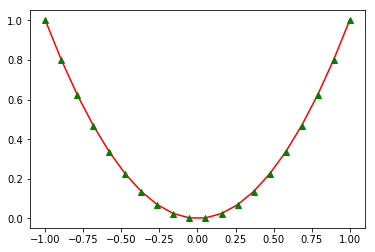

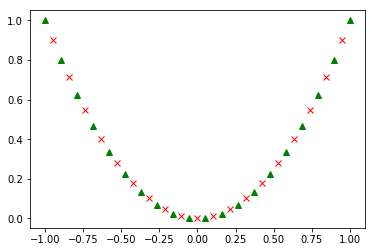

In [43]:
plt.plot(x_list, y_list, c='r')
plt.plot(x_list, y_list, 'g^')
plt.show()

plt.plot(x_list, y_list, 'g^')
plt.plot(collocation_points[:, 0], collocation_points[:, 1], 'rx')
plt.show()

In [44]:
discrete_points = discrete_points[::1,:]

In [45]:
tau = discrete_points[1:] - discrete_points[:-1]
tau /= np.linalg.norm(tau, axis=1, keepdims=True)

In [46]:
normals = np.empty_like(tau)
normals[:, 0] = -tau[:, 1]
normals[:, 1] = tau[:, 0]

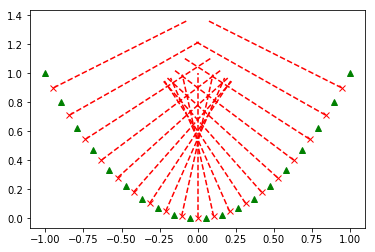

In [47]:
plt.plot(discrete_points[:, 0], discrete_points[:, 1], 'g^')
plt.plot(collocation_points[:, 0], collocation_points[:, 1], 'rx')
_norm_vecs = np.empty(shape=(2 * normals.shape[0], 2), dtype=normals.dtype)
_paired_ind = (np.arange(0, _norm_vecs.shape[0]) % 2 == 0)
_norm_vecs[_paired_ind] = collocation_points
_norm_vecs[np.bitwise_not(_paired_ind)] = collocation_points + normals
for i in range(0, len(_norm_vecs), 2):
    plt.plot([_norm_vecs[i][0], _norm_vecs[i + 1][0]], [_norm_vecs[i][1], _norm_vecs[i + 1][1]], 'r--')
    plt.plot([_norm_vecs[i + 1][0]], [_norm_vecs[i + 1][1]], 'r')

In [51]:
delta = np.min(np.linalg.norm(discrete_points[1:] - discrete_points[:-1], axis=1)) / 2

In [52]:
def calc_R(point, discrete_points, delta):
    if len(point.shape) == 3:
        vv = np.ones(shape=(len(point), len(point), discrete_points.shape[0], 2), dtype=discrete_points.dtype)
    else:
        vv = np.ones(shape=(1, 1, discrete_points.shape[0], 2), dtype=discrete_points.dtype)
    vv[:, :, :, 0] *= delta
    point = np.expand_dims(point, axis=-2)
    #print("3:", point.shape)
    vv[:, :, :, 1] = np.linalg.norm(discrete_points - point, axis=-1)
    R_arr = np.max(vv, axis=-1, keepdims=True)
    return R_arr

In [53]:
def calc_V0j(colloc_point, points_0):
    #print("6:", colloc_point.shape, points_0.shape)
    R_arr = calc_R(colloc_point, points_0, delta)
    #print("4:", R_arr.shape)
    R_arr = np.squeeze(R_arr)
    R_arr = np.expand_dims(R_arr, axis=-1)
    V0 = (points_0 - colloc_point) / (2 * np.pi * R_arr * R_arr)
    #print("5:", V0.shape)
    V0 = V0[:, ::-1]
    V0[:, 1] *= -1
    return V0

In [54]:
A = np.empty(shape=(discrete_points.shape[0], discrete_points.shape[0]), dtype=discrete_points.dtype)

for k in range(len(collocation_points)):
    colloc_point = collocation_points[k]
    V0 = calc_V0j(colloc_point, discrete_points)
    #print("7:", V0.shape)
    A[k, :] = V0.dot(normals[k])

A[-1, :] = 1

In [55]:
b = np.empty(shape=(discrete_points.shape[0],), dtype=discrete_points.dtype)
b[:-1] = -normals.dot(V_inf)
b[-1] = gamma_0

In [56]:
gamma_coef = np.linalg.solve(A, b)

In [57]:
def calc_Vj(points_xy, points_xy_0, t):
    """
    :param points_xy: (i, j) -> (x, y)
    """
    delta = np.min(np.linalg.norm(points_xy_0[1:] - points_xy_0[:-1], axis=1)) / 2
    R_arr = calc_R(points_xy, points_xy_0, delta)
    #R_arr = np.squeeze(R_arr)
    # print(R_arr.shape)
    points_xy = np.expand_dims(points_xy, axis=-2)
    V0 = (points_xy_0 - points_xy) / (2 * np.pi * R_arr * R_arr)
    #print("1:", V0.shape)
    V0 = V0[:, :, :, ::-1]
    V0[:, :, :, 1] *= -1
    return V0

In [58]:
def calc_V(points_xy, t, gamma_coef, points_xy_0):
    vj = calc_Vj(points_xy, points_xy_0, t)
    # print(vj.shape, gamma_coef.shape, V_inf.shape)
    return V_inf + gamma_coef.dot(vj)

In [59]:
X_1, X_2 = -2, 2.1
Y_1, Y_2 = -2, 2.1

In [79]:
# matrix of (x, y) coordinates of (j, i) point
points_coords = np.dstack(np.meshgrid(np.arange(X_1, X_2, delta*4), np.arange(Y_1, Y_2, delta*4)))

In [80]:
V_field = calc_V(points_coords, 0, gamma_coef, discrete_points)
print(V_field.shape)
U, V = V_field[:, :, 0], V_field[:, :, 1]
print(U.shape, V.shape)

(20, 20, 2)
(20, 20) (20, 20)


In [81]:
print(discrete_points.shape)
print(points_coords.shape)
print(np.expand_dims(points_coords, axis=-2).shape)
print((np.expand_dims(points_coords, axis=-2) - discrete_points[:-1]).shape)

(20, 2)
(20, 20, 2)
(20, 20, 1, 2)
(20, 20, 19, 2)


In [82]:
def calc_phi_simple(points_xy, t, gamma_coef, points_xy_0):
    dxdy = np.expand_dims(points_coords, axis=-2) - points_xy_0
    #print("8:", dxdy.shape)
    
    pi_part = np.zeros(shape=list(dxdy.shape)[:-1], dtype=dxdy.dtype)
    pi_part[np.expand_dims(points_xy[:, :, 0], axis=-1) > points_xy_0[:, 0]] -= np.pi
    #print("9:", pi_part.shape)
    
    big_sum = np.squeeze((np.arctan(dxdy[:, :, :, 1] / dxdy[:, :, :, 0]) + pi_part).dot(np.expand_dims(gamma_coef, axis=-1)) / (2 * np.pi))
    # print("simple big sum shape:", big_sum.shape)
    inf_part = np.squeeze(points_xy.dot(np.expand_dims(V_inf, axis=-1)))
    # print("simple inf part shape:", inf_part.shape)
    return inf_part + big_sum

In [83]:
def calc_psi_simple(points_xy, t, gamma_coef, points_xy_0):
    R_arr = calc_R(points_xy, points_xy_0, delta)
    # print("R_arr shape:", R_arr.shape)
    R_log_arr = np.log(np.squeeze(R_arr))
    big_sum = np.squeeze(R_log_arr.dot(np.expand_dims(gamma_coef, axis=-1)) / (2 * np.pi))
    # print("psi simple big sum shape:", big_sum.shape)
    inf_part = np.squeeze(points_xy.dot(np.expand_dims(V_inf[::-1] * [-1, 1], axis=-1)))
    # print("simple inf part shape:", inf_part.shape)
    return inf_part - big_sum

In [84]:
def calc_phi_dipol(points_xy, t, gamma_coef, points_xy_0):
    dxdy0 = points_xy_0[1:] - points_xy_0[:-1]
    dxdy = np.expand_dims(points_coords, axis=-2) - points_xy_0[:-1]
    R_arr = calc_R(points_xy, points_xy_0, delta)[:, :, :-1]
    R_arr = np.squeeze(R_arr)
    z = (dxdy0[:, 1] * dxdy[:, :, :, 0] - dxdy0[:, 0] * dxdy[:, :, :, 1]) / (R_arr * R_arr)
    gamma_sums = gamma_coef.dot(np.triu(np.ones(shape=(gamma_coef.shape[0], gamma_coef.shape[0]), dtype=np.float32)))
    delta_points = points_xy - points_xy_0[-1]
    big_sum = np.squeeze(z.dot(np.expand_dims(gamma_sums[:-1], axis=-1)) / (2 * np.pi))
    pi_part = np.zeros_like(big_sum)
    pi_part[points_xy[:, :, 0] > points_xy_0[-1, 0]] -= np.pi
    c0 = gamma_0 * (np.arctan(delta_points[:, :, 1] / delta_points[:, :, 0]) + pi_part) / (2 * np.pi)
    inf_part = np.squeeze(points_xy.dot(np.expand_dims(V_inf, axis=-1)))
    return inf_part + big_sum + c0

In [85]:
#np.triu(np.ones((5,5)))

In [86]:
def calc_psi_dipol(points_xy, t, gamma_coef, points_xy_0):
    dxdy0 = points_xy_0[1:] - points_xy_0[:-1]
    dxdy = np.expand_dims(points_coords, axis=-2) - points_xy_0[:-1]
    R_arr = calc_R(points_xy, points_xy_0, delta)[:, :, :-1]
    R_arr = np.squeeze(R_arr)
    # print("R_arr shape:", R_arr.shape)
    z =  np.sum(dxdy0 * dxdy, axis=3) / (R_arr * R_arr)  # (dxdy0[:, 0] * dxdy[:, :, :, 0] - dxdy0[:, 1] * dxdy[:, :, :, 1]) / (R_arr * R_arr)
    # print("z shape:", z.shape)
    gamma_sums = gamma_coef.dot(np.triu(np.ones(shape=(gamma_coef.shape[0], gamma_coef.shape[0]), dtype=np.float32)))
    print("gamma sums shape:", gamma_sums.shape)
    # delta_points = points_xy - points_xy_0[-1]
    big_sum = np.squeeze(z.dot(np.expand_dims(gamma_sums[:-1], axis=-1)) / (2 * np.pi))
    print("11:", R_arr.shape)
    c0 = gamma_0 * np.sum(np.log(R_arr), axis=-1) / (2 * np.pi)
    # print("delta points shape:", delta_points.shape)
    # print("big sum shape:", big_sum.shape)
    # print("c0 shape:", c0.shape)
    inf_part = np.squeeze(points_xy.dot(np.expand_dims(V_inf[::-1] * [-1, 1], axis=-1)))
    # print("inf part shape:", inf_part.shape)
    return inf_part - big_sum - c0

In [87]:
def calc_Cp(v):
    return 1 - (np.linalg.norm(v, axis=-1) / np.linalg.norm(V_inf))**2

In [88]:
def calc_p(Cp, rho=1.2041):
    return rho * np.linalg.norm(V_inf)**2 * Cp + p_inf

In [89]:
Cp = calc_Cp(V_field)
print(Cp.shape, Cp.min(), Cp.max())
p = calc_p(Cp)
print(p.shape, p.min(), p.max())

(20, 20) -1.897783933073797 0.9838168869862621
(20, 20) -1.2851216338141587 2.184613913620158


In [90]:
phi_simple_map = calc_phi_simple(points_coords, 0, gamma_coef, discrete_points)
#print(phi_simple_map.shape)
psi_simple_map = calc_psi_simple(points_coords, 0, gamma_coef, discrete_points)
#print(psi_simple_map.shape)
phi_map = calc_phi_dipol(points_coords, 0, gamma_coef, discrete_points)
#print(phi_map.shape)
psi_map = calc_psi_dipol(points_coords, 0, gamma_coef, discrete_points)
#print(psi_map.shape)

gamma sums shape: (20,)
11: (20, 20, 19)


gamma sums shape: (20,)
11: (20, 20, 19)


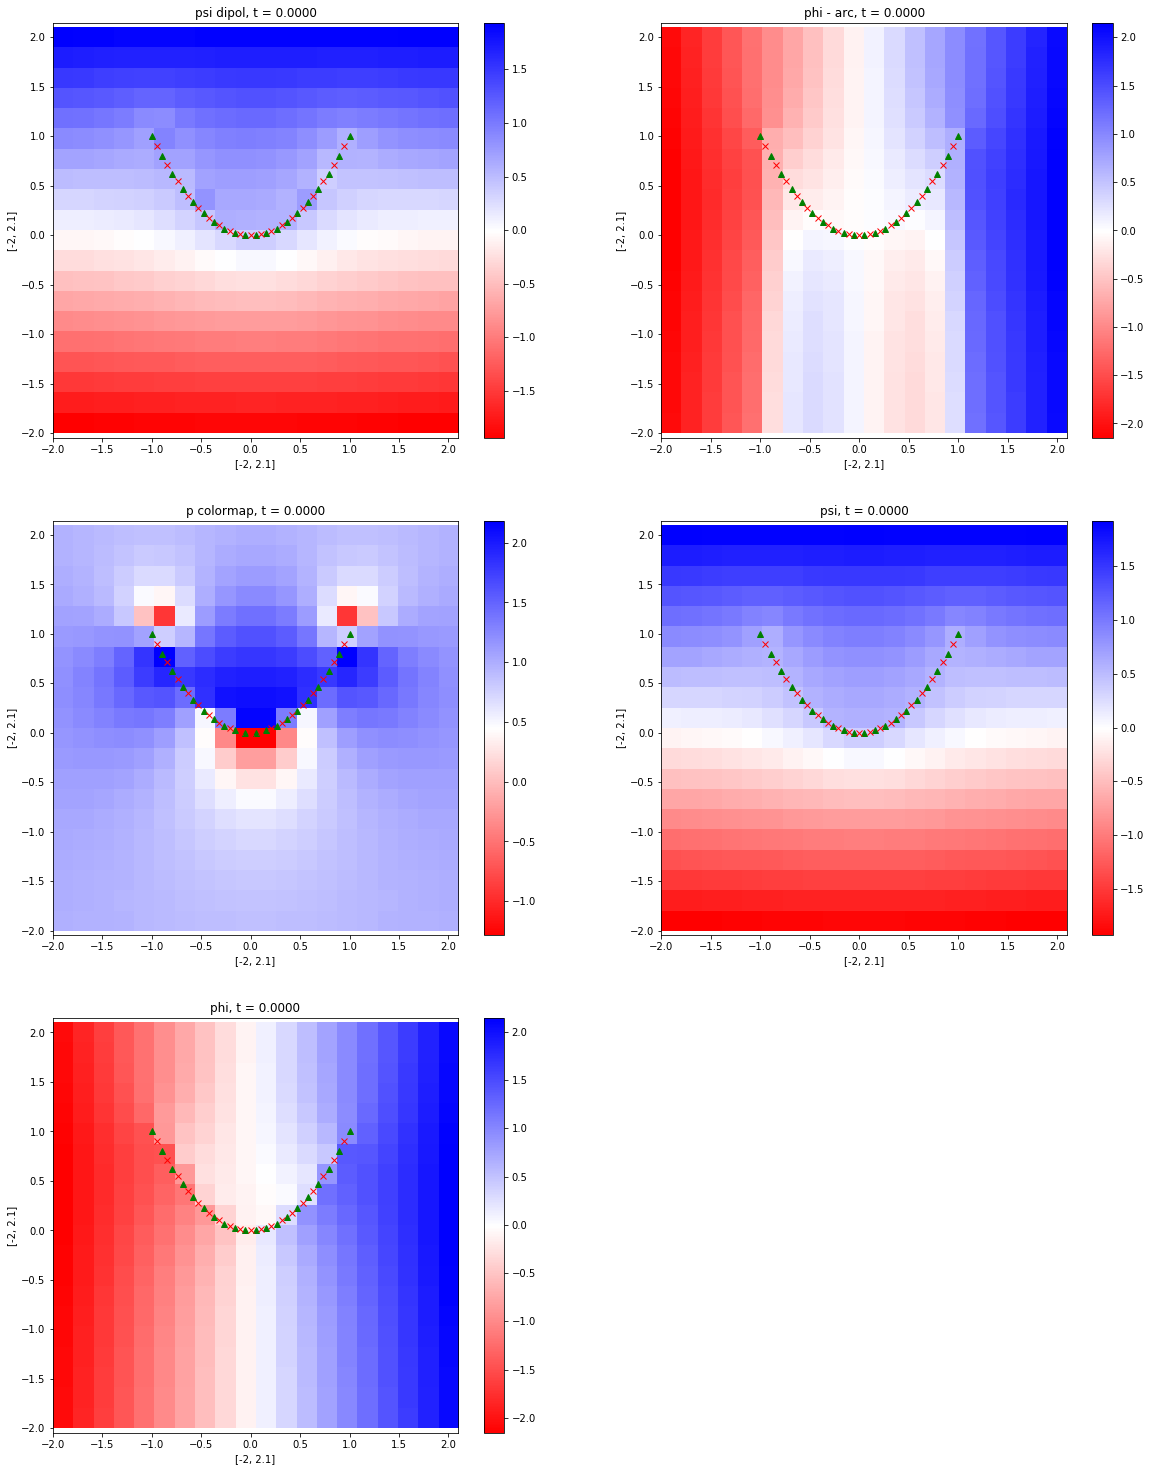

In [93]:
T = np.linspace(0, 1, 1)
X = np.arange(X_1, X_2, delta*4)
Y = np.arange(Y_1, Y_2, delta*4)

fig = plt.figure(figsize=(20, 90))
U = np.zeros(shape=(T.shape[0], X.shape[0], Y.shape[0]), dtype=np.float32)
V = np.zeros(shape=(T.shape[0], X.shape[0], Y.shape[0]), dtype=np.float32)
phi_map = np.zeros(shape=(T.shape[0], X.shape[0], Y.shape[0]), dtype=np.float32)
phi_simple_map = np.zeros(shape=(T.shape[0], X.shape[0], Y.shape[0]), dtype=np.float32)
psi_map = np.zeros(shape=(T.shape[0], X.shape[0], Y.shape[0]), dtype=np.float32)
psi_simple_map = np.zeros(shape=(T.shape[0], X.shape[0], Y.shape[0]), dtype=np.float32)
Cp_map = np.zeros(shape=(T.shape[0], X.shape[0], Y.shape[0]), dtype=np.float32)
p_map = np.zeros(shape=(T.shape[0], X.shape[0], Y.shape[0]), dtype=np.float32)
for i in range(T.shape[0]):
    V_field = calc_V(points_coords, T[i], gamma_coef, discrete_points)
    U[i], V[i] = V_field[:, :, 0], V_field[:, :, 1]
    phi_map[i] = calc_phi_dipol(points_coords, T[i], gamma_coef, discrete_points)
    phi_simple_map[i] = calc_phi_simple(points_coords, T[i], gamma_coef, discrete_points)
    psi_map[i] = calc_psi_dipol(points_coords, T[i], gamma_coef, discrete_points)
    psi_simple_map[i] = calc_psi_simple(points_coords, T[i], gamma_coef, discrete_points)
    Cp_map[i] = calc_Cp(V_field)
    p_map[i] = calc_p(Cp_map[i])

phi_maps = {
    "phi - arc": phi_simple_map,
    "phi": phi_map,
    "psi": psi_simple_map,
    "psi dipol": psi_map,
    #"C_p": Cp_map,
    "p colormap": p_map,
}

for plot_num, (title_s, phi_map) in enumerate(phi_maps.items()):
    lo = phi_map.min()
    hi = phi_map.max()
    for i in range(T.shape[0]):
        t = T[i]
        ax = plt.subplot(10, 2, plot_num + 1)
        plot_num += 1
        # plt.axis('off')
        #q = ax.quiver(X[::3], Y[::3], U[i, ::3, ::3], V[i, ::3, ::3])

        ax.axis("equal")
        #ax.xticks(np.arange(X_1, X_2, 0.5))
        #ax.yticks(np.arange(Y_1, Y_2, 0.5))
        ax.set_xlabel([X_1, X_2])
        ax.set_ylabel([Y_1, Y_2])

        ax.plot(discrete_points[:, 0], discrete_points[:, 1], 'g^')
        ax.plot(collocation_points[:, 0], collocation_points[:, 1], 'rx')

        im = ax.imshow(phi_map[i, ::-1, :], cmap=cmap, extent=[X_1, X_2, Y_1, Y_2], interpolation='none')  # drawing the function

        # adding the Contour lines with labels
        #cset = contour(phi_map[i], np.linspace(lo, hi, 20), linewidths=1, cmap=cm.Set3, extent=[X_1, X_2, Y_1, Y_2])
        #clabel(cset, inline=True, fmt='%1.1f', fontsize=10)
        colorbar(im)  # adding data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABCQAAAmiCAYAAAAMqFkMAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzs3Xl8XmWd///3VboBBUoXKVtBNtmXkoIoDt4uo+M4OAqTQQdHx3EY89Vxfm6oYEC4BaU6biMTRCFsotygo4gsbnEUQW2hFFrWsnUhpXvT0iVNcv3+uO+TnKTn5Oz3OXfu1/PxyCN3znqdc5/7JLnO5/O5jLVWAAAAAAAA9TQu7wYAAAAAAIDmQ4cEAAAAAACoOzokAAAAAABA3dEhAQAAAAAA6o4OCQAAAAAAUHd0SAAAAAAAgLqjQwIAgBpjzBJjzBtDLvtBY8z9rp+3GGMOS6ENvzPGfDjpdgAAAIqODgkAAGqstcdZa38Xc90p1trnUm7SqLLsvDDGvNkY86QxZqsxpssYc8goyx5aW2ZrbZ23jJj/CWPMKmNMjzHmemPMpDTWBQAAjY0OCQAAMIwxZoakn0hqlzRN0gJJt42yyg8lLZQ0XdLFku4wxsysbettkj4n6c2SDpF0mKTLUloXAAA0MDokAABjjjHmBWPM540xjxtjNhhjOo0xk2vzZhhj7jLGbDTGrDfG/MEYM8613lt8tjndGHNn7Un9XyQdPmK+NcYcUXt9gzHmGmPMr4wxm40x/+eOMDDGvM4YM98Ys6n2/XUxjvEKSW+Q9J1aush3om5jFO+RtMRae7u1drukL0o6yRhztEc7jpI0R9Kl1tpt1tofS3pM0jm1RT4g6Tpr7RJr7QZJZUkfTLouAABofHRIAADGqn+S9DZVOw6OkvSF2vRPSVohaaak/SRdJMmG2N7VkrZL2l/Sh2pfQfsvS5oh6RFJP5AkY8w0Sb+Q9G1VowK+LukXxpjpIY9LkmStvVjSHyR9rJYu8jGv5WodL35fn/PZ/HGSFrn29YqkZ2vTvZZ9zlq72TVtkWvZYduqvd6vdrxJ1gUAAA2ODgkAwFj1HWvtcmvteklXSHpvbfpOVTsVDrHW7rTW/sFaO2qHhDFmN1Wf2l9irX3FWrtY0o0B+/+Ftfb31todqqYinGGMOVjS30p6xlp7s7W2z1r7Q0lPSvq72Ec6Cmvt1FG+vuKz2hRJm0ZM2yRprxjLjpzvvN4r4boAAKDB0SEBABirlrtevyjpgNrrr0paKumXxpjnRokScJspabzHNkPt31q7RdL6WhsO8Fj3RUkHhmhHvWyRtPeIaXtL2hxj2ZHzndebE64LAAAaHB0SAICx6mDX69mSXpIka+1ma+2nrLWHSTpb0ieNMW8O2NYaSX0e2wy1f2PMFFWLQ75U+xo5YsVsSSsDtuclMNWkVl/C7+sin9WWSDrJtY09VU19WeKz7GHGGHfUwkmuZYdtq/b6ZWvtuoTrAgCABkeHBABgrPqoMeagWs2Gi1UbJcIY805jzBHGGKNqCkC/pIHRNmSt7Vd11IkvGmP2MMYcq2rBxdG8wxhzpjFmoqq1JP5krV0u6W5JRxlj3meMGW+M+UdJx0q6a+QGakNiWmPMoT77eFnVkSdGa/uUUb6u9FntfyUdb4w5p1YM9BJJj1prn/TY/tOq1si41Bgz2RjzbkknSvpxbZGbJP2rMeZYY8xUVWt53JB0XQAA0PjokAAAjFW3SvqlpOdULcj4pdr0IyX9WtV0gAcl/Y+1tivE9j6mak2DVar+U9wZYv+Xqpqqcaqk8yWp9nT/naoW11wn6UJJ77TWrvXYxsGqpnP4RU98S9K5tZFEvh3iGEKx1q5RtWbGFZI2SDpd0nnO/NoIIte4VjlPUktt2a9IOre2DVlr75U0T1KXpGW147k0pXUBAEADMwF1vAAAaDjGmBckfdha++uc9n+DpBXW2i8ELRuwnS9IWmOt/W4qDQMAACiQ8Xk3AAAAeLPWfil4KQAAgMZEygYAAAAAAKg7UjYAAAAAAEDdESEBAAAAAEATM8YcbIzpMsY8boxZYoz5T49ljDHm28aYpcaYR40xc5LulxoSAAAAAAA0tz5Jn7LWPmyM2UvSQ8aYX1lrH3ct8zeqjlZ2pKojcHXUvsc2JjskZsyYYQ899NC8mwEgooceyrsFAIBmc+qpebcAQFQPPfTQWmvtzLzbkRVj3m4lr9HAk3joPmvt2/3mWmu7JXXXXm82xjwh6UBJ7g6Jd0m6yVbrPvzJGDPVGLN/bd1YxmSHxKGHHqoFCxbk3QwAERmTbH7edtst7xZgNP39ebcAGDvGUgky/mQEGo8x5sW825CttZLSvjmZo40x7o1ea6291nNJYw6VdIqkP4+YdaCk5a6fV9Sm0SEBAAAAAMBYMC7lao8DA1prrW0JWs4YM0XSjyX9f9bannRbsSs6JAAUxvgU70hp38TTVvT2FdnAQLz1OOeAt7ifqaIg+gkA0mGMmaBqZ8QPrLU/8VhkpaSDXT8fVJsWG3+eAQAAAABQIOPGpfsVxBhjJF0n6Qlr7dd9FrtT0j/XRtt4raRNSepHSERIACiQNCMkghS9HoVjrNeliPNks1HPyVjKuY+qUT5vjSrptVXE6KEoURtFbD8AJGFMLve210t6v6THjDGP1KZdJGm2JFlrr5F0t6R3SFoqaaukf0m609w6JIwxB0u6SdJ+kqyqRTW+NWIZI+lbqh70VkkftNY+XO+2AgAAAAAwVllr75c06iOE2ugaH01zv3lGSOQyzikAAAAAAEXWLNFfuXVI5DXOKYDiqmfKRpCx8ksgi+NIswBe0c9zoxf7a3ZcX8XQTKlZAIBoCvHnfz3HOQUAAAAAoKhyqiGRi9w7JNIa59QYc4GkCyRp9uzZKbUOAAAAAID6okOiDtIc59Rae62kayWppaWliWuZA40ryo0375t0M48a0Kih1HFGIsj7OsPY1sjXVyONgtEsqTEA0Ihy+xWR1zinAAAAAAAU2bhx6X4VVZ4RErmMcwqguNJ88p73U/wi3/jHkrH45DNOAcA05f3ZQb7CXn95XydRIp64HwNAceU5ykYu45wCAAAAAFBUFLUEAAAAAAC5oEMCAOpswoT67Svvm3wzF8UM0kih2FmkjOR9TPXUTMeahzjXZ97vyVhMwwIA+KNDAgAAAACAgiBlAwAAAAAA5IIOCQCoM/eNN4+UhryrxruN5V9CRQ3JjjO6RZGumWY21t+HuCOvFOW8NFIaFgCgvuiQAAAAAACgQJqlg5YOCQCFMT7CHSmPm3RRfjEUvSBm0NPQep7HKNEYRXl/gZGKeG0WNdLJETeqBABQX3RIAAAAAABQEBS1BAAAAAAAuaBDAgDqLErKRpB6pTUUpWhcGHF+sRU9LNvNK0Q7j/cnSgG/saLoaUSIrkipV25h70nN8oc8ADQ6OiQAAAAAACgIUjYAAAAAAEAu6JAAgDpLM2XDSzOPzBFXkdofFKqdRVsbKWWlkRXpOhvrinhNRxkRo5HS5AAAweiQAAAAAACgQJqls54OCQCF4XXjrefNuJ6F+XjK58/vaWkW56yohfsQDsU0q6IUUs3jms4juslPESNEAKCZ0SEBAAAAAEBBUNQSAAAAAADkgg4JAKizOCH5Wac+ZP3LoFl+2fjxCp9O85zkHZ4dpVhfo2jEdKNG/5zlfR17KVIhyqKnrAAA/NEhAQAAAABAQTRTykaTHCYAAAAAACgSIiQAFMaECeltK+te5ayr+zdiWHwQrxDvNI/TK2w77/SPZnm6EaTRz0PSz3uUlAIvjIxRv30BQFE0+u/OsOiQAAAAAACgQOiQAIA6yzoqgAKY9eH3NDOt9mf1tDSoSN9YjFopCs5tvrKOXvJCIUoAgESHBAAAAAAAhdFMRS3pkAAAAAAAoEDokACAOgsKEc7ixpzVzT7LopdFDW93wr6LXqgy65SSMPtqNEX6o6hIbWkUeRSozPvaD0rBAgAUAx0SAAAAAAAURDOlbDTJYQIAAAAAgCIhQgJAYYyPcUfKKjUii7SIsTgKhzssu4ijaGQxegCjA4wuy3QlP0VNY6qXvEeIySK1KkgeaSgAUE/Nch+jQwIAAAAAgAKhQwIA6ixOhESQNG/maW6rkYteup/GZlHAMu559npiGmdbjV6Mr+jRAnn8gTWW/qhL6zpPus+s5R31AQCoDzokAAAAAAAoCIpaAgAAAAAAZIgICQCF4dUTXNQ0ibTChRup0KUTtp3FNuOKkz4SVJQy6fElPaYiPRHJoy3NXhQz71SFehWozKsoZd4pWQAQVpH+HsgSHRIAAAAAABQEKRsAAAAAAKApGGOuN8asNsYs9pn/RmPMJmPMI7WvS9LYLxESAAojSihyEVMmkm4r61D1OOcsixE13CHhUc5Z0tEF0kwPGU2Rwv/rJetjzvspUT3TlOp1rFmnLuSVepJ1ShYA1EsO96sbJH1H0k2jLPMHa+0709wpHRIAAAAAABRIvTskrLW/N8YcWt+90iEBoEAmTEi2fpEKYCZ9+pfFL6E428yjmJ1bmkUrwx6LX/vSOhd5F9XL4wlxVvvMowBmUnlE0GRdqDJp9FKc7QMAcnGGMWaRpJckfdpauyTpBumQAAAAAACgIDIqajnDGLPA9fO11tprI6z/sKRDrLVbjDHvkPRTSUcmbRQdEgAAAAAAjG1rrbUtcVe21va4Xt9tjPkfY8wMa+3aJI2iQwJAYbh7gtMKxc47dSLu+lmEoictapmUEzYedE7c4dlZF630Or4o5ymogJ6XRiyql1VqRBGL0za6PIpVppmGknV6iYM0EABFV7TfbcaYWZJettZaY8xpqo7YuS7pdnPtkDDGXC/pnZJWW2uP95j/Rkk/k/R8bdJPrLWX16+FAAAAAADUT0YpGwH7ND+U9EZVUztWSLpU0gRJstZeI+lcSW3GmD5J2ySdZ22cRzPD5R0hcYNyGFoEAAAAAABUWWvfGzD/O6r+756qXDsk8hpaBEAxjQ+4I6XZU5x0W3FC2OOENed9zO73JGmIc9j1o6SJuPvlo6SChF0naP16yjpUPom8r1M/jTgKRxxRPgdhZTXaTL0+R0H3kaJ8dgDAT9FSNrKSd4REGKkPLQIAAAAAQFHRIVEMoYcWMcZcIOkCSZo9e3b9WgggNUEREl6SPgGtZ9HLOL9Y8j4+tzgFLuNEMMSJdPDjbnPQuQjKggz7/mX1BDjLP0yy2nZRrt+x9EddFtdXFtE3fp+nrCM40t4PACBbhb5dW2t7rLVbaq/vljTBGDPDZ9lrrbUt1tqWmTNn1rWdAAAAAACkwSlqmeZXURW4adWhRYypPl9Jc2gRAAAAAACQr7yH/cxlaBEAxRQnZcNP0p7grNMrwoZD53Ecfpz3J0rIeNz0Ci/O3d/vmOIUrYwT/t7sxfLqmeaUZB0/jVjoMuuilUUsVNnsnzMAKHJUQ5ryHmUjl6FFAAAAAAAoIidloxk0yWECAAAAAIAiKfooGwCaiFdPcN6h2nHDgsO2O8rxhW1/1qHMUUbbiJIy4bVsUCh40lE04uwzynuW1YgbSWTxxCXuNvMehaPoT5/Sun7SHEUj7OcoijjpVkm3DwBFV/TfUWlpksMEAAAAAABFQoQEgMKI88Qu6wiGuOtkEc2QRdRFHO7io0FPHqNEOHgJOpY0i1Y6bYnyngSVWW70pxt5RDBEOWdJz28RC1ymWcDSuf6LVLQyzWgNx1j/HAJoPs1UQ4IOCQAAAAAACqRZOiSa5DABAAAAAECRECEBoDAmTEi2fj3Dt8OGGKcZfh7UvqyLWQbxCsWOk3KRtJBlUMi73/bjtCWKKMVA05bmtZF1upNbvQq55v0UKqvrLM55SatoZZTPWdxtAcBYlvfvpnqhQwIAAAAAgIKghgQA5MDrxpvXsIB5DNsZ1NakBR7DtsNPnMJxcYpa+h1HUIG+sPvyO89xngxHeXLbKH9YxGln3Gsqj0gjL3kXt0yz6GQeEQhFH1bUjWgLACgWOiQAAAAAACiQRnmQkVSTHCYAAAAAACgSIiQAFMb4CHekpL3GWaQ3RAlR9tp/1kUt0+pp9wt5Dpt+4Rde7rXdOAUs0yxaGVSIMsp7HpTykoW0UhHGUupT0v1nIYuUiSBBxV/9eLW1SIUq0/zMAkBeqCEBAAAAAABy0SwdEk1ymAAAAAAAoEiIkABQGFFSNrzECU/PKhQ9i/SLPNI8gqrnu8O+nffPLxTbme4XUh32+IJSRuKOohEnFH2sVOyP+xQmj9SnLEbcaNRRNoJGnhltnSiCUqeCpDlyRlD7m+WJIoCxr1nuZ01ymAAAAAAAoEiIkABQGF5PKZMWIMv7yW/cp71e08Oen6TRG25eUStJIyD89u+1vlc0hl9UQ9KilUFFM700SgRF0qcs9SzuGmV+WgUu834KFeU6iROtEKeAZdBnK8x6SfjdR5L+TsijuCwAREVRSwAAAAAAkItm6ZBoksMEAAAAAABFQoQEgMKYMCH8svUKQc86/NyvHUmKWvq1I2lKjFfRSHf4c1CBPa+UDK9Q8qD1vdrk5heeHlS0MmmxPy9Jw8vrJa/iro4on4M09593MUtHFoU6pfDXdFDxWi9+qQ9xUkKSbCfqdgGgEZCyAQAAAAAActEsHRJNcpgAAAAAAKBIiJAAUBhJw9vjrJ9VqHSc9Iig9IuglI+gNI8o6R1enFBod0i0+3WclI6gNAyv9Au/6v9B2woaRSPOKB1x1slD0qcsaaY+pDkyTFaj3NRb3FE2vIQdUSOvUTS87hNRJB35BgAaRbPcz5rkMAEAAAAAQJEQIQGgMLJ4mhm3dznrJ69hoxWCIi28IiD89u01P80IibARFH5RDUFPXoMiMOJEUHht3y0oqsJLPZ82p/X0JG5xxyw+B2lFF8Xdv5co5yfo+vASdB1EiWZIUsjST9ioizDtSKvoZVxRjhsA8kJRSwAAAAAAkItm6ZBoksMEAAAAAABFQoQEgMIYH+OOlFWouSNp0cu4xQCd9kUpdBmUkuHsKyjlw80rpcKv6GRf367rONPc/ApNeqVceIWq+4Vyx0npcAuaHyROKHjSQq5xZFH8Nel1HmW7UT5naaZ/xJFW+kSUNI2wy6aV+iGFT3fy45XmEvd9iFOIFgCKhpQNAAAAAACQi2bpkGiSwwQAAAAAAEVChASAwnCHVycNZc96RI44IepexxRldICglAzntd95dFJi3Ou402SCjslJv3CnYXilZPiFTHuFinuNwuGXUhK0ftKUDq99usUJBc9qpICo7chq/bRSIqJ8DqLsM2nKR1qSphHEGSHGLWiUDK/tp5kmErSvKIKONY80KADIAhESAAAAAAAAGSFCAkBhTJgw+vy8n/x6iVsgL86TW68ICa9oiKAICPc0r9d+be7tHf7djztqwr1958lolKKVXgUw/Z72hn0KHRRB4cdr/0HSfHKcxZOSrK/zoPlpRUCk+TkLM300Qe+j1/w467inx4nq8Ssu6yVO0cmg4rFBkq4fdbsAUCQUtQQAAAAAALlolg6JJjlMAAAAAABQJERIACiM8QnvSGHDz92iFECLG5Y+2vygUPGgkHavApB+KRnOsu7UmMmTh15PnDj8uzQ8vHnr1l3b4pV+4W5fmmk2zvb9Uiu8zllQsb4oRTGDBKV8BMmyGF/cbad5TTuySMmIOz9OUc4ovK6JOKkOQSkbUbaVpB1+vI4zynmMkxLiJ4/UJwBIWzOlbDTJYQIAAAAAAC/GmOuNMauNMYt95htjzLeNMUuNMY8aY+aksV86JAAAAAAAKJBx49L9CuEGSW8fZf7fSDqy9nWBpI6kxyiRsgGgQLIIn44b7pZFekbQfL/RMxxeo2gEjcLhfu2s707JcL+eMqX6fepU7zavXl39vn2793xnX+73zB3KHfac+I3C4bUdr/l+oweEHR0jysgdXuvlXcU/zjUfZZ2wI2O4ZTVKRtjPkVdqU9B+Rps+Gvf776RMRUm5iJLmEZTe4bVe2JE5oqR0pDmaTJCwo+EAQKOrd8qGtfb3xphDR1nkXZJustZaSX8yxkw1xuxvre1Osl8iJAAAAAAAwGgOlLTc9fOK2rREiJAAUBjuYothZRUBEWf7caIi/J4se0VDeG3H67W7kKVXgUm/9ffYo/rdHQHR07Pra/f8vr6h10FPVp0nm35Pq8MWo/N7Mhu0flDhvaDCemGf7EZ5mp1UmkVDvcSNfBht+1EiHILWCYqqCrrm40RoeIkSAZFFBJD72h0tKiKN+aMtF7ROmPXSWj/MtgCgqDIqajnDGLPA9fO11tprU99LRLl2SBhjrpf0TkmrrbXHe8w3kr4l6R2Stkr6oLX24fq2EgAAAACA+smgQ2KttbYlwforJR3s+vmg2rRE8k7ZuEE5FM4AAARbu71bn3j0LK3vXZV3U4DC2tjXrSu7z9LGPj4nAIAx7U5J/1wbbeO1kjYlrR8h5RwhkVfhDADFND7FO1Iehf3c4oS6Jw1vd1679+0Vvu4OX965c+j1li3V705qRseyshb33K9rnyrrQ/tdPTjdncax++5Dr71Sbrza595/UNHLpCkTXqHocVI7JO/w+CiKMp54FmkYQfODUiKC5vtd017bj1LoNexnZjQ/X1/WMzvu112bq5+ToJSKoJSNKCkdoy0neadJOZKmeQTtP25KR9j1s9oWABRBRikbAfs0P5T0RlVTO1ZIulTSBEmy1l4j6W5VMxeWqpq98C9p7LfoNST8CmfQIQEAGVq/s1u/WdcpqwH9vqdT75nernGalXezgELZ0Net320a/jnZy/A5AQA0HmvtewPmW0kfTXu/Y6bP2BhzgTFmgTFmwZo1a/JuDgA0tNu6yxpQ9bHjgO3XT9aVc24RUDw/WVuWtXxOAADpGzcu3a+iKnqEROjCGbUKoddKUktLS8yAWgB5ihMKntW+HEHh7W5JRxwIu2zcEQGcsGavkTEk6ZVXqt9XbOrWr9d2qk+91eXVq//b1KlTeqpPf93rTJ686378Um/Cply4Q97TGvkizfXd/NI7iiLomnQk/ezFuY795sdJz4iSsuG+PuOs71wz63d26/82Df+c/L6nU637tWvq+FnDlo2SpuSVshE0skxQmpLf9r2MlubhFpTyEbRPUjIAYHTNcm8r+mFmUjgDAODvrp6h6AjHgPr1O8vTX8Bx+8tlDdgRnxPbrzvW8DkBACCsvIf9zKVwBoBiSlrUMko0g5ewT5OlbJ4oJ5kmDR1/UFE+99NGd7REb/VBr57e9qD6a099Hf3q1TL7gHp7palTh6ZPnLjra7/2eT3tDSrgF/Q02c2raGWaRTGTLlsvaRZnDVoui2vWa724RSu9tu++zziv3eu4lx3tnvDM9gcHoyMcferVM9seGPwseEUleV0zXoUw3cv6XVtBRTG9psUpYBnl2vaKGopybw2KioqjKJ9NAAgrj6KWecl7lI1cCmcAAPx9esrCwdfukjxR/qkAxrrvHL9w8J9vv1E0AADA6IpeQwIAAAAAgKZChAQA1JlXykWaT+Xj3NjTDH9PK43DLzUlrXM1ZcrQ6wkTdt2+O01j0iTvZR07dw69do7FHb4eR5Q0jnoKCq+vx77TXi9K+oXX/LCf6aCUjKBloxSt9ErZcF/TXvP9ONeyX6FYZ7p7/17LBqX++BV6DZumlDRNI0oaR9hrsZ4FZYnuAtBomillo0kOEwCQxCm/nqcDnuoaNm3/J7t07F3zcmoRUD8H/3Cepi4cfv1PXdil2bdx/QMAkAQdEgCAQKtnz9VfX9c62Cmx/5NdKl3TqnWHzc25ZUD2Nh89V8d8sXWwU2Lqwi4d88VWbX4N1z8AIBvjxqX7VVSkbAAoDK+Q/yiS3mzrOTpB0PzRRgwJGpEgaF9+odhO2Lp7+7vvXv3+ymkl/WlqRW/7ZqteeHubXn1fh/7ymYr65pY0fcR+3CHp27cPvd6xI1w7o/AK2477PnqFkGc9SkccWV/nceZHSSMKSrnwWjbKKBpey/qlYXilbEyePPTamd73hpKev6qiYz/XqtXntOlVP+7Qs1+uaOsJJU0asU+vlCT3NPf+w44843dNOde/+/iDUjpGzgsz3220NBCv5fxkvX4Qio8CKLoidyKkqUkOEwCQ1OrjSnr2rW06+vaynn9bm9aeUMq7SUDdbGkpac25bTrwurJWn9OmzS1c/wAAJEWEBIDCCCpml+b2s1wnzHqjRUBIoxdhC3qaHCRofb8Cf7Oe6NKRv+7Qsg+06/Cfdqj39SXtPHPXf8p6eoZeexX4cz/BzYJfsbs8njSkGS2RpP1Jo3+iXK9RCmEGRUB4TXO3xdmv3/rO9eu3vjPffZ3vscfQa6fA67hx0uQHu/Sqn3RoTVu79vtRh/rOLMXqlPMqyuqOoPC6ZoIKSPrN94qgcHhFUrhFKVoZJcLCS9L1g7blpVmePAJoTM1U1JIOCQBAoBmPdemUr7Zq4ecr6n19SRtPKemYS1v13FUVbeFJMca4yQ926VX/0arV/13RxlNK2npaSQd+slXbv8z1DwBAEk3S7wIASGLqM/O18PMVrT+p+s/XpjklPXFZRXsumZ9zy4DsTXp0vlb/d0Xbz6he/1tPL2nl17n+AQDZoaglANTZ+Bh3pDRvsHG2FRTK7jZaGkaY/SedH3Y5r6J/y867UFOmSFMk7btvbeabSzLnljSr9uOGDbuu7w5Fd8LHsy5W58cvlSPr/Y7cfpTUjbTalFUKUdj0jCgpGXGKVvqtH1Q00+u98CpwudvnL9QekvaQKyXpzSVtOLWkiRp+nbtTIZzt+93bnGvSq9Clm1/qT1DRyyipGCPb5Peee6Vc1bNAZV73DwCop2ZK2WiSwwQAAAAAAEVChAQAAAAAAAXSLBESdEgAKIw4KRtRREmv8BKUcuEl6egGac4PWs6Z7jUKgXv6hAlD01atktZu79bnHz5Pnz/iNk2bOEvr1w/N37hx1+0HhdfnpV4pHfU8zrDXfNx0ojTTMxxRRtEIe035nYedO6vf3dfpwIC0bke3Lnv8PH3t9Ns0Y/Isbd06NN89CkeQsCktXiNvuF9HGWUjaGSXONuMwutzFOXeGTQKT5zPT9IRbgAA2WmSfhcAQFa+/0xZj6z9YFibAAAgAElEQVS/X7csK+fdFCAVN75Q1mOb7tf3nuaaBgDkg6KWAFBnaRaIjCPpzTrNaIgk66TZDveTxR07qt/XrBma9tyabt25rFNWA7rn5U69ZWK7tGXW4Hz3k+cZM6rfnUKBUduat6AIiiIK+zmJEgHhNT9uBIVX0cqg7Xu99ork8duu+310IiQGC1VKevmVbt2zqnpN/+zFTr17WrsO3nfomt5rr6Fle3ur3+NGMARx2up3/GGLWgYVynTz2uZoy4XdbtB6UUX5PGbx+wIAskRRSwAAQvjRS2UNqPofhrX9+tkGniijsd2+pixrq9f0gPp160quaQAAskKHBAAglrU7uvWbdZ3qs9XHxH3q1e+3dKpnYFXOLQPi2djXra4NnepT7Zq2vfrl6k6t28E1DQCoL1I2AKDO3MUSs5DmzTjLlIt6rhOUJuMOr962rfrdCW//7oqy+u3w+OsB26+frC3rbf1XSxoe3u4VXu9VyNSvwB+iy6JQathp7ul+11nYopVu7mvGa/vu8Hyv68u9TaeAojPtzk1lDXhc09c8UdYFB1avaSfNQwp/z0rzOnZ/PpxjdReCDErpGDlvpLDLBqV8+Al7LtLaDgA0IlI2AAAI8NTWB9Vfe5Ls6FevVox7IKcWAcks3bHrNd2nXj35Ctc0AABZIEICABDL149aqLVrh352Clhu2JBPe4CkvnTQQm3ZMvTzlCnDvwMAUC/NEiFBhwSAwsh6lIoo6jniRtrrRxmtJIg7PNx53dvrvaxj+vSh1+5/5Pbcs/p999291/MKL3eHx48Mr09D3NEPGmX/eadspDWKht98r+17pQR5pW74TXdP8xrJoa9v9PYFyeJ99htxwiulw6sdcdIj4o6ykWSfaWwXAFAsTdLvAgCol7ld83Tw0q5h0w54qkvH3jUvpxYBuzro1nna95Hh1+n0R7t0zM+5TgEA+XJqSFDUEgDqyO8pZlryeAIdRZqRDQ6/J9Oj8Xva6nC/T+4IiMmTq993njxXZ3+7VX/8eEU9h5U047EunXZdqx69uKKZM4efM/fT5u3bd53mbr/TrigF/JJGIKQZwRC2MGA9i6+mFSERpWil17aiREh4FbB0z3dfn07RSXdUjjO//9S5OuEzrXrhqorWnlDS3g916aivteqxL1T0qldVl3Ffi17tCyvNazLKNe/F6/PtdZ/wiqrwa4eXNCMgokQ9FPmPbgCIolnuZ3RIAABStfq4kv748Ype/+1WvfD2Nr36vg795VMVbT2plHfTgEGvzC3phasqOvSzrdr93W3a73879HS5og3HcJ0CAFAvTdLvAgCop9XHlbT0LW06+vaynn9bm9aewD95KJ4tc0ta+w9tOqizrJff3aaeU7lOAQDFQMoGANRZ0vDyLGSRRiHFS6VIyjl/QeHPXmkS7vW9iga650+cKE1b1KWjftuhZR9o1+E/7dDOM0tSadd/9tavH3rthMd7hcm72+WXUlLEX7ZphufHkUXKhtdnIkrRyqD5Xq+DPod+23fa5U4tmjp16PWE+7s09ccdWvfRds26tUMqlfTysUPX6bZt1e/u9IUo72la71/clIWwaUJxCkEGpXYF3eOCUkLcskiXAoAic2pINAM6JAAAqZq2qEsnXdmqRRdVtON1JW2aU9LRl7Rq+X9V9MppPIFGMUy4v0tTL2jVxmsrWn9iSdtOL2nWf7bqlS9XtKWF6xQAgHpokn4XAEC97P30fC26qKL1tZoRm+aU9OTlFe2+eH7OLQOGTHhkvjZeW6lG70ja9tqSVn2roj2XcJ0CAPJHygYA1FnWaQx5pkkUSVZtctI31nzwQknSnpJmzqzNfFtJ2yeWNEXSxo1D67jTM3p7d53mxS+lxCusPyg8Pc58P2HD4+PKMuXDb7mw6RlRUjKC5vuNqOG1f6+UBvf147zeuXPXaT0fuVBTp0qT5Eo9ekdJq1tK2mPEPp1rUwpOVfDiNzJMUkEpHWFTPuKkcSQdZSOuOOc/j3s/ACAcOiQAAAAAACgIakgAQA6iPHnNW1HbVW/u8+A8ZfZ6gi1Ja9dKa7d368L55+miI2/TtImzhkVLOAUu93A9nnZvy+v68JrmFzXhPKVO871LWrQyjiwiJfyKRob9TKYZIeFuS5x7wo4dQ697eqrfnQiHdb3d+krXefrynNs0Y/Isbd9enb733t7b9yrkGsTrCX7copxhZVHI0q9NYSMfkkYXpbHdtPYJAHlolr81m+QwAQBFcN3SspZsvl+3rizn3RQ0oVuWlfXI+vv1/We4/gAAKAI6JAAAdbF2e7fuWtEpqwH9cnWn1veuyrtJaCLrert13+rq9ffz5Z1au53rDwBQXBS1BIA6ixIWnVSRb8x+8ioiNxqvNrkLAL788tDr/360rH5bbeSA7dd1S8t61/irB+dv2VL9PnHi0Dru10nfs6BieGFTOvJI0/ATdv9BKQNBRf+SpmT4TXNe+6VphN2+u5Cl+3120oC2bZM615Q1UHvz+m2/vv1IWZ8/qXr9bd06tI77/Y2T/hClgKLT1jRTOoLSN4K2mbSYZdjtxNlm3O2ntU8AQPq4HQMAMrd2R7d+s65TfbbaW9GnXv1+c6d6BnhKjext7OvWHzZ3qk+168/26tfrOrVuB9cfAKB4nKKWzRAhUeCmAQDGihufL2tAwx9pWtuve7eRy4/s/e+Gsqwdfv0NqF83PM/1BwAopmbpkCBlA0BheIVyN7p6Hoezr7yqxzv7dYfPOyMeLFr/4GB0hKNPvXpm+wNau63684wZ1e+TJg0t45Wy4RdS77z2C1mPMiKHlyxG6UhLUNvd4qRnJE3J8JvvtNuvTV4pG14ju/ile02ZUv3+5KoHB6MjHH22V4+sfUDd3cOvg8mTR2//aO2sh6DUIzfnvDrXbhhxRuQIux0/WW8fAFBcdEgAADL37WMXas2a6mv3UJ/u10BWPj1l4eBr9xCf7tcAABSFk7LRDOiQAFAY9Sxq6WWs3PjDFrXzE6Voo9f23dPcT2adJ8/OP4En3DNP6w6bq1XHlCRVn2bPXNyl/R6er2fPuVCSNGHCrtt1F810R2OEbX+UqAm3KFEIo3Gfk7S26Ra3QOVo8+NGSHhN8ytgGXZ99zXhRNM4945X3TBPm4+eq80tpcHp+z7SpRMWzdcz765eU+5rZvfdq9/d18TOnd77Gq19USQtipr08+2IE2kRRpRoDEea9968IsQAIG1j5e/SIE1ymACAoln76rkqdbRq1hNdkqqdEWd8o1Ubj5ybc8vQqLYeN1eHX9SqvRZUr6l9H+nS8eVWbTiCawoAgCDGmLcbY54yxiw1xnzOY/4HjTFrjDGP1L4+nHSfREgAAHLRfXRJXW0VlTpa9WSpTcf8rkMPfqKiLSeW8m4aGtSWuSU9e2VFh1/UqtXntGnmHR1a3F7R2sO4pgAAjaXeERLGmN0kXS3prZJWSJpvjLnTWvv4iEVvs9Z+LK390iEBoDCihAUjnCx+mfmFnHsVlXSn4eyxx/DvktS/X0nLlrXp5NvKevGf22XeVNKBPnn9Tr0JrzQNt6CQdr9z4iwb9zoMGwKfZgHKIHHSM4LmxylkGSVNI6hN7vWdlIvp04emDZxd0ran2nTgt8pa/e/tmvi2kma6apW4UzIc7us0bBpJXFlsK4uikHmlPkRJJfHC7xEAiO00SUuttc9JkjHmR5LeJWlkh0Sqck3ZyCMkBABQHNMf7dIh93To6X9s1/4/69DUhV15NwkNbuIfu7TnzR3q+c92Tat0aM+/cE0BABqLU9SyzsN+HihpuevnFbVpI51jjHnUGHOHMebgpMeaW4REXiEhAIBimPFYl+Z8tVUPf7aidSeWtO21JR3zxVa9OK+iLXMJsUd0E//YpaltrVrfUVHv60tad2JJB3+6VVu+WNGmOVxTAIDGkUGU6wxjzALXz9daa6+NuI2fS/qhtXaHMebfJd0o6U1JGpVnykYuISEAiotQ22yFDYVO8xegOxTe2a7zfeaL8/XU5RX1zSlpH0kT31ZS99SKpi6Zr4Gzqv88uocFdUbX2L59aFrQiAVRwtKThrDX6/pNOjJDlPlxUjbcnFQNv3Mz8prw407Tcb//zsgtzrRJC+Zry3UVjXtDSZMljf/bknr2qWjG/fOlUvWa2rp1aP2glJ4411QegtKQ0txm2vtJst+wGHkDACRJa621LaPMXynJHfFwUG3aIGvtOteP35c0L2mj8uyQ8AoJOd1juXOMMX8l6WlJn7DWLvdYBgDQYF5svXDwH0rH1tNL2n4GT7IRz6Z/v3BwWFnHzjNLWnsU1xQAoHE4KRt1Nl/SkcaYV6vaEXGepPcNb5fZ31rbXfvxbElPJN1p0Ytahg4JMcZcIOkCSZo9e3b9WgggNeOLfkfKWb2e8gVFUkT5BRn0hHnixF2nO1ERa7d363MPnaeLjrxN0ybOGpzujprYc8+h15MmhWtf3KiIIj4Zd6T5nkTZfloFLIOe8O/YMTRt/fqh17290rrebn31D+fpipNv0/RJswYjaSRp6tTqd/e9xX3NBRVI9WpzmOlFEbZ9Se8taZ6HLO5zRX+fAKAIrLV9xpiPSbpP0m6SrrfWLjHGXC5pgbX2TkkfN8acLalP0npJH0y63zxv0aFCQqy1zp8h35d0qt/GrLXXWmtbrLUtM2fOTL2xAID6uv7ZspZsvl+3rizn3RQU2K0rylq04X5dv5TrBAAwduRQ1FLW2ruttUdZaw+31l5Rm3ZJrTNC1trPW2uPs9aeZK0tWWufTHycSTeQwGBIiDFmoqohIXe6FzDG7O/6MZWQEABA8a3d3q27VnbKakC/XN2p9b2r8m4SCmhdb7d+taZ6ndy1slPrdnCdAADGhjw6JPKQW4B0XiEhAIqryDfLIvA6P1HCm531k4ZE+6V0eIXfBxUN3Llz6LUTit/TI3U8V9aAra48YPvV+VxZ/7DH1ZKGFzV0p2yEDf+PUgAwj8J+ST8HcdMvRpsfVLTSLWyahvt1lGN2F6W85aWh66Tf9uvqx8r6/LirB+c76Rt+703Y/SY9p0UXp/1ZpZA1+rkEAEST620/j5AQAECxOU+9+2z1v8k+9er/NnVqUz9PvzFkY3+3/rC5U32qXSe2V79eR5QEAKDxOUUtmyFCosBNAwA0o1tXlDWg4Y9fB2y/7tpMjQAM+fmmsqwdcZ2oXzc8z3UCAGh8zdIhQU17AIUx1kfZyLp6fL1G4fDjlcoR9AvQvc62bdXvSzY9OBgd4ehTr57Z/oC2bJGmTRuavtdeQ6+d0RPc2/RqU9zw/aDzW69f9klH1Eg6P2yahnv9oFEq3PO9Rl5x3xucNJ/nVz84GB3h6LO9WrTuAa1bN2zy4Agso7WlXvPHiqyPM+/7GQCgPsb4n/8AgEYz7/CFg6+duhIn3TdPy2fN1Yojh5ab9USXDuqer6XvubDOLUS9HfzDedp89FxtPKU0OO2mHV/XuIXztfAtFw7rmHKG+gQAoFE5KRvNgA4JAIUx1m+8WRdIDFu0MkrRySwKYFo7+jruJ+RONMT2E+bq7G+26s+frGjbsSVNW9Slk65p1VOXVzR9enUZ5yn9li1D67sLYMYpaulW5OszadRE0PpeURFStAKWYadNnjz0eu+9q9/HnzFXx32iVS99o6KJR5W090NdOuobrXr4sxUdfrjU1ze0jvv6ca4193sbp31R5vudqzj8Ik+y5Fe0tt7yOHYAQP3RIQEAKLw1x5f0509WdPrXW7XinW06+BcdWnRRRTvmlIJXRsPb9tqSXvpGRQd8olXj/r5N+/1vh54uV7T+cN5/AMDYVOQHIWlqksMEADS6NceX9Nxft+nwW8ta/rdtWn8S/4w2k22vLWnje9t0UGdZL7+7TT2n8v4DAMYuiloCQJ01UlHLrMOavcKVg1IdHEUqdOnF79w57/8eewxNc4fvv2pJlw7/VYe6/61ds2/v0MBZJW0/Y+if0k2bqt/dx9w7vOahpOACi0HqeU7j/AGRNH0jKOUgaZqG+/w5r93T3OkXzuspU6SJf+zSvj/q0Ib/aNf+P+jQbm8pacWR1fffnZrj5lxTcdMw0jo/UeT9R2Pe+/dSxPsYACAdDfTnPwCgWU1b1KXjrmzVkksqUqmkLS0lHfrZVi3/WkWvnMaT8rFu4h+7NK2tVes7Ktoyt6Ttry3pVf/Rqk1fqmhzC+8/AGBsaaailk1ymACARrb30/O15JLK4CgLW+aW9MJVFe2+eH7OLUM9TFw0X+s7Kup9fS0i4oySVv93RXs+zvsPABibSNkAgDor8s1ypDhtTSvsOEq6iDt83CvlI056R1YpIc52vc7tqvdfqIkTpckaSuPoe0NJy04qae36bn1h0Xn63OG3adrEWcNG2ejpGXo9Zcqu2/faVyONthG2LVmNohG0/aBlnZQa93s2MCCt6+3WlU+fp6+cepumT5qlgfNrQ7v2DI28MXBWSRtPKMmV1TO4/sh9+b3no11zkvd5CUrJyDrNphlxfgBg7OIWDwBoaNc/W9aiDffrB8vLeTcFKfnB8rIW99yv65fyngIAmo+TskGEBADUUZGKWmZRRC3ol0GcCIU46/tFWEQpRjja+nHPndOuoCfQ7qfpyzd0666VnbIa0H2rO/WeGe0av33W4Hyvp+VJr7OsC+wl/aMhbjSEI2xUhN/0KBEITtHKHTuGpj2/plv3ra6+pz9f0alzZrbr0IGh99R9/TrvRZSimkHLus9PlHMRdn7cZeMo8h+gaaLoJQA0rib5VQUAGItuXlbWgK3+NzJg+3XbKp6oN7ofry3LOu+p+nXrSt5TAEDzaZYIiQI3DQAAf2u3d+velzvVZ6uFCPrUq9+u79TGvlU5twxxbezrVtfGTvWp9p7aXv1ydafW7eA9BQA0l2bpkChQgDSAZlekm2XStsQJIY5TYNFr/aThy1FSOoKkmfLhtMsJ8//uk0PREYP7sP0af/t7NPXoK9R9dEnTplWnz1zcpVl/mq8XWy/0LKro3m6QvK/TKPsPSs9w+KXJRClgOdr6EycOTXNe73fjPG0+eq56Ti1p587qtMW/+og++fhOXXXm0PIDtl/XPFHWRw+9epf9O+k3cVNKgopWxjn+NFM6slh/LOKcAEDj4hYOAGhIS3oeHIyOcPSpV12zVuvN17Zq/ye7JFU7I07/eqt6jpqbRzPh45Xj5uqIi1u190PV92n6o136zHW/0J8PHN4j1qdePbHlgTyaCABALihqCQBAwV1/2kJt2jT08+bN1e9bDpB+M7VLb762VS8sa9Nhv+zQnz9Z0Y6TS/k0FJ62tJS09IqKjri4Vbu9rU2H3NOhhy/6lc7fr6Tza8s4Q7U6Q30CAICxhQ4JAIWR9ygbaVZqD9sTHTaNIe46Xssmne9O6XCHt1s7eru8REnpcPbrXm7SpF33v9dekvYvafnKNh1zW1nLPtAu86aSpk6uzt++fWgdd5pG1qOIhJX0KUacUTSC9h8lJcJ9fpzz65WyIUnj31pSz+NtOurqsl76cLsmvq2k2et3XX/yZO/tB7Up6SgaRUnZyPvJVt77B4Bm1Cz33iY5TABAM5n+aJcOuadDyz7Qrv1/2qF9Hu7Ku0nwsPufurTPrR166cPtmnlHh6Ys4H0CAICUDQDIQd43y6IUsgzaVpR1kkZDROFEMARFTcRtk9fT7GFP22u/0aY/2qVj5rXqicsrsm8sqffMko69sFVPXV5Rz6mlYYUs3a+dyAmvbfq1Lw9hC1VKwdEQjrhFIb2437OtW/3X3/uhLs36QquWfbX6Pq0+q6QjPt4qe0VFm1uq6TU7dkRvU5pFK8Mef5pREWleX3lfqwAABOFXFQBgTNnryfl64rKKNs2p/lP7ytySXphX0ZQn5mvtjm594tGztL6XYSTzsK63Wx/581lat2OV9nx8vpZ9taJXTqu+T9vPKGnVtyva8/H5ObcSAID8ESEBAEADWvG+C3eZ9srckrYeV1Ln4/9Pi3vu1y3Lyvr4EVfn0LrmdsuyshZtuF/XLy3rM++/WnvsMXz+9jNKWv8aio8CAFDkToQ0jdohYYx5T4htbLfW3p1SewA0sTyKWtazkGWUfSUpZum3XJz5XukTfikVXut7FcD0K34Z1D7n+nDv3x1+7+xrwgTv9q16pVu/eKlTVgO69+VOnXdAuyb3zRqcv3Nn9bv7n2T3NelsP07xziiipGR4iVO0Msp8N6/3xM1Jidm6VVq/s1v3vVw9/z9f2an3Htiu2eNmDdvOyNdB7fPaf5yilUlTVvIodJlkvSwVsU0AgOIK+vP/e5J+Jmm0P4/+ShIdEgCAQrvx+bKsrfZQDKhft64s60P7ESVRL7d1lzWg2vm3/br5xbIunsb5BwBgJKeoZTMI6pC4x1r7odEWMMbckmJ7AABI3Zrt3bpnVad22uoj+z7bqxN+cq0mvfZN2nHKOYPL7fd4lw58ab6ePWfXtA8EO+jWedpwxFxtOHko7WLm4i5Nef43+s0Rnepznf97Xu7Uv+9o14xJs/w2BwAAxrhROySstecHbSDMMgAQhleodpopFV7qObJG0pSOsGkcSUfWiJKSEWdbXmkcUrxUiKAREZyRM655vKwBO7yBfzlQuvDr52vhJ6dp9XElHfZil069ulVPXlbR3nsPb7N7W3193m1JmmoRR9JRNMLOD1rPSXPpPXmuTvhcq164qqItc0va+6EunfStVl18/ut2Of8Dtl/ffbys/zzyas9tSsGjnDiv/dI0wqZkxJ3v1aYw08POT2udLLcDAMhGs9ynY2dsG2Peaq39VZqNAQAgC4s3PTj4dN7xm0P71PbeQ9T5zVY9+9Y2HfHrDj10YUU7T6GoYlxbWkp64aqKDv1sq9b+Q5umVzq06KKKbh/4pPp2DD//fbZXi3seyKmlAAAUFykb4VwnaXZaDQGAOMXikkoagVGUQpZ+yyadH0dQhIXffCdywusJt3tZ9zpBERzO6xvPWDhYYNGJdHCs3HqJjru1rGUfaNfAWSWNc0VquKMhnPa5p2VdiDVsBIRblM9M2M+c+5z29u46330eek4tac25bTrge2W99OF2jXtzSd9bv9BzW5Mn7zotKOrFq4Cl3zXjdc0FbTPKfSiLApdxl81i/UbdNwCgcQSNsnGn3yxJ09NvDgAA9TNtUZcO/kWHnn1fu2b/tEOb5pS0kQiJRKYs6NLMOzr00ofbNfOODm1uKWn9YZxTAACiaJaO3aBnO2+QdL6kLSOmG0mnZdIiAADqYNqiLp10ZasWXVTR+pNK2np6SUdf0qonLqto05yS1u7o1qWPnaf2o2/TtIkUXvSzrrdbn15ynson3qZXL35Ch7W36rmvVLSlpaTNLSUd9rlWbb6oMqzQJQAAgBTcIfEnSVuttf83coYx5qlsmgSgWUUJf88ivSCKsPuvVyFL97JpzvdKmciq6KXX+u4CmEEpH0Hbnzhx+LQZz8/XU5dXtGNOSXtK6n19Sc9dVdFej8xXz6kl3fRCWYt77tcty8r6+BFDhRfd+3Ffs0Htd8RJwwiSVZqA1zFt3Tp8/k0vlLVow/36/jNlfX3xIXr2yoo2zylJA1Lv60pa/rWKXrVwvvr/qtohsXPn0PrOufA6j+7XaRatjJOekTRlI6s0jSyenjXLEzkAKLJmqiFhbJyy5gXX0tJiFyxYkHczAES0eXP4ZbMefaNe+4+znaB1sprvNT3sNPf0KPPd/9B7/bry6pBwT3PXe3Cmu6e5/9Hdfffq923bpLU7uvWPDxym3oHtmjhud93S8px2769GSezYMbSOM7qENHY6JII6WXp6hl6/Mq5b/7LwMPXa7Zo0bnfdevpzOnjfoWgSp0aEuxPDq0PC6Swa2VanLXRIJF82z20W3V575d0CAFEZYx6y1rbk3Y6szJnTYv/wh3T/n50ypZjnrAl/7QAAMLobny/L1oapHLD9euV779H0R7uGLTNzcZdeffu8PJpXd7N/NE9TFw4//hmPdWnH9e/RgKrnqd/266YXy3k0DwAANKgkw35ea629IM3GAGhueTwZjBvpEHb/cVIygtaLkgbhtc24I28kTekI2r7XfK9lvdI4/Lif9nu1z82Zv3ZHt+7u7tTO2jChfbZXt+7zkO686lwt/Owd2nhKSdMWdemUr7dq8SWVwaf7QREgaUVGpDmKRtDIJc75237CXB3f3qqnyxX1Hlk9/hO+eq4ue89m9dlqyEOf7dU9qzr1Lz3tmj5p1rB9ufc5adKubfGKipCSj6IRdkSNrCMgsp4fJI+oh2aMtACANDXLfTTJYX43tVYAAFAQ7ugIR9erpcs++AbNuapVR958iU75cqsWfr55CjX2nFrS0+WKjmpv1RE3XaKTrmzVZf9yprpebYYtN2D7dcPzREkAAJCEU0Miza+iih0hYa19KM2GAECUopaOpLUc8ipqmVYxy6RFL4PWz6KoZZT5Xu33278TORFU9DKohsXiTQ8ORkc4+myvbj/oRf3b37XpiB+UtewD7ep9fUnjB6R1O7p12ePn6Quv2XU0Dnfdiyjv1WjrJFlu5LLO61de2XXaut5uffmx83TpsbfpVXvM0oaTS+p+V5sOv7GsFR9q149n/1x9m3c9T4s3PTB43F7XTFCEgrtexIQJ4dYPOr44dSP81g+zXpx9xdl+WutkuZ28NHr7AaBZjPrnvzFmN0kflnSQpHuttX90zfuCtfZLGbcPAIC66jx94eBrdwHLfR7u0kF3tWrZB9q1/087tPGUkjacXNKNL5T12KZdR+NodD9YXj2um14s69PHXK19Hu7S/j/t0IoPtWu/n3ToZ6dWtOy4XSNE3IU+AQBAPM3SsRp0mN+VdJakdZK+bYz5umveezJrFQAABbLvI1068YpWPXpxRS/+6+V64rKKjrm0VebPd+jelztlNaB7V3dqfe+qvJuainW93frl6tpxreqU+fOPdfQlrXry8opWXivs/RsAACAASURBVHC5ll5R0REXt2raoq7gjQEAAPgICpA+zVp7oiQZY74j6X+MMT+R9F5JZtQ1ASCiPMOTpWjpH0H7TRqKnyQ9I82iknkXtfQrtui1rFf7vApgBm3TSROQhoopTn9uvp66vKLtc0qaOEHa9tqSll5Z0fO/vUj2xKHROH6wvKx58w9Rz1Fzh9WXmLaoS/s+O18vtl646w5HtCXNAobOEKde25z9o3nqec1cbTylNHjM0xZ1aZ9n5uvbp74wbPSMZx/8L039UkVbTi1p/Dhpy9ySnr2yohmPzteO1w2PknCfP2e/XkOJSukVrUya0uE3f7RpaawfdptpLJtknTia5ckeAGTBqSHRDIIOc3BkcGttX21UjUck/VbSlCwbBgBAUbx0/oXaNGf4P97PHXe0LjjpkWGjcdzzcqdWHna4TryiVfs+Uo0emLaoS6d8uVU9R82te7tH0/OauTru8tbB4TynLerSSVe2asVhh+mXqzvV5zquC056RM8ff8yw9Te3lLTyn/w7WAAAQHwUtaxaYIx5u7X2XmeCtfZyY8xLkjqybRqAZhOnqKWfOMUuo9yss4iACFo/TtREnKKVftvPo6hl0Pw4+/cbNjTo+Eaen87ndh2NY8D26xv7/lZ7XVzRiVe0qvtdbdr/Zx164rKKNp9U0qYd3br8ifPUfvSuBTDDRkh4HV/Ya3ddb7e+vOQ8XXLMbdIpJT3xxYqO+2Krpv99m/b/abWd/zXxdg2s2fW4Op8t69PHDq+R4R7C0+EVDeFuX9D8LCIg0ixamTSCIsr8qMultV5W20mTkQ1eKMLWAACSMebtkr4laTdJ37fWfmXE/EmSbpJ0qqplHf7RWvtCkn2O+ivGWnu+uzPCNf371toJXusAANAMHtvoPRrH45sf0IaTS1rxzjYdclNZ3e9q08ZTqtEVNy8ra3FPtQDm7NvmDUZROKYt6tIhlXmJ2uW13X0fqW7XKVR584vVoTk3nlIdOWP2jWV1/32bNs0p6cktDw5GRzh22l49tumBRO0CAADhGdlUvwL3Vx3Q4mpJfyPpWEnvNcYcO2Kxf5W0wVp7hKRvSLoq6XHm2udtjHm7MeYpY8xSY8znPOZPMsbcVpv/Z2PMofVvJQAAu7rlzIV64K/t4Nfv3lj96jh5ofZ9pEsH3dWhF/+5Xfv/rENTF3Zp3Y7uYQUwg1I71vV261OLz9L63lU6pOLfebGut1ufePSswYKam18zV8eXh2/3xCuGUjGsBnTPy9UCnFMXdmn/n3UMjhyyz8Nd+s7xC3X3aVZ3n2b127+qfj3w11Y3nrFQAACgTgYG0v0Kdpqkpdba56y1vZJ+JOldI5Z5l6Qba6/vkPRmY0yiMLMUA6SjcfXAvFXSCknzjTF3Wmsfdy022ANjjDlP1R6Yf6x/awHUQ5ohuLvF6G61EcJ2x2JRy7DpHXGLWgYVlUw6P2nKiZPKEZSy4Z7mlWY0bVGXjr6iOiLFlrklbZlb0rHtrbrjX18nu/dQAcxvTv+t9rmkohMvb9VLZ7fpgDs7tPiSijbPKWm8pB8+X42m+OHKso465lydeHmrFrdXtO7EUnXUjyurP9+6orrcD5aX9Z9HXq1Nc0packlFx1/eqpV/16YDf96hxe0VfXPK7Rp4eWj/C3/5EZ193R8H27m5paRj2lulL1YG62U4f2LETakIKlrpnL80UzKSFrLMoqhlmvPjLjtSuikPHuLkzeXFfYECQPM6UNJy188rJJ3ut4y1ts8Ys0nSdElr4+40zwiJXHpgAADI0pQn5uvJy4f+qe85taT5l3So/9G7hxXAvHdVp5477hi9dHabDr25rJV/1zY4Moc7muKel6vLLW6v6Phyqw6/8ZLBIUiXHnu07hsR9SBVUzFeOrtNr76lul1nOXehyoHHfqG/tF8zrJ1Plyva68n59T5lAADAzdosIiRmGGMWuL4uyPswpZgdEsaY/WsFLZLw6oE50G8Za22fJKcHxqtNFzgnd82aNQmbBgBAPCv/adcROb6292/1tTOH/8rtr0UpHHBnh154f7sO/HnHYJrFzcvKGrBD0Qw3v1jWhpNLWvl3bTrsB2WteGe18+IWj+UkaerCLh1wZ4eeP7+63UW/+sjgco6vnjlOX9vnt8Om9Zxa0or3MXIGAABj0FprbYvr69oR81dKOtj180G1aZ7LGGPGS9pH1eKWscVN2bhZ0uHGmB9baz+dpAFpqZ3QayWppaUl4zhEAJno60t/mxFimiOFXwVsNyhlJCg9JIv0DK/l8hhlIyglIun8NFNCvEbkiLK+Y0nPrgUwz3yuV5+84y49ecWvtGlOST2nlnTCpa360xc6dO+24dEM977cqU/3vEkH/bzaeXHQnR1afsKJuq931+U+s/lNOr78ET15eUUbT6mmYnzq4rfqgXP79btXD+2/z/ZqSc8DmjDBfxQMr2le6Q3u2EWv9Iyko2hEme+W9ygbac2PnV6RVtpE3ukXWe+flA0ARVT/e+98SUcaY16tasfDeZLeN2KZOyV9QNKDks6V9FtrbaL/vWN1SFhr31JLnRhZdTOKKD0wK9LqgQEAoN5uOXPhLh0mB9wyTyuumDsYTbFpTklPXFbRc7+/SPak4X+EvOG5nTrhjvP1xJfu1roTS9pwckknX/oOveHcPv3m0KHlBmy/lj74X9rbSRmx1e3aL/1K1z05X8vfeOGwf34nTszwoAEAQDxOykZdd2n7jDEfk3SfqsN+Xm+tXWKMuVzSAmvtnZKuk3SzMWappPWqdlokYhJ2aMTfcbWD4WlJb1a142G+pPdZa5e4lvmopBOstR+pFbV8j7W2NWjbLS0tdsGCBRm1HEBmtm0bfX6SCm5RpbWvuNsJuV5QpEXQ77I48/3WCbts0Pppzg/af5QIC69p7ggK59dp0v2//4+n6JnNjwxb5zP3S91HHq7/9/6lg9P+5+YjtP8zz+qrZw7f/pF7naybX+8/IkbSopBe0RD1jICIUpQyToRD0qKWQfMjRTuE/WM0zh+tWf2hm3c0RRy77553CwBEZIx5yFrbknc7stIyZ45d8Mc/prpNs8cehTxno0ZIGGNOkPQ9VWs53CPps9baDbV5f7HWnhZ3x3n1wAAAUGSenQlv3/X/PKdz4t0jFq1nvx0AAMhII3bwxhCUstEh6YuS/iTpw5LuN8acba19VtKEpDu31t4t6e4R0y5xvd4u6R+S7gcAAAAAABRLUIfEXtbae2uvv2aMeUjSvcaY90tZD2ANoOm449/jzA8SpXBZ2F7poMfRftuJs57HOp4JG67lvIprutM84hS9zKqoZZyikVHme00LStnwWi9KUVCvlI4wbRlt/0GipBF4FaV0SyslI2j/aRatjJNykbSopZtnSkZab26Wy44m6b03ipxSiQGgcIiQqDLG7GOt3SRJ1touY8w5kn4saVrWjQMAAAAAoKnkUNQyL0GZpldJOsY9wVr7qKqFKH+SVaMAAAAAAMDYNmqEhLX21pHTjDGzrLXLJP1bZq0C0JyihAXHqdzX1xd9Hb9YdkdQm/3SRIJ6vYNyKcIuF5Tm4THfnebhld4RsPnYo3AEpXSMtk4a88MuGyWlY/z40ee7BV1KYSPZgy5Z9yWZdMSJrFMu4uzfb9k423f4joyRxTA2UeY74qRUZJUaUZQnekVpBwDE1ST3scCUDQ93S5qTdkMAAAAAAGh6TZSyEadDIuDZCwDEVM9ibWmNjRi0naCoDL/H2V5PPL2iLYKiJhLO94qm8CqUKQ1FUyQteukWJYIiaYRF1tEYo00bbXrY+Y4oRS2D1olTNDLropRxIhyC1okUARHlTQ07P0qEQ5TIhiT3yXr+Idwkf3QDAHYVp0Pie6m3AgAAAAAAVDVJZ23kR4TW2v/JoiEAAAAAAKB5jBohYYx52Fo7ar2IMMsAQChxik66RUnDSCv+PUrvdZT2eS3rdX68Uj78wr+dlA+/NsfJqfBK73BN8yqQmXVKR9D8ehbNDJqeVpqGn6TpG1kUvfRaNot9umWWkpE0FSMo/SLsBRDnQknzyVseT/Ga5MkhgCZFDYlBxxhjHh1lvpG0T4rtAQAAAACgudEhIUk6OsQ2Yow1BQAAAAAAmtmoHRLW2hfr1RAAGJaSEGcUjDg9yfVMyQga8SLsfuPE4UvBKR9OeLl7NI8oo3R45Vy4d+XRrt08po0b5z3yiLPZrFI6kqwTd/tht5NUUMpEnGnu6XnPr2tKhlcaRtLUi6xGGCriKBtN8sQPABJrkvtlSuPeAQAAAAAAhBdn2E8AyIb7yWNQMbiw3E/7vWQdARG0fprrBEQohI6s8Csu6kRTBBXN9NtnUFXJ2vRh8REeBTKDIij8pmXxsDzropZZiBMBEWVaFhEWsSMgwp50v2s6TuRDHtEQeRS1TOseHUbQ+wAAYw1FLQEAAAAAQC6apEOClA0AAAAAAFB3REgAKI6gEOA4hS790g+8GO9UgEFRQpS90hfSSs+IUggzqOpjlPle3POdc+1VKNPNL40mZKy/V3FMKXyBzEYqWpn04Ujc+qejzY+TntFQKRlZvKlZz/cTJ60ii/SIvJ/y5b1/AIiKlA0AAAAAAJCLJumQIGUDAAAAAADUHRESAIojq7BlR5yUj7jbCkoV8UoPCQqvdlIdoqR+ZJ3GESXNw2sUD6/0DndKR5ztu3ild7hTO4JSOrykOYpGUUbZCJqfdBSOYSkZw1IuPKa5xUnJCJuGEWZ+HukbUdIs4qRXJL3osr5om+SJIAAEapL7IRESAAAAAACg7oiQAFAcUQpQegl69BunpzlKAcko68dZz+v8RIm0CIqwcPaZ5vw40RR+T32dY3Ufn1c0RYR9Go/pu/ksOzTJu/hpFtEQaV6ycdYJ2pZnMcq0ClFK3tdylAiIrCuRJo12CBvhUM9KqGk9kavnk70meYoIoIlQ1BIAAAAAAOSiSTokSNkAAAAAAAB1R4QEgOJwpyTEiTvPIr49yja9thWlAGXY9eJUJZSCUz68wsujFJgMm5KRtCimm1fIu1cai9tuu3lPD1mh0atQpuRK9fCb79V8BbQ1A55pFm5eRSf95o82zW962DSMKPuKm1IRJ30jSvvDbjPrZYuSxpH1NgFgrCBlAwAAAAAA5KJJOiRI2QAAAAAAAHVHhASA4nCHQgdVpw/iF5Y/UtKUjCjbSiulI+4oGKNt029+1mkeXtODji/ONLegUTzcgq6juOkzzi7jbDOKtIb2iDuaRNgRMbJOuYgyiodblBE9ws7PYlt5p2QkvV9HEXZkEgBodERIAAAAAAAAZIMICQDFEeUpW9BTZK8n+0GCiiFGaZ/Xk/WsIyjCLhs3wiJsNIDfuXfOr9959DpnSYtmeolSNNPd1qDtxi2mmaew13Tcoo1JIxjibD+LopNpRnAkWS7qskkiF7KKRMjjiV+TPGUEMIZQ1BIAAAAAAOSiSTokSNkAAAAAAAB1R4QEgOLIKmzZkWaxwKBtBqWMeIX3B4VXh00D8WtT0LJZz/cSpYCmI27RzKD5CQtUBs73en+zuCaD1LPoYlrpGVGKZmax/3oWsoyTZhEnvSLvQph5bx8AiqyJUjaIkAAAAAAAAHVHhAQAAAAAAEXSJBESdEgAKI44I2O4BYW/Z5HmEWfkjLj7DZsGEiX1I04aht+yac0PWicoPD3uaBdJjyXqcmmtN5o413zWKR1B16fX+1vPUTCSpmdESbkIm2qRdTpbmuunvZ2i7QsA6qVJ7m2kbAAAAAAAgLojQgJAcXhFAER5apxHBETQtuKuP9p6SZ/A+0Va1CvCIs1CmHHmZxVhEactRRHlOo0T4RBlX1lELcSNoEh6rGH3E/cpWNj10nzK1ogRFF7iFA8FgHppoqKWdEgAAAAAAFAkTdIh0SCPbgAAAAAAwFhChASA4vAKoU0aVhsUXh+39znN9Iyw6zvrxC00GSc9wmvZuCkfznvh1/6g40s6f+RyceeHDdMfKSgVJE9Rjimr9Ikk87NOvUgz5SKLZfMuZJl1+kPczxwANKomStnIJULCGDPNGPMrY8wzte/7+izXb4x5pPZ1Z73bCQAAAAAAspFXysbnJP3GWnukpN/UfvayzVp7cu3r7Po1DwAAAACAnAwMpPuVQJYBBXmlbLxL0htrr2+U9DtJn82pLfj/2bvzeEvK+t733x8N4kQc0m1QoG3PERMHxKEFHHK0j+aIXI9EjX1RjzlGTb+icmNuvPGqHDU3++jlyInGCIIdpL1GIkIEJYpj7BwkDDbN1EyadgRshm4GgQZ2d+/f/WOt6l29u2rXqvF5atXn/XqtV+9dVc9TT61aa+3VT/1+vwJiUSXstyi8Pi+9oEhReP2kY81LGamSVtBGSkfdbcukfLR9d4tJUzHqpnRU3bZOmyZV+VLSZJpB3fWh0y9CpG9U/SJZJ5WiyTSJEGHHAwl1BjDF4vocSwIKTjSz949/z/r/+wPu/pwyHYf6VvRb7r5l/POtkn4rZ7uHm9nlZnapmf1+R2MDAAAAAAAjx2oUSKDxv43937y1CAkz+56kAzNWnZD+xd3dzPKm4Z/s7reY2b+T9H0z2+TuP8nZ3xpJayRp+fLlNUYOIJh0NMOkV5GbLErZRj9FERp5UQGLXdmsG3XRVgRFlb5iirBItB0h0WT7SXVZ9JAIh/J9VY1kqBLF0NQVt7au3MV1RRAAwoivqGWpgAJJOyWd6O5fLeq4tQkJd39F3jozu83MnujuW8zsiZJuz+njlvG/PzWzf5H0XEmZExLuvlbSWklauXIl5ZgBAAAAABhZOp4sSKwd/x9aUvcBBYlQNSTOl/RfJZ04/vdrCzcYF8rY7u4PmdlSSS+W9PFORwkAAAAAQNeaj5DY6u4r81Z2HVCQCDUhcaKks83s7ZJ+IWm1JJnZSkl/4u7vkPR0SZ81szmNal2c6O7XBxovgC6kP3jrfggXhcJX6b9Kocmi9lX230YaiDSf0tBkocu2Uz7K9DVpeHtR6keeSVNCitR9nTT5BaZKKkHbKRdN9hUi5aJMmkXbBUjrtOmirxj2AwAhxJey0VpAQZAJCXffJunlGcsvl/SO8c8XSzqs46EBAAAAAIB5rQUUhIqQAAAAAAAAWSKKkGgzoIAJCQDxKEpFSGsjJaOo/7rpGW23rxLqn24zaSrIpKkfk+wzppSOststVOWOB7FrI/w/ppSMRN07f1TZZ5ltu7xLShvtu+ozT9W7mABASBFNSLSpo/uNAQAAAAAAzCNCAkA8ylzFqnvFq+gq/qSz0nlX00O0rxIh0GTURd2im4n0uWljfE1t11S72LRdFLHJbSf9HKhbaLPtbateBatz9azulbe2ow6mMeIIACYVX1HL1kzJtycAAAAAANAnREgAAAAAABCTgURIMCEBIB5NhgAXhc+XKaCZyEo1KDPmrDSRLgtdtp0G0lR6RZlQ7aL0j7SiNJ1E3dSLvqdutJ2ykdZUMckuC2VW2bbLlIy6n6NNpUp0+UV6IF/aAQwIKRsAAAAAAADtIUICAAAAAICYDCRCggkJAPEoSqMoEwpf5UO8yVD7rL7KpInUSQ+pe5eKttI0Jt22rTtrTPr8l0kDyTJpakisqoT8Vw3zbyPloU8pGU3dJaRI3S+1bXwpDvVFeyBf8AGgL5iQAAAAAAAgJgOZQGVCAkA8mryymaXoynqTURVVCkhWUSUSIx0BUKUoZ6gIiqw2TW5bp01aU0UBuxTqCnqICIkq25Z5n1Q5/10WvWyibZt9hegfAGJDUUsAAAAAAID2ECEBAAAAAEBMBhIhwYQEgHiUKfqYpY2UjKL+q/Y5aQHHJvdfN31h0lSQKmkgZcbS5THX1WRfbYo9ZaNqmzaKRrY95tAFKPtewLJKUVYAiA0pGwAAAAAAAO0hQgIAAAAAgJgMJEKCCQkA8Shzd4gsdUN1i9IHmkwVqHJHibp3oShzx4s6bYpUSQORJj+/6fPY5J1TqhhKykbdvmK6i0Xb6RVdtWmyfVobKREh7kwzkC/6ABA7JiQAAAAAAIjFgGpIMCEBIB5tf/AWXa2uUlQzL2qjylXErAiNKlEZVSM52ozaSLdruyhl1autVYpyFilTtDOkJo+57QiGKu363n+eOuetyaiEtj+7B/KlHAD2MJDPvp7EkgIAAAAAgGlChAQAAAAAADEZSIQEExIA4lElZSKtqUKSVfuv29ekx183TaRq0cdpTAnJ229TQhTrK6ONLztdFmCMvahklZSKuq+ZmApgttlnDPsCgLYMqIYEKRsAAAAAAKBzREgAAAAAABCTgURIMCEBIB5FKQuhUzKq9J/XZ5X0hSrqpIZIe6aHxJgSktW+qjZSNtrosw1NfukJkTIQe0pFqLtwNN1P03212ScAoBeYkAAAAAAAIBYDqiHBhASAeBR98MYYAVHUf92r/XWjMpqM6pi0XdsRGGlVozESdZ+rMv3HrK0vPXX7ncYIhliKTsYeNZGnymsCAPpoIBMSPfmmBAAAAAAApgkREgAAAAAAxGQgERJMSACIR5lQ/yzp8P8sdUN90+kBWWIpelmlkGQT7UMU6qzymqmbJlKkbhpJCG2FwVdJn0jrS4HM0GkYTb7O2ngt1H0dVNGX9x4ADBwTEgAAAAAAxIKilgAAAAAAIAgmJACgY0Xh913esSBrX22klJQJj85KGQl9F44q6R0h7jyS1U9bQoSnN6mNL0ChUxK6vItGk+3rpk809Vps+0vxQL50AwD2xoQEAAAAAACxIGUDAAIo+uBt8oO56Cp5kwUq62iygGOiy6iMUNEYi/XV1h/4tvvvSuxXw0O0Dx2p0OQ5iTECJtZ9AUBIA/m86zD+GQAAAAAAYIQICQAAAAAAYjKQCAkmJADEo27RyLQ2UjKK+g/dZ1MpI02miVQJdU+niTT5nLbxh73t/kOLPby/76kUods33U+o/mPZJwCgNCYkAAAAAACIBUUtAQAAAABAEExIAEDHduxYfH3WHR/ytJE+Ubf/tvtsakxVn7u6KSNJ+7qpO3VTRoo0mVLSF208j1L9lIlE6NSH0O3b6qvNPtPaen0BAKIX5C4bZvYGM7vOzObMbOUi2x1tZj8ys81m9v4uxwgAAAAAQOeSlI0mH5EKFSFxraTXSfps3gZmtkTSKZJ+T9LNkjaY2fnufn03QwTQuaKrpU0WvUxfRc9S94pdVjRH6KKXWf00GekRYix5fbWhqQiOvov9Cvw0RSs0NZa2IxCainSZRMRfqgEA5QWJkHD3G9z9RwWbHSFps7v/1N1nJZ0l6dj2RwcAAAAAQEARRUi0meEQZEJiQgdJuin1+83jZQAAAAAATK+IJiQ0n+FwYd4GqQyHV0l6hqQ3mtkzijpuLWXDzL4n6cCMVSe4+9da2N8aSWskafny5U13D6ALTYbCtx2+X7SfJgszJqqEXTeZOpIca5OpFTH1FaL/vpv29I2m+mkyZaKN9Ii2X9sh3ju8XwGgMe5+gyTZ4inPuzMcxtsmGQ6LllxobULC3V9Rs4tbJB2S+v3g8bK8/a2VtFaSVq5c2WEyIwAAAAAADUmKWvZLVobDkUWNYr7t5wZJh5rZUzSaiDhO0pvCDgkAAAAAgJY1PyGx1MwuT/2+dnxRX1L3GQ6JIBMSZvZaSZ+WtEzSN8zsKnd/pZk9SdLp7n6Mu+80s+MlfVvSEklnuPt1IcYLoCM7dky+bVYqQlpTH+JFqR8x3Rkiq68qqSN54XhN3XmENI3p09bzFONdJppMmYglpaSrPvO0fRcQAIAkbXX33IKUXWc4JIJMSLj7eZLOy1j+K0nHpH6/QNIFHQ4NAAAAAIBw+pmyUSnDIeaUDQBDU+bKY1MFMBcvztNcVECeKn9s8qIqYonWaLvQZ1tXU5uK4Bi6tq92T3uEQpN9tXku2iiumYf3JAAE1WaGAxMSAAAAAADEJKLJ2DYzHJiQAAAAAAAgJhFNSLSJCQkA8WgqDSOtyaKRVfbVVJpCWltpJE2lfMSSOlK2/zZef0PX9pepGFMu2kiTaCM9oi/npiwKZAJArzAhAQAAAABALPpZ1LISJiQAAAAAAIgJExIA0LEyIfNFd8dINBm+28YdM9LaSFXoKo1Eai6VpK0/wE2llKC8tp/ztsL0m0qVaOv42+i3q5SHLu/SkYXPAQCIAhMSAAAAAADEgpQNAAggfeW+y2KUk+6zyaKHXRWr7EvUhtTc89tWBEcbiqJu6orxmNPavkoeY9HLtL4UwEwL8QV5IF/KAWCImJAAAAAAACAmA5mMZUICAAAAAICYMCEBAB1Lhy+3EcrcdlHKtDZTTtpKeWgjjSStq6KVoZUZR5NpQFXE8mVn6EUv09p+Lvr6XE8qdLFMAEApTEgAAAAAABCLARW1jORyEgAAAAAAGBIiJADEo0qob6jw+Lw7OSSaClvuy50zJul/Gu+i0cb5icm0h9+3ca7a6LPt89BlmkMs749YxgEAeQbyOcWEBAAAAAAAsRhQygYTEgDisWPH3su6LESZ1lWBxKL99KVQZVpfioOWlTWW0EUpQwj9BamPRRn7GOnRZf9ZQkfnAAA6wYQEAAAAAAAxCX0BoCNMSAAAAAAAEBMmJACgY1lhzW2FxHdVlDKt7+kNXaUspM9Nl2HbodKDpkGo8HpSIRbX1XnpsihmFt6bANBbTEgAAAAAABCLARW1jKhaGAAAAAAAGAoiJADEo8nw/xB3Z2j7jhmJvHSTpsKz81IX2pipj+k8DfGOGW0LcXWn72kQXaU/dHluYrrKx907APRFTJ+dLWJCAgAAAACAWAwoZYMJCQDxKLpCXVSIMq2ropRpfSpQudh+uiwk2vbVyrYLiaK8EFeouyy62PdCmIlpLVQKAIgKExIAAAAAAMRkIBdQKGoJAAAAAAA6R4QEgHiEngnuqiilVJx+0lXKSR/TTMrsn0KV/RDqvT8t6Q8h0hxCf16H3j8AtG0gn3NMSAAAAAAAEAuKWgJAADt2QHOcxQAAIABJREFUNN9nUSHKtL7f1nJabjuap8uiom0IGUES+3NTpMsCi9NUALPr/aTFdHtNCmUCQLSYkAAAAAAAICZ9v5gwISYkAAAAAACIBSkbABBAmRDfScPf2ypqWFSUMtFk2HKIlIUQaQZ5+4yxQOWkrwMprhD2xfQpvD3El7Uu99nVayb0OR/Il24AwN6YkAAAAAAAICYDmawNfI82AAAAAAAwRERIAIhHmZngtmeNQ94RIW//baQsFKUchLhzRugrAqHPfZ+EPldZQqTGTOOdOULvM09fUp8AoA5qSAAAAAAAgCCYkACAjnVZtDDGyIC0aS9QmQhRqDL0uR+S0MUSE6G+1IXY77RHiExqIF/kAaDvmJAAAAAAACAmA5lYZUICAAAAAIBYUEMCAAKoG74fUzHCEKkKoVMRYilQGdPrAIuL5ctWqDSdEKkOoZ/z0PsHAEQlyLc2M3uDmV1nZnNmtnKR7X5uZpvM7Cozu7zLMQIAAAAAEMTcXLOPSIWKkLhW0uskfXaCbVe5+9aWxwMAAAAAADoUZELC3W+QJCsKLwYwLFlpDGU+J0LfGSNtWu6SUWb/Xd0xI3RqCroT+u4Noa8oDeUuHVlCn3sACIkaEtFwSd8xM5f0WXdfG3pAAAAAAAC0igmJeszse5IOzFh1grt/bcJuXuLut5jZEyR918xudPcLc/a3RtIaSVq+fHmlMQMILPQHb+gIgNBX/osiQLo6P6EjQWKS9VyEfp/EJPRzETqaIGQUQejnPi2msQAASmltQsLdX9FAH7eM/73dzM6TdISkzAmJcfTEWklauXIlcX4AAAAAgH6KaLLVzN4g6S8lPV3SEe6eecMJM/u5pHsl7ZK0091zb2CRiPYylJk9yswOSH6W9J80KoYJAAAAAAC6kdyUIjM4YIFV7v6cSSYjpEA1JMzstZI+LWmZpG+Y2VXu/koze5Kk0939GEm/Jem8ceHLfSX9g7t/K8R4AXSkjZSIMuH/bc9Eh05FCJ2SkgidmtKkMoVOqxhyUcOqYiqGGPrqVsj9hz72IrGPD8CwRVbUss2bUoS6y8Z5ks7LWP4rSceMf/6ppMM7HhoAAAAAAGFFNCFRQumbUsR+lw0AAAAAAFDPUjNL135Ym54w6PqmFAkmJADEo0zKwKTpDzGlYYQeC3fJWFyVcXeV5hK7Pl3FiWmspFSMxDQWAIhBOykbWxer69D1TSkSPf3WCAAAAADAlJqba/bRsqo3pSBCAkA8ynxYxnK1v8sre7GMJZZxTCKmCBaMxP48xzS+WMYSyzjSYhwTAEypNm9KwYQEAAAAAAAxiWjitc2bUpCyAQAAAAAAOkeEBIB4dFkgMJaimGmxpELEMo48pGEMR4znL6YxxTKWWMaRJ/bxAcBC7RS1jBITEgAAAAAAxGQgExKkbAAAAAAAgM4RIQEgHnVTNmIM5e/jmELNyMeYRoO4xfhaYEyLi2ksABCrAaVsECEBAAAAAAA6R4QEgHikIyTKRBYkYipAmRj6mNJijcxoU5XXcdum8XkuEusxxzKuWMaRJ/bxAUAbBvLZx4QEAAAAAAAxGciERISXbgAAAAAAwLQjQgJAPNIzwSFmhWMsQJkWY8pD7M9ZFU2mWfTlmKualuOL9ThiHFeMY8rSl3ECQJYBFbVkQgIAAAAAgJgMZEKClA0AAAAAANA5IiQAxCN9l42mxJ5S0PfxxT57H/vdWoaoj89v7GOOcXwxjgkA+mJAKRtESAAAAAAAgM4RIQEgHkUREn262j3pWGOMekiLaXa+T+cfzejj+YtxzDGOKU+fxgoAbRrI5yETEgAAAAAAxGQgExKkbAAAAAAAgM4RIQEgHkUzwaFnimNPdYg5TSRP7M8p+qGvr40Yxx3jmLL0ZZwAUMWAiloyIQEAAAAAQEwGMiFBygYAAAAAAOgcERIA4lF0l402xJ4yEPv4svRxzKFUuXNIlqE/j2X06bnqy1j7Ms60Po4ZwHAMKGWDCAkAAAAAANA5IiQAxKNuhESVq82hZp+nuQBlTGOuoqmohUn0/bnq+/iL9OX4+jJOqV9jBYCQBvJ5yYQEAAAAAAAxGciEBCkbAAAAAACgc0RIAIhHOmWjT+kXiT4Wc+zjmPNQILJ/puW57tNx9GmsiT6OGQDqoKglAAAAAABAe4iQAAAAAAAgJgOJkGBCAkA80h+8oT+Epz1lJBF6zFmqpl7EeCxo3jSd574cS1/GmdbHMQNAgpQNAAAAAACA9hAhASAe6aKWbehjAcc+jjltWqI20G99f031afx9GisAxGwgn6dMSAAAAAAAEJOBTEiQsgEAAAAAADpHhASAeJRJ2ehjKkAfx5yl72kkoVQt1lkHz395fX/O+jj+Po4ZANpEUUsAAAAAAID2ECEBAAAAAEBMBhIhwYQEgHiU+eCN5UO67+kL05JGUlWXaRTT9LwtZijHmdb3Y2b8ABAXUjbaZWYnmdmNZnaNmZ1nZo/N2e5oM/uRmW02s/d3PU4AAAAAANCOUBES35X0AXffaWb/Q9IHJP3f6Q3MbImkUyT9nqSbJW0ws/Pd/frORwugG2WKWrah79ECfR//pJqMaujj8Q/JtJ+fPh5fH8cMAH00kM/bIBES7v4dd0/+53GppIMzNjtC0mZ3/6m7z0o6S9KxXY0RAAAAAAC0J4YaEm+T9OWM5QdJuin1+82SjuxkRAAAAAAAhDKQCInWJiTM7HuSDsxYdYK7f228zQmSdko6s4H9rZG0ZvzrfWb2o7p9NmippK2hB4G9cF7iE/ac9P2Dv53x8z6JD+ckPpyT+Ex+TszaHQkSvE/i0+dz8uTQA2jTRunbNjo/TYryXLc2IeHur1hsvZm9VdKrJb3c3T1jk1skHZL6/eDxsrz9rZW0tvxI22dml7v7ytDjwJ44L/HhnMSHcxIfzkl8OCfx4ZzEh3MSH85JvNz96NBj6Eqou2wcLel9kl7j7ttzNtsg6VAze4qZPUzScZLO72qMAAAAAACgPUEmJCSdLOkASd81s6vM7DRJMrMnmdkFkjQuenm8pG9LukHS2e5+XaDxAgAAAACABgUpaunuT81Z/itJx6R+v0DSBV2Nq0VRppKA8xIhzkl8OCfx4ZzEh3MSH85JfDgn8eGcIDjLLt8AAAAAAADQnlApGwAAAAAAYMCYkOiYmb3XzNzMmr6NC0oysxkzu2Zcx+Q7Zvak0GMaOjM7ycxuHJ+X88zssaHHBMnM3mBm15nZnJlRjTsQMzvazH5kZpvN7P2hxwPJzM4ws9vN7NrQY8GImR1iZuvN7Prx59Z7Qo9p6Mzs4Wb2QzO7enxO/p/QY8KImS0xsyvN7Ouhx4LhYkKiQ2Z2iKT/JOmXoccCSdJJ7v5sd3+OpK9L+nDoAUHflfQsd3+2pB9L+kDg8WDkWkmvk3Rh6IEMlZktkXSKpFdJeoakN5rZM8KOCpI+L2kwt2briZ2S3uvuz5B0lKR3814J7iFJ/9HdD5f0HElHm9lRgceEkfdodPMAIBgmJLr1SY1ud0rhjgi4+69Tvz5KnJfg3P074zvsSNKlkg4OOR6MuPsN7v6j0OMYuCMkbXb3n7r7rKSzJB0beEyD5+4XSroz9Dgwz923uPsV45/v1eg/WweFHdWw+ch941/3Gz/4zhWYmR0s6X+TdHrosWDYmJDoiJkdK+kWd7869Fgwz8w+amY3SXqziJCIzdskfTP0IIBIHCTpptTvN4v/ZAGLMrMVkp4r6bKwI8E4NeAqSbdL+q67c07C+xuNLpTOhR4Ihi3IbT+nlZl9T9KBGatOkPRBjdI10KHFzom7f83dT5B0gpl9QNLxkj7S6QAHqOicjLc5QaOw2zO7HNuQTXJeAKAvzOzRkr4i6c8WREQiAHffJek549pQ55nZs9yd2iuBmNmrJd3u7hvN7GWhx4NhY0KiQe7+iqzlZnaYpKdIutrMpFEY+hVmdoS739rhEAcn75xkOFPSBWJConVF58TM3irp1ZJe7tyXuDMl3isI4xZJh6R+P3i8DMACZrafRpMRZ7r7uaHHg3nufreZrdeo9goTEuG8WNJrzOwYSQ+X9Btm9kV3/y+Bx4UBImWjA+6+yd2f4O4r3H2FRqG2z2MyIiwzOzT167GSbgw1FoyY2dEahQ++xt23hx4PEJENkg41s6eY2cMkHSfp/MBjAqJjoys/n5N0g7t/IvR4IJnZsuSuWWb2CEm/J75zBeXuH3D3g8f/LzlO0veZjEAoTEhgyE40s2vN7BqN0mm4NVh4J0s6QNJ3x7djPS30gCCZ2WvN7GZJL5T0DTP7dugxDc242Ovxkr6tUZG+s939urCjgpl9SdIlkn7bzG42s7eHHhP0YklvkfQfx39HrhpfBUY4T5S0fvx9a4NGNSS4zSQASZIREQ0AAAAAALpGhAQAAAAAAOgcExIAAAAAAKBzTEgAAAAAAIDOMSEBAAAAAAA6x4QEAAAAAADoHBMSAAAAAACgc0xIAADQMTNbYWYPmNlVOevfbGbXmNkmM7vYzA6foM8zzexHZnatmZ1hZvvlbPctM7vbzL6e0f5OM/uDakcFAABQDhMSAACE8RN3f07Oup9Jeqm7HyZpRtLaCfo7U9LvSDpM0iMkvSNnu5MkvWXhQnd/s6TzJ9gPAABAI5iQAAAgMu5+sbvfNf71UkkHT9DmAh+T9MO8Nu7+z5LubWywAAAAFTEhAQBA3N4u6ZuTbjxO1XiLpG+1NiIAAIAG7Bt6AAAAIJuZrdJoQuIlJZp9RtKF7v6DdkYFAADQDCIkAAAIzMzebWZXjR9PGi97tqTTJR3r7tsm7OcjkpZJ+vP2RgsAANAMJiQAAAjM3U9x9+eMH78ys+WSzpX0Fnf/cXpbM/tnMztoYR9m9g5Jr5T0Rnef62bkAAAA1TEhAQBAfD4s6TclfWYcNXG5JJnZPpKeKunOjDanSfotSZeM23x43GalmZ2ebGRmP5B0jqSXm9nNZvbKlo8FAAAgEzUkAACIjLu/Q9m37XyGpK+4+wMZbTL/prv75em+3P13mxonAABAHURIAADQvV2SHmNmV5Vp5O7Xunsr9SHM7ExJL5X0YBv9AwAALGSj25UDAAAAAAB0hwgJAAAAAADQOSYkAAAAAABA55iQAAAAAAAAnWNCAgAAAAAAdI4JCQAAAAAA0DkmJAAAAAAAQOeYkAAAAAAAAJ1jQgIAAAAAAHSOCQkAAAAAANA5JiQAAAAAAEDnmJAAAAAAAACdY0ICAAAAAAB0jgkJAAAAAADQOSYkAAAAAABA55iQAAAAAAAAnWNCAgAAAAAAdI4JCQAAAAAA0DkmJAAAAAAAQOeYkAAAAAAAAJ1jQgIAAAAAAHSOCQkAAAAAANA5JiQAAAAAAEDnmJAAAAAAAACdY0ICAAAAAAB0jgkJAAAAAADQOSYkAAAAAABA55iQAAAAAAAAnWNCAgAAAAAAdI4JCQAAAAAA0DkmJAAAAAAAQOeYkAAAAAAAAJ1jQgIAAAAAAHSOCQkAAAAAANA5JiQAAAAAAEDnmJAAAAyKmb3MzG5eZP1pZvahLscEAAAwRExIAACQ4u5/4u4zocdRxMz+0sy+2FLfK8xsvZltN7MbzewVi2y7v5mdYWa/NrNbzezPF6x/+biP7eM+n9xEWwAA0H9MSAAAEIiZLQk9hhxfknSlpN+UdIKkfzSzZTnb/qWkQyU9WdIqSe8zs6MlycyWSjpX0ockPV7S5ZK+3FBbAADQc0xIAACmjpn93Mw+YGbXm9ldZrbOzB6+YJv3mtntZrbFzP4otfzzZvbfa+z7nPHV/nvM7EIze+aCvk81swvM7H5Jq8zsEWb212b2i3Gbi8zsEQX7OFrSByX972Z2n5ldXXW8GX0/TdLzJH3E3R9w969I2iTp9TlN/qukGXe/y91vkPR3kt46Xvc6Sde5+znu/qBGExCHm9nvNNAWAAD0HBMSAIBp9WZJr5T07yU9TdJ/S607UNJjJB0k6e2STjGzxzW0329qdNX/CZKukHTmgvVvkvRRSQdIukjS/5T0fEkv0igS4H2S5hbbgbt/S9LHJH3Z3R/t7odnbWdmXzezu3MeX8/p/pmSfuru96aWXT1evrD/x0l64nh91rbPTK9z9/sl/UTSM+u0zRk3AADomX1DDwAAgJac7O43SZKZfVTSpzU/KbFD0l+5+05JF5jZfZJ+W9KldXfq7mckP5vZX0q6y8we4+73jBd/zd3/dbx+VtLbJB3l7reM119cdwypsby6QrNHS7pnwbJ7NJq8ydo2WZ/e9oDU+jsy+jqgZlsAADAFiJAAAEyrm1I//0LSk1K/bxtPRiS2a/4/yLnM7LpxisR9Zva7GeuXmNmJZvYTM/u1pJ+PVy3NGddSSQ/X6Mp/LO6T9BsLlv2GpHtztk3WZ227WF912gIAgCnAhAQAYFodkvp5uaRf1e3Q3Z85TpF4tLv/IGOTN0k6VtIrNEoJWTFebuluUj9vlfSgRmklpYdTtIGZfTM1gbLw8c2cZtdJ+ndmlo5EOHy8fM8BuN8lact4fda216XXmdmjNDrW6+q0LTpuAADQD0xIAACm1bvN7GAze7xGd4ro4g4NB0h6SNI2SY/UqM5DLnefk3SGpE+Y2ZPGERYvNLP9pd3FOd+a0/w2SSvMLPdvubu/KjWBsvDxqpw2P5Z0laSPmNnDzey1kp4t6Ss5u/mCpP9mZo8bF5z8Y0mfH687T9KzzOz146KiH5Z0jbvf2EBbAADQc0xIAACm1T9I+o6kn2qUElH5zhklfEGj9JBbJF2vyWpS/F8a3cVig6Q7Jf0PSfuY2cM0uu1mXh/njP/dZmZX1Bl0huMkrZR0l6QTJf2Bu98hSWb2ZjNLRyl8RKPn9xeS/pekk8ZFNzVu83qNinjeJenIcd9NtAUAAD1n7oURnwAA9IqZ/VzSO9z9e6HHUpWZvUTSu939jaHHAgAA0AbusgEAQITc/SKNbgsKAAAwlUjZAAAAAAAAnSNlAwAAAAAAdI4ICQAAAAAA0DkmJAAAAAAAQOemsqjl0qVLfcWKFaGHAaCsK6/ce5lZ9s+LLZtk29jXh+hzGo+5qzE3ua+q/Y+lMzGzsjKLlrW9Pmt50fq2xjLp/tsaX1GbkOev6jEX7TPG1+Tznrf3egBx27hx41Z3XxZ6HG0xO9qlrQ33uvHb7n50w53WNpUTEitWrNDll18eehgAynrUo+Z/3mccwLVv6mMq/XPW+n322XvbrGWTrJ+0//T69H8O99tvsv1ntcnbf1GbJUv2/DdvfFlt0j+XOea2n/O65yTEa6LJ/id8Tbnmt9u5U3v9PDe397L08qxlk7TPWr9jx/zPyX/6ivrPalN1/FWOr63xJe2y2kwy/l279vx3kvGnt01+Ljonk7ZJt8tqkx5f28dU9JpIj79ofHxlBPrHzH4Regzt2iqp6Q8nW9pwh42YygkJAFMq/Q10n5oZZ0lfdfuJSd+LFOdFBgDYLf2f6xjFPj4A6Iumv6Kmv0bHhAkJAAAAAAAiwoQEAABVdBnpQFQFOpDObEqH+gMAgHqYkAAAAAAAIBJm05VVvJhgh2lmh5jZejO73syuM7P3ZGxjZva3ZrbZzK4xM+ogAwAAAAAwBUJGSOyU9F53v8LMDpC00cy+6+7Xp7Z5laRDx48jJZ06/hcARposdAkgCFIihq3JQpix5kgDQFlD+VobbELC3bdI2jL++V4zu0HSQZLSExLHSvqCu7ukS83ssWb2xHFbAAAAAACmCikbHTOzFZKeK+myBasOknRT6vebx8sAAAAAAECPBS9qaWaPlvQVSX/m7r+u0c8aSWskafny5Q2NDsCgVEn/SLdJx51P2q5MG/TDUC5paP5QCZPvN/du2gAAJjeUrxNBD9PM9tNoMuJMdz83Y5NbJB2S+v3g8bK9uPtad1/p7iuXLVvW/GABAAAAAOjAPvs0+4hVyLtsmKTPSbrB3T+Rs9n5kv5wfLeNoyTdQ/0IAEAtZvMPIKBdu5ot6CiNIheSR4yaGlvy3DX9/AEAuhUyZePFkt4iaZOZXTVe9kFJyyXJ3U+TdIGkYyRtlrRd0h8FGCcAAAAAAJ0YUlHLkHfZuEjSopenxnfXeHc3IwIAAAAAAF0JXtQSAHarUlSyqK9pml6mECYAAMAgTNNX2MUwIQEAAAAAQCSGlLIxkMMEAAAAAABZzOwQM1tvZteb2XVm9p6MbczM/tbMNpvZNWb2vLr7JUICABZTNY1kGlNGQovxuYxxTIGlM4p27qzXV/L0pt+Gk7Yp2w75Qj+Psd4xBADaFOArxk5J73X3K8zsAEkbzey77n59aptXSTp0/DhS0qnjfyvjmxQAAAAAAAPm7lvc/Yrxz/dKukHSQQs2O1bSF3zkUkmPNbMn1tkvERIA4tZGocsm+mpD7ONrSpfHNs3P4wSqRBhgunX1Woj1NbdrV+gRAMBkWvgKs9TMLk/9vtbd12ZtaGYrJD1X0mULVh0k6abU7zePl22pOigmJAAAAAAAiERLRS23uvvK4n3boyV9RdKfufuvGx/FAsO+dAQAAAAAAGRm+2k0GXGmu5+bscktkg5J/X7weFllREgAwJBRLW5yZqFH0FuxF5qMdXxDfHs29fwP8bkDMF26zjo1M5P0OUk3uPsncjY7X9LxZnaWRsUs73H3yukaEhMSAAAAAABEo6WUjSIvlvQWSZvM7Krxsg9KWi5J7n6apAskHSNps6Ttkv6o7k6ZkAAAAAAAYMDc/SJJi4aDurtLeneT+2VCAkA/JXG9oe680dT+gY7Fmp4wqb6PP3ZVnlPOAwA0byhfMQdymAAAAAAAICZESABAV3btmv+5q2nv9KXLJUu62WddVZ+bpp7ToVySiEDyVLd9hX1aoyr6fCxNjr3PzwMA5BnK1xEmJAAAAAAAiESgopZBDOQwAQAAAABATIiQADA9qhaoXKyv2KenmzxmDNa0pjQMHecSAPprKF/rmJAAAAAAACASpGwAAAAAAAC0iAgJANOty5QG9+b7DHFnjtg1+TzwnC6qq7tgpJl10wbVpD+S2myThzQUAEMxlK8oAzlMAAAAAAAQEyIkAMSpL0Ul62ojqqJLRecnpvMX01h6jAKY06HJqIU2tD0+XrsAYjeUry1MSAAAAAAAEAmKWgIAAAAAALSICAkA/dFkgcoqKSFV9p9us2TJ5PuKRdvVAocy/T/l2k7jIE2ke1WzyWLMQuM1A6CPhvIVaSCHCQAAAAAAYkKEBAAAAAAAkRhSDQkmJAAA8ary13gof8F7oO2MnyLJSyEvZL9ofEXtu1K0/9jvmFEkxjQPAAhtKF9nBnKYAAAAAAAgJkRIAOi3Ngpdlumryf0jPlnnNO88Zy3PugQ/8NdJkwUqk776HiHQtjYiEKqeu7ajTXgtAJgWQ/m6wIQEAAAAAACRGFINiYEcJgAAAAAAiAkREgCmUxIXHCKNo0y/eX0m65cs2XsdFeDmZT0/VYW+FBF6/wGlD32IIfexF82MER+DAKbdUL4WDOQwAQAAAABATIiQAAAAAAAgEkOqIcGEBIB4tH3Hii7viJHEnYf4a5KOeY/pr1nRWIrSL5o6libTPNCq5JTHmlIQ+/iaUuX4mnxOpv35BYAsMX2Fa9NADhMAAAAAAMSECAkAcesyqqGMpopmTpMYn4sYx9RD6acx6y2Z9zbNChSqe7W7qK8y6/tYQLOomGPR89tGtEGTzyPREAAwMpSvMAM5TAAAAAAAEBMiJAAAAAAAiARFLQEgdk2lTHSZElIUa11UjHJa0kSKxl/1+Pr+vGQJUICzyfSKSfcVU5h+l8cfo67SWEKlyxR9DANALKbxa02WoIdpZmeY2e1mdm3O+peZ2T1mdtX48eGuxwgAAAAAAJoXOkLi85JOlvSFRbb5gbu/upvhAAAAAAAQDikbHXH3C81sRcgxAJgiTaZfVEmPSO8/QKj9YJg11y7r/Oad86xz2vNvCzGmTKSf5p07m2nTpzSMJlMZ2kiLqJLy0HaaRNY5jf08A0CRnn/FmFgfDvOFZna1mX3TzJ4ZejAAAAAAAKC+0CkbRa6Q9GR3v8/MjpH0VUmHZm1oZmskrZGk5cuXdzdCAHFrI2qiib6y+qwbVZH0VdRP24U8yxxHUbRDlfGFvqQQev9TqO0Ihz5FUKTVGWtR1EKsz0OoYpgA0LWhfJ2I+jDd/dfuft/45wsk7WdmS3O2XevuK9195bJlyzodJwAAAAAAKCfqCAkzO1DSbe7uZnaERhMo2wIPCwAAAACAVlDUsiNm9iVJL5O01MxulvQRSftJkrufJukPJL3TzHZKekDSce7cQRpAA6oUrayzn6r7iukjL8a/jDGOKUJNpiRk9ZXXf5K9ky40Wab9pGPJa9NG0c4qNVVjTX9oQ1PHGtNHHwCEMJSvOKHvsvHGgvUna3RbUAAAAAAA0AIzO0PSqyXd7u7Pylj/Mklfk/Sz8aJz3f2v6u436pQNAAAAAACGJFDKxuc1Cgb4wiLb/MDdX93kTpmQABCnoljuNj6lq/RfdUxJqfi8NpOmlKRLzscY21dmTEXbNnXHjbx+spZXic8vM5bItZHyUEaVp79Mm6yUkphM+rzXvWNGlfPb5GtiSCktADCprr82uPuFZrai271GfpcNAAAAAAAQhRea2dVm9k0ze2YTHRIhAaDfYoyakNqtyJZVNXASTY2p6vM8abu2+6+rh5EO06Rugc4q7dNt0kFJXQmxz7r7z2sTIhoiayxEZQCIWUspG0vN7PLU72vdfW2J9ldIerK732dmx0j6qqRD6w6KCQkAAAAAAKbbVndfWbWxu/869fMFZvYZM1vq7lvrDIoJCQAAAAAAIhJbQKaZHSjpNnd3MztCo/IP2+r2y4QEgOnUdlHMSYtOZrWRslMt2kjzaDulpYq64yiTptKlpopuBlA1DSKr6GVWX3mFJovaZ9V+zRpfUUpFk8dXV9upAkX9F6VfVPkYajNDLU94Z0ssAAAgAElEQVTecYYYCwC0oeuvCGb2JUkv0yi142ZJH5G0nyS5+2mS/kDSO81sp6QHJB3nXv9TlwkJAAAAAAAGzN3fWLD+ZI1uC9ooJiQADFsbURNN9JWl6FahiS4vEabHUuUejUXRDlVuBZrXJmtfZdr3RN2ij1312YSiCIYqEQ5dHmuVt2qZMS3Wf9Vja/s5oQAlALRW1DJKAzlMAAAAAAAQEyIkAAAAAACIyFAiJJiQABCPrJSHUEUZmyqKmY4/zmpT1GdRIcysbUP/BUvvv8xYiratkhLSpCrPa4QFOLtMSUj2lfc2KHqbJU/fzp2Lt09LP+XpdouNL/RLq+p5KCpQWUfbhTwpPgkA+UjZAAAAAAAAaBEREgAAAAAARGQoERJMSADop0lTKtpO+ajaf1G8cox31Khr0uenyp018pZnxeKXaV9kCr8tVEnpqJoGUvQ2bWP/sd4xJJF+S086vqLtitY3mfoR43MKAH00hV8xMg3kMAEAAAAAQEyIkAAwTE0VrSzqv0xRw0kLWIYq9NmUdNRC1WiIxdY3GQERYVHK0IoiDLLWlyk0mSWv6GRWhEVWu9ijIoqUCYQqinaoElSV1abNgpplZY0l7zz38fwDGB6KWgIAAAAAALSICAkAAAAAACIylAgJJiQAYDFF1fbK/LWom2pRJdY6Hcuc7DO9bN8G/wwkcfnpYytznMm2eW3aSJ+YtBBmUZsu2zeoKOWh7vosRXVGs94mWS/jvP2m1xelFSTbpl9a6bdZ1ksyvW2ItIX0MRd9JFRJT2gqpSFvbJOmV+SNo091fAGgKlI2AAAAAAAAWkSEBAAAAAAAERlKhAQTEgDQlKxY86L44rxY9MX6zFuf9JUXX56lSnx23ZSM9JiqpC+UuYtG1vFX/Qs/lG8GDaqS0lHlLh15aRxJu6w0jLLjylLlJZF+yyf7z1pWRlGbMnehqLIv7lwBAKiKCQkAAAAAACIylOsgTEgAiFNW0cisaIEyRSfbaF9V1qXftMUiK4qiKqpK+s0rdNn2X8ai/rPWlylKWaX/Mtruv4IqEQqL9ZPXV9VCk3XHN+nbuKh9uk365dPUKat6fMlzlRUIladK0cesNiEKdgIARihqCQAAAAAA0CIiJAAAAAAAiMhQIiSYkACAOsqkfFQpYJnVpijNo8yY6sqKb88replsW1QUs6goZ5milnXTKCJMw2hDlTSHvG2L1mcVqCyTWVVU5zSrfV4axqSpFFVPc1H6RLL/9HZl0juKtm2qAGVWm7xjm7SAZt44Jk0foZAmgGlGygYAAAAAAECLiJAAAAAAACAiQ4mQYEICAELKi3te7C4cefHdVf5ypdsn+8pallaUMpGXkpH0VdS+zF0yspblpbQs1qbJ9lW3jUSVlIaivvL6mTT9osxdOrLap09p+u2T9ZLN2zar/0mlx1fmLhhZWVhZqtx5I69N31MhJk0v4S4iABAHJiQAAAAAAIhID69pVMKEBIB+yrp0WlQNr+jSa9vt05de6xS9zPsLlazP6ydZnte+zKXbRFEERV60Q9a2k0ZA5I2/zL7aaF9Xi/03GfWQ1W9bhTCL3kZZL+kyRTGr1GFNy3rJpPdVVMwxGX/Wsrz2RQUwmzq/ZYpWAgCaRVFLAAAAAACAFhEhAQAAAABARIYSIcGEBIB4lEmZiF1WekVWDHRRAcmiNlnpGUVFL4va5ymKby+qEFjUPqtN1v7LLJv0mKquz1JUFDOwMukbVVIy0orSM7LC/4syo9KyUjaKXhJZL/miOqxFb5Oil0leGkaVopWTFm1c2G6x9nXTPMr0SYFJAEAaExIAAAAAAERiSDUkmJAAAAAAACAiTEgAwBC0dReOpsZVdJeMrPSMovj0vPjzJD49L9Y62Xbfffdell6edRuD9M9lbmlQ1D6tKFWiqH3WPouUuaNI3X0FVCYlI6td3nZZKRFF+83Kctq5M7tN1lui6C4dWT+n26Rf/sl+d+zYu8/0+vTbNCv9Ir0s6y3dRkpG3T7blrfPEGMBALSHCQkAAAAAACLSk2sWtTEhAWA6TRrh0MY+0/3n7bMo2iGrz6wIhqI+y0R9JJdz05eb999//ufk0nD6EnFWtERWIcv0z3lRBVkRDkUVBLOiEsoUtSzaf5a6r52IvmFMWrSybvuqRS8nXV8UlFM0lvRbryhCIr3tvhnforIiJNJvqaIIiLyas1nrF1u2sN/F+qyizD7bRqFMANNmSDUkBnKYAAAAAAAgJkEnJMzsDDO73cyuzVlvZva3ZrbZzK4xs+d1PUYAAAAAALq0zz7NPmIVOmXj85JOlvSFnPWvknTo+HGkpFPH/wIYoi6LSi62z/TyMvusm36RxCXnFaUsip8viv9O1o/jy7fY/Trukf+iL+//X3SgHSA98pGj9UVFLYvW5z1nRUUvs9rlpYdM2n+RMukfZfqKTNWilXXbZ7XLK1DZVPusZemUj6w0jLyXwb77Snft3KJP/eo4rbYv6wA7UNu3z69Pil2mUwrS40vecunnKf1z0q7tlIwyaSBVxFIoM+R+AQDZgn47cvcLJd25yCbHSvqCj1wq6bFm9sRuRgcAwzbzyA26aO7nmpn9XuihANE6b9uMfqmL9C8+E3ooAIApkdSQGEKERMRDkyQdJOmm1O83j5cBAFq0xe7XuoffoDm51u26XLf6vaGHBETnrp1b9L9+vU6uOV2pdbrXbw09JADAlBjKhETolI3GmNkaSWskafny5YFHA6C2KikRdfuvkv5RNaWjyh01Fq7LW18Us53edzpWPenrwQc187iLNafRdrvkmnnkBp3y6Gfuvc+iu2hk/Zx3Z4uilIqs9ottt1hfi7Vr8jXX9jeA3a+zCe8QUlJTd+FIK+or644ZeW2K0i8mTdnYb7/5n5M0C2k+fSPvJf9Pd8zIfbRyznfp6/fN6GX3n7J7fdaNW9Jvz6yUjUkzq/LWZy1vMiWj7TtaZI0rxJ07AADdiHiuRJJ0i6RDUr8fPF62F3df6+4r3X3lsmXLOhkcAEyjLUu2a92jN2vWRv8zmNVOrbvz+7p1592BRwbE484dW/T9O9dpp2YlSXM2qx8/cp2270OUBACgvq4jJELdcCL2CYnzJf3h+OCPknSPu28JPSgAPTI3N/8I0VdRm1275h9p7vmXBZN17tnt89anx5I80tvu3Cnt3KmZA67cHR2xe5g+p5k7zxtdMk4/iv76pbc1Gz2WLJl/VPlLWtQ+T7I+GcfCsVSR1Vcf4iNLajIMtEpfZdqkT2lyasq8zPbbb/6R9TJJXs5fuWNGc9rzfe22SxseMbP7LTd+S+3xyHpLppel35JZHx1l1mdZbF3e+ryPqcU0+dGbpcqYAKAvAtWQ+LykoxdZn77hxBqNbjhRW9CUDTP7kqSXSVpqZjdL+oik/STJ3U+TdIGkYyRtlrRd0h+FGSkADMclD79Ds/vs+b+IWe3Uxdt/FGhEQHxuvP8S7fTZPZbN2axue9jFgUYEAEB17n6hma1YZJPdN5yQdKmZPdbMnlg3YCDohIS7v7FgvUt6d0fDAQBIuvKW/zz/y+///vzP3C8P2O1TT79yd72Kr31tfvkUBcYAAAJq4e/JUjO7PPX7WndfW6J93g0n+jshAQCNqlKUsqivMv0U7b/K+qx45LwxZU0YpLctUw0vS1GFwKyikFkFLLPa5LXP66tK+yqK+o+E7ZFiU1D0swVV3yZZ0tkzyUu26CVftP/0S7/MWJNil2WztCZZlh5XOkUivW3yc15aQtH6hfupun6xfXfVLpb+AaDHtrr7ytCDWIgJCQAAAAAAIpHUkIjMxDecKCO+wwQAxOe886RNm/Zcdu21o+XAlHvKOR/X469ev8eyx1+9Xk855+OBRgQAmHYBiloWaeWGE0xIAOinkHfOmGT/ba7Pu0vGYnfTSG+bLk9f9Eg89anSX//1aFJin32k666TPvEJ6WlP2/svXt5dLKr89ax7F4usvsqMqYdiP4wyp7/oBihl+1n4mLT9vb/zAj33xNVaumk0KfH4q9fruf/vat3ztBcseqxZd9HIuqNG3lt2sTtvTPLxMOl2VdYXHXMZRXcGqavtO34AwDQY33DiEkm/bWY3m9nbzexPzOxPxptcIOmnGt1w4u8kvauJ/ZKyAQAodthh0nvfO5qUeOUrpW9/e/T7YYeFHhnQujsPX6WrP3i2Dv/Yav3ymHdq+TdO1ZUfOFt3Hr4q9NAAAFOq6wsKoW44wYQEgLi1UaiyTF9tFKpMK7okmF5fVHku61JyUaHLtKyikWmHHTaajDjnHGn1aunww7Pbp8dRpuhk8nNWIcwy7WMLCYhAl09JG1eh0y+JJo+lzBX5u5+7Sje/+p166pkz+smbPqS7n7tKmrCoZN4+6z5XWUUxixTts+76LFUiH6oU2iyjrWgMAEA5fGsDAExm06ZRZMTq1dK3vrV3TQlgij3uqvU6+Oun6idv+pAO+cape9WUAACgKUlRy8hqSLSCCAkAQLFNm0bpGu997ygy4rDDpJNOkv7iL0jbwNR73FXr9eyPrtY1J5ytbc9epTsPX6XDP7ZaV76ftA0AQDtinkRoEhMSAKZTEldc5tO8yfSQKv1nxSiXGUcSg5zupyiNI91/0j4rdWPz5j1rRhx22GgyYvPmvVM3yqRUpH9uKuUjq890v1XH10ZKyRR+22j7kNIv77r72nffvftMS94qv/HjDbrmhLN113NGaRpJTYnH3Lhh0QmJrLSArJSH9LL0WJL26fVlUiYmTeloe32WqikZFKYEgOnChAQAoNhrX7v3ssMO23syAphCv1j9vr2W3Xn4Km09jOgIAEDzkpSNIWBCAgAAAACAiDAhAQBdaztloq66d9TI2nbS7dLbFsU6p/ssSgPJ6j/vNgDJ+ryY6Yc9bPTvvqk/LWVSKoYuK2UFkvLfJsnLu62Pi+SlvnPn5G0mTdNIL697R4kqKR1t38Wi7f7TSOMAgP6K8Bs/AKBPtuy4Uy/9tw/q1tk7Qw8FaMTWh7bo+I0v1Z2zt4YeCgBgoIZyl42IhwYAE5ibm39UaRdq/cLturzEl7fPKsc0N6eZLV/WRfffoJk7/lE64IBRhETyyPqLaDb/WLJk70fdv7h5/ffxL3as4xpr+stSE6ekSv/pl+x++0l//4sZXXP3Rfrc5hndd9+eb5m6b9mi9u7zj6x97to1/0i2q7L/Iun9VFlfVdcfhwCAsOL8hgMA6IUtO+7UurvWa06udVu+qVsf2hZ6SEAtWx/coq/fsk6uOf3ztnW6awdREgCAbiVFLYmQAABgETO3naM5H13O3OVzmvnZ58MOCKjpjJ/MyMev6Tnt0llbZgKPCAAwRExIAEBsqsRKh0iJqLr/dKx2U7HQbfQ5Pp4tD23Turu+r1mNKv7N+o5RlMTOu7NTMeqkUZRJ1airqP/0+KdQiC83VU/5wpfWwtNftr87Z7foG7es0w6flSTt9Fn987Z12vrgrXukKCx8pN9maUVv/TZSHrKU+Rhq++Oyq4/jvHMCAIgLExIAgEpm7jhHcwu+7RMlgT47/d9mdkf8JOa0S2f9iigJAEB3SNkAAKDAJdt/vDs6IjHrO3TxPdcGGhFQzzV3XbI7OiKx02d1w/0XBxoRAADTbd/iTQBgiqVjh7Omj+uur7ptVpustkXx3lXGlF62yJivfOr/3LOvJz1p8X0VjSlZnl6f9XPRMaVTKYra171kUGV8Teyrxa7rhtNXGWbRPsv0mX5LJAE8k7Y/62VX7vH7LbdMvt/FFB1fOtCo7vOfdfxFymbBNdVXU/sEgGkUc1RDk5iQAAAAAAAgEknKxhAM5DABIDIhC22mq/G14YtflDZu3HPZxo3SmWc2n/yYrmaYVSizjMUKWVYtlhlh8maTeaV1+6qb97pYocuFxS6TR7LdEz7/cR2wcf0ebQ/YuF5P+PzHd/dfpXZpk3V0k37yCmim91V2n2WKPrZdG7jL2sNdFRIFAEwmnm9IAIDp8PSnSx/60PykxMaNo9+f8Yyw4wJSHnjWC7Tifav1qA3rJUmP2rBeK963Wtuf+YLAIwMAYDhFLUnZAAA06/nPl2ZmRpMQr32tdN55o9+f//zQIwN2u/+IVfr5x8/Wivet1tY3vFNLzzlVP//42brv+atCDw0AgKgnEZrEhASAOCWxu2U+jasUjWxS3aKVbY85ic3OSz+o8pxn2Wcf6QUvkF73OumMM6S3vW30e1a/ZYpCJsvT4y+Kp2+y6GSyr6rte/zNIm/ok4bYV20/aU3Wou3SIfrpl88DR67SttXv1IGfndGtaz6k+1+wKjN0NP0yqxvuHzpdoI39hyh0OWnBTgBA3Pr77QgAEK+NG6Vzzx1NRpx77t41JYAIPOqH6/WbZ5+qW9d8SEvPOXV3+gYAACGlax5Ne8pGxEMDAPTSxo3SCSdIH/2otGbN6N8TTpAuvzz0yIDdHvXD9Vr+F6v1y5PO1m3v+qvd6RtMSgAA0B1SNgAMR1F6RN31WdtWTTkpW9p/kj7bmB7PSom4/vrRJMTznz+fvvGxj42Wr1yZ3SZvfOllSax93nOTlZJRdMxlti1q32abmtK7LBM+n7Sr0iYtr31Tb6MyL/MkZeER127QL086W/cfMUrTeODIVfrlSWfrkZs26P4XdFNHoqu0gyopE6REAEBYMUc1NIkJCQBAs97ylr2XrVw5egCR2Pq29+31n+77j1ile1dS1BIAEFaSsjEETEgA6KemCjDGKvmfUroCXZnKfZO2CaFMhERRAcsq0RBF25Upmpk3lknlFRhtSN0IhypFJ7PalClqWTc4qYzkLZOemMh6SeUFL4UuUFmkjWKSXSFCAwCGIcJvqgCAabXlwa166b++Q7c+uDX0UDBAtz+wRX+4/qW644FbQw8FAIBFUdQSAICGzWz+nC7adqVmfvx3oYeCAfrMdTPaeMdFOvX6mdBDAQBgUUxIAADyzc1NFg+dbNdE7HS6r+ThPv/oStFft5z1W2bv1Lqbv645udb98nzduvPuPbc12/uxZMn8I6v/rH2V+Uuctf+i4677/ESozJCrbDtJX1nbNrl+60NbdN7P1sk1p/N+vk633R9PlESTHxN1PxJ27ZosFaVoP3XXVzXp+AEAcejPtyUAQK/N/NvpmvPR/7h2aU4zN3w28IgwJKdsmtn9+pvzXTrtBqIkAABxSopaEiEBAEADtjy4Vetu+ifN+g5J0uzcDq37xVepJYFO3P7AFp37s3XaMTcrSdoxN6uv/mKdtj4YT5QEAABDxIQEgOlUN/65qfhpSBrVjkiuTid2aU4zN35271SJrDQNqf34/qL9Z/VTJPJLE00dRtUsmUnXV83SSR6fuXZmr9dfOkoinSVUZcxNqpK+kaQpkKoAANNjKBES3PYTANC6S+7etDs6IjE7t0MXb7sq0IgwJFduvWR3dERix9ysrtp2caARAQCQL0nZGAImJAAMU3L5sctP+/Qlzxj/ymSNqWicCy9T56y/8j/8w/yy/fef/zkrCmGxS+cV959rsSKWk7Qvcx6Lts2LyCjJNF8l0FVwfAWSIeddrZ90fVrR2yBrfZU26eXf+M9X7l724IN7t09HFhS9JNKKXr5tB1k11T/BYACAUCL8RgwAGIQzzpAuu2zPZZddJp1+epjxoPd+47SPa/+L1++x7OGXrNdjPvvxQCMCAKCaoaRsRDw0AMBUe9azpD//8/lJicsuG/3+rGeFHRd666Fnv0DLjl+9e1Li4Zes1xP+j9V66NkvCDwyAACQhZQNAHGLPc0h9vE1adLjK0q5SOLcX/hC6ROfGE1CHHecdNZZ0ic/KR111OJ9VU2jSJbnxeQXpUw0mb4RUFFKQYj1eU9d1vrF3nI7XrJK2z5ztpa9a7Xue8s79ei/P1V3nHy2Zl+0avcVmKy+0qc+nb5RlDLSdqpDMhafz8IJnl4RunBmlf2Hfs4AoIqefK2ojQkJAEA4Rx45mow49VTpXe/aczICqOChF63SfW95px7zqRnd/acf0kMvWhV6SAAAlDKkopZBD9PMjjazH5nZZjN7f8b6t5rZHWZ21fjxjhDjBAC05LLLRpER73yn9KUvSZdeGnpE6Ln9L16vR//9qbrnPR/SAV88da+aEgAAIB7BIiTMbImkUyT9nqSbJW0ws/Pd/foFm37Z3Y/vfIAAMFR1UyIm7SupGZGkabzwhdJ73iN96lPzkRJl+qyS3lHmLh9Nre+httI4qtzFY7GUj4f963o9/l2rte0zZ+uhF63SQy9cpWXvWq07Tj47M1KiaP9F40+ks4DS6RVVZL18QqdJAAC6F+LrhJkdLelTkpZIOt3dT1yw/q2STpJ0y3jRye5eqxp5yG9NR0ja7O4/dfdZSWdJOjbgeAAAXbr22j1rRhx11GgyYtOmsONCbz3s6g27JyOkUfrGts+crf2v2RB4ZAAATC5J2ejyLhupgIFXSXqGpDea2TMyNv2yuz9n/Kh9a7SQNSQOknRT6vebJR2Zsd3rzew/SPqxpP/T3W/K2EZmtkbSGklavnx5w0MFAGSqEsGQ/PvHf7z3tkcdJb3oRfX2lbf/vGKWVfqadH1T42hZ1UKNTUc4LDRpUctk2X3vet9oeaqPHS9ZpYcKiloWvWTbKoqYvBS6LJTZtrrRHESDAEAwuwMGJMnMkoCBhRkMjYo9rvSfJK1w92dL+q6k/y9vQ3df6+4r3X3lsmXLOhsgAKAdW7bfrpd+54269YE7Qg8FEbtt+xa9/usv1e3bbw09FAAAGtN1hISyAwYOytju9WZ2jZn9o5kdUvs463ZQwy2S0gdwsOZzUSRJ7r7N3R8a/3q6pOd3NDYAQGAzm07WRbdfrplNJ4ceCiL2yY0z+uGtF+lvrpwJPRQAAGK21MwuTz3WVOhj4oCBSYWckNgg6VAze4qZPUzScZLOT29gZk9M/foaSTd0OD4AQMmp9UXbF03Xp5ZveXCr1v30K5qTa91PvrJnlERR+zSz+UdiyZL5R5ljrvI81H3+GlJ1GE0dcpmntMTLRLdt36Iv/3idXHM6+8frdOfsrYX7r3jVaNFjnXS7ffYpfvmV6auPdu0iLQMAJtFChMTWJKNg/Fi7YJdBAgaC/Tlz952Sjpf0bY0mGs529+vM7K/M7DXjzf7UzK4zs6sl/amkt4YZLQCgSzPXfFpzPkqm3+W7iJJApk9unJGPXydzvkuf2EiUBACg/0IUtVSggIGg8+vufoG7P83d/727f3S87MPufv745w+4+zPd/XB3X+XuN4YcLwCgfVu23651P/lHzc7tkCTNzu3YO0oCg3fb/aPoiNm5WUnS7NyszrpxHbUkAACoIFTAQMi7bABAfXnl+4coiQFfGKueSNIW0rHiZZ6zZNu8NkXrF2uT+nlm08m7oyMSu3yXZq75tE554X/Pb5/Iu4tFVox8lddM0fGXUTVuvyHJkKvcWSPdLmtZXv9V2mf55BXz0RG72/ou/c2VMzrxd0/Zc3nB8VU9pVn9pl9+VZ5fAACkMF9r3f0CSRcsWPbh1M8fkPSBJvc58G/vAIDYXHL7FbujIxLvuXCHZv/1B3tuePHF0qmndjgyhPKIT39c+120fo9l9oPv6D0Xzu6xbHZuVhtuvbjLoQEAgBqIkACAPsuLBqgimYov02fRtlkRGnkRHOOfr3ztt+aXJZeWn3axdPzx0osull7yktFkxPHHjyYkFhtDmaiIrOVNXp5o8ly16P9n787jLCnLu/9/r54ZxIjGKInIJj5KosQ9I7iAMy0YwcfIo4nDIoviOEr0F1wSAyIuNCoCQU1UYBgYdplJlMCjyGIYGEa2AYZ9UeTRsPQgi8pq2um+fn/Uqe7qnqqus9Ryn1Of9+t1XtNd613L6XPmruu67l4jIMrY//gb3qjnLV6kJ5at1NhbhzVvzSotO/t3evzky/RPOw9nti9v++2ukyd5m1VZsDE+FopEAsBgiWtINAEdEgCA8L3lLdK3vx11Quy/v3TmmdJ3vxtNx8DbsMuwnli2Us9dvEjPHHiwnn36CXr85JX6w87DdTcNAIBSNKVDoiGHCQDoe295i7TfftK3vhV1StAZ0SgbdhnW7z94sJ5z/IieOfBgOiMAABgAREgAQL+pssu816KXaWkKWSkbea65RjrrLOmQQ6IIibe8ZXqnRF6ByHZTMnpN6ajjkUZAxV2LTPlIrjf3ylXa9LQT9PRnjtCzTztBG3YZ1thbN+6UyDv8IuuYhiJ562/YUF87AADFCf2zpyh0SAAAwhfXjPjud6W3vjXqiDj44KiGBJESA2/ulav0nIMW6alToxoSf9h5WM9dvIi0DQDAQGpSDYmGHCYAoK/dcsv0mhFveUvUGXHzzfW2C5WYs26tnjp1pTbsEnU+xDUl5q5bW3PLAABAL4iQAIB+UXdXedooHHlpEkntplQktx9P+/u/n5oeb2eXXaQFCzT61EPa+ycf1YpdT9QWf/Rn6dvMmzagTC5Jck2d015TKqpYf/1To1r84721/H+v0Iues4X+8MnPRssljm1iwbA27DKsoVn2n7bPTpQxiggAAO1oyteVhhwmAGBQjdxwvNaMXquRG79Rd1NQkOOuG9E1D67RMdeO1N0UAABQIjokAKDJhoamXmbRa86cqVc324q3M3NbyX2lvdLWSdtWYp3RZx7W8rtXaEKu5Xev0PonRns/F1nnZ7ZpWesn299gnZyy9U+N6pw7lmtCEzrnjuV6bGx97q2T98pqSyfrtXt8abdv1vbTbvNeccsBQP+b7bOjiM/CkATcNAAAZjdy/b9owqN4+nGf0Mi6b9XcIvTquOtGEtd0XEdfRZQEAKB56JAAACBgo089pOV3nauxiTFJ0tjEmJb/fKXWP/3rmluGbsXREZPXdHxMZ962XA89tb7mlgEAgDLQIQEAVemmm7rb9IlYTspDR23OS8NoV9o2s9o3S8rHyI3fmHySHouiJL7Zfn5AJ0T14vMAACAASURBVCkZRcm6pgE/wugk5SLv9M12yo+9diTlmo7r2GtHNHeuNHdu8U+MQnvq1A9PswAA5Qv5s6pIATcNAIBsVz90/eST9NjYxJi2P+vH0po10xdes0b6t3+rsHXIM+8bx2jO6lXTpvkVl+iQ1TOu6fiYrnnwqiqbBgBArZpUQ4JhPwEAfWndosumf8I+80z077XXSkuWSEuXSjvvHHVGLFkiLVtWT0ORavwNb9SmByzS709fqfG3DWvO6lU6+azf6enll+nwtw1LkjbdNFqWYTcBABhMdEgAQC/K6nLupUR+Xd3gcZuTqQgz4/JnE8+fLdZ/tm3G+91556gzYskS6YMflE4/PeqMeNvbcg+hrfblTesjcfOT/+FPHlK7HQFZ66Rtf3K5BcP6nzNW6tkHLNLYhw/WvFNO0O9PXyl/2/Bk+Ga7p7zuy5C1//Hx4re7YUPn6+ddx+R+em0zAKAYdX+2VaUhhwkAaJSdd5YOPFA6/vjo3513rrtFSDGxYFh/WHywnnXMiP7w4YM13oqMAAAAzUCEBAAMil670uMIg3YjGTrdZ7xsMvojr1hn2r6y9p+cv2aNdMYZ0mc+I512mrTLLtKCBRtvPys0YLZpeXqJbili/yXrJoIia/2hK1Zp3ikn6A+HHqFNlp0gDQ9rwy7DGy3b62XKWz9LfCm7vQzx7V1k1EGRt1cZ4mPOiuTImw8AmKoh0QQNOUwAQGOsWSN95CPSySdLhx0WpWssXixdeaVGn1qvBf/xbq1/6qG6W9lI658c1V+fs0Drn1yvoStWaZP9F2nszJXa8IUjNXbmSm2y/yINXbEqf0MAAAy4phS1DLhpAAB0Yd26qDMiTtPYZZeoU2LdOo1cd5zWPHiNRq47rt42NtTRV4/oqvvX6OirRjR0w1qNnblSEwuiiIiJBcMaO3Ol5ty4tuZWAgCAqsyasmFm72tjG7939wsLag8ADJZuUho6kZfykLefvPjvTtIr0lI+0o4pr+hlt0Ut458/9amNpw0Pa3Snv9TyU16jCU1o+R1n64jXH6Itnrdl9n6y9Bq/XwOTT/7saj/mP68oYidFMdc/OaqzbluuCU3ozNuW68v/8Au9cNMXayi53PCwxhdsXNSyk0uS1tasWyYv5aSM9IK0Yym7kGSRRStJuQCAaoQc1VCkvMM8WdK7Jf3NLC8GdgcABG/kmq9rQtH/QMd9QiM3HF9zi5rl6KtHEud/XCOrR2puEQAAqFteUcsfu/tBsy1gZmcV2B4AAAo3+tR6Lb/9bI2Nj0mSxibGtPyuc3XEjv+kLZ7zoppbN/ji6IjJ8z8+puU3naZD3/IFbbHZFjW3DgCAsFDUssXd98vbQDvLAEBp+qFaT9HMpl6dKOM85Z3/vKpKnVRgSpufPBezbGfk2mMnn87HPrn6Dzp3+T9O38eVV0rf+tbsx5Klm2sSiF7fRvG6c48/Rnb5qmnT56xepXWffd9G53/cx/W1q0Y0d272pTO5TN7zbdLrsnm3Wdb8ds2ZM/Xq5O1dxls6bgcAoF4UtcxhZu8osiEAAJTl6tHrJp/OT07bclwHHndJ1AkhRf8edJD0+tfX0MLB4PPfqHn7LZrslLDLV2nefot00Z88vNH5Hxsf09X3XVVHMwEAQCDyUjZmc4qkbYtqCAA0UhlFLzspRJm2/eR+0gpQdlJ0crblOl0/np51fGnrt5Zdd8BV0rx50bQnn5ya/76fRp0QH/qQtHx59Fq4cPb2dyLv/JfxyCKrwmQP2i0E6QuHNX7OSs3bd5EmlhysoaUnaPyclfq3nYcnC049e5NEVcWhIUmuoaGMcIDWzoaGentkn3dK8op2dlsIMm1fnRSDjNfPK77ZSdHK0ItSht4+AKhCk1I28kbZuCBrlqQXFt8cAAAqtMsuUWfEccdJ//RP0tveVneL+p4vHNbEkoM156sjGv/cEfKFwxL/uQQAoCNN6ZDIO8xdJJ0k6V9SXk/Osh4AAOG78sooKuIf/1E69VRp9erJWaNPrteCFXto/VMP1djA8I0+Oapdz1yg9U+ulxSlaQwtPUHjnztCQ0tPmFZTAgAAICkvZeMaSU+7+xUzZ5jZ3eU0CQAC0G3aQbvzi2pHr/vstXpd2j6T09J+zpo/27SktDSN5M/tpnTENSOWL48iI4aHpQMOkM46S1qwQCPXHas1D1ytkTVf1XcWfF3aZJON99mHRSxNPvmza+P2t5ueEc//ypUj+ul9a3T0lV/Sd571Xvl++0krVmpoeFgTw8Oas88iTZy1MoqUyNhoZkpGa1lLNCozvSN79cxbLm1+muRtlJYSkZyfl2rQzS3TSUoGAKD/NSllY9bDdPc93D310Ya7E9cKAOhf69ZNdUZI0b9nnCHdcINGnxzV8tvO1IQmtPyu72n900RJpBl9clRn3Lo8Ok+3nqEnrrpcWrEy6tyRpOFhTXxvpYZuWFtnMwEAQKB6KWoJAED/+od/2PjxQytSYuSSQzTh0ePzcZ/QyNrj9Z13fKOGRobtaz8dSZyncR36V7/Rt+POiNjwsMZ3GU5ZGwAAZCFCIoeZLS2yIQBQqboHZS5q/50MMB0vZzb16nZfafvMa8ds6+RtM9nuvIG258yZenUyQHdrndHfP6zlt505OUzl2MSYnn/ymXrskvOjNsXtuPJK6RuD3UkxeXqOO0ZDV6yadrp+e9F/aPPvnjx1nsbHtPzWM/TQ4w/IJsZlE+OTy86dO/XShg1Tr4kJaWJCJp98TbsVWvOTr+SyG7Wzh9urqFu6k7dX3v67kbz9e5F3HN3+GQEAtKeTrzDtvELVS9NOKqwVAAAEYmTNVyef+sfWbinNW/zRqaKXq1dH9Sb+6q9qaGEN3vhGaa9F0qpWFueqVdp0v/21dsvpi437uEauPKr69gEAgL7UdcqGu99QZEMAAAm9Pt6MdVMUM/nIs5vind0WrUzbf1LaOUkrMNlJUc25czeaf/UD10w+9Y9dut0GffpD2+jkD31IWrxYWrYsqjex665TC8UVEvOqDgb0mCKOMkgWt0zWnJy8JMMLpRUrpL0WaehjB0snnqBPH7SVLn3+L6Ztb2x8TFfdf/VUMcrJ7WRUhYx3kNhpsoDl5PSM6prxdqdHS2x8/6QdU9ZmO7ll8wpYpq2Xd3vkFcgsqoBm2ZENRE4AQPeaVNRy1g4JM5sjabGkrSVd5O4/Tcz7vLvzGAQAMFDWfSTR3/7441M/z50rPeso6etfl/75nyeLYY4+Oaq9z99fK/7mDG2x2RYVt7Y8o0+M6gPn7a1z/26FXrzZi6JClR/7mOyoEfnnj9DSI4/Ud1v/IZ634ZmpFedSngoAALQnr9/lJEkLJD0q6V/N7PjEvPeV1ioAAEKzerV0yilRZ8SyZZPpGyM//ZrW3HeVRq46uuYGFuuoNSNac98ajaweiSasWiWdeKL880dIJ54wlb4BAAAKRw2JyI7uvq+7f1PSTpI2M7MfmNmzpJTBywGgaN3+Ja3jr29eW4v6VMirWtdJVbtu2tRtBcC8opR57W+zKGXW/LgU4rRqfO1+iq9ZIx14YJSm8eUvS2efLR14oB695Hwtv/WMyWEv1z/8/6JCl1dcIflUGoGuuCKa3s55rurbwzHHbNypsGqV7NhjNPrEqE6/ebkmfEKn3XSqHvu/K6W99pLOOUd25JdlK1bI9lo0WehS4+NTr5yilfLEK6Vo5bRXLG2atFFxSyn99OXdskXe0nmKKjqZ3H8/6rYoZlHnDgBC1slXlEHvkNgk/sHdN7j7Ekk3SbpM0mZlNgwAgGCsWxd1RrTSNLRwoXTWWVr9g+NnDA/6L9Ib3hB1XsQFMK+4Qtp///AKYL7xjVEnQ6JQpfZaJJ//Rh21ZmTacV3xg29I55wTHbcUpW+sWCG7fm09bQcAAAMhr0PiejPbPTnB3Y+UtFzSdmU1CgCCVHY3c7vj7OWtn6eTCIt2HyFnPY7uJGokrf1pbe3kcXZi2ckH7DnH54nn+ZPTP/Wp6D/hiXVGd3yl9n35zdOGB11+5zlaP/8VUefFgQdKIyNRZ8RZZ0lvf7tGn35IC87eTeufXB+1L+PJf9Hi43nwifVacNoCrX/8QWnBgqiTYa+9ZF84QrbXItmKFRqd/wqdfvPyacN5fmD7W7T+DX8+vb0LFsj++bPRKU9GPSSjJfIiIPKWa3c7GcOCdvPUqJMIizTJ26vXt2w3w4fWMT90/d5+AM1UR4SEme1uZneb2T1mdmjK/GeZ2YrW/GvNbLuej3O2me6+n7tflDJ9mbvP63XnAAD0q7ThQcd9QiNXHx1FUixeLH3ta9JHPjIZWTCy5qtRvYmffq2GFksjq0e05r6fTg3NuXChtGSJdNRR0sc+Jg0PT4uOiI37eG1tBgCgiWzaI5LeX7n7iwa0+I6kPSTtIGkfM9thxmIflvQbd3+5pG9I+nqvx1lrX3EdPTAAABQhbXjQsYkxXfXgdVG6xrJl0mGHSSefLF1+uUafHNXyW06frDfxxFe/FKVzJF1+uXTccb017NhjU2tDPDHyeZ3Wqgux/ObToyiNyy+Xli6VPv956cQTpVWrdM39V298XONjuuqBq3trFwAACNmOku5x93vdfUzSuZL2nLHMnpJOb/38H5J2NeutmlFtY3MlemDeIel+SWvN7AJ3vyOx2GQPjJntragHZq/qWwugEeqI561yn3mfF+1+nswW1z3bNuO0i6z18+bH0xPzPVFf2XLmx1kRc2bG4s/4OZk9MSfZ/hnbX/eRG+RDU6kk9vjvoh9++lPpgAOitI13vCNK9dh3X6341Jun6jJMjOuUoZv1yf1OnqpNsWaNtN9+0ooV0ty5Gn1iVHuveL9W7HGKtjhlhfSmN0URDXE7Lr9cuvFGjR68v/Ze+X6teNdybfGcF0mvf720zz5Rmshuu0WdE/vso1M+9RZNTEzt/9xvfUSf/Le1U8stWCDttZfWrVgpfXR4+jHF1+YPf5h2zibPefKkJc9pPH1mgcqZy2alrHjKE5289RP7b7d5adPaWX+2bVY5v26htw8A+lL1f1C3knRf4vf7FQ1skbqMu28ws99JeqGkR7rdaZ0RErX0wAAAUKobbtioAOajp/ybHl7942n1Jj43Z5UeO+mbUefFUUdJ++4b1XQYjjoDRlaPaM2D12jkuuOiTob99os6IaTo3333ld74xmi5B67RyLXHTO5PZ50VLf/FL0r77KNHl5+gz/kl0/b/8FWX6rGT/3V6ocrvfU9aS6FKAAAG0OZmdn3itaTuBklddkiY2YtbQ3/2Iq0HZqusZdx9g6S4BwYAgDB96lNTnREtR9jlOm7n6R+54z6hI+ZcEdWa+PrXo1oOrc6B0SdGtfzm06L0jjvOjgpKxp0MX/rSZOfF6PxXTF/uqYeijS9cGNWu+MpXpI9+VEfoso3qQhz31iEdMTQjZWR4WPrsZws8GQAAoGPtDI3d6Ut6xN3nJ15LZ+z1AUnbJH7fujUtdRkzmyvpjyU92suhdhshcaaku8ysx0TX4pjZkri35+GHH667OQCaouzy9CGVz+90uXaWTRtZJG/4g4TUQSoS6+fNT4rLPk1bJ2dEjmnLxtNT1smqNzF2+WXSKadIhx4a1XK4/HK5TEeuPmr6cKLXHTdVKPOrX53svJi23MREFCUxMRGlaZx8snT44dJJJ2nDf12SXu/i/qujNIyMUSpSRwDJ/8IzJW2UjLRtJUfmyJuft8+U6R3cUj2PslH3W7bd+VXq5s9g3qBDADDwiu+QyLNW0vZm9lIz20TS3pIumLHMBZIObP38d5Iuc0/Lr2xfVzUk3H23VurEzKqbneikB+b+vB6YVg/PUkmaP39+TycFAIAiJetNTNZlWL1aOugg6cwzo/oNb3+7tO++enT5CTotOezmxJiW33G2RuztesGyZdLnPictXapHd3q1Trs1ZTm9XS9Ycki03Xe8Q1q4UEv32UdLV1wmDQ9P7V/KHvoVAAA0SqsmxCckXSxpjqRT3f12MztS0vXufoGkUySdaWb3SHpMUadFT7ouatnqCbm9h31P9sAo6njYW9K+M5aJe2CuVkE9MAAGRDeP+Kpapwiz7TevTUXOz1s2rehjUvI/vClFJ3PbldKWtEKV0lSxyqz5kz8nd5PYflr9xY72H5+LjPM3WVQznrBu3VRnhBR1SHzve1p99hGaeNn0Jxk7/2KD5h37YWnFedKuu0oLF2qTv3uPdvnbDbr0JVPLjU9M6Ir//Kbee/rp0s47RztdsEBasTKqDTE8PKPRc1IOOiGenvzoTTupWUUr07afViEyb/tZ90xOBch4mLOhIUubnVvUMk0ny8aHv2FDOfPLEB/fzGCVdufXrY5zBgCFi1M2Kt+tXyjpwhnTvpD4+feS3l/kPmf9pmlmrzaza8zsPjNbamZ/kph3XS87btWEiHtg7pS0Mu6BMbP3tBY7RdILWz0wn5a00dCgAAD0pUMOmeqMiA0Pa2Sn32+UXvG6+zfo0x/acmr5hQv16YO20uvum/6/rrGJMR250/9sVMOC2hAAAPSZ6lM2apEXIXGCpC9JukbSYklrzOw97v4LSfN63XkdPTAAAITsxo+um/x5Mr3ik5I22WTacicfc6d87jx9XZL99jdTM+b1/PEMAABQibwOiee6+0Wtn48zsxskXWRm+0sidQIAsvSaNtGNvHoAvc6PdZLGkbde2j5ztp/Zyd9aLy/7QHOntp+WfjFt/bkbp19kZR9MHktG+ydTNjo4vqIqPJgyUiLiVInMg0qZlozVj48lLyUja1tpORNpuQDd7n9yufQzmbZ6XsZS2rJ5hRfLKszYS8pH8q1HegMABCjgqIYi5daQMLM/dvffSZK7rzKzv5X0fUkvKLtxAAAAAABgMOU9ovu6pFcmJ7j7LZJ2lfSDshoFAAAAAEAjubdXF2LQa0i4+zkzp5nZFu7+35I+UlqrAKAbVY6iEWLKRZoiY8nbHUUjb51OUjoSkukVsWnZBznzp0bZ2Hjki+TPnXxmpy47lJ4SkiotP6DI7wx5B5OXnpF2UtKGmchKmYh/TqZZ5G0/eU+lpXRkjciRNq21XjJlJTniRhmjbHQzv9e3aRkpId2mdHQzCkcn5x8AGqMhfxC7+UZ9Yf4iAAAAAAAA2XJrSKQoqTQTAAy4bqIqyng02knBzU4iHGKdRHK0G1WR0En9xbT5uVELGW2J18srqpllcr2yKhzGPKXmdN5TluTj7LmJrwbtho3kRUhknZtuIjDyCmCmrZ+x/3aLWnb7kKqMaIFuognKvuXqMIjHBACT4pSNBugmQuLkwlsBAAAAAAAapeMICXf/bhkNAQAAAAAAakyExKwdEmZ2o7u/oddlAKBjRRWNrLJoZRkpGd3sJ2t+t+vNNj85Le9Y4mWzUjpa85MpFclihHnZA+3Oz5qWun5KAczMlJB40YyimalSzum0+o45q3cl7QDSCkm2s34nuQhp66fdU53sP+1eStt+YtrQ0JyNFu02TSLtlk4rAJk1Py+lo6oCkd38Gaqy6CUANE6DUjbyIiReaWa3zDLfJP1xge0BAAAAAAANkNch8Yo2tkEfNwAAAAAARSFCQnL3X1XVEAAIXlVpHFXuK29EjF5TZ3pME0mmb+SlXKTJS8nITdnoRLujbHQyCkm7OslTSZM2Mkdy/ayTFh9LMv4+b5SMtGW7HWUjq90z1+9ylI20VIa8lIjQ0x+6GTmk7hEtuklDAYC+15A/eAUlaQMAAAAAALSv41E2AKA2RRW6LHpbVe2/qAiIvMedefO7jaqIp+fM77bmYc8RDinSIjQyi1rOsk6n+5pU1H2a1+isZfPkRSh0s892q49K6ecnJwKjjKKWWdKiEQYxgiJNt20uW9yukNoEABtpUFFLIiQAAAAAAEDliJAAAAAAACAkDYmQoEMCAHpRdxpJkQUS8/afV+EvrS09FrXsJJK/3fXrKmpZ2DpFyjvYONY/K2ch/jmZupE2P6sQZU7RybbnJyXvwy6KWnYjufle0yOqTOkoSpFFL7tJMwGAgUPKBgAAAAAAQHmIkAAAAAAAICQNiZCgQwJAf6s7ZaLsbXWTkpEVP53Wpm5SKrpNw8gZZSN1lIkUVY6y0UnKR7vra27JwYndnIDkOmXEylc5yka7I39kSMtCSqZB5I3IkZY+EWJKR5Ft6kbZaSZFppEAAMpDhwQAAAAAACEhQgIA+lhREQohRk10EgHRjSoLZabM7+TzN8SilgP1/aHdaIOsCIu0qJi0ZbPuk7z5aSc7bdnEckNzN56cF/XQ7Vsubb0ioxXa3Wc3QmxTlrzrBwB9h6KWAAAAAAAA5SFCAgAAAACAkDQkQoIOCQDNEWL6RVZ6RBlx173uM2295PZ7PCftpl/0U1HLXvfZszjWfm5KnkInO8vLc+lVt5VCc9Iz8lI+0go0pt3SeSkLZacMZKVP9EuBySK1e00AoK+RsgEAAAAAAFAeIiQAAAAAAAhJQyIk6JAAEI4iUyrq2GfZ7U/bftn7TEvj6GLkjGnTc9ave5SNsnTS1lp33s09lbV+3knP21c8ykcnaRp5o2z0mF6Rt35aekXWOu2OwlGkskfhKCqNBADQDHRIAAAAAAAQkob07NIhASBsdURNFLnfrO0U9ZgyTSdFK8uOusjZlqv981BVhEG324mPpaOoi2mPzrvbb63qqOrZyQmOIyxy5EU9ZEUt1PHnKa0tg1j0sp8KbQJA4ShqCQAAAAAAUB4iJAAAAAAACElDIiTokADQn/q9AGa720+blpWSUba89uWdnzhlJGO5dj93e43o77ZoZl59xrYVeB+Z2ktJ6Fp8gGl5ADN/bmc7nW4/ljc/a185y6alNHRzebIysOK3alaaRzdFL8vGPgEAVaJDAgAAAACAUDSohgQdEgAAAAAAhIQOCQDoMyGlcdTRll5H0SgqFaTHY+82paKbZXtOv0Ak60Tm5SS0m36RdW+mXbSclI/paS6zx+2npXSEHurf7igceSOL9KrskT+6bQvvcwAICx0SAAAAAACEpCE9qHRIABhsdUQqZOkkWiEUaU+mO2lzzrJFRkMU9bk98J//eY+r6z4BnVzoXiMsUjaTF3SRPH3tbmuQil6mSYvKqEt8rvKuEwAELbAaEmb2AkkrJG0n6ZeSFrn7b1KWG5d0a+vX/3b39+RtO/BvwgAAAAAAoEaHSvovd99e0n+1fk/zjLu/rvXK7YyQiJAAAAAAACAsAUVISNpT0sLWz6dLulzSPxexYTokADRT6OkTaSHmZRStbHebWZLLtrmeZxQSbPdzt5OI/rxClr3uK23ZrP2H9b2iQ54oBNnNQWUtF0/Pu3eS++9kXznb7bXAYrx+SCkL3SBNBACQ40XuPtr6eb2kF2Ust6mZXS9pg6Sj3f0/8zZMhwQAAAAAAKEop4bE5q3OgthSd18a/2JmP5G0Rcp6h09vmruZZT0peIm7P2Bm/0vSZWZ2q7v/YrZG1dIhUWZRDAAAAAAA+lrxHRKPuPv8rJnuvlvWPDN7yMxe7O6jZvZiSb/O2MYDrX/vNbPLJb1e0qwdEnXFJ5dWFAMACjU0NPVKm94k7R5z1jmbMyd3tAMp+vxNe+Ut2+52e12/k/b1vW4OLnlS3DdOt+j1omVta7Zl43bET5xmWTZ5+852G7dxK8/6pyM53WzqlbavvPWz2truNkMy23GEki4CAA10gaQDWz8fKOn8mQuY2Z+Y2bNaP28u6a2S7sjbcF3fpvdUVAxDrX//T03tAAAAAAAgLHlPQjp99eZoSe8ws59L2q31u8xsvpktay3zSknXm9nNklYpqiGR2yFRVw2J0opiABgQ/Rh9UFWBybKKVrZ7zgu8NkUWmOz1szatKGXfi6MTyj6oDgpJ5oqrKrYzP29fbRbNzCrgiGKkFaBMK6QJAGgpp4ZE19z9UUm7pky/XtLi1s9XSXp1p9surUOi6qIYZrZE0hJJ2nbbbXtoOQAAAAAAKFtpHRJVF8VoVQhdKknz58/vYHwwAAAAAAACElCERJnqiokurSgGgAHWSTU3FKPX89tBNbpuikt2M792Zdyz/V5ps4zqpW0sa3KZ8p9hdHLJ0m75rEKY/fKnq9dCmgAAZKmrhsTRklaa2Ycl/UrSIikqiiHpY+6+WFFRjJPMbEJRx0lbRTEAAAAAAOhbgdWQKFMtHRJlFsUAAAAAAKCv0SEBAH2s3dEp+iFeuihpx9ruyBztbDPvXLbmFzlaRjfbKnL7vXLlnOs6Yt/LOEFZwyjkjYLR5igZRepkV2VcnrQRP7L2E79945ErZq4fn/ZetwkAQFnokAAAAAAAICRESABAg/UaYZE2Pe2RZCfrtxvNUNbT5Ha328H+q/ysLTtaotdjqfV7R3LnedcvGe2Qt2y83eS928m+8qSdtLRtJpfrYP/x7KxV0iIQ0k5PQ75TBiV5y6VFkGQF7QAAqkWHBAAAAAAAoaCoJQAAAAAAqAUdEgCARikhJaNIoaRMlN2OSrVbVDJ5UGmpQ2nrzLbd2bj3Nj+tLW2mZiRXKUtalhXpBRvrJA2mjtqvAIBi0CEBAAAAAEAoSNkAAAAAAAC1oEMCAND32h2ZI0uv6Rl54f0JoaRM1D3yRuY6RaXKdJLy0K5e0zTy1u9k+90sOzT7fdpJSkdW+kVR0tqS9ZaO25KXBlLUNpPbzTpnnaSsAAAGHx0SAAAAAACEhAgJAKhY2tPMrCecNRVWLFW70Qxln5MOohqmtS9v/635nUQVdPIwvJv5VQqpLcFos+hklTppSrtvlU4KNAIA0CR0SAAAAAAAEAqKWgIAAAAAgFrQIQEAfabXlI+6169DJ+2ooc1FfhbH22rI53tYui2kmZfSkcx/iOUVxewgJ6jdlIpOil7moegjAKBJ6JAAAAAAACAUDUrZCOQRHQAAAAAAaBIiJABg0KTFfEvVpVxk7T9FJ53/ZYyo0U+jdASp3ROYldNQ9j3ZSClwdgAAIABJREFU5igeJp/222w6Sc/o4K3QlbgtaSN3SFPtK7sdAIASNORLCB0SAAAAAACEokEpG3RIAEC/SHvKm6x216t2H6OWVAiz7s9doiXalFegstcIiE4uRJH3f0XSClQmT1Nanc6q2pFsS7dRF/F2Qyq+mVcoFABQHzokAAAAAAAISUOehNAhAQAAAABASOiQAAAUKi1GuI4ClJ3EKldVCLMDpFYMoLw0j07SQLpZNme5TgpZFpl+EW+r3+/ptHOSdU7z0ivy0lwG5ZwBQFPQIQEAAAAAQCgaVNQyvEdfAAAAAABg4BEhAQBp0kK425022/QyddK+oiRjqfP21Zo/kVN9v9vo/KJ0mxIyMA8y0g6kyJSKAdLuoXaS8pGn3ZQGAECfG5gvFrOjQwIAAAAAgFA0KGWDDgkAYSojQqGOCIIyZBXCLEpA56TXz+K8h/2oWV5Rybz57p3tZ+bPKdtNTiq7QGJVb2WKPgIAQkWHBAAAAAAAIWlIzzEdEgAAAAAAhIQOCQBApdLC0pPV6nqVFh/eSXpGu8t20OYqP2urKoDZl98fstIY8lImutn+ACqyaGUdBSoplAkAqAsdEgAAAAAAhKJBRS3DqVwGAAAAAAAagwgJAKhDmSNZFJnmEZC8BwXdPEio5eFDHaOYJIdZqFvakA+dyBklI3XZdpeTpKHZ3z+dpGfEb8VeUx6S+6x7xIzZRu5ItqXsEUQAYOARIQEAAAAAACoVp2wU+eqBmb3fzG43swkzmz/Lcrub2d1mdo+ZHdrOtumQAICiDA1NvWJmU6+q9tmtOXPai67o5Jg6aF8Bn5cITTcXtaAvT6Eq8i2bpuw/Ob1K+zOTdk6yzlPIxwYAA+w2Se+TtDprATObI+k7kvaQtIOkfcxsh7wNk7IBAAAAAEBIAuqYd/c7Jclm7xHeUdI97n5va9lzJe0p6Y7ZViJCAgAAAAAA9GIrSfclfr+/NW1WREgAQCwthjorrrqOwoRF7bOT7dRxnDnKKG5ZxbYGUlXFMjspZNlJ0cw2i152Usiyk2V7WacTyRSJXgtshijt+EIqBAoAXSn+D9XmZnZ94vel7r40/sXMfiJpi5T1Dnf384tuTIwOCQAAAAAAQhEXtSzWI+6eWZDS3XfrcfsPSNom8fvWrWmzCu/RFwAAAAAA6CdrJW1vZi81s00k7S3pgryV6JAAMNiySrWXWea+CEWVki+7pH9SXptb7Qh1EIUy2hTqsU4aHy8+7aKbgw7+RNWjjgF6Qv/TCACNEdawn+81s/slvVnSj8zs4tb0Lc3sQkly9w2SPiHpYkl3Slrp7rfnbbuWj5wyxzEFAAAAAKBvxSkbgXRIuPt57r61uz/L3V/k7u9sTX/Q3d+VWO5Cd/9zd3+Zu3+lnW3XVUMiHsf0pKwFEuOYvkNRhc61ZnaBu886bAiAhuikAGUo0tqXrMbWq6IepdZc9LLTB+tV4eF9wJIXJ+09lZyfU/TS5NN+m027t3+RUQ51FKhMa/+gF8oEAFSjlg6JMscxBQAAAACgrzXkSUjIjxO7GscUAAAAAACEr7QIiarHMTWzJZKWSNK2225b9OYBVKEf0zCy9Eu7O4klb/eYAjr2hjxcqFZeekQZ+8q6p0q+wPFu83bTbUpGfPp6TXlInp6ia5R2Km5L3e0AgL7XkC8xpXVIVD2OqbsvlbRUkubPn+9ZywEAAAAAEKy4qGUDhPMYa2NdjWMKAAAAAADCV9ewn6WNYwoAlRoamnpVZc6cqVefK2g0qkJV2aYQj79SoRx8Bxei7Ld8kdtP245ZsaN+dNKOZFvidlTdFgDoGwEN+1mmukbZOE/SeSnTH5Q0bRxTSRdW2DQAAAAAAFCBWjokACB4oRTYLHKffR5RUVTnfsAPCfpXsoJhQEVNc4tilqyoAo/J5pdx/yb/NPRaYLNXaYU+QyraCQCVaFANCTokAAAAAAAISUM6JAJ6jAEAAAAAAJqCCAkAzRZSeHlRbel2O+2u10nqR4XnN+9BQt0pH7U86Ih3Wne6TpEHn9xWSO/fNhWZflFmQcjQ0ySyziNFMgEMjIZESNAhAQAAAABAKBpUQ6L/Hi0AAAAAAIC+R4QEgMEUyigZWaHyRcUV92HIepaGPAjoT0WmSbi3v6+ytTkKR9mjXPST+Fz003kIaRQRAGhbP/2h7cHgfJMFAAAAAAB9gwgJAP0tpAiBsttSR1RFJ8tWVDixrPqIjZE86LqLXZYhLwKjZN1EUxRZiLGOaIB+LCQZ0kcHAGykQTUk6JAAAAAAACAkDemQoH8YAAAAAABUjggJAP0jpBjbkNpSpw7OgyuK6x7UDv9BPa4gFFlUs0BlNyVOv+g19SLZzvHx3rbVLgpJAkCPGvLFgg4JAAAAAABC0aAaEuE8ZgAAAAAAAI1BhASAMIUSll1XO4oa/aCb8vc1l8zvNTq/IQ8U+kN8Mep+P3dyU0xbtpj3YZHpC0WlX3QzGkgR4v0m215XWwAgaA35gxjIN34AAAAAANAkREgAQKyOp7hF7rOoqIosNUROhP5wIPT2daWOgyoyLCZvffe2NxtvqqxTkhYtULeaA6QmhdIOAKhFg2pI0CEBAAAAAEBIGtIhQcoGAAAAAACoHBESAJqp39MzilJGmkeFx1n2w4OGPJzoX4FcoCKLVnaj7KKQdR9fUtyWutsBAKUL5DOubAF+OwYAAAAAAIOOCAkAAAAAAEJBUUsAGBB1pUmUWSI+xNSPLoX0WRtSW9ASDz9R9j3fwSgdZadHFLn9qv4M1T1KSEhtAYDCNOSLyeB8qwUAAAAAAH2DCAkAg2OAIgcmFXlMg3h+cjTk4UJ54hOYde+4V9eWblQVYZEh3m1I92HZRSFDOeayI1kAoFSkbAAAAAAAgFo0pEOieY/LAAAAAABA7YiQANCfQkk/KLIdRVWgK/vc1HTuG/KgoP91UCCyibp5m5dZnLIKIbU/pLYAwKwa8sWHbwoAAAAAAKByREgACFtIT1hDaksZyji+QT9n6E3NRSf7XVEFKusYNjNuu1RegU0A6FsUtQQAAAAAALVoSIcEjyQAAAAAAEAqM3u/md1uZhNmNn+W5X5pZrea2U1mdn072yZCAkA4QgrbLrstyXjlXgxQhbZBeRAwKMcRrBqKZiZ3U8b1DTF9oexjBgDMIryUjdskvU/SSW0sO+zuj7S7YTokAAAAAABAKne/U5KshAdhdEgAAAAAABCSsCIk2uWSLjEzl3SSuy/NW4EOCQDNVnbId0hpKLFOerc7aX/Nx9ru53aon++htmuglTDKR91ZVHWMmFGkuP392HYAKEw5KRubz6jrsDTZYWBmP5G0Rcp6h7v7+W3uY2d3f8DM/kzSpWZ2l7uvnm0FOiQAAAAAABhsj7h7ZkFKd9+t1x24+wOtf39tZudJ2lESHRIAMBCKKoTZUL1GUBDB0CeSF6rP3zMhRgvUEQFCgU0AjdRnf/DM7DmShtz9idbPfy3pyLz1AowlBgAAAACgwSYmin31wMzea2b3S3qzpB+Z2cWt6Vua2YWtxV4kaY2Z3SzpOkk/cveL8rZNhAQAAAAAAEjl7udJOi9l+oOS3tX6+V5Jr+1023RIAGiOJhawLDtkvYNjjjvne41A7LMIxv6QPKll3MedXLQ+usDtnqq6C02WnfKQ/DOzYUPx209Td/FQAChVOUUtgxTgt2cAAAAAADDoaumQMLP3m9ntZjZhZpmVPs3sl2Z2q5ndNGOIEgAAAAAABlNANSTKVFfKxm2S3ifppDaWHXb3R0puD4BBE2L6RCfqbH+fj0wA9GTal7bw3gtFpV+UnfJQV5pK/OerqtQRAChFg1I2aumQcPc7JclIAAQAAAAAoJFCL2rpki4xM5d0krsvrbtBAAJTVyRBUfstsv39HhXSUnZ9RfQo7QK5d7d+u9E4vd4UXT5lindV1kOqsrcPAOhjDflwKK1Dwsx+ImmLlFmHu/v5bW5mZ3d/wMz+TNKlZnaXu6/O2N8SSUskadttt+2qzQAAAAAA1I4Oid64+24FbOOB1r+/NrPzJO0oKbVDohU9sVSS5s+f38GjGgAAAAAAULVgUzbM7DmShtz9idbPfy3pyJqbBaBpBj1noJPjo9glBkE3KSM56irgGCuyJFfZRSHrSFOp+/oAQMcaVNSyrmE/32tm90t6s6QfmdnFrelbmtmFrcVeJGmNmd0s6TpJP3L3i+poLwAAAAAAKFZdo2ycJ+m8lOkPSnpX6+d7Jb224qYBAAAAAFCvhkRIBJuyAQAb6ff0iaLiqkM/DwW2r5vP4oZ8fgMDo45R4EP/Mwqg4UjZAAAAAAAAKA8REgDCVMfjq0F/ZDbox9eFhjx8GHzJC1nyfZ7cfBn3T4gFKikKCQA1aMiXFL6dAgAAAACAyhEhAQAAAABASBoSIUGHBIBmKjt9IY6V7lUd1d4q1OtnbUM+q1G2klI+4k0N4n1adupK8k9oryknANB3KGoJAAAAAABQHiIkAAAAAAAISUMiJOiQAAAA9eo2ZaIhX9aKTF+ITy+jZQBAwEjZAAAAAAAAKA8REgAGW9nFK4vcPoUwgYE36MUay/7zQ4QHgMYgQgIAAAAAAKAcREgAAAAAABCShkRI0CEBAIi0G2tddhpM4Bry/aAY8cnq9p5x723/va4fuKLSF5KXpx/v735vPwBshKKWAAAAAAAA5SFCAgAAAACAkDQkQoIOCQCDo59G1ChKUSNzlMTFiB+VS36BCfGeReMM+sgiAIDu0SEBAAAAAEAoGlRDgg4JAKgDT6471o+fy/3YZlQv+eeg1wKVRWm3xm2o+r39ANCULxF8IwYAAAAAAJUjQgIAAAAAgJA0JEKCDgkA/amJBSyL0kkhTOKegWl/DvK+H9ZdwLGTttYpxDQVAAhGg2pIDPA3bgAAAAAAECoiJAAAAAAACElDIiTokAAQtn5PnSiy/f1+LnKU8bnbkM9ydMu97hagYnFKTR3pNACAjdEhAQAAAABAKBpUQ4IOCQDNNuBRB5XiXAKFit9SvX4nLbI2bdkRBkUdMwD0vYb8IeTbIwAAAAAASGVmx5rZXWZ2i5mdZ2bPz1hudzO728zuMbND29k2HRIAAAAAAIRkYqLYV28ulfQqd3+NpJ9JOmzmAmY2R9J3JO0haQdJ+5jZDnkbpkMCQDiGhqZe/chs6hWKfj+nwEzFfbnqWbtvLd6GAIB+5u6XuHucrHeNpK1TFttR0j3ufq+7j0k6V9KeedumhgQAAAAAAKEIu6jlQZJWpEzfStJ9id/vl7RT3sbokAAAAAAAICTFd0hsbmbXJ35f6u5L41/M7CeStkhZ73B3P7+1zOGSNkg6u6hG0SEBoDn6KV66zrZ2su9+Oqc5wn0QEYDkyRmga96PQsoIiyVvifHx4rcf4jEDQB96xN3nZ810991mW9nMPijp3ZJ2dXdPWeQBSdskft+6NW1WdEgAAAAAABCKwFI2zGx3SZ+VtMDdn85YbK2k7c3spYo6IvaWtG/etumQAABUKqDPV9Qt9QFLj3qN5mjIDTpnztTPGzZkLwcAqElYn0fflvQsSZdaFLZ2jbt/zMy2lLTM3d/l7hvM7BOSLpY0R9Kp7n573obpkAAAAAAAAKnc/eUZ0x+U9K7E7xdKurCTbdMhAQAAAABASMKKkCgNHRIABlPZhfeK2n6R1doCLzbYkM9VoG2DXKwx+eeojPc+KScAMBjokAAAAAAAIBSBFbUsEx0SAAAAAACEhA4JAMDACzzNoxNlfG435LsA+lyR6Qvxn4Tx8d62AwBAO2r5Jmpmx5rZXWZ2i5mdZ2bPz1hudzO728zuMbNDq24nAAAAAACVilM2inwFqq5HY5dKepW7v0bSzyQdNnMBM5sj6TuS9pC0g6R9zGyHSlsJIHxDQ1Ovftx+P+E8oGHaveX5M9E+s3KLeXIdAAwMOiTK4+6XuHscVHiNpK1TFttR0j3ufq+7j0k6V9KeVbURAAAAAACUJ4QaEgdJWpEyfStJ9yV+v1/STpW0CAAAAACAugQc1VCk0jokzOwnkrZImXW4u5/fWuZwSRsknV3A/pZIWtL69Ukzu7vXbRZoc0mP1N0IbITrEh6uSWiOPJJrEh6uSXi4JuFp+5qUmUKCaXifhKefr8lL6m5AmW6QLrbo+hQpyGtdWoeEu+8223wz+6Ckd0va1d09ZZEHJG2T+H3r1rSs/S2VtLTzlpbPzK539/l1twPTcV3CwzUJD9ckPFyT8HBNwsM1CQ/XJDxck3C5++51t6EqdY2ysbukz0p6j7s/nbHYWknbm9lLzWwTSXtLuqCqNgIAAAAAgPLUVYf425KeK+lSM7vJzE6UJDPb0swulKRW0ctPSLpY0p2SVrr77TW1FwAAAAAAFKiWopbu/vKM6Q9Kelfi9wslXVhVu0oUZCoJuC4B4pqEh2sSHq5JeLgm4eGahIdrEh6uCWpn6eUbAAAAAAAAylNXygYAAAAAAGgwOiQqZmafMTM3s6KHcUGHzGzEzG5p1TG5xMy2rLtNTWdmx5rZXa3rcp6ZPb/uNkEys/eb2e1mNmFmVOOuiZntbmZ3m9k9ZnZo3e2BZGanmtmvzey2utuCiJltY2arzOyO1t+tQ+puU9OZ2aZmdp2Z3dy6Jl+uu02ImNkcM1tnZj+suy1oLjokKmRm20j6a0n/XXdbIEk61t1f4+6vk/RDSV+ou0HQpZJe5e6vkfQzSYfV3B5EbpP0Pkmr625IU5nZHEnfkbSHpB0k7WNmO9TbKkg6TVJjhmbrExskfcbdd5D0Jkkf571Su/+R9HZ3f62k10na3czeVHObEDlE0eABQG3okKjWNxQNd0rhjgC4++OJX58jrkvt3P2S1gg7knSNpK3rbA8i7n6nu99ddzsabkdJ97j7ve4+JulcSXvW3KbGc/fVkh6rux2Y4u6j7n5j6+cnFP1na6t6W9VsHnmy9eu81ovvXDUzs60l/W9Jy+puC5qNDomKmNmekh5w95vrbgummNlXzOw+SR8QERKhOUjSj+tuBBCIrSTdl/j9fvGfLGBWZradpNdLurbelqCVGnCTpF9LutTduSb1+6aiB6UTdTcEzVbLsJ+Dysx+ImmLlFmHS/qconQNVGi2a+Lu57v74ZION7PDJH1C0hcrbWAD5V2T1jKHKwq7PbvKtjVZO9cFAPqFmW0m6fuSPjkjIhI1cPdxSa9r1YY6z8xe5e7UXqmJmb1b0q/d/QYzW1h3e9BsdEgUyN13S5tuZq+W9FJJN5uZFIWh32hmO7r7+gqb2DhZ1yTF2ZIuFB0Spcu7Jmb2QUnvlrSrMy5xZTp4r6AeD0jaJvH71q1pAGYws3mKOiPOdvcf1N0eTHH335rZKkW1V+iQqM9bJb3HzN4laVNJzzOzs9x9v5rbhQYiZaMC7n6ru/+Zu2/n7tspCrV9A50R9TKz7RO/7inprrragoiZ7a4ofPA97v503e0BArJW0vZm9lIz20TS3pIuqLlNQHAsevJziqQ73f34utsDycz+NB41y8yeLekd4jtXrdz9MHffuvX/kr0lXUZnBOpChwSa7Ggzu83MblGUTsPQYPX7tqTnSrq0NRzriXU3CJKZvdfM7pf0Zkk/MrOL625T07SKvX5C0sWKivStdPfb620VzOx7kq6W9Bdmdr+ZfbjuNkFvlbS/pLe3Pkduaj0FRn1eLGlV6/vWWkU1JBhmEoAkyYiIBgAAAAAAVSNCAgAAAAAAVI4OCQAAAAAAUDk6JAAAAAAAQOXokAAAAAAAAJWjQwIAAAAAAFSODgkAAAAAAFA5OiQAAKiYmW1nZs+Y2U0Z8z9gZreY2a1mdpWZvbaNbZ5tZneb2W1mdqqZzctY7iIz+62Z/TBl/cfM7O+6OyoAAIDO0CEBAEA9fuHur8uY9/8kLXD3V0sakbS0je2dLekVkl4t6dmSFmcsd6yk/WdOdPcPSLqgjf0AAAAUgg4JAAAC4+5XuftvWr9eI2nrNta50FskXZe1jrv/l6QnCmssAABAl+iQAAAgbB+W9ON2F26lauwv6aLSWgQAAFCAuXU3AAAApDOzYUUdEjt3sNp3Ja129yvLaRUAAEAxiJAAAKBmZvZxM7up9dqyNe01kpZJ2tPdH21zO1+U9KeSPl1eawEAAIpBhwQAADVz9++4++tarwfNbFtJP5C0v7v/LLmsmf2XmW01cxtmtljSOyXt4+4T1bQcAACge3RIAAAQni9IeqGk77aiJq6XJDMbkvRySY+lrHOipBdJurq1zhda68w3s2XxQmZ2paR/l7Srmd1vZu8s+VgAAABSUUMCAIDAuPtipQ/buYOk77v7MynrpH6mu/v1yW25+y5FtRMAAKAXREgAAFC9cUl/bGY3dbKSu9/m7qXUhzCzsyUtkPT7MrYPAAAwk0XDlQMAAAAAAFSHCAkAAAAAAFA5OiQAAAAAAEDl6JAAAAAAAACVo0MCAAAAAABUjg4JAAAAAABQOTokAAAAAABA5eiQAAAAAAAAlaNDAgAAAAAAVI4OCQAAAAAAUDk6JAAAAAAAQOXokAAAAAAAAJWjQwIAAAAAAFSODgkAAAAAAFA5OiQAAAAAAEDl6JAAAAAAAACVo0MCAAAAAABUjg4JAAAAAABQOTokAAAAAABA5eiQAAAAAAAAlaNDAgAAAAAAVI4OCQAAAAAAUDk6JAAAAAAAQOXokAAAAAAAAJWjQwIAAAAAAFSODgkAAAAAAFA5OiQAAAAAAEDl6JAAAAAAAACVo0MCAAAAAABUjg4JAAAAAABQOTokAAAAAABA5eiQAAAAAAAAlaNDAgAAAAAAVI4OCQAAAAAAUDk6JAAAAAAAQOXokAAAYAYzO83Mjqq7HQAAAIOMDgkAAAaUmX3JzM4qadvbmdkqM3vazO4ys91mWfZZZnaqmT1uZuvN7NMz5u/a2sbTrW2+pIh1AQBA2OiQAACgIGY2t+42VOh7ktZJeqGkwyX9h5n9acayX5K0vaSXSBqW9Fkz212SzGxzST+QdISkF0i6XtKKgtYFAAABo0MCANBXzOyXZnaYmd1hZr8xs+Vmtuksy3/EzO40syda67yhNf2VZna5mf3WzG43s/fkbOMeM3vMzC4wsy0T89zMPm5mP5f088S0vzezn7f2O2JmLzOzq1pP+lea2SatZf/EzH5oZg+3jueHZrZ1YvuXm9nXzOy61rrnm9kL2jhPu0v6nKS9zOxJM7u5jdPbFjP7c0lvkPRFd3/G3b8v6VZJf5uxyoGSRtz9N+5+p6STJX2wNe99km539393998r6oB4rZm9ooB1AQBAwOiQAAD0ow9Ieqekl0n6c0mfT1vIzN6v6D+pB0h6nqT3SHrUzOZJ+r+SLpH0Z5L+P0lnm9lfpGzj7ZK+JmmRpBdL+pWkc2cs9n8k7SRph8S0d0r6K0lvkvRZSUsl7SdpG0mvkrRPa7khScsVRQBsK+kZSd+esf0DJB3U2v8GSf+adrxJ7n6RpK9KWuHum7n7a9OWa3WA/Dbj9cOMzf+lpHvd/YnEtJtb02du/09a7b45Y9m/TM5z96ck/ULSX/aybka7AQBAQOiQAAD0o2+7+33u/pikr2jqP/czLZZ0jLuv9cg97v4rRZ0Em0k62t3H3P0yST/M2M4HJJ3q7je6+/9IOkzSm81su8QyX3P3x9z9mcS0Y9z9cXe/XdJtki5x93vd/XeSfizp9ZLk7o+6+/fd/enWf/C/ImnBjDac6e63tf7DfYSkRWY2p71TNTt3f7e7Pz/j9e6M1TaT9LsZ034n6bkZy8bz05adbVu9rAsAAAJHhwQAoB/dl/j5V5K2zFhuG0VPzGfaUtJ97j4xYztbZSz7q/gXd39S0qMzlr1v5kqSHkr8/EzK75tJkpn9kZmdZGa/MrPHJa2W9PwZHQ4zj3eepM1T9lmVJxVFnCQ9T9ITGcvG89OWnW1bvawLAAACR4cEAKAfbZP4eVtJD2Ysd5+itI6ZHpS0jZklPwe3lfRAxrLJUR+eo6iQY3JZb6PNWT4j6S8k7eTuz5P0tnhXiWVmHu8fJD3SxrZz22VmP27VmEh7/Thjtdsl/S8zS0YivLY1fXoD3H8jabQ1P23Z25PzWuf3ZYpqQ3S9bt5xAwCA+tEhAQDoRx83s61bxR0PV/bICssk/aOZ/ZVFXt4aFvJaSU8rGrFhnpktlPQ32rg2hBSNJvEhM3udmT1LUV2Ga939lwUdy3MVRUz8tnU8X0xZZj8z28HM/kjSkZL+w93Hpckinx/M2PZDkrab0fEyjbvv0aoxkfbaI2Odn0m6SdIXzWxTM3uvpNdI+n7Gbs6Q9PlWAc9XSPqIpNNa886T9Coz+9tWcdIvSLrF3e8qYF0AABAwOiQAAP3oHEUFKe9VlJJxVNpC7v7vimoynKMojP8/Jb3A3ccUdUDsoSjS4LuSDkj7j6y7/0RR3YbvK3pa/zJJexd4LN+U9OxWO66RdFHKMmcq+k/4ekmbSvoHSWqN1PHC1npp/r3176NmdmNxTZYUnYP5kn4j6WhJf+fuD7fa9QEzS0YpfFHRdfqVpCskHdsquqnWOn+r6Dr9RlFx0L0LWhcAAATM3HuJMgUAoFpm9ktJi1sdBQPPzC6XdJa7L0uZt7Okj7t7VlFPAACAYM2tuwEAAKA77r5G0pq62wEAANANUjYAAAAAAEDlSNkAAAAAAACVI0ICAAAAAABUjg4JAAAAAABQuYEsarn55pv7dtttV3czAHTozjvrbkH7zOpuQXORaYgY78P6DNL78JWvrLsFADp1ww03POLuf1p3O8pitrtHo4EX6YaL3X33gjfas4HskNhuu+10/fXX190MAB3aaae6W9C+IeLLajMx0ez9h6Tu90Hd+2+yfn0fpLV77drq2wGgN2b2q7rbUK5HJBX9/1nbvOANFmIgOyQAAAAAAOhXRXe6h9qRzLMFAGjT0NDUC80zMRHuh3ldOCfNxd9DABgsZraNma1+FLiAAAAgAElEQVQyszvM7HYzO6SK/RIhAQAAAABAQGqIkNgg6TPufqOZPVfSDWZ2qbvfUWxLpqNDAgAGTFmF/gapiB1QJN5zAIAimVUfgebuo5JGWz8/YWZ3StpKUqkdErUF2rUTEmKRfzWze8zsFjN7Qx1tBQAAAACgCcxsO0mvl3Rt2fuqM0KinZCQPSRt33rtJOmE1r8AAAAAAAykEiIkNjez5NAdS9196cyFzGwzSd+X9El3f7zwVsxQW4dEmyEhe0o6w91d0jVm9nwze3FrXQAoXYgF28oKD+9mv3WElCevSdkFFSnY2J7keSr7PVP3e7LK91/evkJJ6ajyPdmNENsEADV4xN3nz7aAmc1T1Blxtrv/oIpGBVFDYpaQkK0k3Zf4/f7WNDokAAAAAAADp44aEmZmkk6RdKe7H1/VfmvvkCgqJMTMlkhaIknbbrttQa0DAAAAAKBaNUQEvlXS/pJuNbObWtM+5+4XlrnTWjsk2ggJeUDSNonft25N20gr/2WpJM2fPz+QIEYA6E1d6RntCiWNAygD7z8AQFO4+xpJlX/y1TnKRjshIRdIOqA12sabJP2O+hEAAAAAgEE2NFTsK1R1RkikhoRI2laS3P1ESRdKepekeyQ9LelDNbQTQAPV/Yc79Cezs8lqe788uaUAXm+qLHBZlH5+v82UPJY6i87yPgIAtKPOUTZyQ0Jao2t8vJoWAQAAAABQrzqKWtal9qKWAAAAAABgCh0SAIBKDVLYeJr4+IoMI09+WA9iiPj4eOfrzJlTfDvqVtaXMt5zAADUiw4JAAAAAAACQcoGAAAAAACoBR0SAFCxfqzO36tBDxlPU/coACHpJiWj120OYkpHJ3jP1deOKg1iChcADCI6JAAAAAAACEhTHs7RIQEANWjiU9o0IT25LfuJahnREN1Ia0dZURPxOa37SxXvtykUugQAhIQOCQAAAAAAAkFRSwAAAAAAUAs6JAAAhaojbLzIUPxQUg76Sb+cs2Q7m170shv9+D4LKV0KANBcdEgAAAAAABCIJqVsNOQwAQAAAABASIiQABCkUKrzh67K8Pq8ffUaaj4o1f/7JU0jyyClbxSVJjVI77NBV/ZoOQBQlaZ8B6ZDAgAAAACAgNAhAQANU8Yf/jIKWYb61DqtXaE/zS3yaWrox9qN+Jh6veeS5zn0L1ihvr9iyfYVdc+VUeAyeZ2JWgAAZKFDAgAAAACAQDSpqCUdEgAAAAAABIQOCQAIQD+Fepch9PDxPN2El5cRPl6WQUzTSNNPhS67SZMK/Ziy9GOaVBlICQGA/kWHBAAAAAAAgWhSykZDDhMAAAAAAISECAkAKEGvo2tUFUKe1/teZCh0fExlhZTHx1J2+HbZIfFFpqmUMcpLlekbZT8dKqP9Vb6n0vQ6Ckd8z4SeLgUAg64pERJ0SAAAAAAAEBA6JADg/2fv3uMsqep7739XX2aGGRhHMshwFxEFjII4AxFB2F5OjCfRJ8Z0SGJEjeE4aszNB2M8o0/snCdxosmJR5w4Ku0lF+0kJ5GcYIyXVhxuzsjgBTQRCMhAjzAMA861b+v8sXv1Xj29qteu267avT/v16tfvbtqV9WqqlXdu6t+v99CVyryD1gZT3vTPMGtU4HLoiIjOrkfsW3ljaBwx6TqopBp9iNvW/NeX2mWp1gjAGCp44YEAAAAAAA10UtFLbkhAQAAAABAjXBDAgBqxg9fXoq/pLOEkld9HELbTxNmnrcAXxZVhcFXnXIS4tpURvHLJFVcx1nTNJbK9dWpa6uTSGcBgKWBGxIAAAAAANREL6Vs9MhuAgAAAACAOiFCAgBm5Q0lzxL23o1pGjFJ7csbYu2ObydTH7KEutcxNSMmqc3t9mn/OHVyxI2iUk3qfk35/La2e01lSY3KO8INKRUAkE83/W3KgxsSAAAAAADUCDckAKDG3NO3XvllLWXb17KPT5qnoK4tScvUpQBf1u13Y2RETJail1VFS4TEtr/Ur6mlqJf2FQB6ATckAAAAAACoCYpaAgAAAAAAlIgICQCoQLuh7GnujldxJz20zVhIdZaifHVVZJpGmccib9/w97OoQpJV6fVrqi6pUQCAxfVKhAQ3JAAAAAAAqAlSNgAAAAAAAEpEhASAruaHJy+lO8nt7kuWfS4y5D6UspDUpnZTEvx0liLDymPbb3dbWdM0qkxPSRPyH5MmfcMd06QUpTJGy8kyskea7Zd9/YSkSclYSilRzlLZDwBIYyl9rl0MNyQAAAAAAKgRbkgAQJdZqtESR6vqaW6760966uvanXSe6v4UNEtkRN33ycl67bhjUvdCl0n7FNvXOl0/TjddM3ks5X0DALRwQwIAAAAAgJqgqCUAAAAAAECJiJAAgIAqiu3FtlVUeHmWon9JQoUg/XbEil6GUgX8aaECl7H1V6WMEPMs68zbZ0PbrNNTmlA/T+rToXbnvY46ef04adKg2p1fVfFYAEB76vS3t0yV7qYx5jpjzMPGmO8mzL/CGPO4MeaO2a93d7qNAAAAAAB0ikvZKPKrrqqOkPiEpA9J+tQi7/m6tfZnO9McAAAAAADQCZXekLDW3miMeWqVbQCwNJWRclFHRYaXx45VLOzb8cO/65pe4cRC1WNtzhueXkWaR5ZrIjYKh3+cQn3SP85FpjwUJek6aretWa6dpPVnSYNaSkj5AICmpf4Z1umG3Xy+MeZbxpjPG2OeVXVjAAAAAABAflWnbMTcLukMa+1+Y8zLJf2TpLNDbzTGXC3pakk6/fTTO9dCALUWe7Jbd6E2Z42KyLv/7T4FTiqW59rtP+ENFbhMKnrZKWVFRdTlyW/eopV5oyXKlqaQZbsFMjt17Ry9/XajJaq+ZvKqos1FFvIEgDJ04+fWLGq9m9baJ6y1+2df3yBp0BizNuG9W621662160844YSOthMAAAAAgCL0UlHLGjdNMsasM6b5LMAYc5Ga7X202lYBAAAAAIC8Kk3ZMMb8raQrJK01xuyS9B5Jg5Jkrf1LSa+WtNEYMyXpkKQrrV3q5ZwA1Ek3pXy0G2pe1X64EOlOFugLhYJnDdVuN6y8yPDzLG3NUjQyqc3tphqk6VOhApedvM5iaRqdvGZiaUquXXVPL+imNJG6H0sAcOr+ubMoVY+y8cuR+R9Sc1hQAAAAAACWPJey0Qt6ZDcBAAAAAECd1H2UDQA9JBTKXaQ6pl8ktaPd0TViaRpZRulIIzRiRuw4h0beSFreV3b4et70kSxh62XsS2ydaa6tLCkZPndMyxptI7Yvrt1J23fL570Os+qVkWtCym4HqRkAul1dPquWrUd2EwAAAAAA1AkREgBqyT3dKiNSQsr/5DfEf0pZ1hNhKfmYuH1J2qd2Iyyycucsa4HDvMp44hpbZ2x+HZ/SZomgiEW9lBV9VMZ1GipgGbtmyrhO/PUnRTg4oUKXR6+raGUVnCUyAgDieqmGBDckAAAAAACokV65IdEjuwkAAAAAAOqECAkAtZYUfltUCHWaUPMqimLGUj/SFLCMFfBbbD2+NGkKobDvpPXHUj7yhnqH+lKofVWlaZQVIi+lSyGKFZfNkr6RlM5UVGpW0nUQSrmI9e8010yWayVUYDLpmokdX8dvc5n9KNaOIt7bLlIzACx1REgAAAAAAACUhAgJAF2p7KKXddTuvoae8ErZil7G2hF7Gus/xYwN61mUrOvPEhmR5Sltp55gt7PN2DkP7Z9//mNFJ7MUpexkJFJoWNDYNZMm2sStK805j0UYhdbfS9ECvbSvAHpXVUUtjTEvk/QXkvolfcxa+ydlb5MbEgAAAAAA1Einb0gYY/olXSvppZJ2SdpujLneWntXmdslZQMAAAAAgN52kaS7rbX3WmsnJH1G0ivL3igREgC6WpFFL7MUuEx6nwu1DhXwy9q+UNvSFPBrNzw9Df+YhYpS+q8nJxffTqdCsdOEz+dN08ibnpEl/STNeQy1L00ah+s/aa6dpAKXZYpdM4ODi88v4zppZ11lFnpN6sexPtvuNssoQgsAvaKilI1TJD3g/bxL0sVlb5QbEgAAAAAA1EgJNyTWGmN2eD9vtdZuLXwrKXFDAgAAAACApW2PtXb9IvMflHSa9/Ops9NKxQ0JAEtS3lE42h0dIO+IAEWOKOD2NSk8fWBg8fmh8Hn/+IVCqEPrcqkZR8+PjQjg5k9NhednEQv7DoWVJ4Wax9bVbnpGnUYZCfW5NGkcoess1Kdj/byodKajhdYVSllKug5cKkcZ14nUOi6xPp/3msjb59IsT6oGABSjgpSN7ZLONsacqeaNiCsl/UrZG+WGBAAAAAAAPcxaO2WMeaukL6g57Od11to7y94uNyQALGl5i17mjWAou4BfaJ2hqAh/ur/v/uuBwF8Ef/1uvn9Mkor1OaFoiaSifm5dZRU6zFKsL29URNnREHmF2heLmgidn6QIhyzFX/OKXROh6aGoCKm1L2kKxYauIz/CIdSn/GX895Z9TThVFF8lEgIAklVU1FLW2hsk3dDJbXJDAgAAAACAGqnihkQVemQ3AQAAAABAnRAhAaAnZSl6GUvfSJPekbfoZkgofDxUVDIUku5PT1PIM6mAZYgLC/e3WWSxPvc6TSHLNGkaZaRnVJHSkeb8hpaJFb0MpW8k7WeswGVI3msmlH4RuyZC0/zlk4RSLmLLhN5bZHpDu+uK9c2sfZdUDQCIqyplowrckAAAAAAAoEZ65YZEj+wmAAAAAACoEyIkANRG2SNShGQdhSM2ekBofqf2L2lEABdqvmxZa5pf3d9N95fx2+na74dq+9vy0zeOXsbflr98lvD0NCMC+O+NhZiHtps3TaOOo2zE2pQlHSmpb8dSk0LXSezaSHP+Y2lMrk+GrhOpdU3400IpG6HrRArvXyhNyV/GP1ZlpjckHcei+nTVqRl5Rw4BgKoRIQEAAAAAAFASIiQA1FK7T7fKijRot+hk3kKXsaeIae6Oh97rR0CEilquWNF6vXz5wmVC65yYaL0+cmTh+n2hApJZ7/gX9cQ19oS37CfHviqeIqfp045/ztIUvQxdn2mKv8a445f1OnGvQ5FCUuv68K8Zd50c/V7H3z8XDeEf88OHW69d+/3t+xEU7e5XUiRQlkKvWeb7yu7TRD4A6AUUtQQAAAAAAJXolRsSPbKbAAAAAACgToiQANDV0oTvZknvSFP0Mkv6Rpo2tRueHgpJl1ph537I+apVrdcrVza/+2kcoVB9P2Xj4MGFr/1j5oefh4r55eUfU7fdWPi6z29rqC/lDWWvurBfSKxNRfVtqXVM/W3664+lf4TaWuQTo1DKRiilyV0bR78OFYL198mlZ/jXid/P3P75+5lm/7L0r1Bx2pBO9m3SMABgvl5K2eiR3QQAAAAAAHVChAQAAAAAADXSKxES3JAA0DNiYcFZ0id8aULRQyNOtBtK7687NmKCv373Xj8l49hjW6+PP37hNH8UAZdysX9/a9q+fa3XoZQOf0QBd3xjxzkp5WKxaWlkTdMoKoS9TuHpoXNRVN/2p4fSFI5eb7tC/T/NyB3+Pof6ZChlY/Xq1rQ1a1qv3bXip3z4/d9dK3v3tqb5qUtulJo0Hzpj10SaNKbFpvnypmfUqc8DQLfolRsSPbKbAAAAAACgToiQAIBZeSMoYk9+Q09xk57sLlbMz5/nP5mNPeV0T379CAn/ae9JJzW/n3JKa5pfwM9FO+zeHW6zezLsR0X4T5v96SGx9ofOTyjaIfa0OM32Y4UwY4p8MrzY8cn6FCXUvnajJqR4hEIoEqid9R69rqSij7Hj67Yfi8Tw+6kfFeT6v4sekqSTT269Xreu+d2/pvwClg8+OL8d0vzrwL330KFwu9xySREmoT4fm3/0upNU1c8BAL1V1JIbEgAAAAAA1Eiv3JDokd0EAAAAAAB1QoQEALSp3fB2qf3CgLFigKH1+GkafoE81xY/5Dy0Tj+8fO3a1utzz21+P2vNo62JDz3Uer3uKZKk448/cW6SX8DviSfmf0/iH8dYUUl//930WNHJWJpG1gJ/sRD2dsPW8xblLHKdoacvWfp5UtHLWGqSW2+7BV2PXtfR7Th6/U6sz/n868ulbPjXyXnntV6ftuxHzRcPP9yaeHorp2P16p+Q1CpeKc0vBBs6Pv7rycnmd/8699vvpicVaq17GhIAIKyXUjZ6ZDcBAAAAAECdECEBAAAAAECN9EqEBDckACwZsbD1Mn6xpxmZI01YtBMaeSNpNA433U+j8EcPcOHd/vKrV7den7X6keaL3317a+KnPtV6feWVkqTT/uRP5ibtWnvG3Ov7729+Two/b3cUjNAyvqTw9JjFRhxImh5L+Wh3PWkUmdIR6/PtXjNJ+xxKuciSmhQbwSZplIlQ+0J9Kmn7sT7p9sVP2Tht5v7WD7/9+83vn/lMa9prXzv38qz3v1+SdO/qExa0WWpdky41Q5p//br2h1KX/OlJ+58lPaOKlIwqfncDQN31yu++HtlNAAAAAABQJ0RIAKiNMor9dXL97RYI9MWeViYVAwzND73Pf1p9+HDz+8GDCRvbsaP5ffPmuUn3vPuTc6/PGph9Mnzrra1tPbUVIeGe8vpPeP3XoafBoae9SU+D3evY0+CsBf7KjoYou//l2WbSU5hY/4pFsMS2FYqgyLJ80vbde/3rwO9/rk8m9Vn33nnHx+v/mo0WuueP/nZu0lnH/qg1311TAz8zN8m//tw16b4nbd9vs79/oagiX5Y+HVJF3y17+73y5BFAd6KoJQAAAAAAQIkqvSFhjLnOGPOwMea7CfONMeaDxpi7jTHfNsZc2Ok2AkCvGj/wI/3yv12uRw7trropQG2NH3yY6wQAULi+vmK/6qrqlI1PSPqQpE8lzP8ZSWfPfl0sacvsdwConSxhxUl/IFwoeZpif4tNk6R9+5rfV6xoTfvhD703vPDpkqTf+v9PlCSNrfxDfWf5Nv3snw7r9O9cqyuuaKZn/NlV++YWue/7rcUfma2JuX9/a1ooFN0PI3f7KcVTMkLh6WkK/C22jC/p+MXOb96w8ixFT9vlpyyEpCkqmCaNI1T0MrRcUmpS7JiE5ofa6vczf77rk/40v/+6Pn3ffa1pF59zztzr3/2LM/TlFe/Tt5e1rpPLLjtxbv5fvLV5Tf3wxtbye/a0Xrtr8tCh1jT/mnHtDl0n/us0hV6rTr+oC44DgDojZaNDrLU3Stq7yFteKelTtulWSWuMMSd1pnUA0LsOmHHdtXxEMjPae8aIJpfz9Bc42n4zrjuXcZ0AAJBV3e+7nCLpAe/nXbPTFjDGXG2M2WGM2fGIe6QBAMjkG8cMy8o9QpzW+DOGK20PUEe3LR+WuE4AACUgZaPLWGu3StoqSevXr69gFG0AS0mnRuRIs51QKLaf0uHCugcGFk7zX/vT/Ir+fX1nS5Juu2tcdz5/RDOmOdP2T+jR00Z00y2btGxinT55/vlzy9xxR2v5vbPxbqFRBPxtJY2y4dqVlFLh9j/N/NgoDL7Q8Y2lfMSUmYaRRpp2hNI7kvY5lnLhjqnfT9O0xa0rlvIRGllDavUpf5rf/5ykPuP67PyUimb/3zc1ru8OLLxOvnFb8zqRpJFtzWvqG99oLf/ww63XLj0klKbhv46lZGT5fVXFqEMAgPb1yu/Ruu/mg5JO834+dXYaAKAkP3yqHx0xy0zrh2fy9BdwPrcvfJ3c/1SuEwAA2lX3CInrJb3VGPMZNYtZPm6tHa+4TQC6SF0Ll5XxRNM9RZ0f9dB6feBA8/sTT7Sm/ehHrdf/8R/N7/vX3yLb761EkgYm9OM1N6uvT/rYx7zJ3l8R9xQ8qYBiKAIiFC3hT/OfBseeFrvlk45TqOilL2/RyizRELEChGWIFUoN7UfSOXXHJE3Ry9C2/PXHlg+1z++Hfv8ZHFw4zReKqvGjFR59tPndL/66Y0fz+86LbpFdvfA62b/m5rnCsZ+aLdl95Ei4/a5daQqxdousbe6VJ4IAsJheKmpZ6Q0JY8zfSrpC0lpjzC5J75E0KEnW2r+UdIOkl0u6W9JBSa+vpqUA0Due/+2dc69D4esApOd+Y+fch8Vly1rTe+UDJAAARaj0hoS19pcj862kt3SoOQAAAAAAVK5XbnDXPWUDABZVVShzGcUKiwrfT5N64BfQc2Hl8wv4tV67UP/jjmtNW7269dpNd+HqUitk3t+uf+zShK+HUi7SFLAsqmhl7NxXkYaRRpr2uXOetM8u1SJv0Ut//VnSN/xpsQKWvlD7/WVc///xj1vT/JQnN90/pn7/P+aY5vfly1vT/PSS2IfNoj6MxtJ0skhK48krdv31ygd0AL2tl1I2emQ3AQB5/O7UZr1wemzetBdMjOk3HttcUYuAzvmNxzbr4oML+//vTNL/AQDIgxsSAICoHWaDPj0xNHdT4gUTY9r6+JC+vXxDxS0Dyvft5Rv0wd1DczclXP//Zh/9HwBQjr6+Yr/qipQNAF2j7PSMItMwsoTtFzXKQyylwU/T8F+78HQ/TcPN/zc1NKRRjU4M6WN7N+qNU1v0mmWj+rZtSLOjd7j0DD9NY7F2Ht2+0IgHoRE3ktI0Qucv7+gFZaRn1GnEhNgHlND++eH/sRE52t3X2CgaseVCI2v489OcZ/+1uxa+Yhu6es2oPrJ7SFv7Wv3/CxONBesKXV9++/yUDfc6KeUkNnJNaJks80OyjMaSpMj0jjSjuABAN+uV3209spsAgLy+qoa2aKPeOTWsjw1s1I39C/8ZA5aqm5c39KmV9H8AAIpEhASAWqp7NERdIiBCyydFDbjX/tNaf77/ZDekoTFt1Bb98cAmvXFqi77W19C31fqnzBXuSxoC0W03qaimmx6KivDnJ+1f3qKVeaMhyu6zi60/61OULBEMRUZNxIpeLrbOpPaFoiX8fuZHKLh2+VEVflv9YpSXHBnTaw/O7///Zpr9P6lvuO36Q+aGIoT8bfqv3X4lrb+oYpWhYx7r72m2HesTeRE1AWCpoaglAACeKzSmz2pIv6RRDQ++V7+2bFSfnhjSJUfG4gsDXe6SI2P6yL4h/bc18/v/FZb+DwBAHtyQAABEbdB2/ZJG9dXZJ8I39jf0a8tGdcHk9opbBpTvgsnt+m9rRnXz8vn9f4Po/wCAclDUEgA6rIyQ9ypSM6Rs6RmxooyhZUPpC0mFHF0oe6zQo8+Ft/+5rlFfnzSoVqj1Tf0Nfe/JDblod7eu445b2CZ/+0lFLWPtc6/TpGm0e5x9ZaVmlJnSkXfdsQ8qSetvN6Ug63UYWn+W9A0/JcNf3k1fsaI1zU8leOKJ5vePPvma5vs1v/+Pqdn/01zvSekljr+voaKWoQKYfkpKu6kU/nqypDzkTSNJOo9FpXLE+iwA1BkpGwAAAAAAACUiQgIAAAAAgBrplQgJbkgAWJI6lapR1MgZSduPjRIRSl8IpUEkzQ9tP+kPoJvuj1Kwd2/r9eHDC5c55ZSF2wqlcfjTY+2LpZykGUWjyPSMuqQcZQl5j7U9qU/EQv3bHZEjaRSOWFtCfSopvSEktP0HH2y93r27+f3gwdY0v//HRqY5ejtHt8m9Do0M4s9P0w/89YdSZty+xlIasqY8uHOedQSQ0DkpktuvXvmgDwB1x69jAEAuM6vGdfCXLtf0MburbgpQiMkV47rnMvo0AKA6FLUEgC6wFItWJi0fK+ro5ie1LTY/xi3nR0IcOSLZy4elU7Zp33OGNfjFa7VsWWv+ypWt1+4ps/9UOfSEuayilXmjIbIct7z9M4u82ww9mU4TtZAlaiJv0cvYuvw2ha4Zfz1790qPXTKsA2u36fBsnz5ypDV/+fLwetsVWiYWIRKKCkman1RAc7HlQ9uPRcUs1aKXAFAHFLUEAKAN9thx6YIRqW9G088ZkV3FE2V0t+ljxnXgGSOSoU8DAFA2bkgAALJ74bBkZh81mmlNXTJcbXuAnJ547rAk+jQAoFqkbABAjdWlaGXsvWnSB9otYJlU1DGW0pHFYgUm56IjBiaaEwYmNP2cER381ib1HVwnqVUUsIjtt9MmqbOpGWWkZOQ9Z74shQVj+5QmpaPdAolJ+5zl+PofukIpQaFp+/fPznPREUf1aY1tkvY3+7SfvuGkKaQZ4u9/bJ+zpG+EUmZCxUWlcNHL0D4t1aKXAFAHpGwAABDjR0c4ZloH1vNEGd1p3/ledIRjppt9HQAAFI4ICQBANqfe0nqS7AxMaOqkm6tpD5DTkRPCfVqn0acBAJ3VKxES3JAA0DU6OaJGu2H7Se9rt62xETGqGKUhZu44fmTnvOkuBHvZCunA7DS//W50Aj9UOxTqHjv2edNg0syvahSXomTZfiyUPk1KR2zEiHZH5EhKLwgJpRokpfm49bs0jGP/aue8UWTca/84+q+zph0ULemYhPY/9gE3lBKRZvkso3DkTS0ifQMAuleP3HcBAHTK70xu1gunx+ZNu3RyTG/ev7miFgELvXn/Zl1yZGE//Z1J+ikAoFquhkQvFLWscdMAoPkUzH1lYW3rq0gzM+nHsY+1xa0zab1uWf99sWVC8h7TmB1mgz49MaTLpsY0OSn91KExXbd/SNu1QUeOzD8OfltC++HPd1/+8v5X7JjE5oe2FZK0/dBXFknnN8tXFnn3L3Ycs5ynpO23u61Q/9k5sEEf2TekDfvn99MdZkMpvzNCx6ddSec31s52fp+k3c88fStJ3mum7N9pAFCFXrkhQcoGAKBQN/Y39BqN6q8mh/RxbdQbJ7fotStGdetgo+qmAXNuXt7QG1aN6roDQ/rYQKuf3ij6KQAAnVLjeyUAgG51Y39DH+3fqN+fHNbHBjfq6wP8k4f62TbY0Mhy+ikAoH6IkACAHlNGAcTF0jPSrivGLeNvM7QdvwBcmu245ZKWcfNnZqTLZ8b0G9Nb9McDm/TGyS36qmnotsA/e6FidLGilZ0sVJk3bL/o0PZObD/Nh5bQ8QkVKGynz21PZCkAACAASURBVCzWltj8pKKXbv1+P5uaar1+wcSYXn9kfj8d8yIk2u3zaYSWSSoaGSowGRMr9hgqOhkqMNnueo5eV7vzAQCQuCEBACjY5TNj+uupIf3qwKi2DTb0tb6GPj0xpDcMNn8G6uCSI2P6yMEhvX7lqL480+qnvzowqq/10U8BANVxRS17QY/sJgCgU9bb7fP+qbuxv6FfWzaqC6e3V9wyoOWCye16/crWTTLXT9db+ikAoHqkbABAhfJWS2831L7qkPqy+X+A8obvu+Vj4eMf6L9mwbQb+xu6ZbAhzcwPmfdD7UPrjaWf5E3PyJKSsdT7TJr9C33AiR3TpPQKx+8HobaE+qQ/LZYy4vrfB1dco4kJSd42buyfn7IRalNI3g96df6gWIQ06Ruu/4TOYzuypLkAAKrDDQkAAAAAAGqibikbxpg/lfRzkiYk3SPp9dbafUWsmxsSAGqjU1ERaWR9Al9UhEaWffKfLKZZ3i2XFFWR5Q/j0REOM6vGdeDnrtSqGz6rvoPr5q3TPdFMioroVDREkREQ3RhNkeY8x/av3QiKvFETsW26dU6vHNe+/9rqf25dSX0jS5+PRWvEZFkmVJTSlzdCIW+Byyxi+xQTazMA1F2dbkhI+qKkd1prp4wx75P0TknvKGLF9dpNAMCSNvFTw5o+ZZsOXzxcdVPQgw48j/4HAEBa1tp/s9a6pNtbJZ1a1Lq5IQEA6IiZVeOa+skRycxo4rwRzazcXXWT0EOmV47r8Ln0PwBAd6hxUcs3SPp8USsjZQNAT6oilL6O4ft+KLMLcfbDo0N/wNLsh//eyYuHJTM7wUzr4IZh9d94ber1F1moMss5qeN5LFLeopaxdaUphOn6YtI5d/03KbXHvZ6clA48d1hzFSxn+9/AF65NbGc7QvsSSi+oY8pAGWkWabZbs1BkAOgFa40xO7yft1prt7ofjDFfkrQusNy7rLWfm33PuyRNSfrrohrFDQkAQOnsqnFNP3tEGphoThiY0NRPjmhmxyb1HQz97QOKM7NyXBPPWtj/+rdtkjlA/wMA1EtJRS33WGvXJ8201r5k8TaZ10n6WUkvtra4ym3cnwYAlG76Ui86wjHTOnQRufwoX7OfLex/U5fQ/wAA9VSnlA1jzMskXSPpFdbag0Xsn0OEBABkkHdEkDK4sPCktsXSL0LLh0bsyDIKw8wpt7SeTjsDE5o66ea59U5OtrfOrPfk2w3LLzslo059J28qQZYRL9pN45Di5zp2LN38qZPC/W/6lJvVf1R7snxoSxoFInR8/fXHtlXHVA93TOvYNgBAaT4kabmkL5rmH71brbVvKmLF3JAAAJRu2XU75177/8gsX15BY9BzVv9Nq/8dOdKaXqebQwAAOCWlbGRmrX16WevmhgSArlZcBtt8dSlcGIpQ8Pl/rEJtzrJ8qNDl0etql79+t7xb/29PbNbOiQ36+kBj7r2XTo7pwunt+uCKa1Jvq4oCld3+D22W9qd5Mt5uNESWSAtpYZ9+2+HNur1/g7YNNuamXTo5pudObddfLG/2qVD7/fVk6ee+WFRESGybeZfvpDKKVuY9P34/J7IDQLeo0w2JMvXIbgIA6uabfRv0iUNDumxqTFLzH8eRg0O6vX9DxS1Dt7q9f4NGDg7p0kn6FAAA3YAICQBAJb4+0NDr+kb1iUND+vjgRv365Ba9fuXovKfbQBrbBht6/cpRjRwc0nXLNuoNE80+9fV++hQAoLv0SoQENyQA9Iy6pGGULSnlwklK83DTQ4Uu0/C3ORD4K+Nv/6aBhq6b3qh3HBnW5uWbFtyMKPKcZVlXnVIyFktP6mTIfuyYxPpMmqKWiy2TZNtgQ9ct26hrvD6V5jNdkeH9of3qxkKWZQj97gEA9J5K/wQYY15mjPl3Y8zdxpjfD8x/nTHmEWPMHbNfb6yinQCAclw6OaY3TGzR5uWb9IaJLXOh9kBW9CkAQLdzRS3rMuxnmSqLkDDG9Eu6VtJLJe2StN0Yc7219q6j3vpZa+1bO95AAECpLpsa08ihobk0ja8PNDRycIi0DWRGnwIALBV1volQpCpTNi6SdLe19l5JMsZ8RtIrJR19QwIA4EmTcuFzYf1+6H/eP3ahbfkh54uFrD9vZvu8fxRvWtbQG8yoLpzerptMY8HybluxUO804f1lp2SUNQpMmdvJm/6RJaUj6ZzFzq+b7/epN6wa1U2DDRl5fWpq+1w/y9vn0yxfxugavfIBFQDQG6q8IXGKpAe8n3dJujjwvl8wxrxQ0n9I+h1r7QOB9wAAukxoaM9tgw2eZCOzD664ZsE/+S5SAgCAbuFSNnpB3XfznyU91Vr7HElflPTJpDcaY642xuwwxux45JFHOtZAAMgjKbevv3/hk2Rj0j+9duvx1+XWc/RXqE2x3MMsOYz+NgcGWl+Dg80v115z3Lh+/OrLZVftnpdLmWRmZvHoiOnphV9ZWNv+Vzcqe//SnIfYOe3rk3Ts/H7i93nXp/x+5ve/onJwY++NXXOh67Qdod8JoXV1Qw5xp+S59gEAxavyT9ODkk7zfj51dtoca+2j1tojsz9+TNLzklZmrd1qrV1vrV1/wgknFN5YAEBnHdgwrOlTtunQRcNVNwU1dvhi+gkAYOnplaKWVTZtu6SzjTFnGmOWSbpS0vX+G4wxJ3k/vkLS9zrYPgBARWZWjuvIuSOSmdHEeSOaWbm76iahhmZWjmviWfQTAMDS0ys3JCqrIWGtnTLGvFXSFyT1S7rOWnunMea9knZYa6+X9DZjzCskTUnaK+l1VbUXQL10Yzh8UjHKoteZtJ1QOLgfuhxKB8lbADO0zqSil36BwscvGpY023gzrcMXD2vl2LWSmmH3Tuw4ZgnNrlPfytJPOvmhI3as2k0x8s9TLG3BP/8HL17YT465+dr2Nqpw/8h7/GL7HNu/ThWyrPOH08W4Ppe3+CoAoB6qLGopa+0Nkm44atq7vdfvlPTOTrcLAFCd6ZXjOnTOiDQw0ZwwMKEj541oxW2b1HdwXbWNQ23MRUcc1U+md25S/yH6CQCge1HUEgCAiuy/0HvqPWeaGgGY5/DF4X6y/3n0EwBA9yNlAwBQOT+824WX+6HKoZQKP8w/9AcobxpHGqH1h9I0/G1Nrbul9dTbGZjQ9Mk3a3BQmpxcfJtJaRqdSsUoKh2nDtvP+wGm3WPu97NY+oZ77/RJ4X4yte7mubQOt640+1HkCAxZ0jNi82NpUAAAdBNuSAAAauXEf9o593pqqvn9zfs3a+fABt20rPW+SyfHdMHkdv3F8ms63EJ02m8d2azb+zfo6wONuWkv/9Sfab3drmtXXTPvH/cBPtkAALocKRsAgEX19y/+VNKY9NEFWcLq3Hb8bcVC9WLz3b4V8ZU3fNDt27eWbdBHHx/SpZNjGhyUrrBjuu7AkHYObJhb1/R088va8FdRZmYW/1pKOrWvSefMndOdAxv0iUNDeuH0/PP/rWXN8x+6DpLE+mSR/T+2zXbnp9m/0L6mEdtO7HcfAABp8BwBAFB7Ny9v6Oo1o9q6b0ifOGajrjq0RVc/aVTb1IgvjK63bbCh168c1cjBIX3Sts7/Lcs5/wCApYkICQAAauTm5Q19cuVG/d7BYX3ymI26aRn/jPaSbYMNXbeM8w8A6A0UtQSAHhYqENnJ9YfmuzDppKJ7Lsw6KT2h3W0Wqd2ifFI4DHxwsPX6+YfHdNWhLfqfx23S6w5s0W0rG/qa90+p268Jr85hrMBnyFJLuyhT7FhlOeb+Mu78L1smvWBiTG+YmH/+b1ux8KZEmmum6g9ose3HUjRiRWOzbDOvqo8pAKC7cEMCAFB7zz88pmv3DOkta0d107KGbl7e0Ja9Q/qN1aM8Ke8BL5gY09bHh3T1k0a1/djW+X9L36huCdyUAACgm1HUEgCAGnnOxHa9ZW3rn89bVjS08fhRXTC5veKWoRMumNyuq5/Uuvnkzv9zJjj/AAB0MyIkAHSlWHpCiH+nuVNh+X7IdaitsTaF5idVuHdh6Ulh3m77nbzjHmpLUvtdu0Lt++iaazQwIC1Ta1jH7xzb0G0HGxo8Zlx7rrhSx/7rZ9V/aN285fz0jZhO9Yk6pYSU3RfcvqZJI1i2TJpZNa5DL79Sq77UPKcfX9Ec2nWFpJUrm+/7zrEN7ZxqaJlaw8Meva7YsQ6lclTxRCpLaoYvb5pG2tE7ipD1OFfRVgCoAhESAAB0gccvGNaRddt0YP1w1U1BQY5cPKzpUzinAIDe5FI2KGoJAFiU/+QyqXBeu9qNlkh66ttu0cuYWNRJmieUaYruuen++v3lXWTEihWtaVMrxnXg7BHJzOjIuSNadtcm6dH5URLO5GTzu79/RUYr1CnyoV3ttjnvB5mkopXuXPvFSwePH9cTPzki9bXO6UrbOqf++T98eOG2/P6fpd1pruMir5WQsiMjimoHAABZ1fheCQAAi9vzrGFZ0/xv15pp7TufJ+rd7sDzhiVxTgEAva1XIiRq3DQAAJJNLh/X42eOSP2zhSL6J3Tg6SOaPmZ3tQ1DZjOrxnX43BFpYP45nVrBOQUA9BZuSAAAUv0i7+9vfYUY0/pqd7tZ2uS3I/QV47cz9JVmW2n+ULr1+8sPDCz8cnY/c1gy83MOrJnWxjWv0ov7xrRqVTO8f8UK6cV9Y3r7zOZ5qQFSM5Vgsa+s711qyjhOvzu1WS8yYxocbJ2nS57+Jv2/t0zOW58103rigmGtXi2tXj1/W6H+4fcf16fS9MM010+aayUky7Uau/7b/Z0Va2ea3xnd8IEXAFBP/OkAAHSlA8ffItt/1DAa/RO67WkP6389PKSfOjQmSXrBxJi2Pj6k2/s3VNBKJNlhNugTh4Z02VTrPP3V9n/R9lOPKuLQP6H9T765ghYCAFANiloCAFBz53x1p5Yta/188GDz+90HpN98ypj+18ND+sSKjbrq0BZd/aRRfX2mUU1DEXRjf0OvGxzVJw4N6ZNy5+mLuv/Ghs68sfmeVaua391QnwAAYGnhhgSAnhQbsaJsLkw6VqW/3ZE3fLF9KqtifqgtoWlJo2iElomFvU960f3+KBx3rGjos1Mb9Xt7hvXBNZt0x5MbWnmoOd8/PlNTi69/qadiFCXNcfLTbr55bEOfMhv1ewda58kfRcO9d3J+FscCfj+JPQXKMgqHv3+dHHGi3falefKVd+SPvOr8lA4A6qRXfl/2yG4CAHrJRQfGdOVjW/TBNZv0q09smUvfQL1ccmRMVx3kPAEA4CNlAwC6hP+0LxZtkFcsWsHnnqJOTy/+vjTtbzcaoqo/Ou0U0ZPmP2GORVXE3utzT9M37B/T+x4a0jvOHNW3jm/o+080dO3dQ/rNp4zqtpWNxHM3MRGe7nQqWiLWZ9Lo1NP82LnxU2tc+sULJsb00ceH9LaTRvWDU1vn6R3HjmrHcc30mth1FNpumt8Dbr3+MnX+0CZla1+aqIh2+0wnj1ORUR2djHABAMTV/M8uAADpPOvgdr3jqa1/ar+5uqF3PX1UzzmyXVPHjOuxV17O0KAVmVnVOv4XTG7X29Y1bxJJrfP0rIPbK24lAADVI0ICAIAu9MkTr1kw7ZurG/riVEN7f/LNmjx5mw6sH9bqr19bQet628RPDWtq9vhf+/VrtfqoYpXfXN3QrcdQfBQAgDrfRCjSojckjDGvamMdh621NxTUHgDoqDRpGKHl0hSQTJO+4WRJ4/AVmWbQ7h/GpPBqdyyS1uOmJxUoDM33j69f1NI59tjW66ljxnXP00ckM6Mj545o9T2b1P+jdXPzDxxofvcLKOZNnygy/aJT288b0u4vPzjY/L5qlTS9clz7nz3/+K9d0Tz+a9a0ltm/v/U6VHQ0VpQy1H/86yC0TNJxctdfHa+zJFnSG9Kc8yzt65UP1QCA9GIREh+V9DlJi/15e6EkbkgAAGpt11nDkpr/OVozrT3PGtYxPyJKolP2X7jw+K+9h+MPAMDRXFHLXhC7IfF5a+0bFnuDMeavCmwPAACFOzw4rkdOGZHtn61c2T+hq8e36gd6kW7VL8y977KpMZ0/uV1/Prgw7QNxvze9Wbdrg27sb6VdXDY1pouOfFnveeaINNA6/o+fOaKJBzZp2cS6hLUBAIClbtEbEtba18RW0M57AKAT8o64kSV9I8vIG74y0jh8Zdxdj4WEJ4V/u7YktSk2Ckdo/sDAwtcuTcCf9p+nDUtm/gnafoo0etNr9M5Tj9eO4xp65kNjunbPkF53zKiWz67j4MHW+0PnKss5rTu//e3unztPO8wG/c3kkF4/OKptgw399LLmMf31Sy9ZcPzVN629zxnWBbuunZea4Z+/dtuaNDJLaH4asXPZbkpHWcpOz3CqSNMocmQNAOhGvRIhkXk3jTEvLbIhAACU5bFVt8j2zR/Xc+ysKf3qz56izfcNaeP4u3XtniG9ZW3zH2lk87W+hl6/clQjB4f0zkOtY/qF834o9c8//rZvQntX3lxRSwEAqC+XssEoG4v7uKTTi2oIAHS7LBEWaYpeOnV6chh62horWukLFahMWj40P1TAMHRMX/DdnXNP3v1zs3+/9M+nvltX3z+sj5+8Sf95akNr97bm79s3/71SuNCiv62lxO2Tf0xDESp+8dDvr2noM49u1DWPtY7pT92xc26+/96+vmZViaSoDDc9qdCp45+TWNFKP8Ioywc0f111uhYX06moiLrKW6gVAFCe2Cgb1yfNkvQTxTcHAIDOueCxMb3ioS361Bmb9KoHtzSHBxUREnlcfHBMv/L4Fn3oyZv0qw83j+n3VnJMAQBIYyndGF5MLELiMkmvkbT/qOlG0kWltAgAgA549p4xXXPXkP7wvFHd8eSGbj2mof9x95CeeMqoblvZ0NQx49rXuFKrv/BZ9R2k8GISu2pc+36+eZwu2/c9fXDvkN62rnkM7zqxeUzfu7x5jAEAAHyxGxK3Sjporf3a0TOMMf9eTpMAID8XSp2luKXUuivdbupFEcvHwoqrSAlIE+ocupOflF4RWn+o6GUoVD+pgGFo+/75d+fCve8Zj2/X+zeM6t61Da2W9Ni6hj500qguvW+7Hji5oR88Y1hTJ2/TzGXDOvH2a+dSPg4caK1zwiuLsBRTNhy/eOiyZa3Xq1ZJj186rCOzx+nSL56h9z51VA+saehkSY+d3Dym5+/erntXL7wh4c5J0nUaSsMJvTeW0uFbrCin3yZ/uj+t26/TmLxP5ChmCQD5MeznLGvtzywy74XFNwcAgM74x7MXDu1514kNPTTd0JFl4/rRSSOSmdHjZ47ohLs2SSJK4mjTK8d18Jmt47T1lHt10nHzj9NdJza04ziiIwAASKNXbkj0yG4CANC+Hz51WFbNx+LWTOuX7at0yZGxee+5bGpMvzu1uYrmddzvTm3WC6cX7v9vrHyV5B2nR84brqB1AACgW2UeZcMYs9Vae3WRjQHQ27KMOBHjh/9mSd/IMnJG0vK+LOuqS6X4rKNoOElpFu51aOSNpHXGnh7ERuFYvrz1evXq5nd77LhuOnmkNUxo/4S2Pfub+vs7X61N6/5eXzyuoYsPjul/jg/pjceNavVsCsOPf9z8fvjw4m3qJitWNL9/b/kG/fXjQ7p61ajufEpz//98/NX6xQt+LA1MNt/UP6EnzhrRSSs2aeVMM0rCpbn4jhxZOC0Wpp8m9cf/3dFu+kaaPuULXcd1uU5jinzyVsc0jW45DwCQpFciJPIM+/mRwloBAEBN3LF6WNbM/09z7EzpjS+5TB/74pDOXb1Rv/z4Fv32SaO6aaI3UhFuWtbQ1U8a1dbHh/TZvub+X3XFpfrqU/913vuspnXHk4Z1yWPXVtRSAAC6HzUk2mCt/WaRDQEAn3u6VWSBuCKjJZy8RS+LWFfR0vwBbDcqQmqd01BUhL9cLIIi6cmnWz7Wfn/5gcBfwb0rb9GMmZg3zfZNaOz8+/XVXRv1lu8Ma/SZm/Tjcxs6fZc0sXxc9154pdZ+6bMaOLxuLlJCml8A0/XlifmrXtD+eduNFHCMzV/sfVKrQKV/TFatan6fWTmuAy+/Uk/52md14qp1ekAN/dODG/WW8eb+3/i8f5btX3ic9q68WWtmt+f23z/OU1Ot17ECk7FoiNh17NafptBl6PjGil4m6cZrulPrKqt4JZERANBdFr0hYYzpl/RGSadK+ldr7U3evP9urf2jktsHAEBHvebAzrnX/j+8J3x3TC/+jyGNPnOTfvo/t+g7axvapYbGzx7W/uO3yZw/rLW3LZ3IgAMbhnXkxG3ad/6wTrz7Wj3viTH9wiNb5vb/bTeN6r4zmxEia9e2lmOUBAAA8uuVCInYbn5E0uWSHpX0QWPMn3nzXlVaqwAAqJGnPzCmt359SB+6bFR/e+579f4No3r79iGdf+jvtee05igT+58+oqkVu6tuaiFmVo7ryLmt/Tr/0D/oj+8d0jufNn//z909Fl8ZAABAgljKxkXW2udIkjHmQ5I+bIz535J+WRLPQAB0LfcUN0vqhi9v0cukddVRmvQMJyn9IovQtvKml/gmZ2sz+kUpXftPGd+uT/zMqMZPbeicY6WpcxoaPX1Uz9z1BzJ9M7KS1Dctc/mw3nPDGfreqg26/UkN7d3bXP7ig2M6e992ffjYa+at33/tUhmKTFNy7fdTJlyhyrcd3qzvHrNBNy9vzBX0vPjgmC7q267hl9wnY1r79czjP6CtLx7VkZMaOmdda//Pu3+7xtc0EtMw3DFN0u75S7rO8kZjhLaflL6x2DJJ137dr+l2FbkfRNAAQFwv1ZCI7eYy98JaOzU7qsYdkr4i6dgyGwYAQF18+cJr9INT5xew/PYZ5+idjTvm6k3YvgntOmFE31lzlv7oB0O68PFm9IAbkeOOwQ0db/dibu/foK37huaGM3Xt/M6ap+mRU0bm6kPYvgm9s3GHbj/13HnL33tGQ1++8JqOtxsAgF7Q11fsV13FIiR2GGNeZq2dK6NtrX2vMeYhSVvKbRoAlDMUqC9voUtftxS4S9LuH6tY0crYOpOKFsaKXi42LWn5WJv8PuWGqPSn+cu7yIKVK5vfvzwzLGn+STX907rtZ7+iz54zqvf985C+/IyNetH9W/Thl4xqv23omYPj+ubTrtRZt39Wg0fWaf/+1rLutR9tEHrtT3ORD34EROj1sbOPEKZWjGv3Zc3t7z7S0Ps0qo9/a0hfO73Vztue93fq65vRvMutb1q7zx7Wlauv1Z49C9vkR3qErtPYUJxJhSrddH+fQ+cvTdHKULRFkUUvQ5bKtZ9V2VERFLIEgO616J8ga+1r/JsR3vSPWWsDo4sDANAbHtAtmtb8USamNaGH+m/WPac3dMv5G/XKbw3rK+ds1PdPakZX3HNqswDmQ2cP69fGN+uiA/NrMDz/8JjevH9zrna9ef/muagH56IDY/r1Rzdrz7Na25ekbx3f0L+cNr+dD/XfommzcL/unbw5V7sAAED7jGyhX3VVafCGMeZlxph/N8bcbYz5/cD85caYz87Ov80Y89TOtxIAgIXe3LdTH36Knft6b1/z66pDO3XWD8f0/G9t0efO36QXfX+Lzhkf05HBcT30lGahyD2njejba87Snz80NHdT4vmHx7Rlbyu1Y3rluPb9/OWaWblbbz24WZdOzr/JcNnUmN52eLNmvPdJ0h2D81Mxnn94TH/+0JDuWP00PX5ma/uTy3fr/L1j+q8PzG/nVYd26u37rd6+v7VPH36K1R/8xE4BAAAUKZayUZrZIUWvlfRSSbskbTfGXG+tvct7269Lesxa+3RjzJWS3ifplzrfWgB10E3pGyFVhHWXUUjS126ahj89lKbhz4+ldKRpXxrtnnM/fcBPuXBpEU9/YEyv/Jchfe41o3r4WQ392w8a+s1PDOk/X32JtvU3T7Lpm9Y3fu4ruu6MUX3oK0P66tqNuuLHW/Thl45qYrCh9ZK+c/qwHjlhm1b89LAe3/5qffrOIf3h00f1reMbuuCxMb37ziH94XmjWnXRsJ44ufm+Z959rSZWNfSBPaO67vYhffX0jXrR97foIz89qm+e93cy/c1ClaZvWs87/U16z+du0t//yqj2PbfVzs+dPqofntWM6Fi2bOF++vtf1DGNiaUJxVJCfKH3+tdeKKUj6XdPqF2hfU5zHdbx90AWpGkAQE51z/crSJUREhdJuttae6+1dkLSZyS98qj3vFLSJ2df/72kFxtDfWYAQH2t27Vdn/uV1j/1u85u6O9fu0VrHrxhLsVjxkzoruUj2nnqufrquRv1czvnp3YcHhzXA2ub0Qy7143otqecqz88b1TvuWtIr7v33Xr3nUN677NGdduJ5+hH61rvOzLYjJL4ztqGPn9GKxVj56nn6AerRuYKcM6YCZ3wyL/oU7/4l7rvzFY7P/+6Ua3btb3ThwwAAPisbd6QKPKrpjLdkDDGnGSMWZ5z26dIesD7edfstOB7rLVTkh6X9BMJbbraGLPDGLPjkUceydk0AACy+cbl18zdjHC2nvYVvf/S+X9yraY1uO9NuuJ7W/TPz22lTEjSD04alp0tmGnNtO47Y1h3PLmh60/eqNfeP6zrT96oO57c0H1nDMua+e+TpGfvGdPP3N9KxRjY96a59Tl/+oI+XXfmV+ZN23V2Q9+4nJEzAABAZ2RN2fi0pLOMMf9grX17kQ3Kylq7VdJWSVq/fn19q3YAKEQoVLtI7YZiF6nqIZmypGf40oyokUcsJSTGf0jg75Ob7s/3+5d7PTnZmuaPLuHSG/xRLtzIHPfvX1gA84X3TegD/+f/6Nbf+aIeP6+hr+1s6G1bh3TyVVv0hRNGZNUadvPhU0b0XvsivXr7Ft360k169c1bZH/mOXrjuoXv+6VlL9IvjL1Jn796VI8+p6Gvfb+hP/vLl+qHx0zrq2d6+2sm9OiKm3XBOdLu3a3pfkrGxMT870fvvzsm/nHyXPWsKAAAIABJREFUj1/ogUyahzTunMZGycjK9cmkdYZSOkLXQZY0jiRV/x7IopOxq6RqAOgZNY5qKFKmGxLW2pfMpk6cl2PbD0o6zfv51NlpoffsMsYMSHqSpEdzbBMAgI7772t3at265mt34+LM+zfr9t/aoB+d14ymGD+noS9fPaof3/UHmjlh/oeQy/9zUq/6u9foc796g3af29ADT2/oFZ98uS7/xSl92bvJYDWtH9/zAX3+9aN68BkNrZhd7+2/9UV94N7tuuusa/QTXpzhxPx7JAAAoA5cykYPyFzU0lprJd2ZY9vbJZ1tjDlTzRsPV0r6laPec72kqyTdIunVkr4yu10AkFR+oUtf7Clg3X87ZXmKmTcqIrZO/73tFr2MKavQZSgaIPQPvd9Of/7evc3vg7ODZj/6omua65/dxrHHSj9e39CfrTus6YPzV3zhg1N662vO0Gtf1dDAE5JObejNk6fowvvumXdDYloT+sCLDmnLBQ2dI2nPnub03ec2tPvchmSlR73b+i7awW+n//knFCERihopsu+nOX+hPpG1wGVoGXcsYlEZsd9Dvfi7o0hERQDA0rXoDQljzLMlfVTNWg6fl/QOa+1js/O+Ya29KOuGrbVTxpi3SvqCpH5J11lr7zTGvFfSDmvt9ZI+LunTxpi7Je1V86YFAABL1pYLWsNrrl49++Jl0r5989/3qv9yt1avll4sac2a1vQnnii9iQAAoGw1jJAwxvyepPdLOsFau6eIdcYiJLZI+v8k3SrpjZK2GWNeYa29R9Jg3o1ba2+QdMNR097tvT4s6RfzbgcAAAAAAGRjjDlN0n+R9MMi1xu7IXGctfZfZ1+/3xjzTUn/aoz5Nc0FmQJAPcSKzZUtTVhzUSHaRYZSZ0nPiM1PSr8oSt51+ufBPYiIFVD0izqGUk6OHAnP37+/+d3VkJDmF8B063epHf4y/nz/gYmbf/Bga5qfXuFe+4UqY0Ur/fa79/rL+PsfKwTqpuft7/559tuSV6g4rt/WUFHLUD9PU/QypNt/dxSJ9AwAmFW/CIk/l3SNpM8VudJoDQljzJOstY9LkrV2zBjzC5L+QdLxRTYEAAAAAICeV7OilsaYV0p60Fr7LVPwHe3YDYn3STpXzZQNSZK19tvGmBdL2lRoSwAAAAAAQBnWGmN2eD9vtdZudT8YY74kaV1guXdJ+gM10zUKt+gNCWvt3xw9zRizzlr7Q0m/UUaDAKBInRyFI40qw6XThETnTdOILdPuyBlp1p9XKI1DavUfv81++kCsXW5d/jKDgwtf+/PbPVZ+O/3Xbl1+moX/2s330zRC7/XbFBplw99m2SNGZDn/Sccu9PDJX7/bl9goG2lG4fBl+Z1U11SLPEjTAICA4iMk9lhr1yfNtNa+JDR9dqCLMyW56IhTJd1ujLnIWrs7b6OyDPt5g6QL824YAAAAAADUl7X2O5Ke4n42xtwnaX2nRtkIWYL35gH0gthTuDpFUBQly5PHLFERUvjJbZrtu+X9ZfJGU8TEIiD8PuEKUIYiENK0LymaIbT9douCJhVlDEVlhApUJkVQuPX6y4SiIUKFLP3pZaXBxo65234saiMpksod/1ChSylbtETSdkPbXyqIgACAlGpWQ6JMWW5IfLTwVgAAAAAAgKaa3pCw1j61yPWlft5krf1wkQ0AAAAAAAC9Z9EICWPM7dbaRetFtPMeAOgG3ZLSUWT4c5o0iHYLWCa1zy1fRupFGv55DLXFfyCRVMAypN1ig374v58e4Ypa5k1TCaWE+Nvxtx8qeukfn1BRy9DrpEKgIVVfR7FzHkrfCBW69NeVtM+xbYWkub6rPpZON6ZkVP17CAAWRcrGnHONMd9eZL6R9KQC2wMAAAAAQG/jhoQk6Zw21lGT+/MAAAAAAKBbLHpDwlp7f6caAgB1141hyb52Q5Rj70tKTQgdn6zrKoN70OC3Myk9IzQ/NgpHbHkX6p+0zdgoG07SiBBHb8ffVtLIHi7lwk/D8NfpXmcdRSO0z75OPfxJSrlwkkbGcMc6NPKGv66kfh4bhWOx97Wj238ndQrpGQC6Uo9ESPArGgAAAAAAdFyWYT8BoBRJTymRTtangWVHM8TW36mnvaEn5FKrzyUVCowVMGx3W0kREu74+schdMz8ApQhoQiGpKKT7rUfIeHPd9tKipAIRUAkvffoZTohFOHgy3JOfe6cJe1Tu+tPE2GB9hAVAaCrUdQSAAAAAABUokduSHD/GAAAAAAAdBwREgBqqcjCb0tZ3rDkvGkaWQpZxuRdPk1KQKgoZdaUjpDQ8fGPaSg9I1YoMyZ0nSSlVLh9jRW1zJuSkeaY5U3pyJv6FVo+Vkg0a9HMNG3JsnyvID0DwJJDygYAAAAAAKhEj9yQ4J4yAAAAAADoOCIkAHSNWFjuUryRXGQocrvrypKmkWabaUbryLv/ofD6NCMapEk1CImF74fmJx2fxY57Ujtjo3zERtkIpamEUjaS0jhi12SWNJiQNCkRofSKNMsXmb7R7jZjy2ddV7cgJQNAT1qKv9AD+BUPAAAAAAA6jggJAEtGNz057NQTvzTbyRsZkWWf0kRbFMXvB7E2+0+48z7Fd1EISUUtY23Ksv1Y1Ifbv6SoBvfepAgINz1WiNKfX8V1GItqSOLORVKb3XqT1unOdez45C3EmbSuxfTi70MA6BoUtQQAAAAAAJXokRsS3JMGAAAAAAAdR4QEgJ6x1MOCs+xfmgKTebeZd1tli4Xyu32Nvc8Pzw+lZ2QtaplFu0UtQ2kc/vxQmob/3ljKR111KqUiVugyaVt5thmz1H8fAkBX66GUDf4cAQAAAACAjiNCAgAAAACAOumRCAluSABAFys7TSPLKBh1DwVP+vvebkqGv39Z3usv4x/f2HFbbH7sM0ssjSJpFIyyUzrqKEt6RppRPNKkb+RpEwCgy/XIL/yaf2wEAAAAAABLERESANAl8kYetBsZEYuKKCsCooz1+k+g3ZPrLFEfPv+BRZpoidgyoeX9trb7oCRN0c3QOkPRDrFlsgqtv0juWBfZ5li0QpZoiTT736milwCACvVQUUtuSAAAAAAAUCc9ckOClA0AAAAAANBxREgAQA0Vlb5QdgFLX6jNabZflKSUinaXi6VhJIXst1sUM0morVNT2dZ1tKSHLKHpsaKUoeVjRS/TqOKBUFKhybwpH+6aKqPQpS+pn/fIwzUAWHp6KGWDCAkAAAAAANBxREgAAAAAAFAnPRIhwQ0JAKhAWSNVSOWlaRTV5rypIUlCKRchSeHzoeVCo3QkLdNuykeSdtufRuyzTKh9eUfhiLUjyzEpUppRMGLaTenIMvKGlH/0kcX6Uo98zgWA7tUjv6hJ2QAAAAAAAB1HhAQAlKDMCAhf2UUjY/vRqf0sgnvanHTMQg8i/P1zy6d5qh46PrHl/flZoknStC/0BN4/Du0WvUyzfGz7dZRUyLTd+VmF+mpRxyx27fbIgzkAqCeKWgIAAAAAAJSHCAkAAAAAAOqkRyIkuCEBAG2qS3pC3jSNsopKViGW3uD/LY+lT7S7fFKhS7d87PNDmn6UpehimpD+WNHKUDtiaRohsf3Iu3w3yVtUs8iil4tJ00+76TNzXX6PA8CiSNkolzHmeGPMF40xP5j9/uSE900bY+6Y/bq+0+0EAAAAAADlqOo+8e9L+rK19mxJX579OeSQtfaC2a9XdK55AAAAAABUZGam2K+aqipl45WSrph9/UlJX5X0joraAqAmCKVdXKdSNfKeh7JH/oiJpWn4Ye5+W0Ph86HRE0IjbyQtn1eWc5HmM0csPcNJSg2IpXykWddi6+ykvCkRaUbccNdk1r7j2lr1aCX87gaAElT9B7FDqvoTcqK1dnz29W5JJya8b4UxZocx5lZjzP/TobYBAAAAAICSlRYhYYz5kqR1gVnv8n+w1lpjTNK9/TOstQ8aY54m6SvGmO9Ya+9J2N7Vkq6WpNNPPz1HywGgekVFGZRRwLJbn4aGIhzaXcZfLikCwz2ljkVdlC3NA5VY+9otYJn1IU43PvxJEwHRriILXfqqjpwAAGTUQ0UtS7shYa19SdI8Y8yPjDEnWWvHjTEnSXo4YR0Pzn6/1xjzVUnPlRS8IWGt3SppqyStX7+eP8EAAAAAANRYVc+5rpd01ezrqyR97ug3GGOebIxZPvt6raQXSLqrYy0EAAAAAKAKFLUs1Z9IGjXG/Lqk+yUNSZIxZr2kN1lr3yjpXEkfMcbMqHnj5E+stdyQALBkVZ2m0a2pGHmEClz6IfP+sQylfITSN5LC5EPrDwltM6t2w/+zFprMWxRzqQul+cTkTd/w1aXoJQAgJVI2ymWtfVTSiwPTd0h64+zrmyU9u8NNAwAAAAAAHVBVhAQAAAAAAAghQgIAUJai0jN8WVI10qRp5E3pKGrEj1CahdQKb09Kecg7SoZbb9Lyoc8NofUnaTelI4s0Ifuxzz/tpmkkbTfNKB1lp3+4c5r1mLebkpF1ZI687XNCv29I4wCAmuuRGxI9mDEMAAAAAACqRoQEAHRIXaIiylLG/iVFI5S5/qwRGEevp535viqeWGeJhvC1G8FQ9kOestZfl6KQRRa6dPy+XfX+AQCO0kNFLYmQAAAAAAAAHUeEBAAAAAAAddIjERLckACAEpSRvlCUMlIf6iRUiFJq/V1Ps/+h9I2kkPlQ0UtfuwUQQ8ukkeXzS5bUDF/WkP80BTKXiqwFLstE0UsAqBlSNgAAAAAAAMpDhAQAAAAAAHXSIxES3JAAgByqSM3o5MgadU/vSBoRYzFJI3fEUjrctpK2ExqFI2m7oe23u0xeadaZN1UjtK0s+1T39IFOpmGUMeJGSFI/r/u5AAB0F25IAAAAAABQJ0RIAAB8VReqzBsZUfdohzIkFbhcTFIEhROLyogVvUzaVpXSPGnPEhVR5PaXkiyFTn2uT3Xy+FEAEwA6gKKWAAAAAAAA5SFCAgAAAACAOumRCAluSABAQNXpGU4nC1hWLVZUMjY/zzaT1psmfcOJFb1MUua5zhrS324ofuwzU1mfqarabt10qtBlEtI4AKBgpGwAAAAAAACUhwgJAAAAAADqpEciJLghAaAn1SUlI0lR4ftZ0hu6dTQOFyIeS5lIOrbtpoz42k3jWKxdR7evCmnC69N8Poq9N7bP3Rj27/eJdo9VlmWSVJ2+4cT6ezeeWwBA8bghAQAAAABAXfRQDQluSABY0uoeCeHrxgKW3XR8Hf+pceiYxwpZZn1v7Ilwmccy79PoTkZF1JF/brrpyb7r33U85kn9vZuOLwCUqmY3JIwxvynpLZKmJf2LtfaaItbLDQkAAAAAABBkjGlIeqWk8621R4wxTylq3dyQAAAAAACgTuoVIbFR0p9Ya49IkrX24aJWzA0JAF2pG1MFQspI0+jWopTtiqVJ+CHfaQpJFpm+0e4yvrqEqmf5/FNkmkbsONTr81nxiixw6dSl0GU72v3dXpfrBQB6xDMkXWaM+R+SDkt6u7V2exEr5oYEAAAAAAB1UU5Ry7XGmB3ez1uttVvdD8aYL0laF1juXWreNzhe0k9J2iBp1BjzNGvz3x7mhgQAAAAAAHVS/A2JPdba9UkzrbUvSZpnjNko6X/P3oD4hjFmRtJaSY/kbRQ3JADUxlJJw2hHHVM1yk71cKHinRxNJE36RkyWlIzYZ4kq0mvyfr4pI2WiqvD7stMX3PnNeszyLh9S55E30khzPZPeAQC5/ZOkhqQxY8wzJC2TtKeIFXNDAgAAAACAuignZSOP6yRdZ4z5rqQJSVcVka4hcUMCADqmk5EB3SxrIcm80QZZIjjybr9enzWSZW1nUU/h02y/W45p1bqp0GVevRR9B2AJqdEfNGvthKTXlLHuJV6LHQAAAAAA1BEREgAAAAAA1EmNIiTKxA0JAChR2WkaVRRF7FYu0zEWvp0Uvh47l1mKXtZRls8/WUP+KTbYHr8flfH5tJfSNwAA9cINCQAAAAAA6qJ+RS1Lww0JAAAAAADqhBsSAICsGFGj89zf7ViahJ8mkKb6ft5ROEKqSOko8vNNlvD+NGkaPfJZrFZc/yZ1AwDQCdyQAAAAAACgLkjZAACk1amoiCKfqte96KL/t7iMtmaJlsha9DKkWz5r5H1aXnbxyrofxyKLUpZd4NKh0CUAVKzuf9wKUvOPogAAAAAAYCkiQgIAAAAAgDrpkQgJbkgAQA4Ur6yfrGkeLq0gTaFLXyisvRv7R5Hh+VlSNXrk81dXIX0DAFAWbkgAAAAAAFAXFLUEAAAAAACV4IYEACBJFaH4dR8Ro11+yHea4+j+Lqc5DlnSN7KMvJGk7mkcZYTfdzJNI8tySynlwPXpTn5mdf13KR1HAEB1Kvl4a4z5RWPMncaYGWPM+kXe9zJjzL8bY+42xvx+J9sIAAAAAEDHuZSNIr9qqqoIie9KepWkjyS9wRjTL+laSS+VtEvSdmPM9dbauzrTRACYr05PtpFelgiL0NP+MqImulWWaAhfjT8fIYJClwCAIlRyQ8Ja+z1JMot/qrtI0t3W2ntn3/sZSa+UxA0JAAAAAMDS1SN37etcQ+IUSQ94P++SdHFFbQEAAAAAoDO4IZGPMeZLktYFZr3LWvu5ErZ3taSrJen0008vevUAelTVaRpLpZBlkbIUqixSkUUvu1HeNI28euTzWSr+dVDF8SF9AwCQVWk3JKy1L8m5igclneb9fOrstKTtbZW0VZLWr19f8cclAAAAAAAycEUte0CdUza2SzrbGHOmmjcirpT0K9U2CQAAAACAkvXIDYmqhv38eWPMLknPl/QvxpgvzE4/2RhzgyRZa6ckvVXSFyR9T9KotfbOKtoLoPf091efroFyFDkalrWLf3WjMvapy0YgQw787gQApFHVKBv/KOkfA9MfkvRy7+cbJN3QwaYBAAAAAFAdUjYAoDfU9UlemcUai1x33gKPfgG8LOeiyAKXbl1lHR+nToUwy47iKOqzVN715C20WORxKrsAZdUFLp2k65milwAAHzckAAAAAACoEyIkAAAAAABAx3FDAgCWrrqmaiC7olIuikwDCenWYpftKvLzU498Fusp7ncvqRsAAIkbEgAAAAAA1EcPFbWsZNhPAAAAAADQ24iQANAzSNOoNxfCXafzVHb6xlJR14c4pAXUl3+dc54AIKCuf1wLxg0JAAAAAADqoodSNrghAWBJq9PT9hiewBejrKiG0OeCXjxnZX8+6pHPXx3h+mfdjynREgDQu7ghAQAAAABAndT9bnJBuCEBAAAAAECdcEMCALpXN6VqYD4/ZDvveSy7KOVST+Po1GehIrdDyH93c9c85xEAegM3JAAAAAAAqIseKmq5hJ7jAAAAAACAbkGEBIAloxvTNJZSeH/duQcNZR/z2AONOp3zqh++VL39XuH3uW455oy8AaDndcsv7Jy4IQEAAAAAQF30UMoGNyQAdKVujIZY6qxtfjemuHUWWeDSKbvQZZrt96Iy9r+sJ+iuT6NaoWufqAkAWBq4IQEAAAAAQJ30yBMMbkgAAAAAAFAn3JAAgHpZSmkadSps2MtCf+s5N8Xpkc9SXcX1724/NxS9BIClgRsSAAAAAADURQ8VteQ5EAAAAAAA6DgiJADU2lJK00A+Liy77D5R9Sgc3a6TD3QI1YdE+gaAJapHIiS4IQEAAAAAQF30UMoGNyQA1AbREGiH/wS0k9ESDlETLVV8VuIJOBYT+p1AnwGA+uKGBAAAAAAAddIjERI85wEAAAAAAB1HhAQAdEivhPpb23ptTLnb6mT6hpP0wGIpn9+qH9J0MuTe779Lmd9fqz6/ZaPoJYCutNR/Oc/ihgQAAAAAAHVBUUsAAJBG7HNDnSMoeuQzDzAXLUGkBADUAzckAAAAAACokx55WsANCQAAAAAA6oKUDQBAEeocpt8JVRS47FRxy7Ta/VxRZJ/p9s8ynQqr75VClkl6qcClU9ffEwDQa7ghAQAAAABAnfTIHeIef3YHAAAAAACqQIQEAGBJ8cP8uzEsu0ceiCRi9AMAQM+jhgQAAAAAAKgENyQAAOhuoaft3Rg1sVQRDQEAQG/jhgQAAAAAAHXSIxES/5e9O4+zoy7zPf59srAFMGACISEhKJsssgioMzjQroAoI465oONckZGRkZfL1esddOLM2LPcYe7MnRnNBFFsxxGR9gKKCrLZDmTYAiRAwhICJCSkk5CEEEJIOt39u3/UqZzqTlXXOXVqO6c+79erX3261qeqTtKnf/U8T9HUEgAAAAAAhDKzk8zsfjNbbGYPmdnpaW2bDAkAyMA4hnt345z33azYONq96WW7K1OZhv+eRJ3/f1dFbswBQDmVr6nllZL+yjl3q5mdW/v5rDQ2XMhHZjP7mJktNbNhMzt1jOVWmNnj/khMnjECAAAAAFCI4eF0v1rjJO1fe/0GSWta3aCvqAyJJZIukPSdBpbtcs5tyDgeAAAAAACwuy9Kus3M/o+8pIbfSWvDhQxIOOeelCQrOm8XAJC7YJp80b8GKN/IB2UaAAA0IZuSjSmjqg6uds5d7f9gZndKmhay3tclvUfSl5xzN5jZHEnXSHpvGkGVvYeEk3S7mTlJ3wmeMAAAAAAAOlL6AxIbnHOR7RKcc5EDDGb2Q0lfqP34U0nfSyuozAYkxhphcc79vMHNnOGce9HMDpJ0h5k95Zy7O2J/l0q6VJJmzZqVKGYAQHWF3cUna6J5ZcqGAAAAqVgj6UxJv5X0bknPpLXhzAYkxhphaWIbL9a+rzezmySdLil0QKKWPXG1JJ166qkkZAIAAAAA2lO5nrLxGUn/YmYTJG1XLREgDaUt2TCzSZLGOederb1+v6RvFhwWAAAAAACV4ZxbIOltWWy7kAEJM/uIpG9JmirpV2a22Dn3ATObLul7zrlzJR0s6aZa48sJkn7snPt1EfECQCPGFfIg5fZWpgaXYSjjGFu7lGfQyLJ5wf/PynWTDgAqIJumlqVU1FM2bpJ0U8j0NZLOrb1+TtKJOYcGAAAAAECxKjIgwf08AAAAAACQu9L2kAAAoIyiyhQ6uZSjXUozAADoCBUq2SBDAgAAAAAA5I4MCQComOCAe5kacfqNB8vY3LIRcVkEZc6g6NQMiDI2s6zIDS8AQKsq8guDAQkAAAAAAMqkIgMSJbo3BgAAAAAAqoIMCQBoQZlKHjpFMM2+Xcs3wnRqWUTZlLFMo90F/5+ryA07AChWhZpaMiABAAAAAECZVGRAgnt7AAAAAAAgd2RIAABKq1PLN5AuyjQAAB2lQiUbZEgAAAAAAIDckSEBAGgL/l1wMiXgIzMCANCxKpIhwYAEAAAAAABlUpEBCUo2AAAAAABA7siQAIAKCw6+j2OIGshERW5yAQDSUqGmlgxIAAAAAABQJhUZkOB+GAAAAAAAyB0ZEgCQAOUNxYl6sgJP3+hcPE2jPPz/+ypy4w4AilGhkg0+UgMAAAAAgNyRIQEA6Aj+XXQyJToHmREAgMqqSIYEAxIAAAAAAJRJRQYkKNkAAAAAAAC5I0MCANBRgmn+lG+0H8o0AACVR1NLAAAAAACA7JAhAQAAAABAmVQkQ4IBCQCApPrvvXEdlDtH+UZ76NQyjYp8lgQApI2SDQAAAAAAgOyQIQEADeqkzIEqCrsLT9ZE/jo1G6Jqgv8fVuQmHgDkqyL/uTIgAQAAAABAmVRkQIL7fQAAAAAAIHdkSAAAKouml/mgTAMAgCbQ1BIAAAAAACA7ZEgAAAAAAFAmFcmQYEACADBC8PdflZ4swlM40lH18oyKfH4EAGSJkg0AAAAAAIDskCEBAECEuLv9VcygqHoGBAAAuSBDAgAAAAAAIBtkSAAAAAAAUCYVyZBgQAIAEKmqDS4b1emNMCnPaExFPjMCAPJCU0sAAAAAAIDskCEBAAAAAECZVCRDggEJABgDZQpoVtIyhyxLPSi9QJaC/09W5PMzAGSLko1smdk/mNlTZvaYmd1kZpMjljvbzJ42s+Vm9md5xwkAAAAAALJR1L2/OyQd75x7q6Rlkq4YvYCZjZc0T9I5ko6VdJGZHZtrlACAXYaHKzNYXwjnsvtCNvg3AQDIjP9LJq2vkipkQMI5d7tzbrD24/2SDg1Z7HRJy51zzznnBiT9RNL5ecUIAAAAAACyU4YeEp+WdH3I9BmSVgV+Xi3p7blEBAAAAABAUUqc1ZCmzAYkzOxOSdNCZn3dOffz2jJflzQo6doU9neppEtrP241s6db3WaKpkjaUHQQ2A3XpXy4JuXDNSkfrkn5cE3Kp+FrkmVDWYzAv5PyaedrcljRAWTpYek2865Pmkp5rTMbkHDOvXes+Wb2KUnnSXqPc6EVri9Kmhn4+dDatKj9XS3p6uYjzZ6ZPeScO7XoODAS16V8uCblwzUpH65J+XBNyodrUj5ck/LhmpSXc+7somPIS1FP2Thb0lclfdg5ty1isYWSjjSzw81sD0kXSro5rxgBAAAAAEB2inrKxrcl7SfpDjNbbGZXSZKZTTezWySp1vTyckm3SXpSUq9zbmlB8QIAAAAAgBQV0tTSOXdExPQ1ks4N/HyLpFvyiitDpSwlAdelhLgm5cM1KR+uSflwTcqHa1I+XJPy4ZqgcBbevgEAAAAAACA7RZVsAAAAAACACmNAImdm9mUzc2aW9mNc0CQz6zazx2p9TG43s+lFx1R1ZvYPZvZU7brcZGaTi44Jkpl9zMyWmtmwmdGNuyBmdraZPW1my83sz4qOB5KZfd/M1pvZkqJjgcfMZppZn5k9Uft/6wtFx1R1ZraXmT1oZo/WrslfFR0TPGY23swWmdkvi44F1cWARI7MbKak90t6oehYIEn6B+fcW51zJ0n6paRvFB0QdIek451zb5W0TNIVBccDzxJJF0i6u+hAqsrMxkuaJ+kcScdKusjMji02Kkj6gaTKPJqtTQxK+rJz7lhJ75D0Of6tFG6HpHeJTcj5AAAgAElEQVQ7506UdJKks83sHQXHBM8X5D08ACgMAxL5+r/yHndK444ScM5tCfw4SVyXwjnnbq89YUeS7pd0aJHxwOOce9I593TRcVTc6ZKWO+eec84NSPqJpPMLjqnynHN3S9pUdByoc871O+ceqb1+Vd4fWzOKjaranGdr7ceJtS8+cxXMzA6V9EFJ3ys6FlQbAxI5MbPzJb3onHu06FhQZ2Z/Y2arJH1CZEiUzacl3Vp0EEBJzJC0KvDzavFHFjAmM5st6WRJDxQbCWqlAYslrZd0h3OOa1K8f5Z3o3S46EBQbYU89rNTmdmdkqaFzPq6pK/JK9dAjsa6Js65nzvnvi7p62Z2haTLJf1FrgFWUNw1qS3zdXlpt9fmGVuVNXJdAKBdmNm+km6Q9MVRGZEogHNuSNJJtd5QN5nZ8c45eq8UxMzOk7TeOfewmZ1VdDyoNgYkUuSce2/YdDM7QdLhkh41M8lLQ3/EzE53zq3NMcTKibomIa6VdIsYkMhc3DUxs09JOk/SexzPJc5NE/9WUIwXJc0M/HxobRqAUcxsorzBiGudczcWHQ/qnHObzaxPXu8VBiSK87uSPmxm50raS9L+ZvYj59wfFhwXKoiSjRw45x53zh3knJvtnJstL9X2FAYjimVmRwZ+PF/SU0XFAo+ZnS0vffDDzrltRccDlMhCSUea2eFmtoekCyXdXHBMQOmYd+fnGklPOuf+qeh4IJnZVP+pWWa2t6T3ic9chXLOXeGcO7T2d8mFkn7DYASKwoAEqux/m9kSM3tMXjkNjwYr3rcl7SfpjtrjWK8qOiBIZvYRM1st6Z2SfmVmtxUdU9XUmr1eLuk2eU36ep1zS4uNCmZ2naT7JB1tZqvN7JKiY4J+V9InJb279ntkce0uMIpziKS+2uethfJ6SPCYSQCSJCMjGgAAAAAA5I0MCQAAAAAAkDsGJAAAAAAAQO4YkAAAAAAAALljQAIAAAAAAOSOAQkAAAAAAJA7BiQAAAAAAEDuGJAAACBnZjbbzF43s8UR8z9hZo+Z2eNmdq+ZndjANq81s6fNbImZfd/MJkYs92sz22xmvwxZf5OZ/UGyowIAAGgOAxIAABTjWefcSRHznpd0pnPuBEndkq5uYHvXSjpG0gmS9pb0xxHL/YOkT46e6Jz7hKSbG9gPAABAKhiQAACgZJxz9zrnXq79eL+kQxtY5xZXI+nBqHWcc3dJejW1YAEAABJiQAIAgHK7RNKtjS5cK9X4pKRfZxYRAABACiYUHQAAAAhnZl3yBiTOaGK1f5N0t3PunmyiAgAASAcZEgAAFMzMPmdmi2tf02vT3irpe5LOd85tbHA7fyFpqqT/kV20AAAA6WBAAgCAgjnn5jnnTqp9rTGzWZJulPRJ59yy4LJmdpeZzRi9DTP7Y0kfkHSRc244n8gBAACSY0ACAIDy+YakN0r6t1rWxEOSZGbjJB0haVPIOldJOljSfbV1vlFb51Qz+56/kJndI+mnkt5jZqvN7AMZHwsAAEAoekgAAFAyzrk/VvhjO4+VdINz7vWQdUJ/pzvnHgpuyzn3rrTiBAAAaAUZEgAA5G9I0hvMbHEzKznnljjnMukPYWbXSjpT0vYstg8AADCaeY8rBwAAAAAAyA8ZEgAAAAAAIHcMSAAAAAAAgNwxIAEAAAAAAHLHgAQAAAAAAMgdAxIAAAAAACB3DEgAAAAAAIDcMSABAAAAAAByx4AEAAAAAADIHQMSAAAAAAAgdwxIAAAAAACA3DEgAQAAAAAAcseABAAAAAAAyB0DEgAAAAAAIHcMSAAAAAAAgNwxIAEAAAAAAHLHgAQAAAAAAMgdAxIAAAAAACB3DEgAAAAAAIDcMSABAAAAAAByx4AEAAAAAADIHQMSAAAAAAAgdwxIAAAAAACA3DEgAQAAAAAAcseABAAAAAAAyB0DEgAAAAAAIHcMSAAAAAAAgNwxIAEAAAAAAHLHgAQAAAAAAMgdAxIAAAAAACB3DEgAAAAAAIDcMSABAAAAAAByx4AEAAAAAADIHQMSAAAAAAAgdwxIAAAAAACA3DEgAQBAE8zsLDNbPcb8q8xsbp4xAQAAtCMGJAAASJFz7rPOue5GljWzH5jZX2cRh5mdZGYPm9m22veTxlj2QDO7ycxeM7OVZvbxUfM/Xpv+mpn9zMwOTGNdAABQbQxIAADQYcxsD0k/l/QjSQdI+ndJP69NDzNP0oCkgyV9QtJ8Mzuutq3jJH1H0idr87dJ+reU1gUAABXGgAQAAKOY2Qozu8LMnjCzl82sx8z2GrXMl81svZn1m9nFgekNZT2Y2aXy/oD/qpltNbNfpHgIZ0maIOmfnXM7nHP/KskkvTskjkmSPipprnNuq3NugaSb5Q0iqBbjL5xzdzvntkqaK+kCM9uvlXVTPFYAANCmGJAAACDcJyR9QNKbJR0l6c8D86ZJeoOkGZIukTTPzA5oZuPOuaslXSvpSufcvs65D4UtZ2aPmdnmiK+obIPjJD3mnHOBaY/Vpo92lKRB59yywLRHA8seV/vZj/tZeRkRR7W4LgAAqLgJRQcAAEBJfds5t0qSzOxvJH1L9UGJnZK+6ZwblHSLmW2VdLSk+9MOwjn31gSr7SvplVHTXpEUlpmwr6QtYyw71raGWlgXAABUHAMSAACEWxV4vVLS9MDPG2uDEb5t8v74LoutkvYfNW1/Sa8mWHas+cMtrAsAACqOkg0AAMLNDLyeJWlNBvtwcQuY2dJaj4mwr6siVlsq6a1mZoFpb61NH22ZpAlmdmRg2omBZZfWfvbjeZOkPWvrtbIuAACoOAYkAAAI9zkzO7T2mMqvS7o+yUbMzJnZWRGz10l601jrO+eOq/WYCPv6bMRqv5VXTvF5M9vTzC6vTf9NyPZfk3SjpG+a2SQz+11J50v6j9oi10r6kJm9q9bE8puSbnTOvdrKumMdMwAAqAYGJAAACPdjSbdLek7Ss5Jin5wxmpnNlFee8HjEItdIOrbWoPJnSQMdzTk3IOn3Jf2RpM2SPi3p92vTZWZfM7NbA6v8qaS9Ja2XdJ2ky5xzS2vbWirps/IGF9bL6//wpymtCwAAKsxGNuAGAABmtkLSHzvn7mxxO38o6Tjn3BWpBAYAANBBaGoJAEBGnHM/KjoGAACAsqJkAwAAAAAA5I6SDQAAAAAAkDsyJAAAAAAAQO4YkAAAAAAAALnryKaWU6ZMcbNnzy46DADNWrRo92lm4a+TzA+bHjc/q1ga3X8Wx9SJ5ySN/SdZp0zXpyZYiRlWlRk2P6p6M279VvaZ1fyw6e0+P2paltenHWNOOv+UU3afD6DcHn744Q3OualFx5EVs7OdtCHlrT58m3Pu7JQ32rKOHJCYPXu2HnrooaLDANCsSZPqryfU/nsaN273acHpwWlx88O2FTe/1f2PH1+fNnFi4/H566W1TnC94PrBP2799eLmR50T/3XYOlHxh+0ruE7cOc86viTnN2yd4Ou491zYOhHbd+O8+cPD9cUGB+uv/enBaXHzw7aV9faHhurTgq/j9u8vG1wnbNmwdYKvo7YfF1/c8cfFt3NnY/GHrdNI/P70tNYJzo+6pv56wT/4w85P1DH568Vds7B1gus1c834yAi0HzNbWXQM2dogKe3/nGxKyhtMRUcOSABAw4KfisdlXMWW577KKK9jTnM/WcdcxfcBAACIlfZHhODH0DJhQAIAAAAAgBJhQAIA2k3VMxAAoCTS/ODLE+oBoHMxIAEAAAAAQEmYVefeWmGHaWYzzazPzJ4ws6Vm9oWQZczM/tXMlpvZY2ZGH2QAAAAAADpAkRkSg5K+7Jx7xMz2k/Swmd3hnHsisMw5ko6sfb1d0vzadwAAUEIxTyVtin93qKx1r2XHeQOA9lWVDInCBiScc/2S+muvXzWzJyXNkBQckDhf0g+dc07S/WY22cwOqa0LAAAAAEBHoWQjZ2Y2W9LJkh4YNWuGpFWBn1fXpgEAAAAAgDZWeFNLM9tX0g2Svuic29LCdi6VdKkkzZo1K6XoABTGzzVudXg46ZM3kux/aCjZvhqJI81tIhznFyWVZ+lFp5d5BP+bBoAyq8rHkkIP08wmyhuMuNY5d2PIIi9Kmhn4+dDatN045652zp3qnDt16tSp6QcLAAAAAEAOxo1L96usinzKhkm6RtKTzrl/iljsZkl/VHvaxjskvUL/CADoUOPHe19J1ml2vSKU5BNBO3w46WTDw/WvTpHmMXXauQEAjK3Iko3flfRJSY+b2eLatK9JmiVJzrmrJN0i6VxJyyVtk3RxAXECAAAAAJCLKjW1LPIpGwskjflwsNrTNT6XT0QAAAAAACAvhTe1BICGFd3gMYv9Z9EIM2vtEmeUdijvANAS54qOAABa0+4ftxpVkcMEAAAAAKD8/JKNPJtamtlMM+szsyfMbKmZfSFkGTOzfzWz5Wb2mJmd0uqxkiEBAAAAAEC1DUr6snPuETPbT9LDZnaHc+6JwDLnSDqy9vV2SfNr3xNjQAJANfnlF1XJh0N+eE8BsXiSBgCMLe+PE7WnWfbXXr9qZk9KmiEpOCBxvqQf1no93m9mk83skFaehMmnJgAAAAAAIEkys9mSTpb0wKhZMyStCvy8ujYtMTIkALS3ohtdxqliZ7WsmkaW8fqiIcFLx53x9AV742a5TivrZYn3FIBOlMHHnilm9lDg56udc1ePXsjM9pV0g6QvOue2pB7FKAxIAAAAAABQEn5Ty5RtcM6dOvZ+baK8wYhrnXM3hizyoqSZgZ8PrU1LjNtNAAAAAABUmJmZpGskPemc+6eIxW6W9Ee1p228Q9IrrfSPkMiQANCpkjStTFL+EVwnq1KFTpNn6UXW++qQMpJ2KqkIxtpo+UCSdQAAKFIBHzF+V9InJT1uZotr074maZYkOeeuknSLpHMlLZe0TdLFre6UAQkAAAAAAEoio5KNMTnnFkiymGWcpM+lud/OuLUDAAAAAADaChkSAMqj7E/MQLVRkgMkkmaZTNlLigAgLVX5KFyRwwQAAAAAAGVChgSAcksza6LVppVpDlX724266+5c9LrB242dOHye9JjSOhedeE5Lyj/VNJqsK8u5GOu/IABA9qrycYQBCQAAAAAASqKIppZFqchhAgAAAACAMiFDAgCy4JdkFDG8TXPQxnF+xuSfHhoJtrc8yy/S2lfWpSu8pwGUXVU+olTkMAEAAAAAQJmQIQEAAAAAQElUqYcEAxIA2lNaJRFJyxuKLMloJ1mcH7P0t4mGBS9pWdLeyxhTVnj6RfM6/T0BoDNV5SNmRQ4TAAAAAACUCRkSADoHzRzz1+p5zjPbgcyKtlCmbAc/lqwbLBYtyXlO89qQ9QEAu6vKR1kGJAAAAAAAKIkq9ZCoyGECAAAAAIAyIUMCQGcrU9PKYN532HYpOdldkvPAuctd8JR3enlD2RVd5lI03n8AOkVVPs5U5DABAAAAAECZkCEBAAAAAEBJVKmHBAMSAMopi5KJrGXdKt4/J+PHZ7ufdlLE+6Od3pMF809Vq2UEWT15I6340Li0zjVP5gDQ6arycaMihwkAAAAAAMqEDAkA7SPNpo9JMjCq2HQyzWyMuHPW6vxW4wibbtbadslm2U1W2Q5j7YsMiLok5yKvdQAAdVX5qFmRwwQAAAAAAGVChgQAAAAAACVBU0sAaBdZlHGksa2wbYal76fZma3oLm/NlDfkpYy/zcsYE1BilH8AqKKqfFyoyGECAAAAAIAyIUMCAAAAAICSoGQDANpdkqdotLKfrPY1NJT+9uPKSLKW1dM0qvKbuwMF34aDg82v18w6ZRJXZRVXqpBFKUPwv5ws14lCeQYAeKrysaYihwkAAAAAAMqEDAkA5ZF1tkGS7SeNyb9lGLVOXhkcaWo01qyPqYisjjyU5L0QDCPsbRr2TyKru9pZb7/TpZm5kLaiYiu69y8ANKokHwsyV5HDBAAAAAAAZUKGBAAAAAAAJUFTSwAoizKWcQTXy+q3hb/9uPKErM9Pq+Jiiju+JMcUtU7YvsKWjVq/jOe3RVmURCRtUNmJylwekDS2Mh9TEGU+ANpdB37sCFXoYZrZ981svZktiZh/lpm9YmaLa1/fyDtGAAAAAACQvqIzJH4g6duSfjjGMvc4587LJxwAAAAAAIpDyUZOnHN3m9nsImMA0KbyKplIc/tp5ToXnTOd1TlPszwjL0Xvv0FRT8koev9JSkbijiVuPiUl+cv6vyzKMwB0ojb5iNGydjjMd5rZo2Z2q5kdV3QwAAAAAACgdUWXbMR5RNJhzrmtZnaupJ9JOjJsQTO7VNKlkjRr1qz8IgRQHnG3Xlsdao7bVnB+XLPGMENDY2+/jJqJs9VjMmtt/by0S5wIVXQ2SZjgfw1hsshASHrsWZ+zuHMBAJ2iXT4KtqrUh+mc2+Kc21p7fYukiWY2JWLZq51zpzrnTp06dWqucQIAAAAAgOaUOkPCzKZJWuecc2Z2urwBlI0FhwUAAAAAQCZoapkTM7tO0lmSppjZakl/IWmiJDnnrpL0B5IuM7NBSa9LutC5oru5AegIWTfFHL2fqH01U+bRasx+rnNWx9xomUpcSUNcfFHzw6aH7auZ9ZG7JBUv7V4lk3WZQ1lKT5rBpz0AVVeVjyVFP2Xjopj535b3WFAAAAAAAJABM/u+pPMkrXfOHR8y/yxJP5f0fG3Sjc65b7a631KXbAAAAAAAUCUFlWz8QF4ywA/HWOYe59x5ae6UAQkA5RRWnpDmEzPG2mcz2886plbzllt98kcSaT55o+h8xTTPWU7HkuZTIuIeVhP3zzSuYqbR+Fo9pjI+OaNMkpyTNM9jEdeE9wEAjOScu9vMZue9XwYkAAAAAAAokQzuY0wxs4cCP1/tnLu6yW2808welbRG0lecc0tbDYoBCQDtrZlbt2luP05cZkNcg8kk8fvr+Ntudv0spJktEZatELZOM00rk5yfos9pBorOIAjuP/j2bXS9ZtaJ23/Z75zHxRc3P8m5avX8BhVxftOMHwDykFHJxgbn3KktrP+IpMOcc1vN7FxJP5N0ZKtBdd6nKgAAAAAAkBrn3Bbn3Nba61skTTSzKa1ulwwJAAAAAABKpGwJmWY2TdI655wzs9PlJTdsbHW7DEgAqI6w8oukJRlJmm7GNZhM0sCyTOUZcfz44hpFFn0cYZ0YG1F03B0o7J9pnuunpZn9t9rHtlVp7T/rMomoc1r0+QOAtOT9scLMrpN0lrxeE6sl/YWkiZLknLtK0h9IuszMBiW9LulC51r/X5cBCQAAAAAAKsw5d1HM/G/LeyxoqhiQAIAwaT12NC6DoZlthjXCzOtRnsH9BvcfzCYIm9/oNqPEPTcybnqjjTAb0SEZEHk+FjTsLRuXqNToPqPWa+b4kibDlEVcFkJe2QJZ76foDBcAyFtGTS1LqSKHCQAAAAAAyoQMCQAAAAAASqQqGRIMSAAoj2aaTqZVUtGqpPtsNMc5rhFm1lo9j1HlHUn2FTY/bBpNKVOXZplHnODbfHAw230lkee5yHL7Sbed9TFn3QwTANoBJRsAAAAAAAAZIkMCAAAAAIASqUqGBAMSADpbqyUfSUsy/PWaKbMI7ivs8QRhgqUfccfUaCxZlzwEl2u0DCMNSbabpIwkzfkxTG7Xq7QkKUmIe8sFSy+a+WfYaEzNlHmEPQUkT1nsM+46JSmzSLM0I2xbeT0BBABQbgxIAAAAAABQImRIAACiJWmqGTY/eLu00WyIVhtpttooM7jPsPWjMiDi9hV2LHHbj5uecYZC2YUl+jQzf6x1ml0viUb7oMbFkWfMzWg0lqyzCdLM2ijT+Q1T9vgAQKKpJQAAAAAAQKbIkAAAAAAAoESqkiHBgASA6kha6tCKqFzruKaXjZZnJGmEmVRcSYT/OjgtLOc+rqllVJ5+oyUZSUpD0ly/g6RV0hF3SaPe5mGlBHHlF8F9JYk/TDNNM5NopmQi7ljitpWk/CNsnSIagkqNx0JpBoB2RskGAAAAAABAhsiQAAAAAACgRKqSIcGABIByavQpFlG53mHrj7WfRtZvdf9xT9RotDyjmSdzxC0bl7/dTElFnLCSjrh9NfPkjEYfyRAl6XGNluTJJQVL+hSKtEoiGt1P1L7iyjya2X7Y6zzT/5vZV9w/3yRxF1HqELZPSi4AoBoYkAAAAAAAoETIkAAAZC+u6WVYhkNwnWayNnzBbU5o4teAv61gBkBcU8uoZcOm+RkKURkGzWRLpDU/6bIlkzQDotH14xKJohJ14hKR/LdCVCPJRjMYojIg4rZftCwbR6aZgRC2raj/2opqhgkA7YSmlgAAAAAAABkiQwIAAAAAgBKpSoYEAxIAOlueTSvj1g+WIjTa9DKsPCPqN1Rc08u4mMPElWQEX/vlH8HmkM2sP9Y6UfPjYk4yP+myjTbFzOATRqslGc1sK8m+gm/9YHlEo//Mmtl/cF/+P588GyQG//n5+211/3Hrx81PUiYRtQ7NJgEge5RsAAAAAAAAZIgMCQAAAAAASqQqGRIMSAAot1ZLJrLWTHxhbeeTlHRElXmMFUfU+sH5cbnYfklC8Mkcwdf+/IkTw2MJK9kIljmEPV0jrnwjbv2obaWxXLPLlkQW5R3NlFyEVbYkWSe4XprHlEQz+wyrwop6IkWYuPKLZrbVyjoAAKSBAQkAAAAAAEqkDe95JMKABIDyKHuGQ5L4otYJy1ZoNIOimW2GNbgMZhIE54fdeg1mQPiZD8FpwW3586OyGsJuZwe1On+sfUZpJsOi0W0WLEnP0qjl4uY3Gkur68f1aQ1bR6pf3ri3ZKP9SEfLIhsjuM24zIUkzS7TijkqtrD/RpqJI2y7jW4zanqj2wSAsqCpJQAAAAAAQIbIkAAAAAAAoESqkiHBgASAzpR108siSzqi8tdbzY8PNqP0BcsY9trL+77HHvVpwfKNsGOOy49P0sgyKr4smlamsV5a62eomTKIVueHvX3jKqeCl3lwcPdls2jUWSZxx5Sk/CBqnSzLPAAAGI0BCQAAAAAASqJKPSQYkAAAAAAAoEQYkACAdpBFGUZwW0m3n6SkI+6JGqPnRc0P5rRPCPlvPthyPmx9vzRDkvbeu/568mTve9QxhR1zmKgyiyQlH3GaKf+IW78NJaniSbM8I2y5sPKLuAerBNcPu/xRl9nfV/AtH7Zs1INnklz+sH9ewW0Gj8WfHjatke2HafQpEwAAlAEDEgAAAAAAlEib3xNpGAMSANpH1k0pk+y/mayHsPlRt2PHamAZvN0Zdzs1mC0Rdmt5x47669de874Hsyq2bKm/9jMkDjxw93WC8UVp9NZ2M9ek1fXDtpXmJ4A0t5XkPRsSRpJsiah14t7ycfuPS3aJuyT+P4Wof2ZhSTXNJOU0qplzmmTZZhpQBoWt12jTyqisila2GbXdJE05AaCTVamHREUOEwAAAAAAlEmhAxJm9n0zW29mSyLmm5n9q5ktN7PHzOyUvGMEAAAAACBP48al+1VWRZds/EDStyX9MGL+OZKOrH29XdL82ncAna6F9PTQ7TS7rbRKOpLO98U1sAxuJy6XOiz/PljSsXWr973W1LJ//DZduOUmXa8/0DTtVy/fCJZshHXwC8YUzJX3jyWug2FUTr2/reA5iROXv9/MtpLss4SSlG80s04zTS/9t2zUKYvrDetfyrjescHLHFYykPSfuSRtGe7XD3deqIsmXK/9bFpon9eo8oewkhOaVnqi3mdVOX4AqIpCPzU55+6WtGmMRc6X9EPnuV/SZDM7JJ/oAKDauvdfrAV6Qd36z6JDAUrrjoFurXQL9Juh7qJDAQB0CL+HRBUyJEocmiRphqRVgZ9X16YBADLUP36bevZdrmE59Wix1urVokMCSmfLcL8WDvbIaVgPD/foVbe26JAAAB2iKgMSRZdspMbMLpV0qSTNmjWr4GgAFCJJeUZWJR2tzvc180QNf1tRy/nTg9sMlmz48zdvVveMxRqWt9yQc+oeuEPztsz05q9fv/s+pZFP5/CFlUTEPeYgSljJR5pP2Ugi6/KPMCk+babRyqGk68Qt65+yqLdsWJVRXMlH3JMzwp64ETc/yu07uuXkBec0pLt2dutczdstvmD8wWNt9CkaWTzxIqunaJRF0ieTAEBVmdn3JZ0nab1z7viQ+SbpXySdK2mbpE855x5pdb8lHiuRJL0oaWbg50Nr03bjnLvaOXeqc+7UqVOn5hIcAHSi/gnb1XPgSg2M8z65D9iQevZ4QmuHt8SsCVTHK8P9emioR0MakCQNaUCPqEeviiwJAEDrCsiQ+IGks8eYH+zveKm8/o4tK/uAxM2S/qj2tI13SHrFOddfdFAASmB4uPlbXf46zawXt06r84OGhupfrRyfc+FfYYK/qSZNkiZNUvdBT+7KjtgVmobVveUXXmPLTZvqX9u3178GB0dmXIy1r0a/zOpfWWvH/Mck75MYSQ6zmdMTt1wzp3/8eO8r+DZpdJ3x472kngkToueHxeS7fXs9O8LnNKT/dN27/VMM/jcQ/CcZdvmCy/r/HUTNH2uaFP5PP2ybaRprn1nuFwDQmqL6OxZasmFm10k6S9IUM1st6S8kTZQk59xVkm6RlxKyXF5ayMXFRAoA1XHfpE0aGDfyL4oBG9a9I1r6ANW2YvC+XdkRviENaJXuLSgiAECn8AfYSyaqv2NLCQOFDkg45y6Kme8kfS6ncAAAkhY9dVb9hze+sf768MNzjwUoq/+5/yJt3+69HgiMS4yVJAQAQKMyGJCYYmYPBX6+2jl3dep7aVLHNLUE0KFSbODX8r7SnD/WcnHbTNoB0M+jjmrEuMce3veJE+vT9tyz/vr1173v27bVpwUbWfqv/e2M3n5YB8Gw11HxNbp+1Hx/u2HbbHMWKLEZN65+/tKq5og6TWk1wAxekrC391jlH6OFVScFlwvrvTq6/GGs7YctG5y2c+fu80Ge7DQAACAASURBVMMaWUbF3EwDybBjTVIW0eo+kxiryg0AkIkNzrlTW1i/4f6OzeiMT2IAAAAAAHSARnoiFdD2KpP+jgxIAADiLVokrVw5ctry5dKvf11MPECOTrztSk1/um/EtEOf6dPb776yoIgAAJ0u7wGJWn/H+yQdbWarzewSM/usmX22tsgtkp6T19/xu5L+NI3jpGQDQGfy836LSslvdP9plqQkOeZgrryfyx4s2fAddJB0003Shz8s7bef9Oyz0nXXSZ/5zO5F82FlIMG4mimpQEuaefvltf24dYIlB0kqo4IVP/78YJlG8O0aV77hvxXXzTpN7//uHN1+Sa+WzejSzOV9+uC1c/T/Pta728NlgvH75RtRJRn+sq2WZMRdx2ZKMpLI+ukZaZWmAACiFdXfkQEJAEC8GTO8wYibb5bWr5ceeEC66CLp6KOLjgzI3Jqju3T7Jb16/zVzNPXtl+mk++fr5k/0auWhXUWHBgDoUB3S5ioWAxIAyiNJtkDSDIO4bIJW57ca31i3/4LbCS6XRWZB8NbvwQdLJ5wg9fVJZ5whHXLIyPl+NsSkSfVpYdkWUcLib6ZpZdj8sAaZVfkN34Ak/8zS3H6jDS6jLnmYuPXDsiKC04LL+k/PGBqSVh3RpcfPuEy/8+tu3XPWXC2f2aWBHSOXk0Y2tfTv7EdlUPjzw7ImgtOTNoCMa6AZJstGmWNNTwtNMQGgvfCpDADQmFWrpMce8wYjHnlEWrGi6IiA3MxY1qcTFszXPWfN1SkPztdhz/XFrwQAQAIlbWqZCTIkAADx1qyRfvMb6ZxzpOOOk2bPlm68UZo8WTrqqKKjAzI1Y1mfzu6Zo19f3KulB3VpxeFduuD6Obr+gl49P5uyDQBA+so8iJAmBiQAdLY0m0a2uv2sY0lrn8Gcc9/atdK73y298Y3Sli3SgQdKH/iA96SN6dNH7mvy5PB9+nnto5tgjhZXkpGmJCUhFZT00OPS5xvdbvAtE7dO2Pyoyib/dVTTy82bve8HPrtQP/94r1bN7NJrm6QnDu7S9vN7NW3FQi2Z2hXZtNJ/HVam0cj8MK3OD5NmSUYSSWJuBmUcAFBeDEgAAOIdf/zIJ2ZI0syZ0rRpxcQD5OjBs76627TnDuvSk9PIjgAApM8v2agCBiQAAAAAACgRBiQAoGyyKHmI22ZWJRlhOcStHlNY3nWSJ48EBXOp/ZKLjRvr04L5736pRrBkY9as3ddvVVxJRfDJGlkIe3IHQrX6lvbfksFTnqRkI27ZvfeuT3vxxfrrLVtGfpe86iWfnzQU9WCXsKdoBPnTmyn5CFs/ruQibH6SJ3Q0Iq3yiCRlJM3IukwEANCYioy7AACy0m9bdeakXq0deqXoUIBUbBzo11eWnqlXhtbGLwwAQAZ4ygYAIF9hGRZxtwmjbs2OJXhrMG77wQaX/rJ+pz9JesMb1H3gfVow/kV1b7xJ88Z/yGt46QtmS+zYMfa+Jk70vsdlQDTzWzWYwZBk/WZkvf0WlDAkScmaXgbfsmHz4xKdguv7r197rT5tyxbp3/u7tfTVBbrp9W5dsNe8EW/54Ov99/e+B9urxO0/qNEsgKgMijBhGRZpSrJNshEAAFFK+hEFANAO+sdvU8++yzVsUo8e0Vr3atEhAS15eWe/+jb3yGlYCwd7tGWYLAkAQL78ppZVyJAocWgAgLLrfsOjGjbv9ueQnLqHf1tsQECLbtjQLee8NIBhDenOge6CIwIAVFFVBiQo2QBQTn5ecNKmjEkaVGbR4LJMvwHiYmo0f7yWn94/cYd69n1GA+Ztd0BD6nGPaO66ZzVtXEgu+z777D7NL9NIKknJStT6ZbpWzQq8Ny1wHOPG2ejZpZJWH9eoyxh23MG3ud9n9eWXve+bdvar7+UeDcqbMaQBPbizR4e8Old7D3mPuB399NvR2wy+9iuGov5phTW9jCovGUszJRFZNLPMsySjrO9lAEAybfzpCwBQpO6Zz2lYI/8SGdKwurfdWlBEQGuu7+/WsEb+xes0pMcPIEsCAJAfSjYAAIhx3/6vaGDcyAGJARvWvYPPFxQR0JqnXrtPQxr5eNohG9BLe91bUEQAAHQ2SjYAIIlGSzKaKfMoOz/+ffeVJC1a/l5pQuDXyJQp3vdZs6RXa80tN22K3o40cv2w+UmeshH2ZI1mpFnGkfU1z6k0qOxv3WBpQ9hbKqokYvt277v/5Iy/OmSRNmyoz19b62e5aZOkvaK330hcvrAnZkSVaeRV0tHq/CQajb0RlHEA6ERl/92bFgYkAAAAAAAoCb9kowoYkADQnsrYNDJOEdkSSfYZzDAIE7xFHOzw50+/6y5p+nTp8MOlbdu8acuWSRs3Sh/6UL255eht+a+jbkGHxR9sZBkXd6MZFlGSNM3MQorvo0ZXz+oOdFr/DOIaWYZNm/WTK/Xi9NP00vFdu96m05/u04wnF+qB3/vqiGX32qv+eiBQ0bFz59hxhWUWZH03v9EMijQzFNLcflrnJ89GmwCA5NrokzwAoC1Mny7dcIP0fK2XxLJlUk+P9KY3FRsXELDl6NP09n+ao6lL+iR5gxHv/e4c9c84reDIAACoTlNLMiQAAOk6/HDpox/1BiXWr5cWLJAuvlg67riiIwN22Xxylx74H716+z/N0aQzLtOxd8/XnZ/p1QtTu4oODQCAUg8ipIkBCQCdqdWSjqybVrZLyUlYg8eoMgk/R3v7dumQQ6QTT5Ruu01697ulQw+t57oHyzyC5RthJRdheddxpRPNnNMk5z+uNCQrLbxnolZpNT2+1bdv3P5b7Unqv9WCVUB+eYYkrXxzlya/+zK97Wfduv99c7V8Zpe2bx47vuD2/bdCq+UJSdcPa3rZ6D7jxMWUdckHAKAaSv5JGADQllaulBYv9gYjHnhAevbZoiMCdnPwE3066q75uv99c/XWe+fr0Gf6ig4JAIBdTS0p2QAAoFkrV0o33yx9+MPSySdLb36z9OMfSwceKL3lLUVHB0iS3vBIn0779hzdc3mvlkzt0qojuvTBH87R1gt6teJwyjYAAMgDAxIAqqksJRNFPHkjSqOlCMHlgiUVfg73qlXSBz4gTZ0qbdokHXCAdN550hNPeKUcBx5YX2fatPprv3wjmFMflxfe6JM1Rr+OWzYLSbYfPP4EpSIm7/o4JXtCSDMVS0nWjxNXMhEmWJ7hPx1j69b6NP/tddDjC3Xrp3r14vQuvbRGemlyl145v1cHP79Qj0/xBiT80x+8DEnKXJpZJ/hPyl+v0SdnpLH/PJ8CkuU6USg1AdAuiv5YmBcGJAAA6TrllN2nHXaY9/QNoCRWfOyrevGZkdOeO6xLTxxMdgQAoFh+yUYVMCABAGVRlmyJqKyCsGaSwZj9ppX+d0nauLH+2r/Dv//+9WnB12GPBW2mqWWj5yzNTIkyflpI8D5K2vQySQZF1o0wg/P9bIkNG+rTXnqp/tp/e774Yn2an1Uh1WNNmuEQF1/W4mJJopnzDwBAnBJ+kgIAdKp+bdWZ6/631g69UnQoqKAN2/v11y+eqc2Da4sOBQCAMVWlqWWJQwMAdJru8Qu0YMcz6n7l5qJDQQV9/9luLdu+QD97ubvoUAAAgCjZAFB2RZcxNLP/omMNk0UcUV3h/OMfHKxPe6WeCdH/8ir1HPyYhuXUs/Uezd35O5oWLNnwm1pGlYxMaPBXVpqNLKPKQ8qmifde2OykpRlJSjLSLOMIe8sFt799u/d90yZp00C/frm6R07DuntLj87UXG3Y4DVV3bIlfPt77JEsrkZl0WAx66aXWUiy/yzKUQCgTMryUTJrFTlMAEDRuvd9WMO1pz4Myal78K6CI0KV/HhNt4bl/eU7rCHdtp0sCQBAOflNLSnZAAAgBf0Tt6tn0jINmPcH4YCG1DP0kNbufLngyFAFmwb6dedLPRp0XsPVIQ3owYEevWb0kgAAoEiUbABAVWQ9PB6WK157ZEH3jKc07IalQAXEkHPqXvkfmrf/hd4EPz8+rIxDqscfzKNPszyjVWltP5iLHlcy4ue6x+zbVN+m09jbbKako9Fls6522rmz/vr11+uv/VKMa5Z3a8iNDGzYDemecd06dd28EU/WCPLf0v4DYqLmtyp4yePKF8KWzbrkodUnaxRdEgIA7ajMWQ1pYkACAJC5+/bZpIFxI/8CGrAh3bvzuYIiQpU8u+M+DWlgxLQhG9CGve8tKCIAAKL5JRtVwIAEgPbW6q3VMjaizFpWjRrDbiPXGlEuWvMhaeJEb9rkyfX5hxwibd3qvd68ecQ6kjTi1rV/feKyIpJex7j1om6Tl1mDGRTB2c1kODS6bDMZFnHLBbflN7MM3u33306S18xSkr6y36Jd0/r76/Nf3ixpsrRjR/h+W73krWYG+Otn0fwSAIAyqMinbwBA6SxcKC1fPnLaE09IP/1pMfGg7U35/pWavKhvxLSpS/p0yp1XFhQRAADJ0NQSAIAsTZsmXXttfVDiiSekefOko44qNi60rdePP03HfXPOrkGJqUv69M7/O0frZp1WcGQAACAMJRsAOlsVSzKaEcxJb/T8ROWxh5VUBMtD9txz5PqzZ0tz5kg/+pF0+unSQw9Jl1wiHX20tH27t0ywfMNvcBlXXxAWU9y0oKxKWtIS955u4j3vz44rqUja1LLRZpZRlzTsLRXkvz38t8uO3+nSoj/r1cl/NUcvfPAyzfjFfN312V49M6VL2rb7+sH+qGH778RmjI2WfzTT9DILSfdPeQuATlGVj60VOUwAQCm96U3eYMRvfyu9613eYATQgk0ndumFD16mI67r1lNnXab+Y7qKDgkAgKb4TS0p2ciYmZ1tZk+b2XIz+7OQ+Z8ys5fMbHHt64+LiBMAkJHnnpMefFA66yzpnnukp58uOiK0uQMf7dOsX83X8ovm6pjfztchT/XFrwQAAAr5+7ywkg0zGy9pnqT3SVotaaGZ3eyce2LUotc75y7PPUAAqKqokou4Zf3XwXX8J2sEp/uPRli1SrrlFukjH5EOO0w6/HDpu9/18ujf8hZvmf33r6/vv/ZLN6R6rr6ULL8+yS2DMt9maICpngvvtPv1beaJG63OD1sursomePm3bPG++w9o2f/hPp34t3P028/1at2xXRq3T5c+8m9ztPaCXj0/28uUCKb0h71lGy0zAQAgS3l/3Cjq7/MiP1WdLmm5c+4559yApJ9IOr/AeAAAeVq3rj4YIXnlG//tv0krVhQaFtrXvk8u1N21wQhJeuHNXbrpol7NWLOw4MgAAGhcQSUbhfx9XmRTyxmSVgV+Xi3p7SHLfdTMfk/SMklfcs6tCllGZnappEsladasWSmHCgA5KPudd78ZZVhWhFS/zRzV9NLnZ0icdJK3/muveT9v3izttZfXR2L9em9a8Ha4/3rvvevTwjoQRp3Hsp/fOP6t/bDz22Kjy7imkinuqqn5YdkIwWnr1nnf/bfL+vd/1XtoS+3nVaukVXt0ac+3dklbo7cVPKVhGRRRWRH+emVvpJhFVkdc08lW5wMAcpfq3+eNKvuns19Imu2ce6ukOyT9e9SCzrmrnXOnOudOnTp1am4BAgCy0e+26MyVf6m1g5uLDgUl9tLr/fraM2fq5Z1riw4FAIDUZJAhMcXMHgp8XZogrIb/Pm/4OFvdQAtelDQz8POhtWm7OOc2Oud21H78nqS35RQbAKBg3YN3acHrT6t7ww1Fh4ISu+rJbj352gJdv7a76FAAACizDf4N/NrX1aPmF/L3eZElGwslHWlmh8s70AslfTy4gJkd4pzrr/34YUlP5hsiACA1fo52ML/dL9+QpG3bvO8bNqjftqpnn4c0bE49m3+ruTpT0/bay5u/xx71dYKvJ0zYfVqYqNKNsAaeceUnaYorOclgm36Dy2BzyyyaWkYdUlwpgf/2GBioT9scSJh5YlW/frayR07Dumtjj94zYa5eWj9t1/xXX919m61e0rjjD1u2nRphlr38JIl2Ov8A4Cug0rSQv88Ly5Bwzg1KulzSbfIOpNc5t9TMvmlmH64t9nkzW2pmj0r6vKRPFRMtACBP3RPvk/83xJCG1f36rwuNB+X0oxe6Ney8d8qwhvTLV8mSAAC0vyKaWhb193mRGRJyzt0i6ZZR074ReH2FpCvyjgsAUJx+26qeiUs0YN6t2gENqWfHA5q782VNm3hAwdGhLNZv69dt63s06Lz0iSEN6N5tPTpOc7WvpsWsDQAARivi7/NCByQAABmLewpG2BMzgqULYcuGbTO4bNIcw1qpRfdQn4Y1sgX/kBtW94p/17wD/nBkScbkyfXX++23+zajngiSpTxzLMNqIhI85sIC5ztYvhG2mSRP0YhaJ2x+sDzDL9kIll68/LL3/R+f6tbwqFz8YQ3prsFu/c7L8yR5D21JQzNlGsF/EkU/SaITSxU6saQEAMK0+8PBGlWRwwQAtIv79nxJAzbyL6kv/NeQBp5aOnLBRx+VfvSjHCNDUaZ8/0pNerBvxLR9H7ldX1owMGLakAb00p735hkaAABoARkSAFCkNIe/W81QyEJUNkXYtNrt7EWv/5H0em3a/vt73w95XvrJjdLei6V995WWLpX++Z+lv/xLaft2bxk/WyKYQZH17eqsz3Uw5rDz16i4tIYIcRkOrTa19E0IfBoJLutf2pePOE1HfHmOlv9NrzbN6NKUx/t0zY9f0e2X/EZvntal9evr62zZKemN3uuBkeMVkaIyCfxTHvfWCSYScQcfANAqv4dEFTAgAQAov8MPly6+WOrpkdaske64Q/riF6WTTy46MuRgy9u6tPxvenXE1+do3Psv0+xfz9dD/7NXa6Z2FR0aAACZqMqAREUOEwDQ9o46SjrjDOnGG6X3vU867riiI0KOtrytS+suuExH93ZrxdmXacMJDEYAANDuyJAAgHYTVwZRdnFNNYMlF0FLlkgLFkjnnivdfrt02GHSu95Vn7/PPiO/SyO7Gu7c6X1vJv8+qCy3KoI1AX6sCUsywmoqwhpcptnUMijskvuNLCVpyxbv+6ZN0oGP9umg/zdfi86bq2Numa9nZ3Vp2/TdByUmhHyyCW4zLNaoUxZWfhF3zAAApKEsHzuyxoAEAKD8nn/ey4z4xCekU06Rjj5a+u53vb4RJ5xQdHTI2IGP9unkv5ujRVf0asnULvUf06Wuq+botU/2avWRZEoAADpLlXpIVOQwAQBtbc0abzDiiCO8n48+WvrMZ6Tly4uNC7l4w7KFWnRFrzad6A0+9B/Tpb7P9mraqoUFRwYAAFpBhgQApKWZoewkw95ZDJWHlX/ElVQEy0TClo0qKQl7CkjwtZ9rH1Yf8M53evO3bas/euGAA6S3vEX965brwpe/q+s1V9MmHjAyZ3/69PrrRvPvO0lYTUJcTUVI+YZfuhG1qajTGFbKEJzmvw5esvXrpfXb+vX5uy/UV990vQ7cY5peOPOrtZnS6tXey9X7dmnc6V3S1pElGcG3nB9XcPvBt0FcSYn/lg2uk8XDWgAAGK3TP6L4KnKYAIBO1f3qr7RgYLm61/yk6FCQkm891q2F6xfoP1Z2Fx0KAADIEBkSAKqtKsPPUniGQhaSZlCECd6a9l/7zSkl9U/crp4d/6VhOfVsvENz93q/pu25Z32d4K1xv8FlsINiMJaoZpaIFJNgESqYzeAnu2zeXJ+2ZGW/frq8R07DunVtj86ZNFeb107bNf+VV+rL+pc0rg9pVAaE//ZrJsOjGXHb90U13WxV3PEDAMqJHhIAALSB7sG7NFwrKxhyw+refHPBEaFVPc92yznvL+hhN6QbNpAlAQConnHj0v0qqxKHBgBAtH7bqp6hhzUgL3NiQEPqee0erR3YVHBkSGrdtn79ak2PdroBSdKgBvSfr/ToVbe24MgAAEAWKNkA0NlaHRIuekg5SRlBMyURSbYV1/SyGVHbGkutDKN7wgMadk6BfotelsSy72re1E/tvs0DD/S+B0s2giUdSeoPshC1f7+bYvCa+mUswfPYRNPKRpte+s0tpZENLsM2GTY9uEm/TEOStm71vm/Y4H3/+yXdGh5VXzDkhvSLLd16z/Z5kqSJE3ffT1i/0kbiS7JeWFPMKHHb94U14pSqWWrR6DkDgE5X9EfQvFTkMAEAnea+cS9qwEb+9TKgIR15+8PSE0+MXHjxYukHP8gvOMTa41+u1F739Y2Yts/C2/WlBQMjpg1pQP3j780zNAAAkBMyJAAAbWnRwKdHdgOcVmt8ePJG6dvfli6/XDrkEG8wortbuvLKYgJFqKGTT9NBn5qj9d/qlY7s0n4P9ema617R/V/6jd55Qpck6YUXvGVXriwwUAAAclalppYMSABAXpr5zZKk1CLJb66wJ2Ik/Q3YaElH3LFFzQ+Lb599dl/uzW+W/uRPpG99S1q+XLrtNunLX5be8havRsB/NMPo9cPqC7Iu3yiiPKTFko648o0gGx6qrV5/T+wq2Ti9S/1/16vZn5uj1865TLN+NV+PXNGrFTO6pK0jd3/AAfVtBseg4koa/PT/ZkorylQy4cdCGQMAVE9VBiQqcpgAgEo55hjprLOkn/5U+sAHpBNOKDoihNh6Wpc2fOwyHXFdt1744GXadGJX0SEBAIAckSEBAK1Ic/i61aaQWe4nuK+kjSyTNMUMWzbYiHJCyK+x11+Xli2Tfvtb6bzzpFtvlQ47TDrjjJFxjOY3vQzejg47v2W8ZREVc1jTyjhNZFD42RJDw+HndHxtWb9ppSStDTwwY+C2Pr3x+vla/KG5OuYX8/XMoV3a9ubdByWCfUjDQo1KagmTNFsibH5egpc0mCECAOhMVSrZqMhhAgAqY9kyqadHuvhi6fd/X/rsZ6WrrpIef1z9OzfpzIcv19odG4uOspLWvdavT99zpjZsX6tJC/t08t/N0aIrerXoI99U32W96po/R9Of7ovfEAAAHW7cuHS/yqrEoQEAkMALL3iDEUcd5f18zDHeoMQzz6h7ba8WbH5M3c//oNAQq+ofH+rWoo0LdPVT3dpnyUItuqJ3V5nG2rd0qe+yXk1dsbDgKAEAQF7GLNkwswsa2MZ259wtKcUDAM0p85CvlE18zTS8jCqPGEtwuST7aqakI2xfUTH75RnBmMK231VL+R8akrZs8V5Pn67+o6er58X/pWE59ay5RXMP/IimhcUSVR9QlveaqzeVbPj6NNG0MnS9qE6PIevtalopaft2L75166SXXu/XdU/2yGlYP3uhRxe87zkNbJombaiXdGyY2qU9ZnRJ20duM+xtIDVevhAsswieviSCb88kTTNb1Wq/27I3yPTPL6UpAKquLB87shbXQ+K7kn4ujdlG+/ckMSABACi17ld+oWF5f0wPaVjd/T/RvIO+VnBU1XHVk927zv+wG9K1q7r1sUnzCo4KAAAUKW5A4lbn3KfHWsDMfpRiPAAApK5/eIt6ti7QgLzbwwNuUD0b79LcHX+iaXu+seDoOt9Lr/fr5yt7tHN4QJI06AZ020s9et+eczV5wrSYtQEAqJYqNbUcc0DCOfeHcRtoZBkAQIRmfts0umyZSjqC88NKOsJiaebJG2FCHrnQvf22XXfnfV+8Z6d+svFv9cX3/nl9uw8/LK1YIV1yiTdt4sT6Cn6tQNxjHOLiavWJF3HinhKSZD9RxzzgDTAMT9jbW/X/XKkdR52mnWd4ZTMvvSRNerBPK3/5NQ2dNHIbw8ND+smabl2w17xR08febdjbr5lTGvcUjahl05LmkzvCHoLSKkomAKAcqjIgkfgwzex9aQYCAEBW7hteuSs7Yte0GU7//ZqHpMce8yY8/LA0d650/PEFRNgZ3KmnafKlczRxgfekjEkP9mnmV+bozoNe0qAbGLHsoAa0YvjeIsIEAAAlEVeyMZZrJM1KKxAAKJVmmjEmmZ9WHEmWzSqDwp+fpJFl1Py42+Fx+6plNSza/6v1ZffZx/t+qKTDXpD+/u+l979fuvNO6Wtfk44+Wtq82VsmeOvaf+2vLyXLYEiT36Ex6pr6MQevYzPZEGHXNDB/xzgvM2JTrSmlju/S61f2atZn5mjjnMs04yfz9fg3evXRw7v00doi/qmVpNdeGxlms/zDyjrrIetMiuDlITMBAEDJRo2Z3Rw1SxJFtwCA9nb88d5gxA03SB//uHTiiUVH1PZeO71LG+dcpoO/060Vn5yrzSd3SZvj1wMAANUTN+7yLknfkfSPIV9bsw0NAICMLVki3X679NGPSr/6lfToo7tm9e/YoDP/81Nau33DGBtA/9Z+XXDzmVq/ba0kr0zjjb3zte5P5mr6zfM1eVFfwRECANB+xo1L96us4ko27pe0zTn3n6NnmNnT2YQEADko+n/mMpZ0+POTNKqMElfyETc/bl9h5RsTAr/aguv7DSr95Z58UrrqKunyy6Vjj/W+/vqvpT//c+nEE9X93He0YMMj6n70W5p37Ffq5RFR8e+55+7zmxHX9DJJU8xG9xmltq8h1Y9zcLj+esMG6RsLuvXA2gX6u//q1t/u/AMd+uU5evwbvdp8cpfs4C698y/naNPne7X+uK7dwg/2DPWFneaokOMaRIY1fQxeMn/ZuFPaTBlFq00rg2/ZRptWBvcZty+aVgJA+VWpZGPMw3TOneOcC7214Zz7vWxCAgAgBytW1AcjJOm446QvflFatkz9AxvV89IdGpZTz5pfae2OjYWGWlbrtvWr95keOQ3rZyt75Bb/RktrgxGS9NLxXbrvS71643MLC44UAACUUUXGXQAAGOWcc+qDEb7jjpM+9jF1r/7xrseEDrlhdT/bU0CA5ffPj3TLOe88DWtIXz9t067BiP/P3p3H21XX9/5/fwhhuM4WK2NEr7SKA6ABRLQSwRa5KtYqF0UcadRKr15sLUqh/RGrqOhtEUEiGkGpkKoI1VSGCkZkDBqGMBmpShhEQBBEGnLO5/fH3pusRQqG2QAAIABJREFUnKx1vmte373X6/l47EfO2Wv6rmmfne/6fD7fkV8/f4FufO2Hu2geAABji5SNADNb7O4L62wMAGyk7CdozJ+8ecyWChFKk0iqczSQqikfeadnbSdtetrPWWkeaetN5gesHQxLeee9v9CSX5+vtT6IaV/rj+rJZ52j++7fTU/dc5/18195pXTLLdLCGX8Kk6kbbV2Hyf1IO77JOP60Y5KRB/GoBjkVj37sU5rabXete/kCPTSsIPXw97+h7c/4otbuPThOj06v1dm/WKL9NjtaT5m7tSTpkUeymyRtmF3z2DYfTW3KrO8lpaUsVE3JSEujkMKpFCNpaSIAAMxm3L/K5lVlN0+prRUAAERi0T3f1PSMQgZXbeea+4+LpB//ePDGlVdKf/u30gte0EEL2ze12+563LsO0qY/HGRxbn7pRdrmrw/VVdttON+0T+kbv17UQQsBAMA4Kh0h4e5X19kQAIhe1WiD0PQixSRnU6TQZGh6E/tctpBl3giKrPWHlh9u97KHb9ZabfjI/IIdp3XEW7bSF485Rnr966Vvf1s69thBh8QoZGD0mD35CHyLLfJvfyRUtTE0PU2ygyXZvlGIQiJU4fdr1x+/3w6H63zoeQu0xT8v1dbvOEgP/sX79JRvnKx3v3U7Xfj0n22wmXW+Vjf97tJRsEnwkk07JKGik6FdDi2fFtWQFQExcz0zpc1bpgBmE0Uri7Zlpro+jgAAxfWpqOWsHRJmNkfSYZK2l/Q9d/9RYtrfu/vHGm4fAACt+skzPrH+l802W//zS58o/e406bTTpLe/XXrRiyRJdz7yax181d/prJf9i7be8mktt7Y5dz50pw4552AtftVZ+h/aWo/stUAPHPI+bXviIt1x2NH6wLuP1buHfTH33bd+uVGaBgAAQEio3+UUSa+QdK+kE8zss4lpb2isVQAAxGblSuk73xl0Rnz724+lbyy6abEuufcnWrTqpI4bWK/jLl2kK+68RJ+9epCCscVlF+lJZ5ysOw47Wk/7xsl6/IrUQbgAAEANKGo5sIe7v1CSzOxESSeZ2bckvVkSwXoAJkvMn9Z5VI2xzjs9K+Uj7/QseSsYZsXvp60/FOufXGbu3I3nG6UyXHed9OlPSx/5iLT77oNUjWOO0b1Hf0hLHj5nMDzord/S0c96p7b+5nnS858v7bnn+lj8yy6TVq2S3ve+DePzk1Udy1x/o3WFlk2kjvimw/381Kf06K67y/dZoLXDqIY5yy/So5depZ+941Cdft1gOM+v37REf3XnK7XrMe/V6uOW6o4/WqBfPXeBnvd3B+nBo5bqN7su2GA3kkElo5SB5C7PKM+xUfNDaRBlslhCy2fNO1KkKGVa+kdXKRmz3XJNp1yQ0gEA5fUpZSO0m499rXD3dcNRNVZK+r6kxzfZMAAAovHTnw46I3bZZfD7rrtKRx+t5Zed9VgBzCmf1qJbvjjojDjiCOmKKwbzXnaZ9Nd/vX7ZWOy+u+a+9SDZxYNIhznLL9IWbz9Ia3fZfcPhPH1KN/3wM7r1uKV6aP5gSM/7d1ugVccs1RNvuaqz5gMAgPEX6pBYYWb7J99w92MlLZG0Y1ONAoCgMvFnTcSthdbJ9I2nZ8USmg1ec+asf6WtK2v9o2WKxC8mtzV6b9NN179G773xjes7FKanpelp3fmc7fSWXX6qtT4Yp3KtP6olvzxXd+20jfSJT0j/9/8OoioOP1z6zGekF79Yd/7mNr3i7AN11/1rBsOMJl/r1g1ew/Vv9Fh9tvZvttn61+abr39tuaW05ZZ6VHP1qObqlw/do5d/6RX62a/u0kO7L9ADi5dq00MO0tTfH6PN33aQ7v7cUl3/zOdo6S1LtHZ6UJny0em1OuwFK3XtvOfq/vvXN+2+XRbov974YU1Prz91ZhsevpmHMXmaR09/8ryylgldUiOh5ZPS5s2S9+OkyEdP1uU/W1v7JO+xAYBxVzQlI/TKw8z2N7ObzWy1mR2ZMn1zMztrOP0KM9ux8n7ONtHd3+ru30t5/1R3n1t14wAAjKtFt52had+w02DKp7Xop6dK8+cPOjFOPlk6+OBB+oakRdedqEt+daUWrfyXLpqsj1+ySJfdfok+efmgLsSjL1ug37/9fXryCYv04Fvfp/9+6QJ94cZFmtaG+zXtU/raLxnOEwCAtpi81ldwe4MBLT4v6dWSdpb0ZjPbecZs75b0G3d/tqT/J+mTVfez08yULnpgAACow2UP3qi1vmES/1p/VJf+5lppxQrpG98Y1Iw480zpiit058N3a8mt3xzUm/jpv+nBEz4t/ehHG670kkukE06o1rDjj5cuvniDt+zii/TQx/9ep127RNOa1tdWLdGvfneX5l5ykbY87WTd/3+O1hO+drI2v/QiXXPfZXp0GB0xss7XatWDl1ZrFwAAiNkekla7+63uvlbSmZIOnDHPgZJOG/78DUn7mlWL1QsVtWxMogfmVZLWSLrKzM519xsSsz3WA2NmB2vQA/O/228tgN6KsaJQqE1dTR/FUYemh9Y1MxZ/5s8zY/HzLp+2TJH1z5j+kxedsuG8o6KY110nHXmk9PGPSy996WB40COO0Fnv3VXTWw4iD6Z8Sl/a/AZ98D1nSCedNJjvRz+S3vMe6UtfkiTd+bu7dPD5C3XWAUu09alnSi9+sfQnf7K+EOYPfiD95Ce6872H6OB/O1RnvfFMbf34rbVu/ks05y0Haepfl+q/X7pAm/zgIm3+toP0xb9+qaaHaSDT01P6xsnv1d+e+CP96nNLdf9uC/TAbgu03fsP0nc+tVS/WzCoFfHww4NNrU30T6QVkEye2mTRyrRDmlYgMnTKsopKps1btcBlWlHJ5Hyh6VnbGqmrKGURyfalFdgMTW9C31JNAKCwtj6Q19tO0m2J39dI2jNrHndfZ2YPSPoDSfeU3WiX37Q76YEBAKBRN9ww6IyYP3/w++67696PfVS/XrFca6eH9SamH9VHt/iR7vvsx6W/+qtBjYn3vEc65RTp5S+XJC266jO65PbLteiKT0m77TYYbnT58sE6f/AD6dBDpfnzteiSj+uS2y7RouWDlArfZ4Gm/nWp5rzlIM1ddIy2eNtBuu2kk/UPc85/rC7E2um1evDy7+qW47+gR/Yadj7suUC3f3ap/sf1FKoEAGACbWVmKxKvhV03SCrZIWFm25jZ5hW3ndYDs13WPO6+TtKoBwYAgDi97W3rOyOGjn7clTr+5Rv+yZ3yKR29xY8GHQv/8i+D5fbeW9IgOmLJjV/XtKa15IYzdNeL/1g67bRBp8Sxxw6W+epXdef8P9aSa0/TtE9rycqv6K6H7pI06JSYXvg+bfbJRXr0sPfp2E2/v1G9i+Nftok+vuX3N3jv4T0X6Nfv/HDdRwQAABThvmGR6zpe0j3uPj/xWjxjq7dL2iHx+/bD91LnMbNNJT1J0r1VdrVshMRXJd1kZsdX2XidzGzhqLfn17/+ddfNAdB3VcvzFymJnFeoPH2Z6ckhCdKkTc8q+TzbyBpZQypkzTvb9LSRNcqWpE4OJZG2zqHL7rv2seiIkbXTj2rtJculr351MCzo6ac/VlNi0VWfeawDYWp6ehAl8YpXSIcdJh13nLRwobTvvjr2R8etn8+n9I8Xf2wwYMcFF2mTU07W7//maG166smavnh9dMT67a/Vil9dqkceGaQhjF5pu1fkkBUZRWO2U5fnlJRZJjSKRmiUi+T00CgXVaen7WeZ6VV1vf2qYm8fAKSqv0Mi5CpJO5nZM81sM0kHSzp3xjznSnr78Oc3Svq+u4crZs6iVA0Jd99vmDoxs+pmEUV6YNaEemCGPTyLJWn+/PmVDgoAAHX6ySvPWv8/3FGticsvl044Qvrc56S99hrUh3jPe3Tv54/XktVf3yC9YskNZ2jR9D566qmnSh/9qLR4se7d8wX6ynVLtHZqON/UWp1+7RId8+grtc3C9+qR05fqkb0WaN3LF+jUdx6k40/5vtbuveCxuhDShrUhAABAfw1rQhwu6TxJcyR92d1Xmdmxkla4+7mSviTpq2a2WtJ9GnRaVFK6qOWwJ2RVhW0/1gOjQcfDwZLeMmOeUQ/MZaqpBwbABCvz+KvsI7MmHrXNFp1Qdnro8WuZ6WWLXoYKTOZdPrlMcp9DBTJHyxU5d2nrL7J/aesazbdqlXTiiYOCltIgXeOUU7T8nE9q+o82fJLxstXrNPdTfymddbb0qldJCxZos794rV7+F+t0wTPWzzflU7r025/R/kuWamrvBZpeJ63de4HWnrJUc1depbV7L9igmaP6mGmFGpNNLVu0cjRvVtHK0bxZhSpHD3RCRTHT2py1fN5lpPRLpkxRyBiLSgIAIjZK2Wh9s75M0rIZ7x2T+PkRSW+qc5uzfnsysxeY2eVmdpuZLTazpySmXVllw8OaEKMemBslLR31wJjZ64azfUnSHwx7YI6QtNHQoAAAjKW//Mv1nREje++tY1/yyEbpFbuuWacj3rntIG1DkhYs0BHv2k673jZj2NGptTr2Jb/X1J8s2PD9vRfod++nNgQAAIhLKELiZEn/KOlySYdJusTMXufuP5M0t+rGu+iBAQAgZj85+OL1v4xCGD4oabPNNpjvi8ffrCnN0SckPfLI+vdDQ0kCAIAx0JOQuVCHxBPc/XvDn483s6slfc/MDpVE6gSA5kxi9bEy+1Q15aJMO8qmJKRNT0sjKbL+rFj/MsuE2pKWEpI2PS0NpGyby56LcrNlbj4rJSNtmbTDk7VLaSkPaT9npWyMfk5+J0tLv8hKeUhbvkjKxyRPD6XpZE0vo0xKCoO8A+g9OiQGzOxJ7v6AJLn7RWb2F5K+KempTTcOAAAAAABMptAzlU9Kem7yDXe/VtK+kr7VVKMAAAAAAOilUVHLdof97MSsERLu/q8z3zOzrd39l5L+srFWAUBd2hxFo4mUjDLbqXOf6xzZo0xKR5E2hUbBCK0/LX8hlLIRGuUjK/0j1K4KymwmlEVTZJSL0DZDhzxZAyN0SkfLpS0jpY+ykRRK+Uhbf2j7MU1vQhMpHQCAFBF3ItSpzLefZeFZAAAAAAAAsgVrSKSgzBCAbnRd6LKtqImmtlUmAiJNkQiIUNRAaN7QcqFoiiIVGMsIRVCkzdvANVFnndIyQR2hOqJZT/DL1AlNK1oZqkOaFIqASNtW1vrTpqdpojZtHrMd/6yolHHXRdQIANRulLLRA2W+FX2x9lYAAAAAAIBeKRwh4e4nNdEQAAAAAACg3kRIzNohYWY/dvcXVZ0HAKLTl/SPIkUnQ9PzpmSEik4Wea/q9CIpKaP9DlVgDB2/ItsP5SdUVOaQpxWtzDokZQ5ZqOhkcvvuG86XtXyoKGZo+dAlX6SAY1Z6Sd7pabpI+Sib0tHEMQOA3ulRykYoQuK5ZnbtLNNN0pNqbA8AAAAAAOiBUIfEc3Ksg4GfAAAAAACoCxESkrv/oq2GAEApdaZetDmKRl3rKpOSUWT7RVIy8qYfFEnpyLPczOVD8fehISFC+QfJdpQZsaPrdKGEukbRyArPTztkozSM5PSs71xpKSFp6RfJ98qM0pFsf5mUkND+x57yMY4mcZ8AoI/KDPsJAAAAAACaQoQEAIyxup5Cl11PXdsvUpQxJG8ERFPyRlCkVU3Mmp73EX+eeZtQtq01bbLMpqsGChV5gh+KwAgV1UwripkW7VBnUcy0SzJUADKmCIs0ZaIN2ix6CQC906OilvHEjQIAAAAAgN4gQgIAAAAAgJj0JEKCDgkA8Yio2F9QXQUwy6RkhIo2VlW1aGXZ1ISqKQ1pFRRD60nuUyh/IK3CYtrPReLfQ21toHJfkcukzC6nTQ9l4WS1b3R40tIckj8nv7OlpRKUSWPII29KR0ib6Q+hQqJpKCAJAC0jZQMAAAAAAKA5REgAAAAAABCTnkRI0CEBoD+aTgmpc/11xUgXSROpmpKRtt4yaRh1DgnR9SgbSWn5Cy1tMjS9zUOTvEzcN95+2vevImkeRdIn8qZcZI3iETKOKR11KdvmNE2l3AAAukeHBAAAAAAAMelJDywdEgDiNk5RDU2vP280QZlCmWXljaqQihWbTFsmdCzzPnpOq5qYZ/15VV1nx5EcaYdnFMkwc3paHdG0eYs84U5bf/IJf6ioZSiaIa0tWcuUKZo5ThEUedsUUmfRy6ajOtIKpQJAdChqCQAAAAAA0BwiJAAAAAAAiElPIiTokAAwnsYp1SJNkVSHtrdZNuWiyjZDyxRZvmohy6zlR/ufNb3q+Wvw/MdU2zNpdKpDKR2hlITQ8lnTy6RkhNIr6kzpSNNEvduqaSYAgJqRsgEAAAAAANAcIiQAAAAAAIhJTyIk6JAAMDm6SOPoYptZqRNNpGQUSbloYkSJItPzjuKR3Keu8xcqbr+uLJE6D0Pa4c1KGQmNghFKDwhNTxtRITTKRtPf/4qkdNQ14kWdo3DUpek21TnyBwCgOXRIAAAAAAAQEyIkAGACdPUEvItoiliUjaCoOr3ofFnLJZev8zFrWoRGhNIiFLKCStIOWZECiaOn5O7r3wsVpSxS83S0rrKHPBQgNNrXIkUv61RXgclxKcSZpc0IFwBoBUUtAQAAAAAAmkOEBAAAAAAAMelJhAQdEgD6KZaUiiYKTLZZtDJUSDJteug45y1OKRWL32+iAmRaW+rcZk6xZwNlHZLQd628RS2z1jl6PyvlIG39RVIyQkUzy6R0TEr6RFPfo0PnFAAwXuiQAAAAAAAgFj2qIUGHBAAAAAAAMaFDAgA6FEsMetkRIyZZVsx3mWNS18gaReZNxsT3+TzWKHkYk4d3NHpG6DtV1igeaculpTRktSU0Ysdo+riP0pCV0tFk+kSdaSQAgP6iQwIAAAAAgJhE1ENuZk+VdJakHSX9XNJB7v6blPmmJF03/PWX7v660LrpkAAwPmJ/ml21wGRb6ixamaZsBEWRApV1zJe1XOzXWUBaAcmygSajn9OiHpLTy35nylugsEzUQ1IoqiJLqGjlaFtZl25bRS+b1pdtAkA04qshcaSk/3T348zsyOHvf5cy3+/dfdciKx7vb10AAAAAAKBJB0o6bfjzaZJeX9eKiZAAAAAAACAmcUVIPN3d7xz+fJekp2fMt4WZrZC0TtJx7v7t0IrpkAAw3iap6GRafHbVNJBQGkQRRdpSdD11Ts+at8yxmMACmKGUjqYLIBbZViglJG+WT9byadPHvcBlXkXSRJrYbpvbBABIkrYadhaMLHb3xaNfzOxCSVunLHdU8hd3dzPzlPkk6RnufruZPUvS983sOnf/2WyNokMCAAAAAIBYNFND4h53n5+9Sd8va5qZ/crMtnH3O81sG0l3Z6zj9uG/t5rZxZJ2kzRrh0Qnj3vM7KlmdoGZ/XT471My5psys5XD17lttxMAAAAAgNZNT9f7quZcSW8f/vx2SefMnMHMnmJmmw9/3krS3pJuCK24q/jTUZXOnST95/D3NL93912Hr+CQIQAwq002Wf+a7b0+mTNn/WvEbP2riLTjGDq+Vacn25/3PFY958nlk6+Zx7Gnkock72WUdhqbumTKXN5Zy+S95LOWT7tkinxMzbbOmdlGbX/Mxf7RWvZjDgB66jhJrzKzn0rab/i7zGy+mZ06nOe5klaY2TWSLtKghkSwQ6KrlI0DJe0z/Pk0SRcrfdgQAAAAAAD6JaJCRu5+r6R9U95fIemw4c+XSnpB0XV31SHRWJVOAKhF3gKORYpq5i1amfV+3qKVTRf6LBsFENp+aL1521+26GVdx6eJdUaqalHMUNHJmfNlzVtk+tRU/uVH76ct01dpHznJW3fduvbakldfCpUCwDhqrEOi7SqdZrZQ0kJJmjdvXoWWAwAAAADQkWaKWkapsQ6Jtqt0DocsWSxJ8+fPz+rgAAAAAAAgbj3pkOgqlrSxKp0AgJLKFKVMk1ZVr8g666xKWKb9TVW7m1n8ckwLYFY9PEVOSWi+0GEMLV+m6GJa+7NOacxFHZPGsd7vuB9zAMBAVzUkjpO01MzeLekXkg6SBlU6Jb3X3Q/ToErnKWY2rUHHSa4qnQAAAAAAjC1SNprVZJVOAAAAAADGGh0SANCyIqNYIJ+8I3OUFTo/TZ+/oqkkTa6/jMiv77RRNIqMODE65J6o7BT6flV3psxMoREh0kZkqHMUibT1Z+3zaLvJbaadi6xRJGYbESPG0TCyNH1NAAC6Q4cEAAAAAAAxIUICACKWN5pitsKJeedtS95ohiL7VFc7stpSZHqZZYrsU955yx6nnkRLZD1tb3L5IhEYofVX3X6RfR4tF4pKwMayznnaMQUATC46JAAAAAAAiAVFLQEAAAAAQCfokAAAVE75aDq9ooi60lSaSnmoq0BmE2keVZeJaf0pm+oiTSO5XGiZ0PqLZP400b6QrKKYo/WnpSzUsd261FVIUxqvYpoAgObRIQEAAAAAQCxI2QAAAAAAAJ2gQwIAMJbqLPPfREpD1ZSErFFAqirTrp4PqVAmpaFISkJo/WkpD0WWr2tgmCKjhJSR1c7RrZCWBpJsS9oxL7JOAACaQocEAAAAAAAxIUICANCZvAUo64wWKPO4uIkCjHWus8w+lT2mXRQqLaFq0cQyBQqLnIamCyCGohnqLCqZFqHR86AaAAA2QIcEAAAAAACxoKglAAAAAADoBB0SAICgrDD9vOkVTcdv15nmUWa5UBpDaJ11FshsK6UiwtSNqmkIZZcPFZ0ss/7QvGXaWmSdyX0pU9QzTVaaSt7j13dpH6McUwAYD3RIAAAAAAAQix6lbMT3GAcAAAAAAEw8IiQAxCnvKBNFUiaaWD4mdbWv7HrqHPGjjLztjjHNY4LUOUpF3nWGRuZook1Z2hwlZLQvWZlfo7aEUhbqWmdyvVnHPG96RdNpMgAQvZ580NEhAQAAAABALHqUskGHBADErOlCmGUiAMpGDVQtUNl0AdCQNo/VSMdRJ00/jQ6tv+lTnva0PymtfWUiIHjaDwBAOjokAAAAAACISU96q+mQAAAAAAAgJnRIAAAa00XRzDLx72WWaTr1omrqR9l5x1BbKQFFikbWWWAytH9l9r9M++rcp64zkwAAaBMdEgAAAAAAxKJHRS0n+9EQAAAAAACIEhESAFCXtPD/LuKvy47MUGa5JvavzjSKJkap6Emah9TNw5msESnSpqe1L3RJtrl/dd0eWSN7jPYlbeQOqTcP1wBgMvXkQ5wOCQAAAAAAYtGjlA06JABgpEihyS6ekndRCLOqqgUo6yxgGdJ0NMsEVivMu0tZT/jHRZ1RB10ci7TzVCTqAgCAptAhAQAAAABATHoSIRH5ozUAAAAAADCJiJAAMJ7ypi/ElHJRRJPh/WX3PfZjFtJE+5somtmBpgohjtYbWmdo+0WmN1EIM0tdt2lW+/Mev6alHb+sfR/dEmlpINL6/aP4JgAE9OTDkQ4JAAAAAABi0aOilmP+uAsAAAAAAIwjIiQAxGMcR5EoIm1fmg75L3P8mkrpqHouQ8eqrmtlzK+5pkPhQ+kRk6RMykTTx2cCB2vZQN4RQYqkuYTWCQBRIkICAAAAAAC0apSyUeerAjN7k5mtMrNpM5s/y3z7m9nNZrbazI7Ms246JACgCZts0tyT9jlz1r+SzIo/Ph0tU2S50b7VvX9NHrO07Yx5JMQkCJ2GtMu8yPJVp8+2TJHlmr7ksj4SuMwBADW5XtIbJC3PmsHM5kj6vKRXS9pZ0pvNbOfQiknZAAAAAAAgJhGlbLj7jZJksz/A2kPSane/dTjvmZIOlHTDbAvRbw4AAAAAAKrYTtJtid/XDN+bFRESAJBXF0U361x/W1Xcuo4Rr7PqX9G4/LrX2bC8RRuLFMpsuqhm08q0v+w+d1GgMm/RRwBAx+r/I7qVma1I/L7Y3RePfjGzCyVtnbLcUe5+Tt2NGaFDAgAAAACAWIyKWtbrHnfPLEjp7vtVXP/tknZI/L798L1ZxfOYBgAAAAAAjKOrJO1kZs80s80kHSzp3NBCdEgA6Les8vddlKePcfSHrPL9Ta4zdBxiPE7ILTSwS9OnN/bLJ+326KLNjNwBAB2La9jPPzezNZL2kvRdMztv+P62ZrZMktx9naTDJZ0n6UZJS919VWjdnfxJaXIcUwAAAAAAxtYoZSOSDgl3P9vdt3f3zd396e7+Z8P373D3AxLzLXP3P3L3/+nu/5Rn3V31cTc2jikASJo96iGGx3uzPSKuqux+llmmiQiKNsV0TYyxNg9jaFtNXJJl96/pWyOWSzft+IQiYQAAkDoqatnkOKYAAAAAAIy1cRyqqoQI+tUzlRrHFAAAAAAAxK+xCIm2xzE1s4WSFkrSvHnz6l49gFjFEK88m6ZTGcrsf9lj1sS2QtND8d5V119E7NdaA0a7XPUhTfLQTU1VW1cTkrfpunXFlyuyTNPHIvYUibRjFvv1AQCd6EmERGMdEm2PY+ruiyUtlqT58+d7xW0DAAAAANC+UVHLHoj5cU+pcUwBAAAAAED8uhr2s7FxTAFMiNhHyUjTdPsoWY8JFbp1QiM2hJZvc+CZMttq+qNjHAfDyTomadfBOO4fAARFNOxnk7oaZeNsSWenvH+HpA3GMZW0rMWmAQAAAACAFnTSIQEAY2O2R65NqutRX5mIirJRGFULVHatrmMeawTPULJ5VR+YlCnqiPyavGWyCknWVci0a5O+fwAmXI9qSNAhAQAAAABATHrSIRH3YxwAAAAAADCRiJAAgJEuQu3r3Oa4V3QLHYump6N2XYfHh1IeyrSvTMpLnakXydu8rVSZ2LOtAGAi9SRCgg4JAAAAAABi0aMaEjwuAgAAAAAArSNCAkA/jXt6Rl3KpHkQv42ahFImRtOToyQUWb6MNi/vukYpyRpRoklZqSOhcwYAyIkICQAAAAAAgGYQIQFgsnUVldDkY9ay+1RmubaWGScRRoiUKbTYxroiFPTEAAAgAElEQVT6os5Los5oh66Lis5sh9R9WwBgLPSohgQdEgAAAAAAxKQnHRIT/hgLAAAAAADEiAgJAJNjEgtVTmL6Q2ifut7nNrff9b6WEHv4fSjloUz7y+5zjAUeY8k4iqUdABCtGP/INmD8vgkBAAAAAICxR4QEAAAAAACxoKglAEQiK6R9EtMz6ophjn0UjqpC25wzp9ryqKRqSkdo+dhTRprQ9D4nb5l16+pffxGjtiTbUefIIwAwNnryR45vZQAAAAAAoHVESACIR0xPrmNqyzjjOGKGmJ7Gj5R9Al+maGWd0Q5NFoaMPSqhj5EyAHqElA0AAAAAANCJnnRI8OgKAAAAAAC0jggJAOhCqPBiXmVitsvGeTeRfkFKB1oQe3h/nakXTafEjI5ljMdRSj+WMaYJAUBQrB+0NeObIAAAAAAAaB0REgAAAAAAxIKilgDQE02nDNS5/rrSPMbJuO9zJCkpsacsVNXU/pVJT4jxWDc9YkaTo300JZJbEwCyxfJHpGF8HAMAAAAAgNYRIQGgP8YpGqIuZSIMykYldLH/XR/zrrdfkxif6ic1VZQw9gKNo/0ex0KMFJIEgAp6lLIxGd+kAAAAAADAWCFCAgAAAACAmPQkQoIOCQCTadxD6ce9/Wm6KFAZOo6hanyTeB5KCKV0FDmMacvHnjKSVKatdaYv1FWgsqtjPtpuE8U1AWCixP4HsSZ80wIAAAAAAK0jQgLAeOvqCXZd262z/WXWVWaZcR+KE70xzkUhu9LFEJ7jFCEDAK2gqCUAAAAAAOjE9HS9rwrM7E1mtsrMps1s/izz/dzMrjOzlWa2Is+6iZAAAAAAAABZrpf0Bkmn5Jh3gbvfk3fFdEgAGB9dpGdQ1LA9HGsUNLpk6oxqLVOAsmzRyroKPDad8lBnUc68ukgdAYBoRJay4e43SpI18OHMtz8AAAAAAFCVSzrfzK42s4V5FiBCAgAAAACAmNQfIbHVjLoOi9198egXM7tQ0tYpyx3l7ufk3MbL3P12M/tDSReY2U3uvny2BeiQABCnSUzPqCvMLfbUhqbaF/t+AzWoM/2iybSHZDurppwUwcgpAHqhmZSNe9w9syClu+9XdQPufvvw37vN7GxJe0iatUOCb3cAAAAAAKA0M3ucmT1h9LOkP9WgGOas6JAAgL7YZJPiUQajZcYhOsGMSngTpolLr8wlXfY2GJdbZ9yN08cUAOQW17Cff25mayTtJem7Znbe8P1tzWzZcLanS7rEzK6RdKWk77r790LrJmUDAAAAAICYxDXKxtmSzk55/w5JBwx/vlXSLkXXTV8yAAAAAABoHRESAPqp6djeUeW1qiYxBYG4agxN4uXdhDqPU9NFIUe3d9cP9uosDgoArWumqGWU+FYIAAAAAABa10mHhJm9ycxWmdm0mWUOPWJmPzez68xs5YwxUwEAAAAAmEwRFbVsUlcpG9dLeoOkU3LMu8Dd72m4PQAmVdPpATGmH5SN7y6zXIz7n2Wc2johugjfjz1UP8Y0leQxm5qqf/0x7XNMbQGATD1K2eikQ8Ldb5Qk468CAAAAAAC9FHtRS5d0vpm5pFPcfXHXDQKAxtRVCHPcddVZTQRFYaND1sRT9TaVjarouoBj0wUqm5T8uBvH9gNA44iQqMbMLpS0dcqko9z9nJyreZm7325mfyjpAjO7yd2XZ2xvoaSFkjRv3rxSbQYAAAAAAO1orEPC3ferYR23D/+928zOlrSHpNQOiWH0xGJJmj9/vlfdNgAAAAAAnSBColtm9jhJm7j7g8Of/1TSsR03C0DM+ljAMvY0j0mqFRTj+e+hSbqkRmJMX4i9OCgATLQeFbXsatjPPzezNZL2kvRdMztv+P62ZrZsONvTJV1iZtdIulLSd939e120FwAAAAAA1KurUTbOlnR2yvt3SDpg+POtknZpuWkAAAAAAHSrJxES0aZsAMCsxj18vsv2l03ziCVWftzP/RjpYhSJJlIF2rx0u75NksdvHEc/mZSRWwCgElI2AAAAAAAAmkOEBACkqespfJ1P84kMAFrVdbRDjLo4JhTYBNBLPfnA49stAAAAAABoHRESAAAAAADEpCcREnRIAIhb02kKk54GEfv+NdG+rvY59mOdoouilU2Y1JD+ugo8Nn18knVy162rf/0A0DsUtQQAAAAAAGgOERIAAAAAAMSkJxESdEgAiMcYhrxvYFJK8pc9D+N+/tCK5GVSNRWhqjIpK2XSH2La50kxKR+3ANB3dEgAAAAAABCLHtWQoEMCQH+M0xP8cWorgNbUVaCy6QiDrqJCRgU2Ka4JYOz1pEOCb7wAAAAAAKB1REgAAAAAABCTnkRI0CEBAJNiEtM8mtinSTxOEakrpSBrnZNUFLJMUc2mkfIAABHoUQ0JvpUBAAAAAIDWESEBAAAAAEBMehIhQYcEgMnUdFh+XetvutR9SJn9KLvvfU+VGMXCozWjS67pNI+uU0q6/hgpoos0la7PDwAgGx0SAAAAAADEokc1JOiQAABgQsVYNDF2PE3fWNPHpIsIj74HbAEYAz35483HMQAAAAAAaB0REgAAAAAAxKQnERJ0SAAYb+NSvFKqr6jhOFWwaxpx1xMheRp78v0rU5239+gjZ926+tYJAGhBj2pI8E0OAAAAAAC0jggJAAAAAABi0pMICTokAKAvSPXIhzSQWZFekd8kj3LS9HWQzHAj5QQAJhcdEgAAAAAAxKJHNSTokAAwPsapgGVd6iqEWVaZY1L2OMZ4/BG1MhEIZZ7sdx0VUme0wGhfpqaqrQcA0LCedEjw7Q8AAAAAAKQys0+b2U1mdq2ZnW1mT86Yb38zu9nMVpvZkXnWTYcEAAAAAAAxmZ6u91XNBZKe7+4vlHSLpI/MnMHM5kj6vKRXS9pZ0pvNbOfQiumQAIAmbLIJKQgAeses2fq5fLQCQPvc/Xx3HyUNXi5p+5TZ9pC02t1vdfe1ks6UdGBo3dSQAAAAAAAgFnEXtXyXpLNS3t9O0m2J39dI2jO0MjokAAAAAACISf0dEluZ2YrE74vdffHoFzO7UNLWKcsd5e7nDOc5StI6SWfU1Sg6JADEqY8jatSl65E5YjLJ53mMdD1KRUzqHDEDAIAC7nH3+VkT3X2/2RY2s3dIeo2kfd3dU2a5XdIOid+3H743KzokAAAAAACIRWQpG2a2v6QPS3qFuz+cMdtVknYys2dq0BFxsKS3hNZNhwQAVFHnE3ie5gMoYPSRMTVVz3qkqL7/5jbu7QeAVHF9oJ0oaXNJF9igcvHl7v5eM9tW0qnufoC7rzOzwyWdJ2mOpC+7+6rQiumQAAAAAAAAqdz92Rnv3yHpgMTvyyQtK7JuOiQAAAAAAIhJXBESjaFDAsBkIw0ivzLFMNs8vpzL3hmd8qa/k5UN+W+rfeOOQp4AgCx0SAAAAAAAEIvIilo2iQ4JAAAAAABiQocEACB645jGMI5tTiqT2jJGxn3EgnFsf7LNVUfMqMugiPr4Gvf2A0BfdPKt0Mw+bWY3mdm1Zna2mT05Y779zexmM1ttZke23U4AAAAAAFo1Stmo8xWprh5TXSDp+e7+Qkm3SPrIzBnMbI6kz0t6taSdJb3ZzHZutZUAxssmm6x/xb7+JtsJoLea/hisy7i0EwDQrE7+DLj7+e4+qrN8uaTtU2bbQ9Jqd7/V3ddKOlPSgW21EQAAAACATvQkQiKGGhLvknRWyvvbSbot8fsaSXu20iIAAAAAALoScSdCnRrrkDCzCyVtnTLpKHc/ZzjPUZLWSTqjhu0tlLRw+OtDZnZz1XXWaCtJ93TdCGyE8xIfzkl8OCfx4ZzEh3MSn9znhAKYreE+ic84n5NndN2AJl0tnWeD81OnKM91Yx0S7r7fbNPN7B2SXiNpX3f3lFlul7RD4vfth+9lbW+xpMXFW9o8M1vh7vO7bgc2xHmJD+ckPpyT+HBO4sM5iQ/nJD6ck/hwTuLl7vt33Ya2dDXKxv6SPizpde7+cMZsV0naycyeaWabSTpY0rlttREAAAAAADSnq9rGJ0p6gqQLzGylmX1BksxsWzNbJknDopeHSzpP0o2Slrr7qo7aCwAAAAAAatRJUUt3f3bG+3dIOiDx+zJJy9pqV4OiTCUB5yVCnJP4cE7iwzmJD+ckPpyT+HBO4sM5QecsvXwDAAAAAABAc7pK2QAAAAAAAD1Gh0TLzOxDZuZmVvcwLijIzBaZ2bXDOibnm9m2Xbep78zs02Z20/C8nG1mT+66TZDM7E1mtsrMps2MatwdMbP9zexmM1ttZkd23R5IZvZlM7vbzK7vui0YMLMdzOwiM7th+Ln1ga7b1HdmtoWZXWlm1wzPyf/XdZswYGZzzOwnZvadrtuC/qJDokVmtoOkP5X0y67bAknSp939he6+q6TvSDqm6wZBF0h6vru/UNItkj7ScXswcL2kN0ha3nVD+srM5kj6vKRXS9pZ0pvNbOduWwVJX5HUm6HZxsQ6SR9y950lvUTS+7lXOvffkl7p7rtI2lXS/mb2ko7bhIEPaDB4ANAZOiTa9f80GO6Uwh0RcPffJn59nDgvnXP384cj7EjS5ZK277I9GHD3G9395q7b0XN7SFrt7re6+1pJZ0o6sOM29Z67L5d0X9ftwHrufqe7/3j484Ma/Gdru25b1W8+8NDw17nDF9+5OmZm20v6X5JO7bot6Dc6JFpiZgdKut3dr+m6LVjPzP7JzG6TdIiIkIjNuyT9R9eNACKxnaTbEr+vEf/JAmZlZjtK2k3SFd22BMPUgJWS7pZ0gbtzTrr3zxo8KJ3uuiHot06G/ZxUZnahpK1TJh0l6aMapGugRbOdE3c/x92PknSUmX1E0uGS/qHVBvZQ6JwM5zlKg7DbM9psW5/lOS8AMC7M7PGSvinpgzMiItEBd5+StOuwNtTZZvZ8d6f2SkfM7DWS7nb3q81sn67bg36jQ6JG7r5f2vtm9gJJz5R0jZlJgzD0H5vZHu5+V4tN7J2sc5LiDEnLRIdE40LnxMzeIek1kvZ1xiVuTYF7Bd24XdIOid+3H74HYAYzm6tBZ8QZ7v6trtuD9dz9fjO7SIPaK3RIdGdvSa8zswMkbSHpiWb2NXd/a8ftQg+RstECd7/O3f/Q3Xd09x01CLV9EZ0R3TKznRK/Hijppq7aggEz21+D8MHXufvDXbcHiMhVknYys2ea2WaSDpZ0bsdtAqJjgyc/X5J0o7t/tuv2QDKzp41GzTKzLSW9Snzn6pS7f8Tdtx/+v+RgSd+nMwJdoUMCfXacmV1vZtdqkE7D0GDdO1HSEyRdMByO9QtdNwiSmf25ma2RtJek75rZeV23qW+GxV4Pl3SeBkX6lrr7qm5bBTP7uqTLJP2xma0xs3d33SZob0mHSnrl8O/IyuFTYHRnG0kXDb9vXaVBDQmGmQQgSTIiogEAAAAAQNuIkAAAAAAAAK2jQwIAAAAAALSODgkAAAAAANA6OiQAAAAAAEDr6JAAAAAAAACto0MCAAAAAAC0jg4JAABaZmY7mtnvzWxlxvRDzOxaM7vOzC41s11yrPMMM7vZzK43sy+b2dyM+b5nZveb2XdSlr/PzN5Ybq8AAACKoUMCAIBu/Mzdd82Y9l+SXuHuL5C0SNLiHOs7Q9JzJL1A0paSDsuY79OSDp35prsfIuncHNsBAACoBR0SAABExt0vdfffDH+9XNL2OZZZ5kOSrsxaxt3/U9KDtTUWAACgJDokAACI27sl/UfemYepGodK+l5jLQIAAKjBpl03AAAApDOzBRp0SLyswGInSVru7j9splUAAAD1IEICAICOmdn7zWzl8LXt8L0XSjpV0oHufm/O9fyDpKdJOqK51gIAANSDDgkAADrm7p93912HrzvMbJ6kb0k61N1vSc5rZv9pZtvNXIeZHSbpzyS92d2n22k5AABAeXRIAAAQn2Mk/YGkk4ZREyskycw2kfRsSfelLPMFSU+XdNlwmWOGy8w3s1NHM5nZDyX9m6R9zWyNmf1Zw/sCAACQihoSAABExt0PU/qwnTtL+qa7/z5lmdS/6e6+Irkud395Xe0EAACogggJAADaNyXpSWa2sshC7n69uzdSH8LMzpD0CkmPNLF+AACAmWwwXDkAAAAAAEB7iJAAAAAAAACto0MCAAAAAAC0jg4JAAAAAADQOjokAAAAAABA6+iQAAAAAAAAraNDAgAAAAAAtI4OCQAAAAAA0Do6JAAAAAAAQOvokAAAAAAAAK2jQwIAAAAAALSODgkAAAAAANA6OiQAAAAAAEDr6JAAAAAAAACto0MCAAAAAAC0jg4JAAAAAADQOjokAAAAAABA6+iQAAAAAAAAraNDAgAAAAAAtI4OCQAAAAAA0Do6JAAAAAAAQOvokAAAAAAAAK2jQwIAAAAAALSODgkAAAAAANA6OiQAAAAAAEDr6JAAAAAAAACto0MCAAAAAAC0jg4JAAAAAADQOjokAAAAAABA6+iQAAAAAAAAraNDAgAAAAAAtI4OCQAAAAAA0Do6JAAAAAAAQOvokAAAAAAAAK2jQwIAAAAAALSODgkAAGpkZqvMbJ+u2wEAABA7OiQAAKiRuz/P3S/OM6+Z/dzM9muiHWb2FjP7hZn9zsy+bWZPnWXeXc3sajN7ePjvrolpZmafNLN7h69PmpnVsSwAAOg3OiQAAJgwZvY8SadIOlTS0yU9LOmkjHk3k3SOpK9Jeoqk0ySdM3xfkhZKer2kXSS9UNJrJb2n6rIAAAB0SAAAkGIYvfARM7vBzH5jZkvMbIvhtK3M7Dtmdr+Z3WdmPzSzTRLLBaMezOyrkuZJ+ncze8jMPlxj8w+R9O/uvtzdH5J0tKQ3mNkTUubdR9Kmkv7Z3f/b3U+QZJJeOZz+dkmfcfc17n67pM9IekcNywIAgJ6jQwIAgGyHSPozSf9T0h9J+vvh+x+StEbS0zSIQPioJC+yYnc/VNIvJb3W3R/v7p+aOY+ZzRt2emS93pKx+udJuiaxrZ9JWjvch7R5r3X3ZPuvHb6/0bqGPz+vhmUBAEDPbdp1AwAAiNiJ7n6bJJnZP0n6nAadEo9K2kbSM9x9taQfNrFxd/+lpCeXWPTxkh6Y8d4DktIiJELzzpz+gKTHD2tBlF52RicGAADoISIkAADIdlvi519I2nb486clrZZ0vpndamZHtt6y2T0k6Ykz3nuipAdLzDtz+hMlPTTsUKiyLAAA6Dk6JAAAyLZD4ud5ku6QJHd/0N0/5O7PkvQ6SUeY2b4l1j/rf8yHKRsPzfI6JGPRVRoUkhyt51mSNpd0S8a8L5wx+sULh+9vtK7hz6tqWBYAAPQcHRIAAGR7v5ltPxwy8yhJZ0mSmb3GzJ49/I/4A5KmJE3PXNjM9jGz2TodfiXpWVkT3f2Xw/oSWa8zMhY9Q9JrzezlZvY4ScdK+pa7p0VIXDxs//8xs83N7PDh+98f/nu6Bh0u25nZthrUz/hKDcsCAICeo0MCAIBs/yrpfEm3SvqZpI8N399J0oUapCRcJukkd78oZfkdJF06y/o/IenvhwUq/6auRrv7Kknv1aBj4m4Najr81Wi6mf2HmX10OO9aDYbmfJuk+yW9S9Lrh+9Lg+FD/13SdZKul/Td4XuVlgUAADDSOAEA2JiZ/VzSYe5+YYV1nCrp39z9vNoaBgAAMCEYZQMAgIa4+2FdtwEAACBWpGwAAAAAAIDW0SEBAEAKd9+xSroGAADAuDCzHczsIjO7wcxWmdkHUuYxMzvBzFab2bVm9qKq2yVlAwAAAACAflsn6UPu/mMze4Kkq83sAne/ITHPqzUo7L2TpD0lnTz8tzQiJAAAAAAA6DF3v9Pdfzz8+UFJN0rabsZsB0o63Qcul/RkM9umynYnMkJiq6228h133LHrZgAo6Oqru24BAKBvXvzirlsAoKirr776Hnd/WtftaIrZ/i7dU/Narz7P3ffPt33bUdJukq6YMWk7Sbclfl8zfO/Osq2ayA6JHXfcUStWrOi6GQAKMuu6BRuLsU0AEKtxHE2er4zA+DGzX3TdhmbdI6nuDyd7jpklV7rY3RdvNJfZ4yV9U9IH3f23NTdiIxPZIQEAAAAAwLjapObiCtPTusfd5882j5nN1aAz4gx3/1bKLLdL2iHx+/bD90qjQwJANNKiEebMab8dZdX9hwPjZXq66xY0h2u738bp2p6a6roFADCezMwkfUnSje7+2YzZzpV0uJmdqUExywfcvXS6hkSHBAAAAAAAUWkgQiJkb0mHSrrOzFYO3/uopHmS5O5fkLRM0gGSVkt6WNI7q7aLDgkA0Zg7t9ry4/QUl9oU7Ws6t32crr/YcD+0r8j90PW1XSRCo+u2AsC4cvdLJM36F9ndXdL769xuZx/bZraDmV1kZjeY2Soz+0DKPGZmJ5jZajO71sxe1EVbAQAAAABog9mgg7XOV6y6jJBYJ+lD7v5jM3uCpKvN7AJ3vyExz6sl7TR87Snp5OG/AAAAAABMpJg7EerUWYfEsPjFncOfHzSzGzUYwzTZIXGgpNOHoSGXm9mTzWybqoUzAMSpzQKW41Qsc6Qvf5iyjFNhPbSLe6PrFhRXpPjkOH5eAwDyiaKGhJntKGk3SVfMmLSdpNsSv68ZvkeHBAAAAABg4oxSNvqg8w4JM3u8BmOdftDdf1thPQslLZSkefPm1dQ6AAAAAADaRYdEC8xsrgadEWe4+7dSZrld0g6J37cfvrcRd18sabEkzZ8/v+Fa6gCaUHWUjTpN8h+Bpkc0aGo0i0k+J1nKhOL38Tg1ZVzulRjPeeja7arN45jeAgCTrMtRNkzSlyTd6O6fzZjtXElvG4628RJJD1A/AgAAAAAwyRhlo3l7SzpU0nVmtnL43kclzZMkd/+CpGWSDpC0WtLDkt7ZQTsBtCT0Ydn008oyKLbWH0WK8NVlXK6vcWknqst7H7R5TRSJNIn5SzkA9FGXo2xcImnW/14MR9d4fzstAgAAAACgWxS1BAAAAAAAnaBDAgBatmnFT6QYP7hjbFNfVS1mx7lsDsc2HjEWo6QQJQBMLjokAAAAAACIRJ9SNnqymwAAAAAAICZESACIRtWUjSIYsWN8lR3tguM7eTin+RS5Z9o6poyMAQCz68tnHx0SAAAAAABEhA4JAGhZmxESITH+EYixTXXKW7gu1uMwyYX3Yj3meY17+0MoRDm7slFVAIDmRfT1HwAAAACAfutTUUs6JAAAAAAAiAgdEgDQsiIfvF1/SMdYFHOk60J/4150skixvaSur8kYxXyf5NH1NZn3XuqinaH7pOn7oUhKCPcmAMSLDgkAAAAAACLRp5SNnuwmAAAAAACICRESAKJRZ9hxFyHMfenJDon1OMRU9R8bivWa6Vosx6WLeyeUrtJ1Og0ANC2WvwFNo0MCAAAAAICI0CEBAC2bO7e9bXXxIT/uBf5iVKQAZRfnfByjMmL/AsR9VL8uClSG7o2YimICAJpDhwQAAAAAAJHoU1FLOiQAAAAAAIgIHRIA0LLkB28XYdkUwoxb1yHWoSJ7afpSeK/r/eQ+yi+WApVNXzNdpKEAAIqjQwIAAAAAgEj0KWWjJ7sJAAAAAABiQoQEgGhsWuATqYteY0bmaFaMlf6b3n4fcR81K8b7qOt7FwDGUV++d9AhAQAAAABAROiQAICWFYmQCGnriSiFMItr88lmqBBlm+cv9OS6SzFFELR5TriXimurQCVFKQGgH+iQAAAAAAAgEhS1BAAAAAAAaBAREgCiUWfKRkjTvc5d9mp3HX7fVah1Wvg6xfSa1dZ13tX91Nd7Scq+zuvaZkypWwAQo75ESNAhAQAAAABAJEjZAAAAAAAAaBAREgCiEeoJbrqnuOnw7C5G5Egax1DrNFnh13UdX6r714d7Kp8Y76k6j23aPVXnfRQ6ftyzAMZRXz676JAAAAAAACAidEgAQMvKPJFr+gnpJBe/LKvNNjdRqLKrp9ExF9brKtKgiWuJe2p2TRd/bfr+ajqaAwDQLjokAAAAAACIBEUtAQAAAAAAGkSEBIBozJ1b/zqb6l1uolgfYccDyZDsqsekiWJ6ZUPSJ/FJRxP7VOe9xT01UOc9NZJV/LXp+2tSCokCQMgkfm9IQ4cEAAAAAACRIGUDAAAAAAD0gpl92czuNrPrM6bvY2YPmNnK4euYOrZLhASAaCR7gptIiUhqIpSbEQOqGYVQl93nJkKwY6zonwyVb/o+KSPGe6uP91FSjCPTZI0603RKyUifrgkA46mDz6mvSDpR0umzzPNDd39NnRvl4xgAAAAAgB5z9+WS7mt7u0RIAIjGpgU+kWKPRqDoZT5Vi+0ln4KWOX9NF9Abx8J5TT+Rqbr+qvcW91E+Ve+tpHGJ2gCAmEQaybWXmV0j6Q5Jf+Puq6qukA4JAAAAAAAi0VBRy63MbEXi98XuvrjA8j+W9Ax3f8jMDpD0bUk7VW0UHRIAAAAAAEy2e9x9ftmF3f23iZ+XmdlJZraVu99TpVF0SACIRpGUjTSxp0nU1dMdaQhfbslQ6ybSLLLUVaAyVCwvadzPVUhd91zZ+6zvxS6rFoKduZ46NFEINu2eG/dzBwAhsX3OmdnWkn7l7m5me2hQj/LequvttEPCzL4s6TWS7nb356dM30fSOZL+a/jWt9z92PZaCAAAAABAexpK2Qhs074uaR8NUjvWSPoHSXMlyd2/IOmNkt5nZusk/V7Swe5FHtOk6zpC4ivqYGgRAAAAAAAw4O5vDkw/UYP/u9eq0w4Jd19uZjt22QYA8aiaspGmzt7lGEfhGKcRA0ah3GXbPOqDL3IeukoPySstvL1pTV8zXaRR9GnkjbpG1GhqFI2Y0kdGurjPAKCq2FI2mjIOu7mXmV1jZv9hZs/rujEAAAAAAKC6rlM2QnIPLWJmCyUtlKR58+a110IAtQn1BE9ihMKkF+XrIkKh7BPkqoXzyrQ19vM3UrWdZe+3MvfXpN9TXS6gKi8AACAASURBVEcgNF0ctonPidjPKQCk6ctnV9S76e6/dfeHhj8vkzTXzLbKmHexu8939/lPe9rTWm0nAAAAAAB1GBW1rPMVq4ibNhhaxGzwXKXOoUUAAAAAAEC3uh72s5OhRQDEqUzYb53F6LoO9Z7EwnxliskVKbaXFqpdZpk8QvvSxPEv8xevrnSkIsrue5l7psgyZY5F7PdR1fSIqikRXReHrStlBABiF3NUQ526HmWjk6FFAAAAAACI0Shlow96spsAAAAAACAmsY+yAaBH5s6tb1119Sq3OTpAUtOh7G1pOry7SErIKGy9bEpH16HqbanzOsq7riL3WZF7q8/3kVTt+utqtJqROu/DPOsFgNjE+PeoCT3ZTQAAAAAAEBMiJABEI60nuM4CfeMUtTCJxfhCykQwpM1btWhl1afBSZP4dKPNazN0/LqOwGhLmeKwUrXIhCLLVo06qLNQZR/vSQCTp081JOiQAAAAAAAgIn3pkOjJbgIAAAAAgJgQIQEgGpsW+ESqq9c49pSKIu2LsSe9zrDvUEpF00UrmwhLj0UX6UxFlgvdb6H2cx/NrkwBy2RqRNX29aVgLAAUEePfoyb0ZDcBAAAAAEBMiJAAEI0iERJpui6A2cRT2EkvxlfkKWvVCIa8RSuziuJV3f44P+loOpKoaoRDkfZVjbboQpHomrzHIlQcNmvevLLaXOb41jWUqERkBYDxQFFLAAAAAADQib50SPRkNwEAAAAAQEyIkAAQjWQodV1h01V7l7sOVS/Slqr7GmpzVirDbOpKs5DSj1Uo5SMUll4kfDsUNl82FSQGVdOd2ryOmy5wWeY+auLeSaozpaJM6lKZopVdp1TUmTICAG0jZQMAAAAAAHSiLx0SPdlNAAAAAAAQEyIkAERj7tz88zadnpCmiZE3uhgdoM4e96opD2WOT5tpHqG2FGnXOCt7zXSRflFmm3WmnBSR95oJpQvVOcJP1RE18h7LsqPZjEzyqDYAIPXnc6wnuwkAAAAAAGJChASAaFQtNlZ1+TI90W1GONQVbVG1gGFSss2hwn15oxFCT1uz9jNUTC9vZEXZ4pTjHEHRdfHWstd2mXuqrqiKOuQ97l0Xhw1tq+lrPy1CpOrnfcxFZgGAopYAAAAAAKATfemQ6MluAgAAAACAmBAhASAayRDcunqFmw5FT6oalh6at+mUj7pkhWfnLWpZJOWizgKWZQpoZrUlTZkQ8zJh5U2kF9RZ9LGJQpdZ68x7H2XtX9f3zEjZopahNKYy2y9TtLLIcSyTEpJ3PQAwLvqUstGT3QQAAAAAADEhQgIAAAAAgIj0JUKCDgkA0di0wCdS1bD0MuHzVVMukqqkXxQJT2969IC0lIKsUOkyo2yEli+SZhGq1J+2L0XW38dRNuoa2aVIykSRdKaqo2yUSZ0KCaXhFElZqJLqUTWdqUg70mS1rUxKSJq+fJEHMLn68jnWk90EAAAAAAAxIUICQDSKREikqdqTXGT5vE9JyxaanK0tWdPyFusrG+kRegoainbIG20Q2mZWgb3RE9Os5csUrQxFVSRVfWLbZARF1XujSFRA1eKqdUZAlImwKHPPFLlPkvJGCJWNkKhyzYfOY5GilVULVTZxb4QKhQJAl/pU1JIOCQAAAAAAItKXDome7CYAAAAAAIgJERIAohEKtS6jbAG6vIXVqha6LFN0smwBwDLbD0kLpS6SJpEMmw6lXKSts0hKx8zt1LGtkCJh4WUKrTahiYKvRdKMQm2pMyVjHO+ZpLTrq0ixyrzbz9OW2dpW5JrKW1w2pEw6CwDEok8pGz3ZTQAAAAAAEBMiJAAAAAAAiEhfIiTokAAQjSJhvVXD28t8yJcNSx+pGp4e2k7e8POy4fNpkuHVoxDpZKh0kfDwUPpFmZSOrO2mrb9Iesds6wy1pcnRNIpq4j6o6zrPer/qKBlFUjLS7pmq90lSmXsmKe/1FbrOi6RplBktJ7TOMkLpULGkQAFAWX3pkOjJbgIAAAAAgJgQIQEgGnPnVlu+ak9ykeXLPAUusq28T4bLREBkFfWrWjhu9HNaVENyetbT4LTpadEQWU97QxEUo/eLRGgkpT2RDUVVpGn6yXGRbYXkjQYoe72XiYBI225o/aEIiawIiLT113WfSOuvqVBUT9byea/pMpE6VaOHQtsqchyrLh9aFwDEpk9FLemQAAAAAAAgIn3pkOjJbgIAAAAAgJgQIQEgGkUKOOZVpgCdlL8gWtVCl1VD2dNCzbPaPpp30003fi/5c5Hw63XrNn4/Kw0iLTw9lLKRFopepBBm1ZSOpND0NKHCe2m6LsZXZPt1pR6FUjKyli+TxhS6Z0LLZ90/aULX9Oj+ybqmQvfMbO+F5g2liRQpDpsmlPKRJS3lqWp6R9l1AUBX+pSy0ZPdBAAAAAAAaczsy2Z2t5ldnzHdzOwEM1ttZtea2Yvq2C4dEgAAAAAARGSTTep95fAVSfvPMv3VknYavhZKOrnqPkqkbACISJlQ9bLh7WXC4IosUyb9pEx4e1ao+UhaeHlyvuTyo5+zQtJHodDJNI3Q9FBKRDKsO2161s+zbb+plI7ZtpmlzOgGbWriPqgzJSO0zbyjaITumazlR/dCVspG2vS0lIzkNRe65tPur6x7purIMnmXScp7TTc1mkwoDarrlCcAqEvbKRvuvtzMdpxllgMlne7uLulyM3uymW3j7ndW2S4REgAAAAAAYDbbSbot8fua4XuVECEBIBpz59a3ri4iIIrMF1o+7Yny6MlfmaJ+0vqnuf9/e3ceZ8dV33n/+5MXIIOxZUziVdg4ljEIbUgmCWTIZUkIAfuB4MZgO5MJjB80YSaT5TGLkGPcmICZZOaZiVEwiwLe2xDGwhgvQOdJwEDaIFlIlm2MN0lubKOlJQJxq9Xn+eN2dVd3V3XtVed2fd6vl17qvlV16tyq6urbp36/3wm3HT7mRx45d9+CJ5rhJ8Sjo1NfHzwYv0346/AT4LCoAn5RT36Til4WjUBIiqAIyxMBUbRYYB55n7Kk3S5LBERS+0WLVkb1Ky6SKCrCISqCKOrnJK5PYUH74Z+TqO3CPxPhn6+oqJ+on4ksUT8zt41rM0uEQ55oiLwRFHmuZZ+ikgAgjYqKWh5nZveEvr/aOXd16XvJiAEJAAAAAADmt58651YV2H6XpFNC35888VohjaZsNFXJEwCQbM/BYX3wR6/W3oM/aborgLf4OQEAVKGBopZJNkr6g4m/0X9N0kjR+hFS8xESfy/pbyV9IWZ5uJLnK9St5PmKWnoGoHZ5iuWV2X7RbYqkYaRpK0/4evjrYP/h8POoAn2Bm5/s1/Z//ZYGnuzXmkVXFU5PCMLSo0LSw+smFb2Ma7+sopdJshTVi0rziFN38ao4cekXUYqmZMz1Wvj1pOV5i1YGX4evyaiUprl+Tr70xPSfk6j+xV1nQZpT3M9EVJpSVPtZ0oCC6zfuOi1atLKs9IwsPw9506QAwFcVpWwk7NNukPRb6qZ27JT0l5KOkCTn3N9Juk3SGyU9JOnnkv5jGfttdECiqUqeAIC57Tk4rG/s3iCncX1j9wadf8I6LTzi+Ka7BXiFnxMAwHzhnHtHwnIn6Y/L3q/vY8apK3ma2cVmdo+Z3fP000/X0jkAmK9uGu7XuLqPHcd1SDcO9zfcI8A//JwAAKriYcpGJZpO2SjNRIXQqyVp1apVGYJkAfhiZih0VlWnZIQlhbVXGcqeFH4eFj6maVM6Rg51n/qOue7UAGNuVN/YvUEXnLxOxx55fGwaRfB1OCUkPPNG0JdweHXcjBtR7UfNKJA080VSSkielI68KR9JqR5NSrpew/KkViWlXGR5LSo9I0vKR9TPRNzMM1HbB+sG0RFxPydS8swxwb7ifiairtmor/Nc80nXbtzMHYG4dKQ6Z9xIu32eNgGgaT4PIpTJ97dZSSVPAEC865+YeuobGNch3fAET3+BwI38nAAAUJjvERIbJb3XzG5Ut5hlKZU8Afgp6Wl/HlkK9IWlfWJctOhlFU+Oo4r6hb9OOs73/+w7k099A2NuVNt/drcWLIgvNBk8eQ4/4Y2Kloh7Wh1VwC/PU9wshSSTlBktkfbJdJ3SXr9FC87mvc6TCsGmLVqZpdBr1PUZ+XPyr3P/nEjJERJRwj8TUduHFYn6yXJth6W9fuMigpLurUlRT2lR6BJAL2uiqGVTGh2QaKqSJwAg3ieXbpr8uuiMFMB89b9esmlyIIOfEwAA8ml6lo1GKnkCAAAAAOArIiQAoGZZCutlWXcuRVMu8q5bpKhlXBpKVIG/PCkbWVImsqShBE+Tw4UuixYiTSp6Gb5OglDwLAUAq9D00/Qqir8WTT3Ke01HvZZ0zUcVsMyyfVhUmlGUouloZV7TSWkeUe2EpV23aMpHkqQisWX9jgCAJrQpZaMlbxMAAAAAAPiEAQkAQKLTbr5Sx947OO21528Z1OlfurKhHgH1Of1LV+r5W2Zf/6fdzPUPAKjGggXl/vMVKRsAvBGudF9U0RtvWbMPJK2btH04vDwqBLlo+HpaI4tXa8Vf9WnTBwb09JKOnr9lUCs/3qcfvG9gso9Bu+FZAsIzbgTC5zkcvh01o0BU+kiW8Pio9uPWTZKU0pEn5aOu9I28Pw9VzK6RduaMuHbyzKKRZeaZ8PUbvD6yeLVePnG97146df1v/sDA7M4mKJoyE3WdxM18M9f2Zc6yUTTlI+1+8rSTtV0AQL0YkAAAJNqzrKNNHxjQir/q06O/u0Yv/Nr6yT/OgPlu99KOfvC+Aa38eJ8eC13/+5Zx/QMAquFzVEOZGJAA4I2iT2PL3FfRbbJEPkQpGg0x1/K8x3HPso4e/701WnxDvx56xzrtW9FRuJtREQ5J0RJRkp72xskTwRAVNRFVNLAOVRTVrDpSKEuBykDeaIi5lscVrUxb6DUqKiLc1mGHSftWdLRjxvWfR5nXdJK5ru/wtV1nUcuk9tNun6WtvO0CQFMoagkAwAzH3juoRV9dr4fesU6Lvrp+Vk0JYD7j+gcAoHxESAAAEh177+BkDYk9yzravbQz7XtgPuP6BwDUrS0REgxIAPDG4QXvSHUVsgxLCk8Pi0rDSNp/lkKYecLf0/b/6AeHdO/abs78AnXD1+9dO6BjHhyaFboel3IRnN+0qRtztVWWLMUC0/ajaKHKLMUE0/apjP1HSSpQmdRmWSkbccVfk4peBtdkUsrHMQ/Nff0nnedwm0mpEkmyFKhMm/KRlLoUFpXGlCc9o8yUjLZ8aAfQHm1K2WBAAgCQ6JHzLpn1i3HPsg5Ph9EKj553yazXuP4BACiOAQkAAAAAADxChAQA1CwpVLuoLOkVUZJSLsLS9j9LKHuebZLSNIqmkUSFh4dFpVzkPbdRs3gUTY8oKirUPazpmWHyyDMDTFgVaUZx24dnwUi7fZ6Uj7j+JaVMRB2r8DUTpD9UdZ0k9S9qm7nWi5P0c5B0zSTNZpPn+DRxPwAAZNeScRcAQFV2jw7rL7a9WntGf9J0V4BS7Bkd1iXbuaYBAM1ZsKDcf74iQgKAN7JEIBTZJk7RAnNVr5ulmGIgbdHBvO0vWCDdsKtf2w58S9fv6td7T7sqtp2oCIc84p7G+vjLNunJsY/yREAkLS8aIREXtRH0NSkCIm55XITFDU+ku6ajikYmRRuE95WnaGrS/tNuE5al6GSeApVlRiuk/Zkq83cDANStTUUtW/I2AQBV2D06rDuf2iCncd351AaeKKPn7R4d1l1Pc00DAFAHBiQAALldt6Nf4+o+/hzXIV2/q7/hHgHFXL+TaxoA0DxSNgCgZkccUW37RW/GTad0JC3Pkp5Rxj6D6IgxNypJGnOjuvPpDXrnSet07JHH595nXmWlhLRd0euwzJSNqJSKqHXzpmzMtGciOmLmNX3hKemv6aSUhixFL9P0eS5pUzqyFIfNUwCzzJQOClwCaANSNgAASBCOjgiMO54oo3dd/0T0NX3dDq5pAACqQIQEACCX7Qe+M/kkOTDmRnXfgbsb6hFQzP0/45oGAPihLRESDEgA8EZVM1bU1WYVKR1xswsEiqZk5Fk3WO9TKzdNez1tWHQ4JL2K81h1+/Nd0ykb4Ws+ahaNqO2zpGzM1f4nl27K1P+0M04kzcKRRVRKR/g+4NzcffIxJaPqNAzuAwDgLwYkAAAAAADwRJtqSDAgAcAbh1dwR6rqZp6n3aRoh7CkyIc8/cgaAZHXCweu1P7Fq7V3eWfytWPvHdRR9w/pkfMumfbeikYzJD15LrNAYFvUGSGRVIg1qa20ERJRURGn3XylRhav1p5l06/To380pMf6Lonu8Bx9iRJcn1kiCMq8PpOiKQJRURVheaImkraPk7bdoseJQpcAfNeWzysteZsAgLrsX7xaS6/o08LNg5K6f+Qt+2ifRhavbrhnwJSRxau14q/6dOy906/T/VynAADUhggJAECp9i7vaMvaAS29ok87fm+NTvnqet37wQHteVkneWOgJnuWdbTpAwNa8Vd92vGmqet033KuUwBA89oSIcGABABvFA0VLypLSkWStCkXYVUUxSzafhZB++Pj3UGJnW9ao9Ov69fDF6zTvhUdLRifWh4lOP5V9zMqjD3LfqsKr0/aV1p1FmdNm54R97MV9XMSl34x1/K4bZJ+pvet6GjHm9bo9OunrtO4feXR9IfJ8M9kVnE/J4Es97iklJCwqgtcFtkPAKB83I4BAKVbuHlQJ9+6Xg9fsE4n37p+Mn0D8Mmx9w7qlK9ynQIA/BIUtSzzn6+IkAAAlGrh5kEtvaJPW9YOaO/yjvYs62jpFX3dtI1lhMPDD8feO6hlH+tel/tWTF2nwXULAECTfB5EKBMDEgC8kSfNoYk2pfJ+SVSdplHF9mFRodJH/2hIW9cNaGR5Rxqfqilx9INDs0Liw4rOiJF2RoO4fUaF91cx80fV24dVvX2W9IxAllk0ol5LStlIu89jHhrSlrVTNSMmr9MfDWlkZfx1WsXPT940mTwzUpQ1i0VVs1QkpYpEqeo+DwCoHgMSAIBSPf722VMm7l3e4akzvPLoeZfM+qN77/LOnIMRAADUIUjZaAMGJAB4I6nAXZ2q2G/TT7urENWnuCf8aZ8Gh5+QRhXDy3sc8uy/rKiJNPI8LU8rb5tJ22WJhpirzTyFLNP0Kdh/lvbTvF6Wsu4JWaIVkn5mi7RTtM007SapKnIDAOrm4+e+KrTkbQIAfLB7dFh/vvXV2jP6k6a7ghbi+gMAwC8MSAAAanPdjn5t3f8tXbejv+muoIWu38n1BwDoDcyyAQA1O7yCO1KdN2CfQu3rEhUeHdfn3aPDuvPpDXIa1x1Pb9AFp6zTsUceP2f74fSJqPD0LCkjRQV9iUtTCNJL8hTizLpdEXn2kyc1I25feVImkpZHpWnM3H736LDumnH9Hffs4+dsf659+iRP0cq47aNU0WaZ+ypjvwCAZnDbBgDU4trH+zXuun9tjLtDPKVGra7b0a9xcf0BAPwXFLVsQ4SEx10DAMwXu58Z1h1PbdCYG5UkjblR3fH0BnL5UYvdo8O6k+sPANBD2jIgQcoGAG9UkbJRVK+nfFQhS8pE4JpQdMTkehNPqf/L6VdNez3uOAQpE3Hh6WmPX9FZQOKE00vmEp45pOlznpSKEYhLyQgkvY+iKRlxrwX9j0rTCAtHRwSC6+9Pzrhq9gZztJVleRPKmkUjqc04PqZcMPMGAPjLw4//AID5Ztv+70w+nQ6MuVHdd+DuhnqENtl+IPr627qf6w8A4J8gZaMNGJAA4I35XhQy7dNoXyUVbZwrwuCzqzdNLg/+X3TTlTpw5mrtDa2/cPOgjnpgSI+ed8msNoKn4FGFLuP2X7RoZJZokKQogqSimE1K6ntYnqiBvBEQUa/FFbCUpNNuvlIHXrxae5Z1JrdbuHlQX/vRO/T42zfFtls0EsLHcxqWdH7DUTtFFb3nVhHN4NPvAQDAdNyiAQCNOHDmai3p79PCzYOSun84Lr2iT/sXr264Z+hVI4tXa9lH+3TsvdOvqQNnck0BAHpLEzUkzOwNZvaAmT1kZu+PWP6HZva0mW2e+Pfuou+TCAkAQCP2Lu9o67oBLenv0643r9FJX1mvLWsHtGdpp+muoUftWdbRvR8c0LKP9mnH763RKV/tXlMjy7mmAAC9pe7oLjM7TNJVkl4vaaekITPb6Jy7b8aqNznn3lvWfhmQAOCNLGHjTeulvhYRTo+ICktPKtCYlPKwd3lHu968Rqdd26+HL1invcs7saF7UaHc4T4l/eJOm9KRJU0jSwHBPNdM2kKZRfcTp2gqQ56UjKjlSSkR4W32reho55vW6PTroq+ppH0VTc9o472hTG05fgDgobMlPeSce1iSzOxGSedKmjkgUapGUzaaCAkBAPhj4eZBnfSV9XrkwnU6+db1k+kbQF4LNw/q5FvX6+ELuKYAAL0pKGpZc8rGSZJ2hL7fOfHaTL9vZlvM7ItmdkrR99pYhERTISEAAD8cs2lQL+3v09Z1A9q7vKPdSztaekWftqztfg9kdey9g1r60alraM+y7jUVXGMAAPSKClI2jjOze0LfX+2cuzpjG1+RdINz7hkz+78lfV7Sa4p0qsmUjUZCQgD4q85Qc8TLM3NEWFwax8yUiaMfHNK2Swc0sqIbUj+ysltT4nn3D03+8Zh0HqNSSpLSSPKaaxaRNMvn2iZOFeHreY5J3tSNPCkbYVHpEeFjMnOWjKN/NDRtQCu4po5+cEgjK+Ovqbz7TzKf70NVv7cqZtsAgJb7qXNu1RzLd0kKRzycPPHaJOfc7tC3n5F0ZdFONTkgERUS8oqI9X7fzP69pAcl/alzbkfEOgCAHrPjHZfM+qMjiJQA8nisb/Z0sXuXdyYHIwAA6AVBykbNhiSdYWanqTsQcb6kd07vl53gnBue+PYcSduL7tT3opapQ0LM7GJJF0vSokWL6ushgNIc7vsdKYf5+BQxKYIirthd2qKRgd2jw/rI/edr7eKbdOyRxyduE+w3/FQ7Kloibv9pi16GpX0vM9dNu01dsvSjrEKWca+njYoI7B4d1scemrpOoopWJu0/rlBlUjRE0aKfeczHe0oUX342AKAtnHNjZvZeSXdIOkzS55xz28zsckn3OOc2SvqvZnaOpDFJeyT9YdH9Nnm7TxUS4px7ZuLbz0h6eVxjzrmrnXOrnHOrXvCCF5TeWQBAva59vF9b939L1+3ob7or8Nj1O7lOAADzTwNFLeWcu805t9g5d7pz7oqJ1y6dGIyQc+4DzrmXOueWOec6zrn7C7/Pog0UMBkSYmZHqhsSsjG8gpmdEPq2lJAQAID/do8O646nNshpXHc8vUF7Rn/SdJfgod2jw7rraa4TAMD808SARBMaC5BuKiQEgL/KvFn6fOMtU1IaQZ2C/YbD3KOKTsalRAQWLJCu29GvcdddOO4O6fqd/Xrvi66atU3U+4/apzSVvpGUklFVmkavXJNNpG8kpUzE7eeGXf0a1/Tr5L8tvip1n9IWrcyScpJleZImrhlfrlNfUkcAANVq9NdOEyEhAAC/7X5mWLc/uUFjblSSNOZGdftTPP3GdLtHh3XnU1wnAID5Jyhq2YYICY+7BgBoo2sen4qOCIy7Q9QIwDTX75yKjgiMu0O65jGuEwAAesU8rGkPoFfNx1k2mpCUEtG0cEpF1Ij9tv3fmXzqHRhzo7rvZ3fPWj9P+kbUzBtpRM3CEdeXtO03cX7yPCXJm5qQtF3WGTXCr93/s+jrZOv+u2etG5emkTY9o86UDZ+fYtWJ4wCg7dpyH+TjPwDAK59++aZZry268UqNLF6tvaHXFm4e1FEPDOnR8y6pr3NoxKk3X6n9i1drz7LO5Gs36m909K4hPf72S1rzoQ0A0A5BykYbMCABwBtFb7xxhfF8Fn5aXwWfoiWSil7OVUBy/5mrteTyPm27dEB7lnW0cPOgllzRpy1rByKLUQai9hV3naQtehnVv7jlceum3aYuVReyTPrZjIpUCDtw5motmzjfIyunzv+2Swdm7S/8ffB1lqiIJiIk6rwOuE8CAHzCgAQAwHv7VnS07dIBvfTyPu168xqd9JX12rpuQHuXdpI3Rs/bu7yjLWsHtPSK6ed/ZAXnHwAwP/ny0KJqLXmbAIBet29FR0+cs0anXduvXW9eo73L+WO0TfYu72jnmzj/AIB2aMssG0RIAPAGRS3nFk5vyCMIVfc1/Dl4f3G/NJ/3/UGduHG9HrlwnU76ynrtXd7R7lCERFJKRVSofp6il1nSOMLyfBjIk2ZT5oeOoikJSUUrk9oMf71w86BOvnX6+R9Z2Zlzm2D/aQtlplme5vW0y8tKn0g6pgAA+IqP/wAA7x2zaVBnhWpI7F3e0ZL+bk0BnpTPfws3D2ppqIZEcP63XTqgfaRtAADmmTYVtWzJ2wQA9LKj7h+a9sfn3uUdbV03oOc9ONRwz1CH5z04NG3wafL8P8D5BwCglxEhAcAbSWHTTWh6ZoqwLOkBc0lK/QiHfzeR3hE188auCy7R+Pj0UfTgSfne0WF95P7zte7FN+nYI49PbD8ujSNqFo6o9580c0me2TbiVP1zkKf9MtM04tIjdo8O66MPTp3THed3p3ZdENpmZGVHB1Z1pr02c//BfrOkZBRN2ciShpEn1cKXe2McX/rn070bAPLw5X5atZa8TQDAfHXt4/3auv9buvbx/qa7gpJct4NzCgBoryBlg6KWAFAjH4taVn0DL/oUL0/URNIT/rCoaIo6f6lFRUuE7X5mWHc8tUFO47r9qQ26cNE6HXP48ZHbBO817v0HT6ujCl2GJRW9DMsTQdG0LP1LigaIigBIikDYPTqsO2ec0+OeHX1Og6+joiLCy6uKkChatDNJFdeK79dfWdryPgGg13G7BgD0rGse79e46/7VP+4O8UR9HrhuR7/GxTkFALRbWyIkPO4a5YzPOAAAIABJREFUAADxdj8zrNuf3KAxNypJGnOjuv2pDdoz+pOGe4a8gugIzikAoO3aMiDhYYA0gLZqImWj6cJnZRZAjGqzivcXVxQz6b0Ey/P2Kdhv0M4XHpuKjgiMu0P6xWffque/8grtXd6Z3NfCzYN63oNDeqzvksT9RxW6DItLU0gqgDnZR4+K7aX9gFJFocZTb75SB85cPW3a1i1ff4/+dNtBffyVU+uNu0O65vF+/eniqyRFF7CMStMIfx2XkpE2PSPu/adNSSlzeRKfP3RK/vcPAFAvfi0AAHrStv3fmXySHhhzo/r6Lz+lJf19Wrh5UFJ3MGLpFX3av3h1E91EjP2LV2vpFdPP0198+qv63onTR4HG3Ki2jdzdRBcBAGgERS0BAPDc587eNC3aIPh6fFzaesaglvT3aeeb1ujkW9dry9qBaU/i0bw9yzrasnZAS68Inae/vEsfWtnRhybWiYpwAAAA8wcDEgC80cQfHfNxFo247ZNmfEi7PGmbpJkxksS1H5XyMTYW3cbIyo6eOGeNXnRNvx65cJ1GVnakiP5HiZp5IywuZSVpRo6A739cl5mekZQSsXd5RzvftEYvum7qPCWlXIRTu4rOopGUnpFnlpAoVaVpMAsHAMxfbbkft+RtAgDa5JhNgzpx43o9cuE6nfSV9ZNpAfDLws2DOvlWzhMAAGGkbABAA+osallXYcEsvwDS9imuzaTtk4pKFi06mWRmUcoy9h++ZoL2F24e1FmX92n7hwe0e2lH+1Z0tOTyPm1dN3faRtoIkKSil2FpoyaakiUaIlA0KiL4euHmQS25onteRlZOnaf7P9z9Pty/qopWRrWf5b3M9dpcr6ddnnW9qravgo99AgDUj18HAIB55aj7h7Q99EftvhUdbbt0QEc9MKTdo8P60y2vZhrJhoSP/1EPDE0bJJo8T/cPNdxLAACaR4QEAAA9aOc7L5n12r4VHe1Z1tG1D/1nbd3/LV37eL/+669e1UDv2u26Hf2Tx//Yt88+/vtWdPSz1RQfBQCgLeYckDCzt6Zo49+cc7eV1B8ALVbn6G0V+/KlgGXa1I0y2s/TVjjNIRwqX1YqQ1xRzb0Hh3XHUxvkNK7bn9qgPzh1nY45/PhZ22d5f1mKXgbypEk0JSk9I5CUsrBgQTc64s6npx//4549+/hHFZVMSslIWh53zKPaj+v/XMvj5CmAmXfdIts00SYAYG5tufcmRUh8WtItkub6+PTvJTEgAQDw2ucf7de4644qjLtDuuaxfv2X04mSqMu1j88+/n96JscfAICZgqKWbZA0IPE159wfzbWCmV1bYn8AACjd7meGdfuTGzTmRiVJY25UL/ni1TrsNa/RodW/P7news2DOuqBIT163uy0DyQ79eYrtX/xau1ZNpV2sXDzoI7Y/g3dcdr04/+1J7tREs9/1uwoCQAA0A5zDkg45y5MaiDNOgCQRq/PslHXjBpVpWTUtX3c8qRZOKK2HxtL16drHu+Xc9M78y8nSe+74kI9/OFjtW9FZ3LWhy1rBxLTU6L6H4hLc0hK5WhS2tQMae7zs3/xai37aPcY7l3e0fO3dI/p5e/6jcnoiMC4O6RrHu/Xn515VWSaRnhf4X1G3SfiUjaSZulI2n6u17KuW9byvOuWuW0Zmt4/APiuLffJ3B//zez1zrm7yuwMAABV2DryHR2ceDof+MapY/rjC16oz13epyfOWaMTN67vzvqwlKKKee1Z1tGWtQNaekWfdr5pjU6+tXtMb3R/prF/nX78x9yoto7c3VBPAQDwFykb6XxW0qKyOgIAvVjUMm+kRdL+52o3btss0QhFlsdtk1RUM23RzbCoApXh7cNPy4PXo/p07as26eDB7tfh4pnj49LwLy7VqV/o16MXrdPIyo4WJPQvb1HPtFEIZUZSZIl8mEuWCIGRlR3tevMavejaqWP62QWbIrcJIhiOOCK6zTxFK6Pec9L2adbN+lqdy8veru42AQDtlTTLxsa4RZKeX353AACozzGbBnXCLev12B+s04m3rNfe5Z1p9Q+Q3cLNgzrpK+v1yIXrdNLG7jHd/3KOKQAAWbRlADgpQuI3JV0o6WczXjdJZ1fSIwAAanD0Dwb14sv6tP2yAe1b0R2IeOnlfd20jeUd7R4d1kfuP19rF9+kY4+k8GKc3aPD+uiD3eN0+n3bteSKqWO4b0X3mAbHGAAAICxpQOK7kn7unPv/Zi4wsweq6RKAturFopZVFLKMazdtMcu8KRN5UiqS5EkJidt/2qKXcYK0gKD9ox8c0gOXD+jAyo4Ok7T/5R1tv2xAR28f0sjKjq7b0a+t+7+lG3b160/OuCqyX3mKXiYpK80iryzpAwsWSNfvnDpOf/3QC7Xt0gGNrOhogaaO6fMeGNKBVd0BiaSilVlSNpKKVkZtH/VeihatzLJ9mcuzrlfV9r2yTwDoFW2qIWEunEw7T6xatcrdc889TXcDQEYHDtS3rypm2ah6n2m3T1ov7/KkP8jTbp9ledQsHDNrQKTdPmp5uF5D8PX4eHea0AuGXqTR8X/TkQueo+vPfljHHH78nO3P9Z56SZY/kveODeuie6Yfp3A0SbBueMCAAYnylmddr6rte2WfcY46qukeAMjKzL7vnFvVdD+qsnLlKvfP/1zu37PPfa6fx8yjXwcAAPjhmsf7J6epHHeH9LOr36qFmwenrbNw86BOvfnKJrpXu1NvvlLH3jv7/f/802+ddpyueay/ie4BAIAeVWTaz6udcxeX2RkA7TbfZ9koMrNG3PZJaRBR6+adeSMqpSPLLBxJ7efZf9IsHEkRElH2HBzW7U9u0NjENKFjblTXP+/72tj/Nt136Re1Z1lHCzcPaskVfdqydmDW8U5K44hbty5Zrv1g3QNnrtayifc7srL7/l/ykbfpg289oDHXnb5kzI3q9ic36A9ftE7Pf1Y3SiIqgiGcmlV0Fo2k7edqM+/ypNfzRD3kOSdZlHlv9SmyIa1e7DMAtOXeVeRtfqq0XgAA4InPP9Iv56aPFHzzNKn/Xb+pl17epxf9/aVa0j9VuLEN9i7vaMvaAS29Yur997/rVRo8zaatd8gd0ucfJUoCAACkkztCwjn3/TI7AgB1FrUMFH1CXeYT8CKFLLOsmxThkNR+0QiKLMuTRG0fFTUhSWNjs7ePelp/34Hv6OBEdMTktm5UN53wmP7TuWt02hf69ehF6zSysjPtl2iWehpR/YuS5/oss55AOALhwKqOnjhnjU67pvv+bzrxKxr719nHadv+uyePa9oIiPB5iIqGyFIDwqcaEknLq6gR4Xs9ibY88QOAItpU1HLOj/9mdpikd0s6WdLtzrlvh5Z9yDn3kYr7BwBArT7/65smvw4PYjzv+4M64ZY+PXrROp24cf3ktJa7nxlW//3n60Nnzq/pQYPpPNe9+CYd9+zjdcymQZ24cf3k+795+YD2/1Y3QiT8oamJgUUAAOabtgxIJL3NT0l6taTdkv6Xmf1NaNlbK+sVAAAeOfoHgzrrsj5tv2xAj/zHy7Xt0gG99PI+HbNpUNc83q8fjnxL1z4+v1IVgmlPr328X8dsGtRLL+/Ttktnv38AAIC85pz208y2OOeWTnx9uKRPSjpO0jskfdc5t6KWXmbEtJ9AbwqH2kfxaQrFsvqSp50s2+SZlrKqaUHLWp53Ws/g112W7YOvT7jmSo0sXq2RlZ3Jdo7+waDsh9/Qqhf+9bRpL5f/wxe0/8zV2reiMxlhsXDzoJ734JAe67tk9puM6EvZop6yvHDgSu1fvHpaHYyFmwe18KEhbXrLRdOmPb3nsT/X+JLXaN+KzmRbR/9gUEfdP6RdF1yiI46I3lfVRSt9LGqZtLysqT6zrltkmyrbKUPRvoSvOQC9Yb5P+7lq1Sr3ve+V+/fs4Yf7ecySbuFHBl8458YmZtXYLOmbkp5bZccAAPDF8EWXaGTl9AKWIys7+tDZe2ZNe7n/zNXTogcWbh7U0iv6tH/x6tr7PZf9i1dr6RV9k9OZTvbzzNWzpj1d94o92rdi9vvfdUH8AAsAAMhvwYJy//kqKULiWknXOudun/H6uyWtd84dEb1ls4iQAHrTHLejylQddVG0/aqjIYouLxr1EPV63qiKtBEUUVETWbYPoh5++syw3vbP3SiCwLMWPEfXv+JhnX7fdp11WZ+eOGeNTty4XtsuHZhWb+LSs7r1JpLea5Qs04rOXG/36LCueGBq/0EqRrifjyx5sd7xvdnv66bfeFjPf9bxkVN4ZolgSCpamSfCIuq9xm0ft26e9ud6rc7ledetYvum28/DLHkdAH5pQ4TE0FC5f88uWJB8zMzsDZL+X0mHSfqMc+5jM5Y/S9IXJL1c3bIOb3fOPVqoX3MtdM5dOHMwYuL1z/g6GAEAQB02/Hj29KDj7pC+8Fi/9q3oaPjcNTr1mn49cc6ayeiCoN7ENY/1a9GNV05GJwQWbh7UCweuLNSvFw5Et7vopit1bWj/krRvRXfmjHA/P//oVHRE+H39/SPzq0YGAAA+M7lS/yXurzuhxVWSflfSSyS9w8xeMmO1d0na65z7VUn/Q9LHi77PRsepzewNZvaAmT1kZu+PWP4sM7tpYvn3zOzU+nsJAMBsW0dmTw960I1q28jdOmbToE64ZWpGimM2DWr3M8O6/ckNchrX157coF2nn64l/REpExOpHbtHh/XnW1+tPaM/iRxkOPbe7uBFeD0pOhVjSX+fdr7oRbrjqan97xn9yayZM47ZNKj79n9HYxHva+vI3ZUcRwAA4IWzJT3knHvYOTcq6UZJ585Y51xJn5/4+ouSXmtWLM6sscm5QiMwr5e0U9KQmW10zt0XWm1yBMbMzld3BObt9fcWQB1sPKGqZZSC8b+H5dzcKd29N6l7SWH6UdvHbROsm7Q8rq2028elDASvR72WZvlcbWZZNynlIq79IJUjbf9vePWmyOXPHRrU4nV9evAjA9q7vKMDqzpacmmfvvSu35A7eqouw98s/KY+fNmAllzWp+Fz1+iEW7opEwdWdHS4pBse6c5yccOufi0+621aOjHLxZ5lne4gw0e739+wa2q9PznjKh1Y1dG2Swe0NJSKsf2yAf3PX7pZ4z+Z2v+mO9+jcz77bW3/8ID2v3yqn//nIwPa/8rp03nmTakIPqJEFarM237YfCxqWbT9om2mleZpWyWqyLOjqiUAH9Vfzf0kSTtC3++U9Iq4dZxzY2Y2Iun5kn6ad6dNRkg0MgIDAECVnrt9SA/2d//Il7rFH7+3br3Gf3jbZETFmBvV7T/ZoB+/5CwNn7tGL/zC9NSOmdEUD7/0rMmpNl/095dqSX+ftq4b0I9f8uJp6wVREjNTMYL1xkL7H//hV/W9D/3dZLHOkZUd3X/5gJ67fajuQwYAAMKc6w5IlPlPOs7M7gn9u7jptynlHJAwsxMmCloUETUCc1LcOs65MUnBCAwAAF564sJLJgcjAn999Df13181/VfuIXdIP7jjPTrhlvV67A+mUiYkzZrl4pqJuhRPnLNGp13br11vXqO9yzuR60malYrxgzveM6suxCdetUB/fcw3p702srKjJy5k5gwAAOahnzrnVoX+XT1j+S5Jp4S+P3nitch1zOxwSUerW9wyt7wpG9dIOt3MvuSc+4siHSjLxAjPxZK0aNGihnsDIJc8oWllhrNliGVOHaqV0GZcyshcKSFxTUalJEQtj2uraEpFWSkfWZbnSfmI2z6qf+EZOaKWJ7UfbLNt/+x6E696eFR/9sVb9cBH79LIyo5GVna05C/79N0Prdftv5gezXD7kxv0F/tfo5M2dgcvTrplvXa8bKlufyZ6vSUfeY+2f3hAIys72v/yjv5s7ev17bcd0j+eNrX/MTeqbfvv1uGHF5/lImrmjCzb502pyJPSEddu0r7mei1Lm2m3ybI8Tq60iipChOsPO86GlA0APqr/3jkk6QwzO03dgYfzJb1zxjobJf0HSd+R9DZJ33RzTduZQq4BCefc6yZSJ2ZW3cwiywjMzqQRmIkRnqul7jQpBfoFAECprnnlVL2JYJDjpOuu1K6Prp6WMrH9wwN6+J8+KLds+oeQ33z4oF72xQu1/SO3ae/yjvat6GjZujfq379tTF8/dWq9cXdIP/7uX+t5E4MRQbv20bv0ue1D2vXa6dEP/B0GAICHgpSNWnfpxszsvZLuUHfaz88557aZ2eWS7nHObZT0WUnXmNlDkvaoO2hRiBUc0Mi/4+4Aw4OSXqvuwMOQpHc657aF1vljSS9zzr1noqjlW51zfUltr1q1yt1zT7nztgKowS9+UV5bdU12X3Q/FVSlSyq4mfT7Le/yqNeTohmKbpMUoRC1XZbto74+FFN7Nfh1WrR/F317hX50YPO0Zf/Pt6ThM07Xf77oocnXPnnNr+qEH/1Yn3jV9HbOOGq5rnnlpmmv5S0KGRUBERYMaBSNsCjav6ht0iwvss1cr5e1PDHCoYmosro+INf5Qfw5z6lvXwBKYWbfd86tarofVVm1cqW759vfLrVN+6Vf8vKYzRkhYWYvk/RpdWs5fE3S+5xzeyeW/Ytz7uy8O25qBAYAAJ+FBxMm/yb77dnrBYMTb5nxel1jcQAAoEK+p7uVJCllY72kyyR9V9K7JX3LzM5xzv1Y0hFFd+6cu03SbTNeuzT09b9JOq/ofgAAAAAAgF+SBiSOcs7dPvH1fzez70u63cwukpqagBrAvDU2NvV10Rl+4+Lq00qbXJ80ep30uDqpAmSObWKP3MTypEKaZRa1zFO0MqkoZZailWF5UjbybB++9MKXUVRKR1T7ceZanjc1oIqUjKj2q9p+rjbjlie1n7RdnmNdOPUi71OyJgsFF70HF9VQSjIAlIYIiS4zO9o5NyJJzrlBM/t9SV+SdGzVnQMAAAAAoFUaKGrZlKRM049LOiv8gnNui7qFKP+hqk4BAAAAAID5bc4ICefc9TNfM7PjnXOPS/pPlfUKQDtVMRKct8JfOH1kLkmpJUlhy3GpIXni86NyGpLaDK1rEa9FpXeEZ/HIknIRldIR1b2iKR9xKRVR+88zo0feWUDmek1KvlTmikBPugzjLrOi6Q9FUyrytB+1btUpGXHb50rFyHKfqyKVo2gqRdWpEC15IggAiVpyP8zzSf225FUAAAAAAADiJdaQiFCw0hwAxEiKSsgT7VB0dLnoHIpJ2ye956hH33FPOIPH4FkKZWYJYYgqmhkRTVFmBEXRCIuiEQxVtRX12uERv5HzXL55ii6WWTSyirbyRjhUEgGRJ+qh6PIsUQ1FIxiK3jObeKLXkqeIAFqkRTUk8gxIfLr0XgAAAAAAgK6WDEhkfvTnnPtkFR0BAAAAAADtMWeEhJn9wDm3sug6AJBKFQXc4qRNxciyz6SUiCL9SLNNVPpHOOUjKuw7XO0woehl2pyLqlI6ol7LkvKRtH0Vy5Ner+KSL5qykWVd35fP9ZpUQkpGnpNapHpp1n01uU0TbQLAfEHKxqSzzGzLHMtN0tEl9gcAAAAAgHZjQEKS9OIUbRScPwoAAAAAALTNnAMSzrnH6uoIACTOOBEl7ywYVcTC50nPKHObPLH64WOeNKNHnlk8Il6zmH4eFvH6ggVTfSqa0lHF8qTXi25flrwpGUW3byIlI3UaRtzrTaRhlJm700RKRp1P8VryxBAA2nK/KzifHQAAAAAAQHZ5pv0EgGokPWUsa5uwcFHHJEULVJYVDRG3n7RFKdO0FbU8bdHMuEKZUVUnE6pahmM2kiIoonZZZwREnofcTTz8yBIBEbW86QiKWiMgou4vVUc7VBEN4VMERNF7dh5ZCoUCgA8oagkAAAAAABrRkgEJUjYAAAAAAEDtiJAA4I8yQ3nTFrvMU0hTSi4AmSQqVSRtSkWWopJF0ziypHkEr8cVyow6PlHHIUP8v0XE9x827aW5UzqiXq+6/mGZEftJ8tQ5TVqeJ2UjS0pHYkpG0TybPAUo81YiLetkV5HGUfR+W3UaREueDAJApBalbBAhAQAAAAAAakeEBAAAAAAAPmlJhAQDEgD8EZU+kTb1YqY8N/G8+8rTVlKqSJDqkBRWHTejxVx9Skr5yLI8T3pH3MwdUe856v3F7TMppSNoMubcpE3vKJrSkWV5FcpK08iybmQahlQ8DyZtSkZcekFZJ63OPJ0sqRZF0irKvDjrvNBb8gEeQAu05H5GygYAAAAAAKgdERIA/JHnyWMWSY+Gy4yqSButUHRfUZEWUQU3peSikmUVuEyKYMhSlDPqCW/c+0tbIDPm2KeNpoiKpJCqiYaoK9Anb/HLxAKUc72WZd24qIC0BSjznpwqoiGqiHCo6+Iqsl3dbQJAL2tRUUsGJAAAAAAA8ElLBiRI2QAAAAAAALUjQgKAP5IKPUbJEp9eRfx73tSMPNsVTQPJk/KRJc0jT0pGVHpHnjQRKX16R1RqR5r+BU3GLD8s4rVpu43KSFFM+kmFYgtMRgmO/3jEa0nbJL0mpS9AmSWlIk9f8qZhJKVflJVyUWd6RdEnclU/0WvJE0MALdeilA0iJAAAAAAAQO2IkAAAAAAAwCctiZBgQAKAP7JUny+yTVhc+H4gyy+DMtMs5touyzZJ6Q9p2p25PC61Jik9Is8sHVGv500JCcSF0cfN3hFIO4tHhuWRe8wzTUacKkL2s8yCEYg75lWnVORpK20aSZY2s5yHqtate5s4Re/ZeaRNnQEAn7RkQIKUDQAAAAAAUDsiJAD4o8wnZ2mfMmcppJn0BD2p/1FP2KsubpmlKGSeCIukqISiRTOz7KusCIw4SU9Z80RY+KJoccY6IxiKFs0My/O+6oyGqCuaoei9t4oIhJY8GQSASC0qasmABAAAAAAAPmnJgAQpGwAAAAAAoHZESADwR1L6RJZif3lGlcssJhjVVp70kDLTQJKKQs5cL27dvCkhScuLFs1Mu6+i/cu6XSDqXJZ5zaVVV6HLvNvVWXSyaMpEWSkXWc5JlvSKIqkUZT6Zq/opX0ueIgJokRalbBAhAQAAAAAAakeEBAAAAAAAPmlJhAQDEgD8UUXF+bCk8Pgy0zzStpUnZD9pFouwPDNa5E35KGt50mthUSHpeWfxSLvPosvL3i6NvD87Vacs5JkFo4o0kLpSM6TiM3/k3W+Rbcrcvq42fdwnAGTRkvsUKRsAAAAAAKB2REgA8EeWoo+BpgtdZmkzqq0sBSaTtkl7LKqKsChaALOsApl5oirCoopnhiVFWGTpi4/qfNrfi9EOTUQ4ZDknTURNVNVWE+0DgA8oagkAAAAAAFAdIiQAAAAAAPBJSyIkGJAA4I9w+kBS2HwgKXw6SVL4fdGUjCxtFU3pSLtunn7ELY9K+UhK8wiLOv5NpHlkWR5+T1lSMtJe002oqpBi0+kVUcuz3DOqSDkpsl7WdYtsU+b2YUXv2WlluaYBwDekbFTLzI41s7vM7EcT/y+MWe+QmW2e+Lex7n4CAAAAAIBqNFVD4v2SvuGcO0PSNya+j/IL59zyiX/n1Nc9AAAAAAAaMj5e7r8CqgwoaCpl41xJvzXx9ecl/aOk9zXUFwC+qCI0LSmkPs/MHlJ0+H2WUOSoVAXfUzqaSPmIkpRmU3XKRt51i2xTlarD/32f8aKulAsfUzKKpk5UlRLRkhBlAEjk1/0wCCj4mJm9f+L7qL/ff+GcW56l4aY+Ff2Kc2544uufSPqVmPWebWb3mNl3zez/qqlvAAAAAACg61x1Awk08X9pf5tXFiFhZl+XdHzEorXhb5xzzszihtlf6JzbZWYvkvRNM/uhc+7HMfu7WNLFkrRo0aICPQfQmCzRCmmfMucdXS7rKXZcO0nvNU8ERtGoizwFJKPWzRthkfaYJz2ZrTrCIu+6VWyfR50FDpuOcEi7Xp0RDnVGM+SJYijriVzVT/b8enIIAOXyr6hlpoACSWOSPuac+z9JDVc2IOGce13cMjN70sxOcM4Nm9kJkp6KaWPXxP8Pm9k/SlohKXJAwjl3taSrJWnVqlWUVgYAAAAAoOu4icGCwNUTf0NLqj+gINBUDYmNkv6DpI9N/H/LzBUmCmX83Dn3jJkdJ+mVkq6stZcAAAAAANSt/AiJnzrnVsUtrDugINDUgMTHJA2Y2bskPSapT5LMbJWk9zjn3i3pLEmfMrNxdWtdfMw5d19D/QVQh6oLv4UlhcrnaT9P0cmk7bNsU1YaSDiloYqimUWXF91PljD2pPSPsKRUkLTKTOMo68NMlpSBLMfXl6KSVd170h63Mo9ZWduUuX1dbfqwLwAog38pG5UFFDQyIOGc2y3ptRGv3yPp3RNf3y3pZTV3DQAAAAAATKksoKCpCAkAAAAAABDFowiJKgMKGJAA4I8ss2wkqSslI2+bedI7ytomad0sqR9ZZv4oaxaPpOVVHJM08sxo0CuqSmmoKyUjy7pVpKdUnY7WRBpHVW1V2SYAwDsMSAAAAAAA4JOWDMwyIAHAH3mKMsbJ8pQzkFSUsMyoirqiIeosShm1XtFzmrfAZhnrZV23yDa+qvrJe1kREmFJP/tVFJD0MQKi7n3NJc/9OIv5HJ0EoJ38K2pZmXn0qQkAAAAAAPQKIiQAAAAAAPBJSyIkGJAA4I86b7xRYfV5imompRxkCVXOkp4QyJJykWebPOuWWVQySyh22vSPosVHq9jGV3WF/DeRZpFl3aaLehbdpsyUibLSI5r6oN2SD/gAehwpGwAAAAAAANUhQgIAAAAAAJ+0JEKCAQkA/siTMhGWJVS+zBkz8siTMhKVkpAUih01c0hVM29UkdLRVPpHIMvMLlGSZm7xUdHw/jzHuemUiKb3H5bn+Fd9zOtsq4n2AQCNYUACAAAAAACftGQwlgEJAP5IihBIehpe9MZdZvtltVW0qGKWqJMgGiBL1EWZ0Q5R2zS1bpFtwsoqAFinoj9HVRdq9KloZNpohrzXQV1FL6tsp+xgZldgAAAYnElEQVS2mmgfAOpGUUsAAAAAAIDqECEBAAAAAIBPWhIhwYAEAH8k3Xh9SslIarOstvIUdSwztSRq3TxpIGkEqSBVpIHM3K7Kbcrcvgm+p2zk2S5LoUifinKWtb3v6Rd1fuguWrQVAOpAygYAAAAAAEB1iJAAAAAAAMAnLYmQYEACgD+ypAJESUoPKBqqG55dIpD3l0WRVIsyUxZ8miUj7fnPkwYiVX98s7Trm6o+9ORpt9fTK3xMWSl725mqToPoxdlqAACpMCABAAAAAIAvWlRDggEJAP6IekJe51PlpH3lieCIe5qf9oli0aiMohEOefblU1HKPE9Ws0RgZBF1Ln1R1RPuqiMYimyTZbs6IxiKfgAtei6riEao80N1Sz7AA2iBltzPPI4fBQAAAAAA8xUREgAAAAAA+KQlERIMSADwR9SNt86ignn2VWZKSVRbWdJEolINsoRvBykFVaWEpE3pyNt+kW3iti+Tz4X5fCpqWXT7qrepulBnlKLXTpnnt4prpYkP3S35oA8AvmNAAgAAAAAAX1DUEgAAAAAANIIBCQCoWZ5ZLMKqSMlIaj9vm0XaKppSELd90vEvKyUkizzvtarjU1SdM8Zk1faUjaZSKpo4PmXtu6q2mmgfANAYBiQAAAAAAPAFKRsA0ICDB2e/luWpehUREEXbj2uzSFtFozLyFpUssk8pfQRMOBKj6qKcYUWP71xtlt1ulXwsWpg3giFP5EKvRHWUuX1VbVXZZpyi0S4A4Ite+dxQkMfxowAAAAAAYL4iQgIAAAAAAJ+0JEKCAQkA/ogKry5a6DIsqihjWNFQ36j0Ep+KXubZvmh6R9XpIXlSQuIkXR955Cnk2bQqQt7zFn2M0kspEU2nYpT1YbbqNIgyr4+0WvJBHwB8x4AEAAAAAAC+oKglAAAAAABoBAMSAFCzoiH3RWeEKNp+nv7HpQmkDZGuIk0kb5pF0VlIypzFpK7tkzQRil5U1R+Amk5D6MVZNMKKpk9UcU36fs0AALzFgAQAAAAAAL4gZQMAGhAVYZDlCXbRG3fSvqpuP087TUdlNB0V0cT2TbdfJ9+ffDe9fdPRCmWdH9/Ps6/7AgAUxoAEAAAAAAA+ackAKwMSAAAAAAD4hAEJAKhZ1I23zJtx0ykZZRVtzFt0sqigrbzFR4NUkbxh7kGqSJ1FO31qv0m+h/TPl9SJMtqq4lz5fv57ZZ8AgFkYkAAAAAAAwBcUtQQAAAAAAI1gQAIAanbwYLHtw7M/RKk6/aOKlI+mZ6HI05cq0kSk/KkigbjZRcqSdP31sqIpEUmKpkyEzaf0CZ9n0ajzg3LV1x8AoDElfmpMz8zOM7NtZjZuZqvmWO8NZvaAmT1kZu+vs48AAAAAANQuSNko85+nmoqQ2CrprZI+FbeCmR0m6SpJr5e0U9KQmW10zt1XTxcB1C7pKVjSk/eiT9DDkp6m53liV0UER5mRGkWLMpZV1LFohEdcW1UoM4KjV/RSgUNfIgx8fE9hVUQglBn1ksTjD9oAgLk1MiDhnNsuSTb3B/6zJT3knHt4Yt0bJZ0riQEJAAAAAMD81ZLB1kZSNlI6SdKO0Pc7J14DAAAAAGD+8ihlo8qSC5VFSJjZ1yUdH7ForXPulgr2d7GkiyVp0aJFZTcPoA5JN8uqi1KWKar9Kooylpk64ksBTZ9SPppov5f0UvpGWW2W2aeyUiWqSI/oxXPr834BoLdVVnKhsgEJ59zrCjaxS9Ipoe9Pnngtbn9XS7paklatWlVj4iIAAAAAACUJilp6osqSCz6nbAxJOsPMTjOzIyWdL2ljw30CAAAAAKDXHGdm94T+XVxy+7lKLjRS1NLM3iLpf0t6gaSvmtlm59zvmNmJkj7jnHujc27MzN4r6Q5Jh0n6nHNuWxP9BVCTgwfLa6uKGS2ixKV++DI7RJmpI1WkjFSRhlN1ao9HTyy85GOaRRwfUyZ8n5Gjruu/ipk/AKCXlH+//alzbq76D7WWXAg0NcvGlyV9OeL1JyS9MfT9bZJuq7FrAAAAAAA0p4GUjbpLLgQaGZAAgEhJT8SyRA0ULSAZmDtXrvhTvKoKTBZpJ6nNom1VUdxTKu+JalURHG1U9VPusiIT2hSV0CvnJAt+TgHAB5MlF9QdiDhf0juTNvK5hgQAAAAAAO3j17SfbzGznZJ+Xd2SC3dMvH6imd0mSc65MUlByYXtkgbSlFwgQgIAAAAAAJ94FP1VZckFBiQA+CPpxlvFjbnMlIQ87edJX6gqZSEqfaSs1JG8baVptyxlpZRgtqo/VFXVflntVpUmUUV6RK+eq7QolgkAXmFAAgAAAAAAXzRQ1LIp1JAAAAAAAAC1I0ICgD/KDJVPmh0jUGb4blkpD2FVpCnEtVnW7BdVHdOqU3Za8iSicVUf5ypC8quaOcL3GTkCTaQ5NDFbBwD4pCWfSxiQAAAAAADAFy1K2WBAAoA/sjyhr7rAYZ59lhVhEOZLocqwqo59VLtVR834WOAu6pzl5eP7i1L103Dfi16G9VKER6CJD80t+aAOAPMdAxIAAAAAAPikJQOvDEgAAAAAAOATBiQAoGZZQpWrCGtOCpUv8xdDXcUqfUwjCauzaKUvqk79ycLHDzu9WPQyrIr0iF4pfhmn6dQhCmQCgLcYkAAAAAAAwBctKmrp4aMjAAAAAAAw3xEhAcAfVYT1ZgnZr3pGh7Ai7zUutaSskXRm0SimztSfqjUdah/o1Vkiejn9pKk0h176+QCAKrXkfsiABAAAAAAAvmhRygYDEgD8cfBg9m2aehpdV7HEXowq6NUIjjyqPj8+8ukDUi9GIPRqtEdT+5nJl6gdAEApGJAAAAAAAMAnPj0AqJBHj5kAAAAAAEBbECEBwB/hUNy0YflVhcdXWZQyrOqUk6rTG+pMWQjOSZ0h2/OpQGVdmgipr7MAY9XnvBfTUKI0VRQzwM8mgF7XkvsYAxIAAAAAAPiiRUUtSdkAAAAAAAC1I0ICgD/CI8FVjwo3OUtGmO8zZoRFpS9UcZ6amkWjjTNm1KWppzx17bfqNIj5lJJS934AoFe15D7JgAQAAAAAAL5oUcoGAxIA/FH0aXRSIcqwKp5ozpcIgrj2q4gWqDqqI0pcocqW/OL3CgUw/W4/0MR5Cmu6QCYAoDIMSAAAAAAA4JOWPCihqCUAAAAAAKgdERIA/BGVEtBUgcMoTReoDPRioUqpmXNJocre08QToTr3WWf6Q12pDj49xfOpLwBQREvuZwxIAAAAAADgC4paAkADop4cNlXgMEqZvxjmc7RAXHRHE+dyPv0yn+uamU/vM0pTRRXnc4RBU9dM0wUyAxTKBAAvMCABAAAAAIBP5vvDhgkeJWcDAAAAAIC2IEICgD+qCOWtsxBl2FxFKaVq3mtS+klZI+1NFRpt6lwWkXQdZFFXqHsvhrI39RSprv02kebQ1HXQkieCADAnakgAAAAAAIBGtGRAgpQNAAAAAABQOyIkAPjj4MH066adHaOq0WVfZskIq2vGjKZmPvHlSUFTKSs+8uWcxGlLqkObZukI+DJbBwBUgZQNAAAAAADQCAYkAKBmWZ4sVl3AsImilGFRUQJV/GJq+ml/1P6bLk7Z9LmfT3wskNn0B7w699/kterjuZeaP/8AgGkYkAAAAAAAwCctGUAlERYAAAAAANSOCAkA/qg6VL/p9ISwtheoDDQx+u/TddB2Pj79oRBm/XzqCwD4oEVFLRv5VGZm55nZNjMbN7NVc6z3qJn90Mw2m9k9dfYRAAAAAIBGjI+X+89TTUVIbJX0VkmfSrFuxzn304r7AwAAAAAAatTIgIRzbrskWVIlcwDtkidNIct9pOn0hDBmzKgOs2TMH77M1ND0k6Wm9+/Tz4wv1wQAVKlFKRu+15Bwku40MyfpU865q5vuEAAAAAAAlWJAohgz+7qk4yMWrXXO3ZKymVc553aZ2S9LusvM7nfO/VPM/i6WdLEkLVq0KFefATQs/DS96af9UZooRBnW9JN/XwpU+nhtoBm+fFhrOoKg6agBX85DmI99AgDMUtmAhHPudSW0sWvi/6fM7MuSzpYUOSAxET1xtSStWrWKeD4AAAAAQG/yaGDVzM6TdJmksySd7ZyLnHDCzB6VdEDSIUljzrnYCSwC3j5mMrN/Z2ZHBV9L+m11i2ECAAAAAIB6BJNSRAYHzNBxzi1PMxghNVRDwszeIul/S3qBpK+a2Wbn3O+Y2YmSPuOce6OkX5H05YnCl4dLut45d3sT/QVQk/BIsI/h/1X3qelUhKZTUgJNp6ZUJUvR07r16jFN0nQqQ6Dpp1xN7z/Mp74AgK88K2pZ5aQUTc2y8WVJX454/QlJb5z4+mFJy2ruGgAAAAAAzfJoQCKDzJNS+D7LBgAAAAAAKOY4MwvXfrg6PGBQ96QUAQYkAPijzJSAtOkPdY4+J/Wp6ZQQH9NkfFK033WlvDShN5/i+NPvpvvR9P6j+NgnAKhLNSkbP52rrkPdk1IEevRTIQAAAAAA8EHeSSmIkADgj6QnyD4VoAz41KdeiYDw6cmnT+evLXrpOPrSV1/6IfnVl4CPfQKAojy6t1U5KQUDEgAAAAAA+MSjAYkqJ6UgZQMAAAAAANSOCAkA/kgaCfapAGXApz6RktFFGsb84fv58aV/vvQjzMc+hfnePwDtVk1RSy8xIAEAAAAAgE9aMiBBygYAAAAAAKgdERIA/JE0y0ZRPoby92Kfmh6x971/qI/v59rH/tEnAPBfi1I2iJAAAAAAAAC1I0ICgD/yREj4GGEQ5uPTfB/7JPlZSBTzg6/XjI/98rFPYb73DwDK0pL7HQMSAAAAAAD4pCUDEqRsAAAAAACA2hEhAcAfeUaCSS+Y4mOfwnxNFSlLlvShXtPr5yaJ7+/Px/752Kc4vdRXAJAoagkAAAAAAFAlIiQAAAAAAPBJSyIkGJAA4I88s2yUiRk7svP9mGVRNOXC9/fXpPl0bHx8Lz72Kcz3/gGAb0jZAAAAAAAAqA4REgD8UUWEhO9P8Hu9fz6O3ueNdPDxvbRdL54T3/tM/wCgN7TkfsiABAAAAAAAPmnJgAQpGwAAAAAAoHZESADwR1LKRp5Q/KZGl9P21cc0jDCfRud9PqZoVq+ec5/77XPfZuqlvgJAGhS1BAAAAAAAqA4REgAAAAAA+KQlERIMSADwR9KNt+kbs++pDr2Y0uD7McX804vXke999r1/UXqxzwDag5QNAAAAAACA6hAhAcAfSUUty9QrBTJ7MYKgF/tcpjzXlq/m4/nJohfff6/0uVf6CQBNacl9kgEJAAAAAAB80pIBiXn0GAcAAAAAAPQKIiQA+CNPykbe8PimR517pQBlr6S25FVFekUvvf8mzPfj0yvvr1f6OVOv9hsAsqCoJQAAAAAAQHWIkAAAAAAAwCctiZBgQAKAP/LceH26WffK7BK90s+s5nt6SZvN1/PUK++rV/oZp9f7D6B9SNkAAAAAAACoDhESAPyRp6hlVXrxaXuvFMpM0quFSuGf+XJN9OL76MU+A4BPWnIfJUICAAAAAADUjggJAAAAAAB80pIICQYkAPijipSNXg//7/UClL2Y+oJ26/Xrj/4DQO+jqCUAAAAAAEB1iJAAAAAAAMAnLYmQYEACgD+SUjZ6Pfyf/s9vedODekGbzmMevX586D8A+IWUjWqZ2SfM7H4z22JmXzazY2LWe4OZPWBmD5nZ++vuJwAAAAAAqEZTERJ3SfqAc27MzD4u6QOS3hdewcwOk3SVpNdL2ilpyMw2Oufuq723AOqRNBLs40hxm4pO+tj/LKqOYOj149OkNh27Xn+vvd5/AOgVLbnfNhIh4Zy70zkXxGZ/V9LJEaudLekh59zDzrlRSTdKOreuPgIAAAAAgOr4UEPijyTdFPH6SZJ2hL7fKekVtfQIAAAAAICmtCRCorIBCTP7uqTjIxatdc7dMrHOWkljkq4rYX8XS7p44tufmdkDRdss0XGSftp0JzAL58U/vXdOev2XRXL/e++czH+cE/9wTvyT/pyYVdsTBPg58U8vn5MXNt2BKn1fusO656dMXp7rygYknHOvm2u5mf2hpDdJeq1zzkWsskvSKaHvT554LW5/V0u6OntPq2dm9zjnVjXdD0zHefEP58Q/nBP/cE78wznxD+fEP5wT/3BO/OWce0PTfahLU7NsvEHSJZLOcc79PGa1IUlnmNlpZnakpPMlbayrjwAAAAAAoDpNTZr+t5KOknSXmW02s7+TJDM70cxuk6SJopfvlXSHpO2SBpxz2xrqLwAAAAAAKFEjRS2dc78a8/oTkt4Y+v42SbfV1a8KeZlKAs6Lhzgn/uGc+Idz4h/OiX84J/7hnPiHc4LGWXT5BgAAAAAAgOo0lbIBAAAAAABajAGJmpnZn5uZM7Oyp3FBRmbWb2ZbJuqY3GlmJzbdp7Yzs0+Y2f0T5+XLZnZM032CZGbnmdk2Mxs3M6pxN8TM3mBmD5jZQ2b2/qb7A8nMPmdmT5nZ1qb7gi4zO8XMBs3svon71p803ae2M7Nnm9m/mNm9E+fkw033CV1mdpiZbTKzW5vuC9qLAYkamdkpkn5b0uNN9wWSpE8455Y655ZLulXSpU13CLpL0hLn3FJJD0r6QMP9QddWSW+V9E9Nd6StzOwwSVdJ+l1JL5H0DjN7SbO9gqS/l9Saqdl6xJikP3fOvUTSr0n6Y35WGveMpNc455ZJWi7pDWb2aw33CV1/ou7kAUBjGJCo1/9Qd7pTCnd4wDm3P/TtvxPnpXHOuTsnZtiRpO9KOrnJ/qDLObfdOfdA0/1oubMlPeSce9g5NyrpRknnNtyn1nPO/ZOkPU33A1Occ8POuR9MfH1A3T+2Tmq2V+3mun428e0RE//4zNUwMztZ0u9J+kzTfUG7MSBREzM7V9Iu59y9TfcFU8zsCjPbIekCESHhmz+S9LWmOwF44iRJO0Lf7xR/ZAFzMrNTJa2Q9L1me4KJ1IDNkp6SdJdzjnPSvP+p7oPS8aY7gnZrZNrP+crMvi7p+IhFayV9UN10DdRornPinLvFObdW0loz+4Ck90r6y1o72EJJ52RinbXqht1eV2ff2izNeQGAXmFmz5X0JUn/bUZEJBrgnDskaflEbagvm9kS5xy1VxpiZm+S9JRz7vtm9ltN9wftxoBEiZxzr4t63cxeJuk0SfeamdQNQ/+BmZ3tnPtJjV1snbhzEuE6SbeJAYnKJZ0TM/tDSW+S9FrHvMS1yfCzgmbsknRK6PuTJ14DMIOZHaHuYMR1zrl/aLo/mOKc22dmg+rWXmFAojmvlHSOmb1R0rMlPc/MrnXOXdhwv9BCpGzUwDn3Q+fcLzvnTnXOnapuqO1KBiOaZWZnhL49V9L9TfUFXWb2BnXDB89xzv286f4AHhmSdIaZnWZmR0o6X9LGhvsEeMe6T34+K2m7c+5vmu4PJDN7QTBrlpk9R9LrxWeuRjnnPuCcO3ni75LzJX2TwQg0hQEJtNnHzGyrmW1RN52GqcGa97eSjpJ018R0rH/XdIcgmdlbzGynpF+X9FUzu6PpPrXNRLHX90q6Q90ifQPOuW3N9gpmdoOk70g608x2mtm7mu4T9EpJF0l6zcTvkc0TT4HRnBMkDU583hpSt4YE00wCkCQZEdEAAAAAAKBuREgAAAAAAIDaMSABAAAAAABqx4AEAAAAAACoHQMSAAAAAACgdgxIAAAAAACA2jEgAQAAAAAAaseABAAANTOzU83sF2a2OWb5BWa2xcx+aGZ3m9myFG1eZ2YPmNlWM/ucmR0Rs97tZrbPzG6N2H6Pmb0t37sCAADIhgEJAACa8WPn3PKYZY9IerVz7mWS+iVdnaK96yS9WNLLJD1H0rtj1vuEpItmvuicu0DSxhT7AQAAKAUDEgAAeMY5d7dzbu/Et9+VdHKKbW5zEyT9S9w2zrlvSDpQWmcBAAByYkACAAC/vUvS19KuPJGqcZGk2yvrEQAAQAkOb7oDAAAgmpl11B2QeFWGzT4p6Z+cc/9cTa8AAADKQYQEAAANM7M/NrPNE/9OnHhtqaTPSDrXObc7ZTt/KekFkv6sut4CAACUgwEJAAAa5py7yjm3fOLfE2a2SNI/SLrIOfdgeF0z+4aZnTSzDTN7t6TfkfQO59x4PT0HAADIjwEJAAD8c6mk50v65ETUxD2SZGYLJP2qpD0R2/ydpF+R9J2JbS6d2GaVmX0mWMnM/lnSzZJea2Y7zex3Kn4vAAAAkaghAQCAZ5xz71b0tJ0vkfQl59wvIraJ/J3unLsn3JZz7jfL6icAAEARREgAAFC/Q5KONrPNWTZyzm11zlVSH8LMrpP0akn/VkX7AAAAM1l3unIAAAAAAID6ECEBAAAAAABqx4AEAAAAAACoHQMSAAAAAACgdgxIAAAAAACA2jEgAQAAAAAAavf/A1c3ScTNz0AGAAAAAElFTkSuQmCCthe colobar on the right
        # latex fashion title
        plt.title('{}, t = {:.4f}'.format(title_s, t))

plt.show()

In [92]:
phi_map.shape

(1, 156, 156)

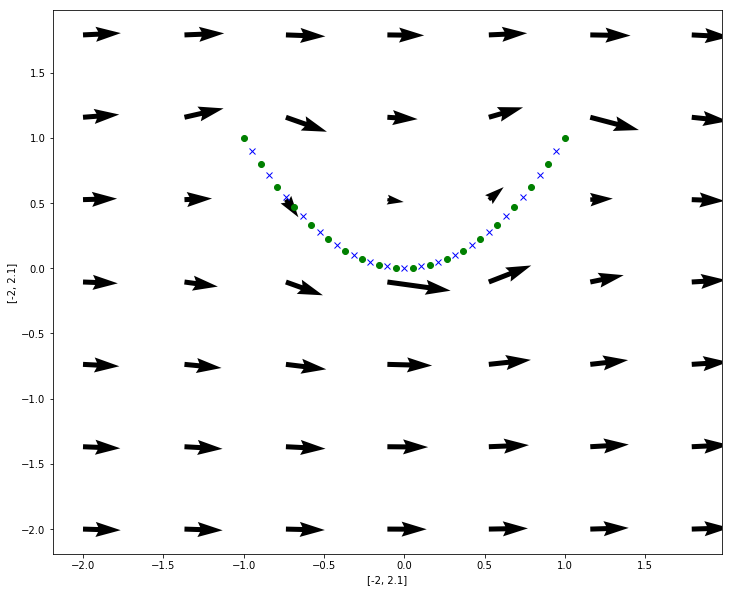

In [94]:
fig = plt.figure(figsize=(12, 10))

plot_num = 0
phi_map = phi_maps["phi - arc"]
title_s = ""
lo = phi_map.min()
hi = phi_map.max()
for i in range(T.shape[0]):
    t = T[i]
    ax = plt.subplot(1, 1, plot_num + 1)
    plot_num += 1
    # plt.axis('off')
    q = ax.quiver(X[::3], Y[::3], U[i, ::3, ::3], V[i, ::3, ::3])

    ax.set_xlabel([X_1, X_2])
    ax.set_ylabel([Y_1, Y_2])

    ax.plot(discrete_points[:, 0], discrete_points[:, 1], 'go')
    ax.plot(collocation_points[:, 0], collocation_points[:, 1], 'bx')

    #im = ax.imshow(phi_map[i, ::-1, :], cmap=cmap, extent=[X_1, X_2, Y_1, Y_2])
    #colorbar(im)
    #plt.title('{}, t = {:.4f}'.format(title_s, t))
    
plt.show()

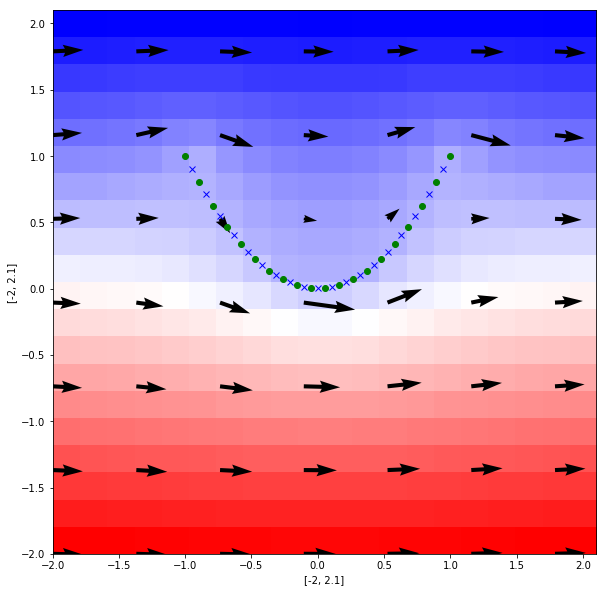

In [95]:
fig = plt.figure(figsize=(12, 10))

plot_num = 0
phi_map = phi_maps["psi"]
title_s = ""
lo = phi_map.min()
hi = phi_map.max()
for i in range(T.shape[0]):
    t = T[i]
    ax = plt.subplot(1, 1, plot_num + 1)
    plot_num += 1
    # plt.axis('off')
    q = ax.quiver(X[::3], Y[::3], U[i, ::3, ::3], V[i, ::3, ::3])

    ax.set_xlabel([X_1, X_2])
    ax.set_ylabel([Y_1, Y_2])

    ax.plot(discrete_points[:, 0], discrete_points[:, 1], 'go')
    ax.plot(collocation_points[:, 0], collocation_points[:, 1], 'bx')

    im = ax.imshow(phi_map[i, ::-1, :], cmap=cmap, extent=[X_1, X_2, Y_1, Y_2])    
plt.show()

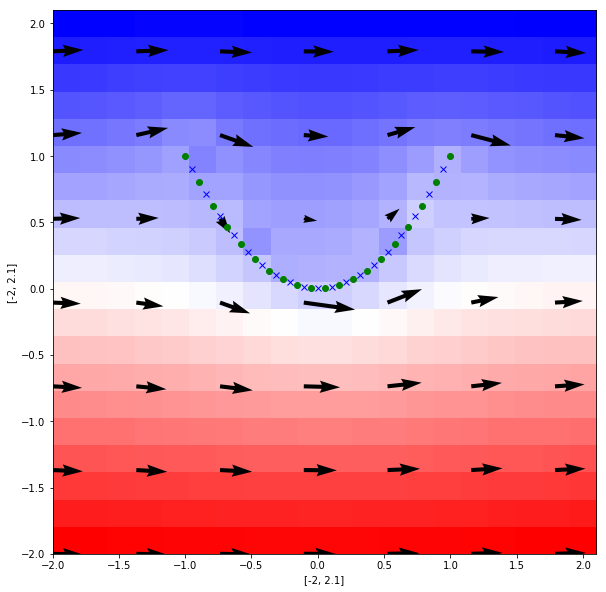

In [96]:
fig = plt.figure(figsize=(12, 10))

plot_num = 0
phi_map = phi_maps["psi dipol"]
title_s = ""
lo = phi_map.min()
hi = phi_map.max()
for i in range(T.shape[0]):
    t = T[i]
    ax = plt.subplot(1, 1, plot_num + 1)
    plot_num += 1
    # plt.axis('off')
    q = ax.quiver(X[::3], Y[::3], U[i, ::3, ::3], V[i, ::3, ::3])

    ax.set_xlabel([X_1, X_2])
    ax.set_ylabel([Y_1, Y_2])

    ax.plot(discrete_points[:, 0], discrete_points[:, 1], 'go')
    ax.plot(collocation_points[:, 0], collocation_points[:, 1], 'bx')

    im = ax.imshow(phi_map[i, ::-1, :], cmap=cmap, extent=[X_1, X_2, Y_1, Y_2])    
plt.show()